In [2]:
import numpy as np
import pandas as pd

# Data Overview

In [3]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

Glimpse

In [4]:
data_train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [5]:
data_test.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.2675  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   
1  18.6316 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773   
2  20.2537  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.9813   2.1281   
3  20.5660  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.1874   3.1656   
4  10.6048  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.5542  -0.2860   

   var_196  var_197  var_198  var_199  
0   4.3654  10.7200  15.4722  -8.7197  
1  -1.4852   9.8714  19.1293 -20.9760  
2  -7.1086   7.0618  19.8956 -23.1794  
3   3.9567   9.2295  13.0168  -4.2108  
4  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

Shape

In [6]:
print("traing data shape：")
print(data_train.shape)
print("\n")
print("testing data shape：")
print(data_test.shape)

traing data shape：
(200000, 202)


testing data shape：
(200000, 201)


Describe

In [6]:
data_train["target"].value_counts()

0    179902
1     20098
Name: target, dtype: int64

It shows that the data is unbalanced.

# Data Visualisation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

Randomly select 10 variable to see their distribution

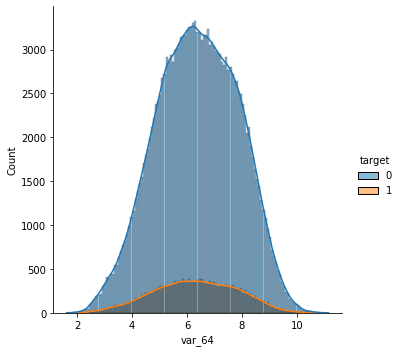

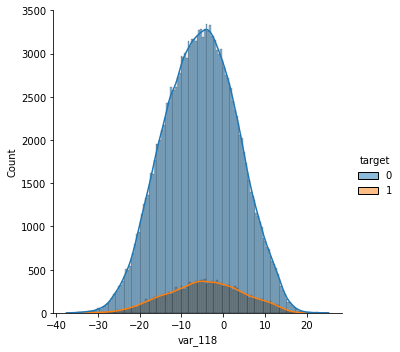

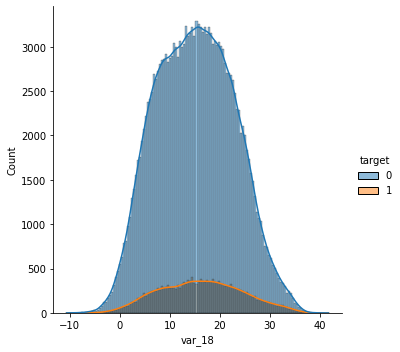

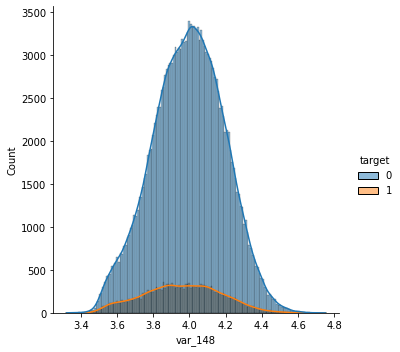

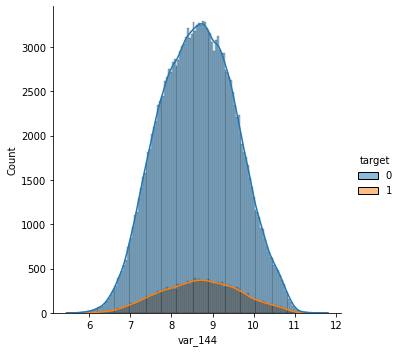

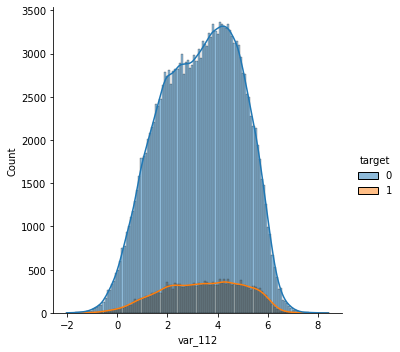

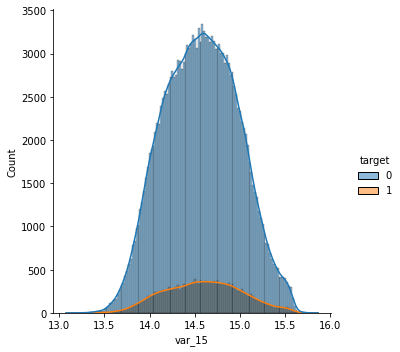

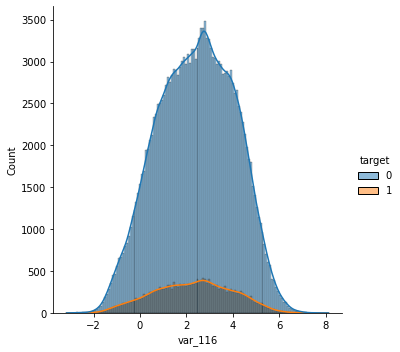

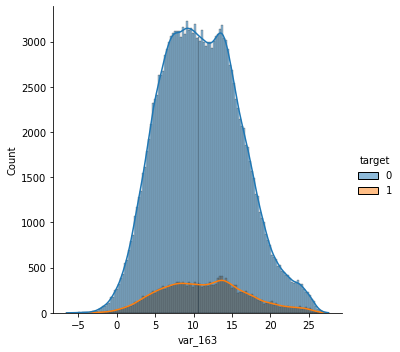

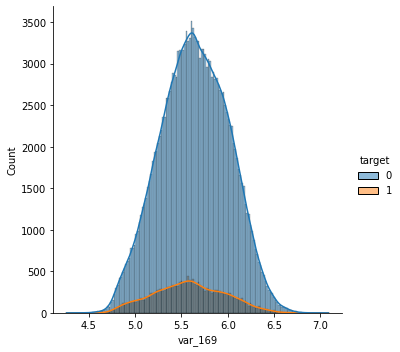

In [8]:
col_num = np.random.randint(2, 201, 10)
for i in col_num:
    sns.displot(data=data_train, x=data_train.iloc[:,i], hue="target", kde=True)

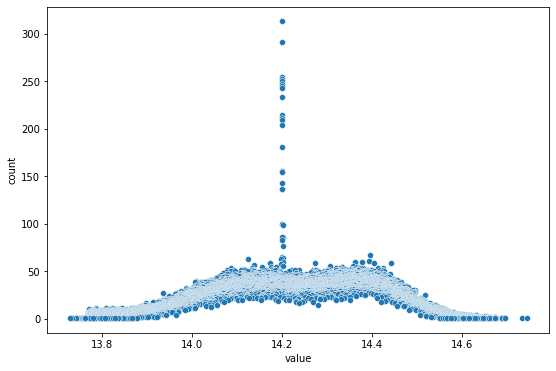

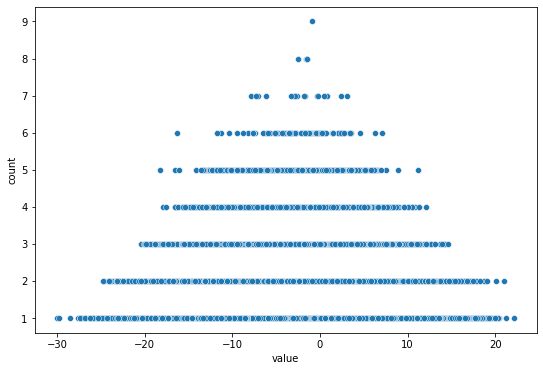

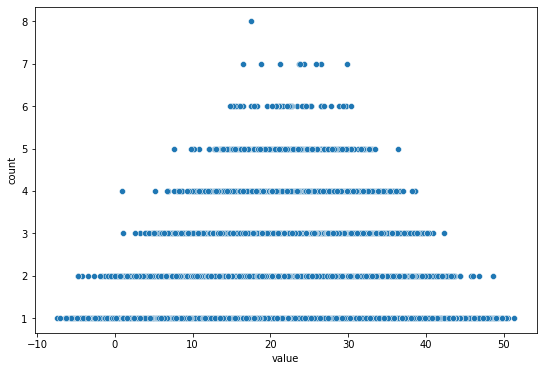

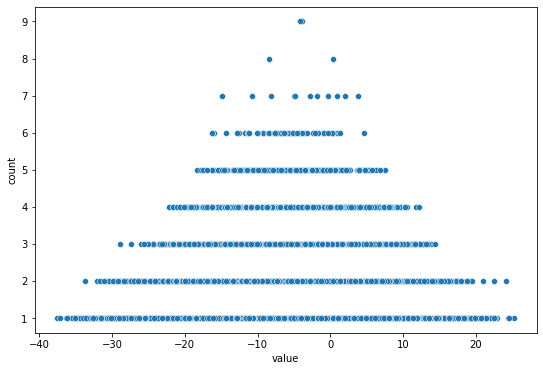

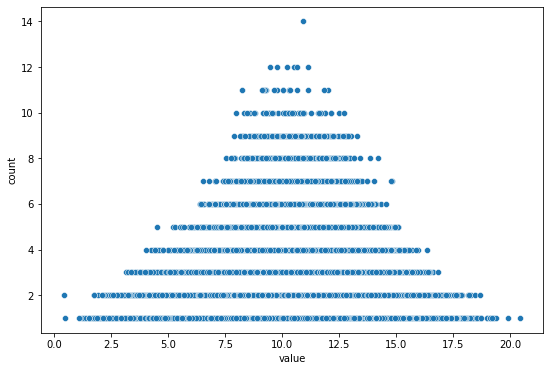

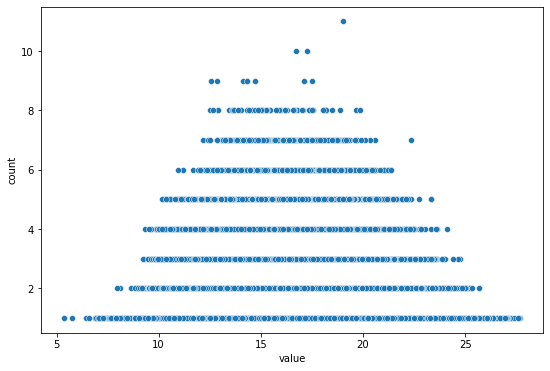

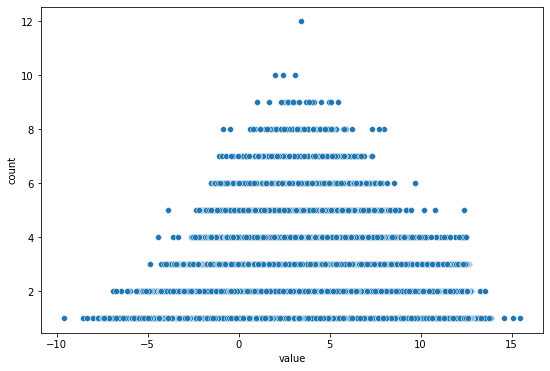

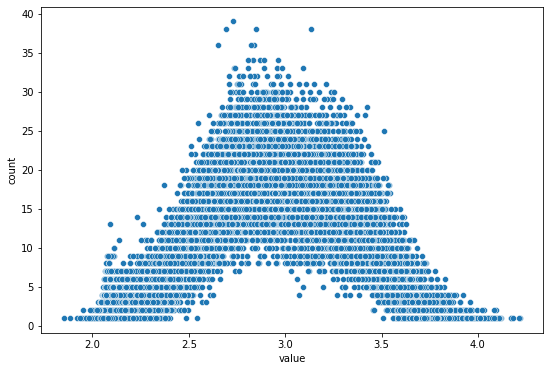

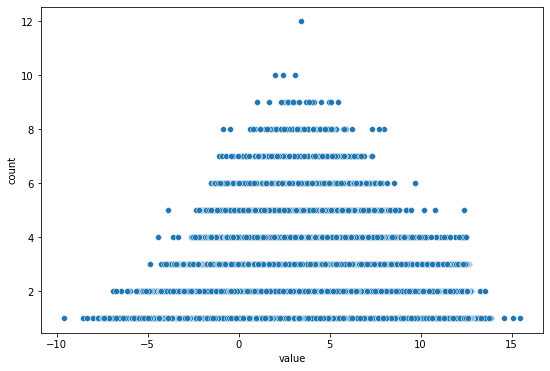

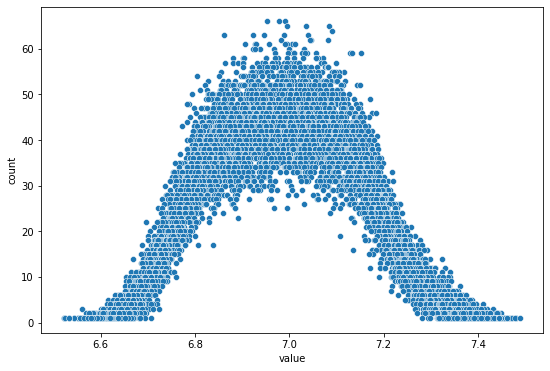

In [110]:
for i in col_num:
    f = plt.figure(figsize=(9, 6))
    f.add_subplot(1,1,1)
    value_count = data_train.iloc[:,i].value_counts()
    sns.scatterplot(y = value_count, x=value_count.index)
    plt.xlabel("value")
    plt.ylabel("count")

In [9]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Features

In [10]:
x_train= data_train.drop(columns=["ID_code", "target"])
y_train = pd.DataFrame(data_train["target"])

x_test= data_test.drop(columns=["ID_code"])

## Find fake information

defind a function to find fake information

In [11]:
def find_fake(data):
    unique_samples = []
    unique_count = np.zeros_like(data)

    for feature in range(data.shape[1]):
        _, index_, count_ = np.unique(data.iloc[:, feature], return_counts=True, return_index=True)
        unique_count[index_[count_ == 1], feature] += 1

    real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
    synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
    
    data_true = data.loc[real_samples_indexes]
    data_synthetic = data.loc[synthetic_samples_indexes]
    
    return data_true, data_synthetic

In [12]:
x_train_t, x_train_s = find_fake(x_train)

In [13]:
x_test_t, x_test_s = find_fake(x_test)

In [14]:
print("number of fake information in train dataset:")
print(x_train_s.shape[0])
print("number of fake information in test dataset:")
print(x_test_s.shape[0])

number of fake information in train dataset:
0
number of fake information in test dataset:
100000


## Add new features

In [15]:
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

In [16]:
comb = pd.concat([x_train_t, x_test_t], axis=0, sort=True)
for i in range(200): encode_FE(comb,'var_'+str(i),x_test_t)
x_train = comb[:len(x_train)]

C:\Users\CT\AppData\Local\Temp/ipykernel_14344/2240117687.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[nm] = df[col].map(cv)
C:\Users\CT\AppData\Local\Temp/ipykernel_14344/2240117687.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test[nm] = test[col].map(cv)


Now we have 400 features.

In [17]:
x_train.shape

(200000, 400)

In [18]:
x_test_t.shape

(100000, 400)

In [19]:
x_train.head()

var_0   var_1  var_10  var_100  var_101  var_102  var_103  var_104  \
0   8.9255 -6.7863  2.9252   9.4763  13.3102  26.5376   1.4403  14.7100   
1  11.5006 -4.1473 -0.4032 -13.6950   8.4068  35.4734   1.7093  15.1866   
2   8.6093 -2.7457 -0.3249  -0.3939  12.6317  14.8863   1.3854  15.0284   
3  11.0604 -2.1518  2.3061 -19.8592  22.5316  18.6129   1.3512   9.3291   
4   9.8369 -1.4834 -9.4458 -22.9264  12.3562  17.3410   1.6940   7.1179   

   var_105  var_106  ...  var_190_FE  var_191_FE  var_192_FE  var_193_FE  \
0   6.0454   9.5426  ...           3           8           9           4   
1   2.6227   7.3412  ...           8           5           9           2   
2   3.9995   5.3683  ...           4           5           6           2   
3   4.2835  10.3907  ...           2           3           6           4   
4   5.1934   8.8230  ...           3           8           1           1   

   var_194_FE  var_195_FE  var_196_FE  var_197_FE  var_198_FE  var_199_FE  
0           9           5           5          14           5           2  
1           4           4           4          21           6           2  
2           2           2           3          12           4           2  
3           4           8           5           4           2           2  
4           1           9           5           9           2           2  

[5 rows x 400 columns]

# Build model

because the dataset is huge, we only use 2000 samples to model.

In [20]:
x_train_samp = x_train.sample(n=2000)

In [21]:
y_train_samp = y_train.loc[x_train_samp.index]

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

## XGBC

### Model

In [171]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[23:31:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

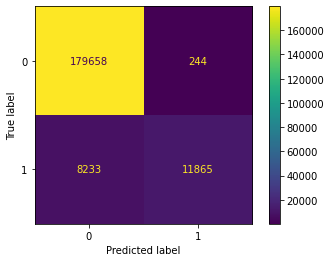

In [176]:
y_pred = model_xgb.predict(x_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [178]:
roc_auc_score(y_train, y_pred)

0.7945004777476404

In [179]:
model_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

<AxesSubplot:>

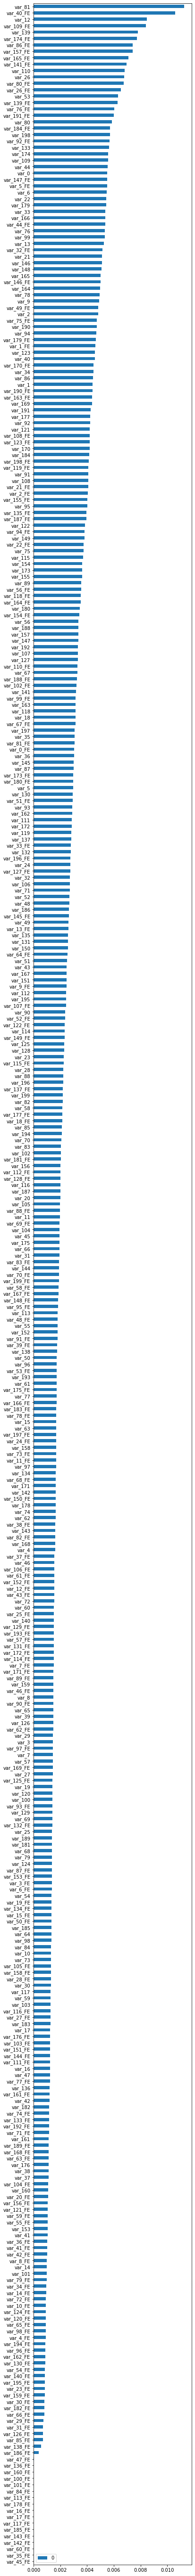

In [208]:
importance = pd.DataFrame(model_xgb.feature_importances_)
importance.index = x_train.columns
importance = importance.sort_values(by=0, ascending=True)
importance.plot(kind="barh", figsize=(6,100))

In [188]:
node_params = {'shape': 'box', 
               'style': 'filled, rounded', 
                'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
grapg_data = xgb.to_graphviz(model_xgb, num_trees=0, size='10,10',
                                condition_node_params=node_params,
                                leaf_node_params=leaf_params)

grapg_data.view(filename='XGBoost_tree')

'XGBoost_tree.pdf'

### Hyperparameter Optimization

In [21]:
param_grid = {
    'n_estimators':[100, 150, 200],
    'max_depth' : [5, 6, 7],
    'learning_rate' : [0.1, 0.01, 0.05],
    'gamma' : [0, 0.25, 1.0],
    'reg_lambda' : [0, 1.0],
    'scale_pos_weight' : [3, 5, 7]
}

In [22]:
x_train.head()

var_0   var_1  var_10  var_100  var_101  var_102  var_103  var_104  \
0   8.9255 -6.7863  2.9252   9.4763  13.3102  26.5376   1.4403  14.7100   
1  11.5006 -4.1473 -0.4032 -13.6950   8.4068  35.4734   1.7093  15.1866   
2   8.6093 -2.7457 -0.3249  -0.3939  12.6317  14.8863   1.3854  15.0284   
3  11.0604 -2.1518  2.3061 -19.8592  22.5316  18.6129   1.3512   9.3291   
4   9.8369 -1.4834 -9.4458 -22.9264  12.3562  17.3410   1.6940   7.1179   

   var_105  var_106  ...  var_190_FE  var_191_FE  var_192_FE  var_193_FE  \
0   6.0454   9.5426  ...           3           8           9           4   
1   2.6227   7.3412  ...           8           5           9           2   
2   3.9995   5.3683  ...           4           5           6           2   
3   4.2835  10.3907  ...           2           3           6           4   
4   5.1934   8.8230  ...           3           8           1           1   

   var_194_FE  var_195_FE  var_196_FE  var_197_FE  var_198_FE  var_199_FE  
0           9           5           5          14           5           2  
1           4           4           4          21           6           2  
2           2           2           3          12           4           2  
3           4           8           5           4           2           2  
4           1           9           5           9           2           2  

[5 rows x 400 columns]

In [23]:
x_valid = x_train.sample(100)
y_valid = y_train.loc[x_valid.index]

In [51]:
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(
        objective='binary:logistic', 
        seed=42, 
        subsample=1, 
        colsample_bytree=0.5
    ),
    param_grid = param_grid,
    scoring = 'roc_auc', 
    verbose = 0,
    cv = 5
)

optimal_params.fit(
    x_train_samp, y_train_samp, 
    verbose=True, 
    early_stopping_rounds=10, 
    eval_metric='auc',
    eval_set=[(x_valid, y_valid)]
)

[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65444
[4]	validation_0-auc:0.59722
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.62722
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58611
[9]	validation_0-auc:0.64000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.46833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.57833
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.65333
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.69444
[14]	validation_0-auc:0.68444
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.64778
[22]	validation_0-auc:0.68333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57667
[2]	validation_0-auc:0.66778
[3]	validation_0-auc:0.66889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72667
[6]	validation_0-auc:0.69833
[7]	validation_0-auc:0.69611
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77167
[11]	validation_0-auc:0.76611
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.67778
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59056
[4]	validation_0-auc:0.55167
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.48889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.59667
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54889
[2]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56167
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.66222
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66333
[12]	validation_0-auc:0.68667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.61222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.55556
[2]	validation_0-auc:0.48389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41611
[4]	validation_0-auc:0.48667
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.57889
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57444
[18]	validation_0-auc:0.57111
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.53222
[21]	validation_0-auc:0.52778
[22]	validation_0-auc:0.52667
[23]	validation_0-auc:0.53333
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.69056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.67222
[10]	validation_0-auc:0.68667
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65444
[3]	validation_0-auc:0.71611
[4]	validation_0-auc:0.76056
[5]	validation_0-auc:0.73611
[6]	validation_0-auc:0.76444
[7]	validation_0-auc:0.77556
[8]	validation_0-auc:0.80778
[9]	validation_0-auc:0.80333
[10]	validation_0-auc:0.81889
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81444
[13]	validation_0-auc:0.80333
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77889
[16]	validation_0-auc:0.77111
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.77222
[19]	validation_0-auc:0.77778
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.73889
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.52611
[5]	validation_0-auc:0.50833
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62222
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67556
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.69333
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33389
[2]	validation_0-auc:0.34556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.34611
[4]	validation_0-auc:0.34333
[5]	validation_0-auc:0.36667
[6]	validation_0-auc:0.36000
[7]	validation_0-auc:0.36889
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.46667
[12]	validation_0-auc:0.50000
[13]	validation_0-auc:0.49000
[14]	validation_0-auc:0.45444
[15]	validation_0-auc:0.50222
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52889
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.51778
[24]	validation_0-auc:0.54444
[25]	validation_0-auc:0.54889
[26]	validation_0-auc:0.54333
[27]	validation_0-auc:0.52778
[28]	validation_0-auc:0.52889
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.52111
[32]	validation_0-auc:0.56000
[33]	validation_0-auc:0.58111
[34]	validation_0-auc:0.58556
[35]	validation_0-auc:0.58000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43222
[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.55056
[9]	validation_0-auc:0.59389
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.50333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49889
[17]	validation_0-auc:0.50333
[18]	validation_0-auc:0.52222
[19]	validation_0-auc:0.50889
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.73111
[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77667
[5]	validation_0-auc:0.71333
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.68444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57500
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.64611
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.63889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54500
[2]	validation_0-auc:0.57278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62111
[21]	validation_0-auc:0.64667
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62500
[2]	validation_0-auc:0.62500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.69111
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.55889
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.57000
[19]	validation_0-auc:0.55778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67000
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67167
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.64000
[17]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000
[3]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[22]	validation_0-auc:0.71000
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51889
[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667
[2]	validation_0-auc:0.57611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.64556
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.66444
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.35000
[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.44889
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.54556
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.55889
[20]	validation_0-auc:0.55667
[21]	validation_0-auc:0.59333
[22]	validation_0-auc:0.59556
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.60667
[26]	validation_0-auc:0.62000
[27]	validation_0-auc:0.60556
[28]	validation_0-auc:0.61444
[29]	validation_0-auc:0.59889
[30]	validation_0-auc:0.61222
[31]	validation_0-auc:0.57889
[32]	validation_0-auc:0.60556
[33]	validation_0-auc:0.58778
[34]	validation_0-auc:0.59889
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.78444
[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.79000
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.81333
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63222
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.71000
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.74889
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.73111
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.78889
[21]	validation_0-auc:0.79000
[22]	validation_0-auc:0.80444
[23]	validation_0-auc:0.81000
[24]	validation_0-auc:0.80333
[25]	validation_0-auc:0.82000
[26]	validation_0-auc:0.81333
[27]	validation_0-auc:0.80778
[28]	validation_0-auc:0.79778
[29]	validation_0-auc:0.80556
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.78444
[32]	validation_0-auc:0.78000
[33]	validation_0-auc:0.79556
[34]	validation_0-auc:0.78333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65444
[4]	validation_0-auc:0.59722
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.62722
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58611
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.67111
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.46833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.57833
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.65333
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.69444
[14]	validation_0-auc:0.68444
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.64778
[22]	validation_0-auc:0.68333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51000
[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57667
[2]	validation_0-auc:0.66778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66889
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72667
[6]	validation_0-auc:0.69833
[7]	validation_0-auc:0.69611
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77167
[11]	validation_0-auc:0.76611
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.67778
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278
[3]	validation_0-auc:0.59056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55167
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.48889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.61444
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54889
[2]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56167
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.66222
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66333
[12]	validation_0-auc:0.68667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.62444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.55556
[2]	validation_0-auc:0.48389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41611
[4]	validation_0-auc:0.48667
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.57889
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57444
[18]	validation_0-auc:0.57111
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.53222
[21]	validation_0-auc:0.52778
[22]	validation_0-auc:0.52667
[23]	validation_0-auc:0.53333
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.69056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.67222
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333
[2]	validation_0-auc:0.65444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71611
[4]	validation_0-auc:0.76056
[5]	validation_0-auc:0.73611
[6]	validation_0-auc:0.76444
[7]	validation_0-auc:0.77556
[8]	validation_0-auc:0.80778
[9]	validation_0-auc:0.80333
[10]	validation_0-auc:0.81889
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81444
[13]	validation_0-auc:0.80333
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77889
[16]	validation_0-auc:0.77111
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.77222
[19]	validation_0-auc:0.77778
[20]	validation_0-auc:0.75000
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.52611
[5]	validation_0-auc:0.50833
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62222
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67556
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.69889
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33389
[2]	validation_0-auc:0.34556
[3]	validation_0-auc:0.34611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.34333
[5]	validation_0-auc:0.36667
[6]	validation_0-auc:0.36000
[7]	validation_0-auc:0.36889
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.46667
[12]	validation_0-auc:0.50000
[13]	validation_0-auc:0.49000
[14]	validation_0-auc:0.45444
[15]	validation_0-auc:0.50222
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52889
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.51778
[24]	validation_0-auc:0.54444
[25]	validation_0-auc:0.54889
[26]	validation_0-auc:0.54333
[27]	validation_0-auc:0.52778
[28]	validation_0-auc:0.52889
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.52111
[32]	validation_0-auc:0.56000
[33]	validation_0-auc:0.58111
[34]	validation_0-auc:0.58556
[35]	validation_0-auc:0.58000
[36]	validation_0-auc:0.59222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.55056
[9]	validation_0-auc:0.59389
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.50333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49889
[17]	validation_0-auc:0.50333
[18]	validation_0-auc:0.52222
[19]	validation_0-auc:0.50889
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611
[2]	validation_0-auc:0.73111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77667
[5]	validation_0-auc:0.71333
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71222
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.64611
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.64000
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54500
[2]	validation_0-auc:0.57278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62111
[21]	validation_0-auc:0.64667
[22]	validation_0-auc:0.62444
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62500
[2]	validation_0-auc:0.62500
[3]	validation_0-auc:0.70444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.69111
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556
[3]	validation_0-auc:0.61278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.57111
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.55889
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.57000
[19]	validation_0-auc:0.55778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.62667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67000
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67167
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.64000
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51889
[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.64556
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.66444
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.69333
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.44889
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.54556
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.55889
[20]	validation_0-auc:0.55667
[21]	validation_0-auc:0.59333
[22]	validation_0-auc:0.59556
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.60667
[26]	validation_0-auc:0.62000
[27]	validation_0-auc:0.60556
[28]	validation_0-auc:0.61444
[29]	validation_0-auc:0.59889
[30]	validation_0-auc:0.61222
[31]	validation_0-auc:0.57889
[32]	validation_0-auc:0.60556
[33]	validation_0-auc:0.58778
[34]	validation_0-auc:0.59889
[35]	validation_0-auc:0.59444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.78444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.79000
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.81333
[23]	validation_0-auc:0.79000
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.71000
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.74889
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.73111
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.78889
[21]	validation_0-auc:0.79000
[22]	validation_0-auc:0.80444
[23]	validation_0-auc:0.81000
[24]	validation_0-auc:0.80333
[25]	validation_0-auc:0.82000
[26]	validation_0-auc:0.81333
[27]	validation_0-auc:0.80778
[28]	validation_0-auc:0.79778
[29]	validation_0-auc:0.80556
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.78444
[32]	validation_0-auc:0.78000
[33]	validation_0-auc:0.79556
[34]	validation_0-auc:0.78333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59722
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.62722
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58611
[9]	validation_0-auc:0.64000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.46833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.57833
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.65333
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.69444
[14]	validation_0-auc:0.68444
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.64778
[22]	validation_0-auc:0.68333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57667
[2]	validation_0-auc:0.66778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66889
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72667
[6]	validation_0-auc:0.69833
[7]	validation_0-auc:0.69611
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77167
[11]	validation_0-auc:0.76611
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.67000
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59056
[4]	validation_0-auc:0.55167
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.48889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.61444
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54889
[2]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56167
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.66222
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66333
[12]	validation_0-auc:0.68667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.61222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.55556
[2]	validation_0-auc:0.48389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41611
[4]	validation_0-auc:0.48667
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.57889
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57444
[18]	validation_0-auc:0.57111
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.53222
[21]	validation_0-auc:0.52778
[22]	validation_0-auc:0.52667
[23]	validation_0-auc:0.53333
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.69056
[3]	validation_0-auc:0.73500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.67222
[10]	validation_0-auc:0.68667
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333
[2]	validation_0-auc:0.65444
[3]	validation_0-auc:0.71611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76056
[5]	validation_0-auc:0.73611
[6]	validation_0-auc:0.76444
[7]	validation_0-auc:0.77556
[8]	validation_0-auc:0.80778
[9]	validation_0-auc:0.80333
[10]	validation_0-auc:0.81889
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81444
[13]	validation_0-auc:0.80333
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77889
[16]	validation_0-auc:0.77111
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.77222
[19]	validation_0-auc:0.77778
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.73889
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.63833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.52611
[5]	validation_0-auc:0.50833
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62222
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67556
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.69333
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33389
[2]	validation_0-auc:0.34556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.34611
[4]	validation_0-auc:0.34333
[5]	validation_0-auc:0.36667
[6]	validation_0-auc:0.36000
[7]	validation_0-auc:0.36889
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.46667
[12]	validation_0-auc:0.50000
[13]	validation_0-auc:0.49000
[14]	validation_0-auc:0.45444
[15]	validation_0-auc:0.50222
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52889
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.51778
[24]	validation_0-auc:0.54444
[25]	validation_0-auc:0.54889
[26]	validation_0-auc:0.54333
[27]	validation_0-auc:0.52778
[28]	validation_0-auc:0.52889
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.52111
[32]	validation_0-auc:0.56000
[33]	validation_0-auc:0.58111
[34]	validation_0-auc:0.58556
[35]	validation_0-auc:0.58000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.55056
[9]	validation_0-auc:0.59389
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.50333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49889
[17]	validation_0-auc:0.50333
[18]	validation_0-auc:0.52222
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611
[2]	validation_0-auc:0.73111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77667
[5]	validation_0-auc:0.71333
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71222
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57500
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.64611
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.63889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54500
[2]	validation_0-auc:0.57278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62111
[21]	validation_0-auc:0.64667
[22]	validation_0-auc:0.62444
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62500
[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.55889
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.57000
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67000
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056
[3]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.64000
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51889
[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667
[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.64556
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.69333
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.44889
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.54556
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.55889
[20]	validation_0-auc:0.55667
[21]	validation_0-auc:0.59333
[22]	validation_0-auc:0.59556
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.60667
[26]	validation_0-auc:0.62000
[27]	validation_0-auc:0.60556
[28]	validation_0-auc:0.61444
[29]	validation_0-auc:0.59889
[30]	validation_0-auc:0.61222
[31]	validation_0-auc:0.57889
[32]	validation_0-auc:0.60556
[33]	validation_0-auc:0.58778
[34]	validation_0-auc:0.59889
[35]	validation_0-auc:0.59444
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.78444
[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.79000
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.81333
[23]	validation_0-auc:0.79000
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.71000
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.74889
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.73111
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.78889
[21]	validation_0-auc:0.79000
[22]	validation_0-auc:0.80444
[23]	validation_0-auc:0.81000
[24]	validation_0-auc:0.80333
[25]	validation_0-auc:0.82000
[26]	validation_0-auc:0.81333
[27]	validation_0-auc:0.80778
[28]	validation_0-auc:0.79778
[29]	validation_0-auc:0.80556
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.78444
[32]	validation_0-auc:0.78000
[33]	validation_0-auc:0.79556
[34]	validation_0-auc:0.78333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54167
[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.51389
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.50944
[7]	validation_0-auc:0.54667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.63889
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71000
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.69111
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.63778
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67333
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63444
[2]	validation_0-auc:0.68056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62167
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46889
[2]	validation_0-auc:0.45056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48389
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.44333
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44667
[8]	validation_0-auc:0.51111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.51444
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67611
[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.69389
[7]	validation_0-auc:0.67167
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67056
[10]	validation_0-auc:0.67611
[11]	validation_0-auc:0.68389
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.63667
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500
[3]	validation_0-auc:0.46056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.49000
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.64000
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.71333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.70889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.71111
[32]	validation_0-auc:0.70000
[33]	validation_0-auc:0.70222
[34]	validation_0-auc:0.69889
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37778
[3]	validation_0-auc:0.38278
[4]	validation_0-auc:0.38944
[5]	validation_0-auc:0.42833
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.59444
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54111
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.56889
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59111
[22]	validation_0-auc:0.56333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60278
[4]	validation_0-auc:0.52389
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.57444
[12]	validation_0-auc:0.54111
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.54889
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944
[2]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.58778
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.72278
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72778
[7]	validation_0-auc:0.74556
[8]	validation_0-auc:0.75111
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.76556
[11]	validation_0-auc:0.75333
[12]	validation_0-auc:0.71889
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.74556
[22]	validation_0-auc:0.74111
[23]	validation_0-auc:0.73333
[24]	validation_0-auc:0.73667
[25]	validation_0-auc:0.73556
[26]	validation_0-auc:0.75333
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.74222
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50111
[2]	validation_0-auc:0.64389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63167
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.66333
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.73444
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.72667
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.74667
[32]	validation_0-auc:0.76000
[33]	validation_0-auc:0.76889
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.40000
[7]	validation_0-auc:0.42111
[8]	validation_0-auc:0.42667
[9]	validation_0-auc:0.48889
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.49556
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.50667
[15]	validation_0-auc:0.50000
[16]	validation_0-auc:0.48111
[17]	validation_0-auc:0.46556
[18]	validation_0-auc:0.47556
[19]	validation_0-auc:0.46333
[20]	validation_0-auc:0.49111
[21]	validation_0-auc:0.48556
[22]	validation_0-auc:0.50444
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.57556
[26]	validation_0-auc:0.57889
[27]	validation_0-auc:0.56333
[28]	validation_0-auc:0.57444
[29]	validation_0-auc:0.58111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.57222
[32]	validation_0-auc:0.57444
[33]	validation_0-auc:0.57889
[34]	validation_0-auc:0.58667
[35]	validation_0-auc:0.59000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42167
[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.37556
[6]	validation_0-auc:0.39778
[7]	validation_0-auc:0.45556
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.50889
[10]	validation_0-auc:0.48000
[11]	validation_0-auc:0.49667
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.48000
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.52333
[18]	validation_0-auc:0.50222
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.49667
[21]	validation_0-auc:0.49556
[22]	validation_0-auc:0.50222
[23]	validation_0-auc:0.51000
[24]	validation_0-auc:0.51000
[25]	validation_0-auc:0.50000
[26]	validation_0-auc:0.51444
[27]	validation_0-auc:0.52667
[28]	validation_0-auc:0.51889
[29]	validation_0-auc:0.52778
[30]	validation_0-auc:0.52667
[31]	validation_0-auc:0.50556
[32]	validation_0-auc:0.53000
[33]	validation_0-auc:0.51667
[34]	validation_0-auc:0.50000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65389
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.53889
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63278
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62500
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.60444
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.56778
[12]	validation_0-auc:0.56333
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.56778
[15]	validation_0-auc:0.53889
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60889
[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.60778
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.58667
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65778
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67778
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54833
[5]	validation_0-auc:0.58889
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59833
[10]	validation_0-auc:0.59667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50722
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.47333
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.56167
[9]	validation_0-auc:0.51611
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57278
[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.72444
[23]	validation_0-auc:0.70667
[24]	validation_0-auc:0.72111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59222
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.69222
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65444
[13]	validation_0-auc:0.63111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.65111
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.69556
[20]	validation_0-auc:0.67222
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69778
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.69667
[32]	validation_0-auc:0.69111
[33]	validation_0-auc:0.69333
[34]	validation_0-auc:0.69000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48333
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49333
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.60111
[13]	validation_0-auc:0.58444
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.60111
[19]	validation_0-auc:0.59444
[20]	validation_0-auc:0.59778
[21]	validation_0-auc:0.59778
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68556
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70722
[4]	validation_0-auc:0.70778
[5]	validation_0-auc:0.67889
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.63444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80889
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78778
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77778
[19]	validation_0-auc:0.79889
[20]	validation_0-auc:0.82333
[21]	validation_0-auc:0.83000
[22]	validation_0-auc:0.79444
[23]	validation_0-auc:0.79667
[24]	validation_0-auc:0.79444
[25]	validation_0-auc:0.80667
[26]	validation_0-auc:0.80111
[27]	validation_0-auc:0.77889
[28]	validation_0-auc:0.77000
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49833
[2]	validation_0-auc:0.54167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.51389
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.50944
[7]	validation_0-auc:0.54667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.63889
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71000
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.69111
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.63778
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67333
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63444
[2]	validation_0-auc:0.68056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62167
[12]	validation_0-auc:0.59222
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46889
[2]	validation_0-auc:0.45056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48389
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.44333
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44667
[8]	validation_0-auc:0.51111
[9]	validation_0-auc:0.50000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67611
[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.69389
[7]	validation_0-auc:0.67167
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67056
[10]	validation_0-auc:0.67611
[11]	validation_0-auc:0.68389
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.62889
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46056
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.49000
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.64000
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.71333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.70889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.71111
[32]	validation_0-auc:0.70000
[33]	validation_0-auc:0.70222
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33833
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38278
[4]	validation_0-auc:0.38944
[5]	validation_0-auc:0.42833
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.59444
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54111
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.56889
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59111
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60278
[4]	validation_0-auc:0.52389
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.57444
[12]	validation_0-auc:0.54111
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.54889
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944
[2]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.58778
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.72278
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72778
[7]	validation_0-auc:0.74556
[8]	validation_0-auc:0.75111
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.76556
[11]	validation_0-auc:0.75333
[12]	validation_0-auc:0.71889
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.74556
[22]	validation_0-auc:0.74111
[23]	validation_0-auc:0.73333
[24]	validation_0-auc:0.73667
[25]	validation_0-auc:0.73556
[26]	validation_0-auc:0.75333
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.74222
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64389
[3]	validation_0-auc:0.63167
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.66333
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.73444
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.72667
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.74667
[32]	validation_0-auc:0.76000
[33]	validation_0-auc:0.76889
[34]	validation_0-auc:0.77000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.40000
[7]	validation_0-auc:0.42111
[8]	validation_0-auc:0.42667
[9]	validation_0-auc:0.48889
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.49556
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.50667
[15]	validation_0-auc:0.50000
[16]	validation_0-auc:0.48111
[17]	validation_0-auc:0.46556
[18]	validation_0-auc:0.47556
[19]	validation_0-auc:0.46333
[20]	validation_0-auc:0.49111
[21]	validation_0-auc:0.48556
[22]	validation_0-auc:0.50444
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.57556
[26]	validation_0-auc:0.57889
[27]	validation_0-auc:0.56333
[28]	validation_0-auc:0.57444
[29]	validation_0-auc:0.58111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.57222
[32]	validation_0-auc:0.57444
[33]	validation_0-auc:0.57889
[34]	validation_0-auc:0.58667
[35]	validation_0-auc:0.59000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.37556
[6]	validation_0-auc:0.39778
[7]	validation_0-auc:0.45556
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.50889
[10]	validation_0-auc:0.48000
[11]	validation_0-auc:0.49667
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.48000
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.52333
[18]	validation_0-auc:0.50222
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.49667
[21]	validation_0-auc:0.49556
[22]	validation_0-auc:0.50222
[23]	validation_0-auc:0.51000
[24]	validation_0-auc:0.51000
[25]	validation_0-auc:0.50000
[26]	validation_0-auc:0.51444
[27]	validation_0-auc:0.52667
[28]	validation_0-auc:0.51889
[29]	validation_0-auc:0.52778
[30]	validation_0-auc:0.52667
[31]	validation_0-auc:0.50556
[32]	validation_0-auc:0.53000
[33]	validation_0-auc:0.51667
[34]	validation_0-auc:0.50000
[35]	validation_0-auc:0.49556
[36]	validation_0-auc:0.50000
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65389
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.53889
[13]	validation_0-auc:0.53556
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55611
[2]	validation_0-auc:0.63278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62500
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.60444
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.56778
[12]	validation_0-auc:0.56333
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.56778
[15]	validation_0-auc:0.53889
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48111
[2]	validation_0-auc:0.60889
[3]	validation_0-auc:0.63056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.60778
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.58667
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65778
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67778
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54833
[5]	validation_0-auc:0.58889
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59833
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500
[3]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.47333
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.56167
[9]	validation_0-auc:0.51611
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556
[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.57278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.72444
[23]	validation_0-auc:0.70667
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59222
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.69222
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.51778
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.64111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65444
[13]	validation_0-auc:0.63111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.66778
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.69556
[20]	validation_0-auc:0.67222
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69778
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.69667
[32]	validation_0-auc:0.69111
[33]	validation_0-auc:0.69333
[34]	validation_0-auc:0.69000
[35]	validation_0-auc:0.70111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41278
[2]	validation_0-auc:0.37500
[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48333
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49333
[19]	validation_0-auc:0.50556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.60111
[13]	validation_0-auc:0.58444
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.60111
[19]	validation_0-auc:0.59444
[20]	validation_0-auc:0.59778
[21]	validation_0-auc:0.59778
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68556
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70722
[4]	validation_0-auc:0.70778
[5]	validation_0-auc:0.67889
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.63444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80889
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78778
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77778
[19]	validation_0-auc:0.79889
[20]	validation_0-auc:0.82333
[21]	validation_0-auc:0.83000
[22]	validation_0-auc:0.79444
[23]	validation_0-auc:0.79667
[24]	validation_0-auc:0.79444
[25]	validation_0-auc:0.80667
[26]	validation_0-auc:0.80111
[27]	validation_0-auc:0.77889
[28]	validation_0-auc:0.77000
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[31]	validation_0-auc:0.73778
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54167
[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.51389
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.50944
[7]	validation_0-auc:0.54667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.63889
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71000
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.69111
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.63778
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67333
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63444
[2]	validation_0-auc:0.68056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62167
[12]	validation_0-auc:0.59222
[0]	validation_0-auc:0.56944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.46889
[2]	validation_0-auc:0.45056
[3]	validation_0-auc:0.48389
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.44333
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44667
[8]	validation_0-auc:0.51111
[9]	validation_0-auc:0.50000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.67500
[3]	validation_0-auc:0.67611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.69389
[7]	validation_0-auc:0.67167
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67056
[10]	validation_0-auc:0.67611
[11]	validation_0-auc:0.68389
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.63667
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46056
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.49000
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.64000
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.71333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.70889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.71111
[32]	validation_0-auc:0.70000
[33]	validation_0-auc:0.70222
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37778
[3]	validation_0-auc:0.38278
[4]	validation_0-auc:0.38944
[5]	validation_0-auc:0.42833
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.59444
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54111
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.56889
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59111
[22]	validation_0-auc:0.56333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56667
[3]	validation_0-auc:0.60278
[4]	validation_0-auc:0.52389
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.58056
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.57444
[12]	validation_0-auc:0.54111
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.54889
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944
[2]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.58778
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.72278
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72778
[7]	validation_0-auc:0.74556
[8]	validation_0-auc:0.75111
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.76556
[11]	validation_0-auc:0.75333
[12]	validation_0-auc:0.71889
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.74556
[22]	validation_0-auc:0.74111
[23]	validation_0-auc:0.73333
[24]	validation_0-auc:0.73667
[25]	validation_0-auc:0.73556
[26]	validation_0-auc:0.75333
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.74222
[29]	validation_0-auc:0.74222
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50111
[2]	validation_0-auc:0.64389
[3]	validation_0-auc:0.63167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.66333
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.73444
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.72667
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.74667
[32]	validation_0-auc:0.76000
[33]	validation_0-auc:0.76889
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76889
[36]	validation_0-auc:0.76333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.40000
[7]	validation_0-auc:0.42111
[8]	validation_0-auc:0.42667
[9]	validation_0-auc:0.48889
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.49556
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.50667
[15]	validation_0-auc:0.50000
[16]	validation_0-auc:0.48111
[17]	validation_0-auc:0.46556
[18]	validation_0-auc:0.47556
[19]	validation_0-auc:0.46333
[20]	validation_0-auc:0.49111
[21]	validation_0-auc:0.48556
[22]	validation_0-auc:0.50444
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.57556
[26]	validation_0-auc:0.57889
[27]	validation_0-auc:0.56333
[28]	validation_0-auc:0.57444
[29]	validation_0-auc:0.58111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.57222
[32]	validation_0-auc:0.57444
[33]	validation_0-auc:0.57889
[34]	validation_0-auc:0.58667
[35]	validation_0-auc:0.59000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.37556
[6]	validation_0-auc:0.39778
[7]	validation_0-auc:0.45556
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.50889
[10]	validation_0-auc:0.48000
[11]	validation_0-auc:0.49667
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.48000
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.52333
[18]	validation_0-auc:0.50222
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.49667
[21]	validation_0-auc:0.49556
[22]	validation_0-auc:0.50222
[23]	validation_0-auc:0.51000
[24]	validation_0-auc:0.51000
[25]	validation_0-auc:0.50000
[26]	validation_0-auc:0.51444
[27]	validation_0-auc:0.52667
[28]	validation_0-auc:0.51889
[29]	validation_0-auc:0.52778
[30]	validation_0-auc:0.52667
[31]	validation_0-auc:0.50556
[32]	validation_0-auc:0.53000
[33]	validation_0-auc:0.51667
[34]	validation_0-auc:0.50000
[35]	validation_0-auc:0.49556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65389
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.53889
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55611
[2]	validation_0-auc:0.63278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62500
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.60444
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.56778
[12]	validation_0-auc:0.56333
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.56778
[15]	validation_0-auc:0.53889
[16]	validation_0-auc:0.55556
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48111
[2]	validation_0-auc:0.60889
[3]	validation_0-auc:0.63056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.60778
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.58667
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65556
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67111
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65778
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67778
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66444
[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54833
[5]	validation_0-auc:0.58889
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59833
[10]	validation_0-auc:0.59667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500
[3]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.47333
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.56167
[9]	validation_0-auc:0.51611
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556
[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.57278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.72444
[23]	validation_0-auc:0.70667
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.69222
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278
[3]	validation_0-auc:0.54778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65444
[13]	validation_0-auc:0.63111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.65111
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.69556
[20]	validation_0-auc:0.67222
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69778
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.69667
[32]	validation_0-auc:0.69111
[33]	validation_0-auc:0.69333
[34]	validation_0-auc:0.69000
[35]	validation_0-auc:0.70111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48333
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49333
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.60111
[13]	validation_0-auc:0.58444
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.58889
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.60111
[19]	validation_0-auc:0.59444
[20]	validation_0-auc:0.59778
[21]	validation_0-auc:0.59778
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68556
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278
[3]	validation_0-auc:0.70722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70778
[5]	validation_0-auc:0.67889
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.62000
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80889
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78778
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77778
[19]	validation_0-auc:0.79889
[20]	validation_0-auc:0.82333
[21]	validation_0-auc:0.83000
[22]	validation_0-auc:0.79444
[23]	validation_0-auc:0.79667
[24]	validation_0-auc:0.79444
[25]	validation_0-auc:0.80667
[26]	validation_0-auc:0.80111
[27]	validation_0-auc:0.77889
[28]	validation_0-auc:0.77000
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49333
[2]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.51389
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.51444
[17]	validation_0-auc:0.51889
[18]	validation_0-auc:0.53000
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55444
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.71111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73500
[5]	validation_0-auc:0.74722
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.76611
[9]	validation_0-auc:0.77778
[10]	validation_0-auc:0.76944
[11]	validation_0-auc:0.76056
[12]	validation_0-auc:0.73167
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71222
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.70444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50389
[3]	validation_0-auc:0.48944
[4]	validation_0-auc:0.48278
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.53333
[10]	validation_0-auc:0.51000
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.68056
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.37889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51722
[3]	validation_0-auc:0.51389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.57000
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.72778
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.78444
[13]	validation_0-auc:0.79333
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.75778
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.78667
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.77889
[23]	validation_0-auc:0.77556
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75222
[28]	validation_0-auc:0.75333
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.44722
[5]	validation_0-auc:0.45889
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.40333
[10]	validation_0-auc:0.42222
[11]	validation_0-auc:0.46444
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.48000
[14]	validation_0-auc:0.47667
[15]	validation_0-auc:0.49222
[16]	validation_0-auc:0.50556
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.48111
[19]	validation_0-auc:0.48556
[20]	validation_0-auc:0.49444
[21]	validation_0-auc:0.48222
[22]	validation_0-auc:0.48000
[23]	validation_0-auc:0.48667
[24]	validation_0-auc:0.50222
[25]	validation_0-auc:0.52222
[26]	validation_0-auc:0.56333
[27]	validation_0-auc:0.56778
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.57222
[30]	validation_0-auc:0.58000
[31]	validation_0-auc:0.56222
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.59111
[34]	validation_0-auc:0.60333
[35]	validation_0-auc:0.58778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.47444
[5]	validation_0-auc:0.53222
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.49333
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.53222
[11]	validation_0-auc:0.50000
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.51556
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55333
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.60111
[21]	validation_0-auc:0.58333
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.63556
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64667
[28]	validation_0-auc:0.65111
[29]	validation_0-auc:0.65778
[30]	validation_0-auc:0.65111
[31]	validation_0-auc:0.64889
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.67222
[34]	validation_0-auc:0.69222
[35]	validation_0-auc:0.71222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55389
[4]	validation_0-auc:0.54556
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52111
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.53667
[9]	validation_0-auc:0.51889
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65722
[2]	validation_0-auc:0.68889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.66833
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.74889
[8]	validation_0-auc:0.75778
[9]	validation_0-auc:0.75667
[10]	validation_0-auc:0.73556
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.72222
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.70444
[17]	validation_0-auc:0.71889
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.42333
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.64222
[8]	validation_0-auc:0.61889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.76333
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.76333
[26]	validation_0-auc:0.77111
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77000
[32]	validation_0-auc:0.76444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.76778
[35]	validation_0-auc:0.77556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34722
[3]	validation_0-auc:0.40778
[4]	validation_0-auc:0.43444
[5]	validation_0-auc:0.47889
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.55111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.53556
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45444
[2]	validation_0-auc:0.46722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62889
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.70333
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.69222
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72778
[27]	validation_0-auc:0.72000
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.70889
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[0]	validation_0-auc:0.51167
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.63222
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.66778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.65444
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63444
[19]	validation_0-auc:0.64889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.56444
[2]	validation_0-auc:0.61278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.59889
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.51667
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.47444
[12]	validation_0-auc:0.48333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60444
[2]	validation_0-auc:0.64333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66889
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.70333
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.66889
[9]	validation_0-auc:0.71444
[10]	validation_0-auc:0.70778
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60000
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72667
[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.69389
[5]	validation_0-auc:0.68778
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.74444
[10]	validation_0-auc:0.75111
[11]	validation_0-auc:0.75889
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.69111
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59722
[4]	validation_0-auc:0.57611
[5]	validation_0-auc:0.65389
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.68611
[8]	validation_0-auc:0.67389
[9]	validation_0-auc:0.66056
[10]	validation_0-auc:0.69278
[11]	validation_0-auc:0.70611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.74000
[16]	validation_0-auc:0.77778
[17]	validation_0-auc:0.78111
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78000
[21]	validation_0-auc:0.77556
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.74444
[27]	validation_0-auc:0.72778
[28]	validation_0-auc:0.71333
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000
[2]	validation_0-auc:0.44944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.49056
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.49111
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.48889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.49667
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.46111
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52667
[22]	validation_0-auc:0.52556
[23]	validation_0-auc:0.50556
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.74000
[14]	validation_0-auc:0.73556
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72333
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64389
[4]	validation_0-auc:0.63611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57389
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.71111
[11]	validation_0-auc:0.72667
[12]	validation_0-auc:0.76111
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.79444
[15]	validation_0-auc:0.77667
[16]	validation_0-auc:0.78444
[17]	validation_0-auc:0.82889
[18]	validation_0-auc:0.81111
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.81556
[21]	validation_0-auc:0.79667
[22]	validation_0-auc:0.80333
[23]	validation_0-auc:0.79778
[24]	validation_0-auc:0.80222
[25]	validation_0-auc:0.79667
[26]	validation_0-auc:0.77444
[27]	validation_0-auc:0.79444
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.61667
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.64667
[25]	validation_0-auc:0.64556
[26]	validation_0-auc:0.64556
[27]	validation_0-auc:0.64778
[28]	validation_0-auc:0.63667
[29]	validation_0-auc:0.64222
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74778
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76444
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.75778
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69333
[30]	validation_0-auc:0.68778
[31]	validation_0-auc:0.68778
[32]	validation_0-auc:0.70111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.67222
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.78056
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71722
[5]	validation_0-auc:0.70722
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.70889
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.72000
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45778
[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.70444
[14]	validation_0-auc:0.71778
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.72556
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.71000
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.74667
[24]	validation_0-auc:0.76000
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75556
[28]	validation_0-auc:0.77333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.74778
[33]	validation_0-auc:0.76444
[34]	validation_0-auc:0.77333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40167
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33667
[8]	validation_0-auc:0.36889
[9]	validation_0-auc:0.43667
[10]	validation_0-auc:0.43000
[11]	validation_0-auc:0.40111
[12]	validation_0-auc:0.43778
[13]	validation_0-auc:0.43333
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.42000
[16]	validation_0-auc:0.43000
[17]	validation_0-auc:0.41111
[18]	validation_0-auc:0.42667
[19]	validation_0-auc:0.44111
[20]	validation_0-auc:0.45556
[21]	validation_0-auc:0.45222
[22]	validation_0-auc:0.44889
[23]	validation_0-auc:0.48889
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.54667
[26]	validation_0-auc:0.54444
[27]	validation_0-auc:0.54333
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.53333
[30]	validation_0-auc:0.53444
[31]	validation_0-auc:0.52556
[32]	validation_0-auc:0.53333
[33]	validation_0-auc:0.52667
[34]	validation_0-auc:0.57222
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37889
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.41444
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.49667
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.50111
[13]	validation_0-auc:0.49889
[14]	validation_0-auc:0.52556
[15]	validation_0-auc:0.55333
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.55111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.57111
[21]	validation_0-auc:0.58667
[22]	validation_0-auc:0.58556
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57444
[25]	validation_0-auc:0.61111
[26]	validation_0-auc:0.61000
[27]	validation_0-auc:0.61667
[28]	validation_0-auc:0.60000
[29]	validation_0-auc:0.59556
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58222
[32]	validation_0-auc:0.58000
[33]	validation_0-auc:0.57111
[34]	validation_0-auc:0.56778
[35]	validation_0-auc:0.59222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67222
[4]	validation_0-auc:0.64778
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.71000
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.69111
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71444
[11]	validation_0-auc:0.71333
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53056
[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56889
[14]	validation_0-auc:0.57444
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556
[2]	validation_0-auc:0.64889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.73000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.74000
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.75000
[27]	validation_0-auc:0.74333
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.74889
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.75778
[32]	validation_0-auc:0.74222
[33]	validation_0-auc:0.76111
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.51389
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.51444
[17]	validation_0-auc:0.51889
[18]	validation_0-auc:0.53000
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55444
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.71111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73500
[5]	validation_0-auc:0.74722
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.76611
[9]	validation_0-auc:0.77778
[10]	validation_0-auc:0.76944
[11]	validation_0-auc:0.76056
[12]	validation_0-auc:0.73167
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71222
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.70556
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.50389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48944
[4]	validation_0-auc:0.48278
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.53333
[10]	validation_0-auc:0.51000
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.68056
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.37889
[2]	validation_0-auc:0.51722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.57000
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.72778
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.78444
[13]	validation_0-auc:0.79333
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.75778
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.78667
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.77889
[23]	validation_0-auc:0.77556
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75222
[28]	validation_0-auc:0.75333
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.44722
[5]	validation_0-auc:0.45889
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.40333
[10]	validation_0-auc:0.42222
[11]	validation_0-auc:0.46444
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.48000
[14]	validation_0-auc:0.47667
[15]	validation_0-auc:0.49222
[16]	validation_0-auc:0.50556
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.48111
[19]	validation_0-auc:0.48556
[20]	validation_0-auc:0.49444
[21]	validation_0-auc:0.48222
[22]	validation_0-auc:0.48000
[23]	validation_0-auc:0.48667
[24]	validation_0-auc:0.50222
[25]	validation_0-auc:0.52222
[26]	validation_0-auc:0.56333
[27]	validation_0-auc:0.56778
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.57222
[30]	validation_0-auc:0.58000
[31]	validation_0-auc:0.56222
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.59111
[34]	validation_0-auc:0.60333
[35]	validation_0-auc:0.58778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.47444
[5]	validation_0-auc:0.53222
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.49333
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.53222
[11]	validation_0-auc:0.50000
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.51556
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55333
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.60111
[21]	validation_0-auc:0.58333
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.63556
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64667
[28]	validation_0-auc:0.65111
[29]	validation_0-auc:0.65778
[30]	validation_0-auc:0.65111
[31]	validation_0-auc:0.64889
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.67222
[34]	validation_0-auc:0.69222
[35]	validation_0-auc:0.71222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55389
[4]	validation_0-auc:0.54556
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52111
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.53667
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.51333
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65722
[2]	validation_0-auc:0.68889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.66833
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.74889
[8]	validation_0-auc:0.75778
[9]	validation_0-auc:0.75667
[10]	validation_0-auc:0.73556
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.72222
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.70444
[17]	validation_0-auc:0.71889
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.42333
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.64222
[8]	validation_0-auc:0.61889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.76333
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.76333
[26]	validation_0-auc:0.77111
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77000
[32]	validation_0-auc:0.76444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.76778
[35]	validation_0-auc:0.77556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40778
[4]	validation_0-auc:0.43444
[5]	validation_0-auc:0.47889
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.55111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.53556
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45444
[2]	validation_0-auc:0.46722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62889
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.70333
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.69222
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72778
[27]	validation_0-auc:0.72000
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.70889
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[0]	validation_0-auc:0.51167
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.63222
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.66778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.65444
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63444
[19]	validation_0-auc:0.64889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.56444
[2]	validation_0-auc:0.61278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.59889
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.51667
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.47444
[12]	validation_0-auc:0.48333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64333
[3]	validation_0-auc:0.66889
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.70333
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.66889
[9]	validation_0-auc:0.71444
[10]	validation_0-auc:0.70778
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60000
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.69389
[5]	validation_0-auc:0.68778
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.74444
[10]	validation_0-auc:0.75111
[11]	validation_0-auc:0.75889
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.69111
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59722
[4]	validation_0-auc:0.57611
[5]	validation_0-auc:0.65389
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.68611
[8]	validation_0-auc:0.67389
[9]	validation_0-auc:0.66056
[10]	validation_0-auc:0.69278
[11]	validation_0-auc:0.70611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.74000
[16]	validation_0-auc:0.77778
[17]	validation_0-auc:0.78111
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78000
[21]	validation_0-auc:0.77556
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.74444
[27]	validation_0-auc:0.72778
[28]	validation_0-auc:0.71333
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000
[2]	validation_0-auc:0.44944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.49056
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.49111
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.48889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.49667
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.46111
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52667
[22]	validation_0-auc:0.52556
[23]	validation_0-auc:0.50556
[24]	validation_0-auc:0.48444
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.74000
[14]	validation_0-auc:0.73556
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72333
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64389
[4]	validation_0-auc:0.63611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57389
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.71111
[11]	validation_0-auc:0.72667
[12]	validation_0-auc:0.76111
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.79444
[15]	validation_0-auc:0.77667
[16]	validation_0-auc:0.78444
[17]	validation_0-auc:0.82889
[18]	validation_0-auc:0.81111
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.81556
[21]	validation_0-auc:0.79667
[22]	validation_0-auc:0.80333
[23]	validation_0-auc:0.79778
[24]	validation_0-auc:0.80222
[25]	validation_0-auc:0.79667
[26]	validation_0-auc:0.77444
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.61667
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.64667
[25]	validation_0-auc:0.64556
[26]	validation_0-auc:0.64556
[27]	validation_0-auc:0.64778
[28]	validation_0-auc:0.63667
[29]	validation_0-auc:0.64222
[30]	validation_0-auc:0.62667
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74778
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76444
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.75778
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69333
[30]	validation_0-auc:0.68778
[31]	validation_0-auc:0.68778
[32]	validation_0-auc:0.70111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.67222
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.78056
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71722
[5]	validation_0-auc:0.70722
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.70889
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.72000
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.70444
[14]	validation_0-auc:0.71778
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.72556
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.71000
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.74667
[24]	validation_0-auc:0.76000
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75556
[28]	validation_0-auc:0.77333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.74778
[33]	validation_0-auc:0.76444
[34]	validation_0-auc:0.77333
[35]	validation_0-auc:0.77111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33667
[8]	validation_0-auc:0.36889
[9]	validation_0-auc:0.43667
[10]	validation_0-auc:0.43000
[11]	validation_0-auc:0.40111
[12]	validation_0-auc:0.43778
[13]	validation_0-auc:0.43333
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.42000
[16]	validation_0-auc:0.43000
[17]	validation_0-auc:0.41111
[18]	validation_0-auc:0.42667
[19]	validation_0-auc:0.44111
[20]	validation_0-auc:0.45556
[21]	validation_0-auc:0.45222
[22]	validation_0-auc:0.44889
[23]	validation_0-auc:0.48889
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.54667
[26]	validation_0-auc:0.54444
[27]	validation_0-auc:0.54333
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.53333
[30]	validation_0-auc:0.53444
[31]	validation_0-auc:0.52556
[32]	validation_0-auc:0.53333
[33]	validation_0-auc:0.52667
[34]	validation_0-auc:0.57222
[35]	validation_0-auc:0.56444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37889
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.41444
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.49667
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.50111
[13]	validation_0-auc:0.49889
[14]	validation_0-auc:0.52556
[15]	validation_0-auc:0.55333
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.55111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.57111
[21]	validation_0-auc:0.58667
[22]	validation_0-auc:0.58556
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57444
[25]	validation_0-auc:0.61111
[26]	validation_0-auc:0.61000
[27]	validation_0-auc:0.61667
[28]	validation_0-auc:0.60000
[29]	validation_0-auc:0.59556
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58222
[32]	validation_0-auc:0.58000
[33]	validation_0-auc:0.57111
[34]	validation_0-auc:0.56778
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72333
[3]	validation_0-auc:0.67222
[4]	validation_0-auc:0.64778
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.71000
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.69111
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71444
[11]	validation_0-auc:0.71333
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53056
[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556
[2]	validation_0-auc:0.64889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.73000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.74000
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.75000
[27]	validation_0-auc:0.74333
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.74889
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.75778
[32]	validation_0-auc:0.74222
[33]	validation_0-auc:0.76111
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.51389
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.51444
[17]	validation_0-auc:0.51889
[18]	validation_0-auc:0.53000
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.56778
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.71111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73500
[5]	validation_0-auc:0.74722
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.76611
[9]	validation_0-auc:0.77778
[10]	validation_0-auc:0.76944
[11]	validation_0-auc:0.76056
[12]	validation_0-auc:0.73167
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71222
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.70556
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50389
[3]	validation_0-auc:0.48944
[4]	validation_0-auc:0.48278
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.53333
[0]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.58167
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.68056
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.37889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51722
[3]	validation_0-auc:0.51389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.57000
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.72778
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.78444
[13]	validation_0-auc:0.79333
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.75778
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.78667
[21]	validation_0-auc:0.78333
[22]	validation_0-auc:0.77889
[23]	validation_0-auc:0.77556
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75222
[28]	validation_0-auc:0.75333
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43778
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.44722
[5]	validation_0-auc:0.45889
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.40333
[10]	validation_0-auc:0.42222
[11]	validation_0-auc:0.46444
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.48000
[14]	validation_0-auc:0.47667
[15]	validation_0-auc:0.49222
[16]	validation_0-auc:0.50556
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.48111
[19]	validation_0-auc:0.48556
[20]	validation_0-auc:0.49444
[21]	validation_0-auc:0.48222
[22]	validation_0-auc:0.48000
[23]	validation_0-auc:0.48667
[24]	validation_0-auc:0.50222
[25]	validation_0-auc:0.52222
[26]	validation_0-auc:0.56333
[27]	validation_0-auc:0.56778
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.57222
[30]	validation_0-auc:0.58000
[31]	validation_0-auc:0.56222
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.59111
[34]	validation_0-auc:0.60333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51444
[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.47444
[5]	validation_0-auc:0.53222
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.49333
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.53222
[11]	validation_0-auc:0.50000
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.51556
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55333
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.60111
[21]	validation_0-auc:0.58333
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.63556
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64667
[28]	validation_0-auc:0.65111
[29]	validation_0-auc:0.65778
[30]	validation_0-auc:0.65111
[31]	validation_0-auc:0.64889
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.67222
[34]	validation_0-auc:0.69222
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57500
[3]	validation_0-auc:0.55389
[4]	validation_0-auc:0.54556
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52111
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.53667
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.51333
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.68889
[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.66833
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.74889
[8]	validation_0-auc:0.75778
[9]	validation_0-auc:0.75667
[10]	validation_0-auc:0.73556
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.72222
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71000
[16]	validation_0-auc:0.70444
[17]	validation_0-auc:0.71889
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.42333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.64222
[8]	validation_0-auc:0.61889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.76333
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.76333
[26]	validation_0-auc:0.77111
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77000
[32]	validation_0-auc:0.76444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.76778
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34722
[3]	validation_0-auc:0.40778
[4]	validation_0-auc:0.43444
[5]	validation_0-auc:0.47889
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.55111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.53556
[0]	validation_0-auc:0.39667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.45444
[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62889
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.70333
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.69222
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72778
[27]	validation_0-auc:0.72000
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.71111
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.70889
[33]	validation_0-auc:0.69444
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.63222
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.66778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.65444
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63444
[19]	validation_0-auc:0.64889
[20]	validation_0-auc:0.65222
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.56444
[2]	validation_0-auc:0.61278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.59889
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.51667
[7]	validation_0-auc:0.50556
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.47444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60444
[2]	validation_0-auc:0.64333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66889
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.70333
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.66889
[9]	validation_0-auc:0.71444
[10]	validation_0-auc:0.70778
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60000
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.64444
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72667
[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.69389
[5]	validation_0-auc:0.68778
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.74444
[10]	validation_0-auc:0.75111
[11]	validation_0-auc:0.75889
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.69111
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.67222
[21]	validation_0-auc:0.68444
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59722
[4]	validation_0-auc:0.57611
[5]	validation_0-auc:0.65389
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.68611
[8]	validation_0-auc:0.67389
[9]	validation_0-auc:0.66056
[10]	validation_0-auc:0.69278
[11]	validation_0-auc:0.70611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.74000
[16]	validation_0-auc:0.77778
[17]	validation_0-auc:0.78111
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78000
[21]	validation_0-auc:0.77556
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.77000
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.74444
[27]	validation_0-auc:0.72778
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44944
[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.51833
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.49056
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.49111
[12]	validation_0-auc:0.50333
[13]	validation_0-auc:0.48889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.49667
[17]	validation_0-auc:0.47444
[18]	validation_0-auc:0.46111
[19]	validation_0-auc:0.50000
[20]	validation_0-auc:0.51111
[21]	validation_0-auc:0.52667
[22]	validation_0-auc:0.52556
[23]	validation_0-auc:0.50556
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.74000
[14]	validation_0-auc:0.73556
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72333
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64389
[4]	validation_0-auc:0.63611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57389
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.71111
[11]	validation_0-auc:0.72667
[12]	validation_0-auc:0.76111
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.79444
[15]	validation_0-auc:0.77667
[16]	validation_0-auc:0.78444
[17]	validation_0-auc:0.82889
[18]	validation_0-auc:0.81111
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.81556
[21]	validation_0-auc:0.79667
[22]	validation_0-auc:0.80333
[23]	validation_0-auc:0.79778
[24]	validation_0-auc:0.80222
[25]	validation_0-auc:0.79667
[26]	validation_0-auc:0.77444
[27]	validation_0-auc:0.79444
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.61667
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.64667
[25]	validation_0-auc:0.64556
[26]	validation_0-auc:0.64556
[27]	validation_0-auc:0.64778
[28]	validation_0-auc:0.63667
[29]	validation_0-auc:0.64222
[30]	validation_0-auc:0.62667
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74778
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76444
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.75778
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69333
[30]	validation_0-auc:0.68778
[31]	validation_0-auc:0.68778
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64778
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.67222
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.78056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71722
[5]	validation_0-auc:0.70722
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.70889
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.72000
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.70444
[14]	validation_0-auc:0.71778
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.72556
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.71000
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.74667
[24]	validation_0-auc:0.76000
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.75556
[28]	validation_0-auc:0.77333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.74778
[33]	validation_0-auc:0.76444
[34]	validation_0-auc:0.77333
[35]	validation_0-auc:0.77111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33667
[8]	validation_0-auc:0.36889
[9]	validation_0-auc:0.43667
[10]	validation_0-auc:0.43000
[11]	validation_0-auc:0.40111
[12]	validation_0-auc:0.43778
[13]	validation_0-auc:0.43333
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.42000
[16]	validation_0-auc:0.43000
[17]	validation_0-auc:0.41111
[18]	validation_0-auc:0.42667
[19]	validation_0-auc:0.44111
[20]	validation_0-auc:0.45556
[21]	validation_0-auc:0.45222
[22]	validation_0-auc:0.44889
[23]	validation_0-auc:0.48889
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.54667
[26]	validation_0-auc:0.54444
[27]	validation_0-auc:0.54333
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.53333
[30]	validation_0-auc:0.53444
[31]	validation_0-auc:0.52556
[32]	validation_0-auc:0.53333
[33]	validation_0-auc:0.52667
[34]	validation_0-auc:0.57222
[35]	validation_0-auc:0.56444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37889
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.41444
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.49667
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.50111
[13]	validation_0-auc:0.49889
[14]	validation_0-auc:0.52556
[15]	validation_0-auc:0.55333
[16]	validation_0-auc:0.54111
[17]	validation_0-auc:0.55111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.57111
[21]	validation_0-auc:0.58667
[22]	validation_0-auc:0.58556
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57444
[25]	validation_0-auc:0.61111
[26]	validation_0-auc:0.61000
[27]	validation_0-auc:0.61667
[28]	validation_0-auc:0.60000
[29]	validation_0-auc:0.59556
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58222
[32]	validation_0-auc:0.58000
[33]	validation_0-auc:0.57111
[34]	validation_0-auc:0.56778
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67222
[4]	validation_0-auc:0.64778
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.71000
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.69111
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71444
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.69222
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.63111
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56889
[14]	validation_0-auc:0.57444
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556
[2]	validation_0-auc:0.64889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.73000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.74000
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.75000
[26]	validation_0-auc:0.75000
[27]	validation_0-auc:0.74333
[28]	validation_0-auc:0.75000
[29]	validation_0-auc:0.74889
[30]	validation_0-auc:0.75889
[31]	validation_0-auc:0.75778
[32]	validation_0-auc:0.74222
[33]	validation_0-auc:0.76111
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50167
[10]	validation_0-auc:0.48222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62167
[8]	validation_0-auc:0.65278
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66611
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47278
[2]	validation_0-auc:0.43722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56722
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.47889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48444
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69778
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69111
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55278
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47500
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.75556
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77778
[26]	validation_0-auc:0.77333
[27]	validation_0-auc:0.76667
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.76000
[30]	validation_0-auc:0.75778
[31]	validation_0-auc:0.76667
[32]	validation_0-auc:0.75778
[33]	validation_0-auc:0.75889
[34]	validation_0-auc:0.76333
[0]	validation_0-auc:0.56333
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44111
[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.48722
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.39889
[8]	validation_0-auc:0.45222
[9]	validation_0-auc:0.48444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.63556
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.67333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62778
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.57444
[10]	validation_0-auc:0.57778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61500
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.59611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59000
[5]	validation_0-auc:0.59278
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60000
[8]	validation_0-auc:0.65611
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70667
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.67889
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.49778
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.48778
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60444
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.67333
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67778
[29]	validation_0-auc:0.66889
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34778
[3]	validation_0-auc:0.30333
[4]	validation_0-auc:0.33722
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50111
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51667
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54333
[17]	validation_0-auc:0.54222
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.55556
[22]	validation_0-auc:0.56667
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.57889
[25]	validation_0-auc:0.55889
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55333
[29]	validation_0-auc:0.55889
[30]	validation_0-auc:0.57444
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.57000
[33]	validation_0-auc:0.57778
[34]	validation_0-auc:0.56889
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.38667
[3]	validation_0-auc:0.36722
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.40056
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49500
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.57111
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58889
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56556
[28]	validation_0-auc:0.55778
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55778
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56556
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53056
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.62944
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.70333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70556
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.69889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222
[2]	validation_0-auc:0.53389
[3]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.73889
[12]	validation_0-auc:0.71667
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60778
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47667
[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[24]	validation_0-auc:0.54778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.53667
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.62222
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42556
[3]	validation_0-auc:0.37889
[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[30]	validation_0-auc:0.58667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.69889
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50167
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62167
[8]	validation_0-auc:0.65278
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66611
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47278
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56722
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53444
[10]	validation_0-auc:0.54111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.47889
[3]	validation_0-auc:0.48444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69778
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69111
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[34]	validation_0-auc:0.69444
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55278
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47500
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.75556
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77778
[26]	validation_0-auc:0.77333
[27]	validation_0-auc:0.76667
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.76000
[30]	validation_0-auc:0.75778
[31]	validation_0-auc:0.76667
[32]	validation_0-auc:0.75778
[33]	validation_0-auc:0.75889
[34]	validation_0-auc:0.76333
[0]	validation_0-auc:0.56333
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44111
[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.48722
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.39889
[8]	validation_0-auc:0.45222
[9]	validation_0-auc:0.48444
[10]	validation_0-auc:0.51667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.63556
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.67333
[3]	validation_0-auc:0.62778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.57444
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61500
[2]	validation_0-auc:0.54556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59611
[4]	validation_0-auc:0.59000
[5]	validation_0-auc:0.59278
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60000
[8]	validation_0-auc:0.65611
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70667
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.67889
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.67667
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.49778
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.48778
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60444
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.67333
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67778
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778
[2]	validation_0-auc:0.34778
[3]	validation_0-auc:0.30333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33722
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50111
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51667
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54333
[17]	validation_0-auc:0.54222
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.55556
[22]	validation_0-auc:0.56667
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.57889
[25]	validation_0-auc:0.55889
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55333
[29]	validation_0-auc:0.55889
[30]	validation_0-auc:0.57444
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.57000
[33]	validation_0-auc:0.57778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42611
[2]	validation_0-auc:0.38667
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.40056
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49500
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.57111
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58889
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56556
[28]	validation_0-auc:0.55778
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55778
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49722
[2]	validation_0-auc:0.52500
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.62944
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.70333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70556
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.71000
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222
[2]	validation_0-auc:0.53389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.73889
[12]	validation_0-auc:0.71667
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60778
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56000
[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.53667
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.62222
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-auc:0.38278
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[30]	validation_0-auc:0.58667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58167
[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.69889
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50167
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62167
[8]	validation_0-auc:0.65278
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66611
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47278
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56722
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53444
[10]	validation_0-auc:0.54111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.47889
[3]	validation_0-auc:0.48444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69778
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69111
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[34]	validation_0-auc:0.69444
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47500
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71000
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.75556
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77778
[26]	validation_0-auc:0.77333
[27]	validation_0-auc:0.76667
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.76000
[30]	validation_0-auc:0.75778
[31]	validation_0-auc:0.76667
[32]	validation_0-auc:0.75778
[33]	validation_0-auc:0.75889
[34]	validation_0-auc:0.76333
[35]	validation_0-auc:0.76000
[0]	validation_0-auc:0.56333
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.48722
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.39889
[8]	validation_0-auc:0.45222
[9]	validation_0-auc:0.48444
[10]	validation_0-auc:0.51667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.63556
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.67333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62778
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.57444
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61500
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.59611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59000
[5]	validation_0-auc:0.59278
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60000
[8]	validation_0-auc:0.65611
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70667
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.67889
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67000
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.52722
[3]	validation_0-auc:0.52778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49778
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.48778
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60444
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.67333
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67778
[29]	validation_0-auc:0.66889
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778
[2]	validation_0-auc:0.34778
[3]	validation_0-auc:0.30333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33722
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50111
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51667
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54333
[17]	validation_0-auc:0.54222
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.55556
[22]	validation_0-auc:0.56667
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.57889
[25]	validation_0-auc:0.55889
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55333
[29]	validation_0-auc:0.55889
[30]	validation_0-auc:0.57444
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.57000
[33]	validation_0-auc:0.57778
[34]	validation_0-auc:0.56889
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42611
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.40056
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49500
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.57111
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58889
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56556
[28]	validation_0-auc:0.55778
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55778
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49722
[2]	validation_0-auc:0.52500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59556
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53056
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.62944
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73889
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.70333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70556
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.71000
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222
[2]	validation_0-auc:0.53389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.73889
[12]	validation_0-auc:0.71667
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60778
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[24]	validation_0-auc:0.54778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56000
[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.53667
[12]	validation_0-auc:0.53889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43000
[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.68889
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54111
[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.45722
[10]	validation_0-auc:0.42278
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67278
[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.68000
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72222
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.65556
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46222
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.46889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.51278
[2]	validation_0-auc:0.52667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49722
[4]	validation_0-auc:0.43778
[5]	validation_0-auc:0.56000
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52389
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.53167
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.54667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.44833
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.63222
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66222
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66556
[26]	validation_0-auc:0.67000
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.67667
[30]	validation_0-auc:0.68111
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.26778
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40111
[6]	validation_0-auc:0.38444
[7]	validation_0-auc:0.38556
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45111
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40333
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56667
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63611
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67444
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.61889
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.66444
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.66333
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.61944
[2]	validation_0-auc:0.56056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55722
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62222
[16]	validation_0-auc:0.61444
[17]	validation_0-auc:0.62444
[18]	validation_0-auc:0.62889
[19]	validation_0-auc:0.65111
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50278
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.59333
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63667
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.63889
[23]	validation_0-auc:0.64556
[24]	validation_0-auc:0.63444
[25]	validation_0-auc:0.61667
[26]	validation_0-auc:0.62000
[27]	validation_0-auc:0.63111
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37000
[2]	validation_0-auc:0.37000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35222
[4]	validation_0-auc:0.44167
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56889
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53889
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52889
[20]	validation_0-auc:0.51667
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48778
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.39611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.59333
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56667
[22]	validation_0-auc:0.53111
[23]	validation_0-auc:0.54889
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53556
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58056
[3]	validation_0-auc:0.59500
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.67000
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69278
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.69111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.69000
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.68111
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.71778
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74222
[30]	validation_0-auc:0.74222
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.73556
[35]	validation_0-auc:0.73000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.60111
[3]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.50556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.52056
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[19]	validation_0-auc:0.60056
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.52667
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63444
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.53889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.39833
[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66556
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65333
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.66000
[30]	validation_0-auc:0.66111
[31]	validation_0-auc:0.66111
[32]	validation_0-auc:0.67333
[33]	validation_0-auc:0.67778
[34]	validation_0-auc:0.67444
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.72778
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72333
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-auc:0.78667
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54111
[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.45722
[10]	validation_0-auc:0.42278
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67278
[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.68000
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72222
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46222
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.46889
[10]	validation_0-auc:0.48000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.51278
[2]	validation_0-auc:0.52667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49722
[4]	validation_0-auc:0.43778
[5]	validation_0-auc:0.56000
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52389
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.53167
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.54667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.44833
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.63222
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66222
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66556
[26]	validation_0-auc:0.67000
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.67667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33611
[2]	validation_0-auc:0.33389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26778
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40111
[6]	validation_0-auc:0.38444
[7]	validation_0-auc:0.38556
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45111
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40333
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56667
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63611
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67444
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.61889
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.62000
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67833
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66444
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.67778
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.61944
[2]	validation_0-auc:0.56056
[3]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62222
[16]	validation_0-auc:0.61444
[17]	validation_0-auc:0.62444
[18]	validation_0-auc:0.62889
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50278
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.59333
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63667
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.63889
[23]	validation_0-auc:0.64556
[24]	validation_0-auc:0.63444
[25]	validation_0-auc:0.61667
[26]	validation_0-auc:0.62000
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37000
[2]	validation_0-auc:0.37000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35222
[4]	validation_0-auc:0.44167
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56889
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53889
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52889
[20]	validation_0-auc:0.51667
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48778
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.39611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.59333
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56667
[22]	validation_0-auc:0.53111
[23]	validation_0-auc:0.54889
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53556
[27]	validation_0-auc:0.53556
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59500
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.67000
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69278
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.69111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.69000
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.68111
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.71778
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74222
[30]	validation_0-auc:0.74222
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.73556
[35]	validation_0-auc:0.73000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[10]	validation_0-auc:0.55722
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.60111
[3]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.50556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[19]	validation_0-auc:0.60056
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.52667
[12]	validation_0-auc:0.54111
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.59167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111
[3]	validation_0-auc:0.57111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63444
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66556
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65333
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.66000
[30]	validation_0-auc:0.66111
[31]	validation_0-auc:0.66111
[32]	validation_0-auc:0.67333
[33]	validation_0-auc:0.67778
[34]	validation_0-auc:0.67444
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.62667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.72778
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72333
[32]	validation_0-auc:0.72889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-auc:0.78667
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54111
[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.45722
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167
[3]	validation_0-auc:0.67278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.68000
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72222
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.65556
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46222
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.46889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.51278
[2]	validation_0-auc:0.52667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49722
[4]	validation_0-auc:0.43778
[5]	validation_0-auc:0.56000
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52389
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.53167
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54667
[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.44833
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.63222
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66222
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.66556
[26]	validation_0-auc:0.67000
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.67667
[30]	validation_0-auc:0.68111
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33611
[2]	validation_0-auc:0.33389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26778
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40111
[6]	validation_0-auc:0.38444
[7]	validation_0-auc:0.38556
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45111
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40333
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42556
[19]	validation_0-auc:0.43333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56667
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63611
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67444
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.61889
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.62000
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67833
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66444
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.66333
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.61944
[2]	validation_0-auc:0.56056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55722
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62222
[16]	validation_0-auc:0.61444
[17]	validation_0-auc:0.62444
[18]	validation_0-auc:0.62889
[19]	validation_0-auc:0.65111
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57556
[14]	validation_0-auc:0.59333
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.63667
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.63889
[23]	validation_0-auc:0.64556
[24]	validation_0-auc:0.63444
[25]	validation_0-auc:0.61667
[26]	validation_0-auc:0.62000
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37000
[2]	validation_0-auc:0.37000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35222
[4]	validation_0-auc:0.44167
[5]	validation_0-auc:0.48889
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.56889
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53889
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.52889
[20]	validation_0-auc:0.51667
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48778
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.39611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.59333
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56667
[22]	validation_0-auc:0.53111
[23]	validation_0-auc:0.54889
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53556
[27]	validation_0-auc:0.53556
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59500
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69278
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.69111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.47778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57667
[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.69000
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.68111
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.71778
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68889
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74222
[30]	validation_0-auc:0.74222
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.73556
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62722
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[19]	validation_0-auc:0.60056
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278
[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.52667
[12]	validation_0-auc:0.54111
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.59167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63444
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63111
[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66556
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65333
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.66000
[30]	validation_0-auc:0.66111
[31]	validation_0-auc:0.66111
[32]	validation_0-auc:0.67333
[33]	validation_0-auc:0.67778
[34]	validation_0-auc:0.67444
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57556
[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61889
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.72778
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72333
[32]	validation_0-auc:0.72889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.53167
[7]	validation_0-auc:0.49833
[8]	validation_0-auc:0.47944
[9]	validation_0-auc:0.50167
[10]	validation_0-auc:0.47222
[11]	validation_0-auc:0.44667
[12]	validation_0-auc:0.43222
[13]	validation_0-auc:0.42111
[14]	validation_0-auc:0.49111
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51000
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59278
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50667
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.52444
[10]	validation_0-auc:0.56056
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.58778
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52000
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.63778
[6]	validation_0-auc:0.63611
[7]	validation_0-auc:0.59833
[8]	validation_0-auc:0.57389
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.61667
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.46167
[2]	validation_0-auc:0.54722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55500
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.52611
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.65000
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.68667
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.72889
[22]	validation_0-auc:0.71667
[23]	validation_0-auc:0.71111
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.71667
[28]	validation_0-auc:0.70444
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47722
[2]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38333
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.41889
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.47889
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44000
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48111
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48222
[20]	validation_0-auc:0.50000
[21]	validation_0-auc:0.50444
[22]	validation_0-auc:0.48111
[23]	validation_0-auc:0.47667
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.49667
[26]	validation_0-auc:0.50667
[27]	validation_0-auc:0.50333
[28]	validation_0-auc:0.54222
[29]	validation_0-auc:0.54111
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.55889
[32]	validation_0-auc:0.58333
[33]	validation_0-auc:0.55889
[34]	validation_0-auc:0.56000
[35]	validation_0-auc:0.55889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53389
[4]	validation_0-auc:0.50111
[5]	validation_0-auc:0.55778
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.63111
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.59444
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.64667
[2]	validation_0-auc:0.67000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.57500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.60667
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.51167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52556
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.46333
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47667
[9]	validation_0-auc:0.55222
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.69444
[19]	validation_0-auc:0.69778
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68222
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.38722
[2]	validation_0-auc:0.32556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36444
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58778
[22]	validation_0-auc:0.58000
[23]	validation_0-auc:0.57000
[0]	validation_0-auc:0.39667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.50167
[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65778
[23]	validation_0-auc:0.65778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.53722
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67222
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.57056
[2]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.62222
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.62778
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66889
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46056
[2]	validation_0-auc:0.58389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.75222
[19]	validation_0-auc:0.77444
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76889
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.75556
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.78000
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.77111
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.77111
[35]	validation_0-auc:0.76000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[14]	validation_0-auc:0.56333
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56667
[4]	validation_0-auc:0.57167
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.62667
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.67556
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.63333
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.60333
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59833
[13]	validation_0-auc:0.63500
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.60889
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58444
[20]	validation_0-auc:0.58222
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.56667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44278
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.74333
[16]	validation_0-auc:0.75889
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.76778
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72889
[27]	validation_0-auc:0.71778
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[11]	validation_0-auc:0.48667
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.70111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.64722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64444
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62778
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.59889
[9]	validation_0-auc:0.62333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.55222
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.41722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.57889
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60333
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62222
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.70222
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.66000
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.67333
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.75333
[20]	validation_0-auc:0.75111
[21]	validation_0-auc:0.74333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.75444
[27]	validation_0-auc:0.74778
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49278
[2]	validation_0-auc:0.50944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.53167
[7]	validation_0-auc:0.49833
[8]	validation_0-auc:0.47944
[9]	validation_0-auc:0.50167
[10]	validation_0-auc:0.47222
[11]	validation_0-auc:0.44667
[12]	validation_0-auc:0.43222
[13]	validation_0-auc:0.42111
[14]	validation_0-auc:0.49111
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.59278
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50667
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.52444
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.58778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.52000
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.63778
[6]	validation_0-auc:0.63611
[7]	validation_0-auc:0.59833
[8]	validation_0-auc:0.57389
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.61667
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.46167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54722
[3]	validation_0-auc:0.55500
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.52611
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.65000
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.68667
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.72889
[22]	validation_0-auc:0.71667
[23]	validation_0-auc:0.71111
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.71667
[28]	validation_0-auc:0.70444
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42000
[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38333
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.41889
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.47889
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44000
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48111
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48222
[20]	validation_0-auc:0.50000
[21]	validation_0-auc:0.50444
[22]	validation_0-auc:0.48111
[23]	validation_0-auc:0.47667
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.49667
[26]	validation_0-auc:0.50667
[27]	validation_0-auc:0.50333
[28]	validation_0-auc:0.54222
[29]	validation_0-auc:0.54111
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.55889
[32]	validation_0-auc:0.58333
[33]	validation_0-auc:0.55889
[34]	validation_0-auc:0.56000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53389
[4]	validation_0-auc:0.50111
[5]	validation_0-auc:0.55778
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.63111
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.59444
[0]	validation_0-auc:0.73500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.64667
[2]	validation_0-auc:0.67000
[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57500
[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51167
[3]	validation_0-auc:0.52556
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.46333
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47667
[9]	validation_0-auc:0.55222
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.69444
[19]	validation_0-auc:0.69778
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68222
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.38722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.32556
[3]	validation_0-auc:0.36444
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58778
[22]	validation_0-auc:0.58000
[23]	validation_0-auc:0.57000
[24]	validation_0-auc:0.58444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.53722
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67222
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.62778
[0]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57056
[2]	validation_0-auc:0.53944
[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.62222
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.62778
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66889
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58389
[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.75222
[19]	validation_0-auc:0.77444
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76889
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.75556
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.78000
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.77111
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.77111
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61833
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[14]	validation_0-auc:0.56333
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.56667
[4]	validation_0-auc:0.57167
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.62667
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.67556
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.63333
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.59556
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59833
[13]	validation_0-auc:0.63500
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.60889
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58444
[20]	validation_0-auc:0.58222
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.56667
[23]	validation_0-auc:0.56667
[0]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556
[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44278
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.74333
[16]	validation_0-auc:0.75889
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.76778
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72889
[27]	validation_0-auc:0.71778
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56889
[3]	validation_0-auc:0.47167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60778
[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.70111
[24]	validation_0-auc:0.68333
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.62667
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64722
[3]	validation_0-auc:0.64444
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62778
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.59889
[9]	validation_0-auc:0.62333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[0]	validation_0-auc:0.39611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.41722
[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.57889
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60333
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62222
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.70222
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.66000
[27]	validation_0-auc:0.66667
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.75333
[20]	validation_0-auc:0.75111
[21]	validation_0-auc:0.74333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.75444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49278
[2]	validation_0-auc:0.50944
[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.53167
[7]	validation_0-auc:0.49833
[8]	validation_0-auc:0.47944
[9]	validation_0-auc:0.50167
[10]	validation_0-auc:0.47222
[11]	validation_0-auc:0.44667
[12]	validation_0-auc:0.43222
[13]	validation_0-auc:0.42111
[14]	validation_0-auc:0.49111
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.59278
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50667
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.52444
[10]	validation_0-auc:0.56056
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.58778
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52000
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.63778
[6]	validation_0-auc:0.63611
[7]	validation_0-auc:0.59833
[8]	validation_0-auc:0.57389
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.56889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.46167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54722
[3]	validation_0-auc:0.55500
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.52611
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.65000
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.68667
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.72889
[22]	validation_0-auc:0.71667
[23]	validation_0-auc:0.71111
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.71667
[28]	validation_0-auc:0.70444
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.47611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47722
[2]	validation_0-auc:0.42000
[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38333
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.41889
[8]	validation_0-auc:0.46222
[9]	validation_0-auc:0.47889
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44000
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48111
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48222
[20]	validation_0-auc:0.50000
[21]	validation_0-auc:0.50444
[22]	validation_0-auc:0.48111
[23]	validation_0-auc:0.47667
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.49667
[26]	validation_0-auc:0.50667
[27]	validation_0-auc:0.50333
[28]	validation_0-auc:0.54222
[29]	validation_0-auc:0.54111
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.55889
[32]	validation_0-auc:0.58333
[33]	validation_0-auc:0.55889
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54056
[3]	validation_0-auc:0.53389
[4]	validation_0-auc:0.50111
[5]	validation_0-auc:0.55778
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.63111
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.59444
[20]	validation_0-auc:0.60000
[0]	validation_0-auc:0.73500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.64667
[2]	validation_0-auc:0.67000
[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.57500
[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.51167
[3]	validation_0-auc:0.52556
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.46333
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47667
[9]	validation_0-auc:0.55222
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.69222
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.69444
[19]	validation_0-auc:0.69778
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68222
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.38722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.32556
[3]	validation_0-auc:0.36444
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58778
[22]	validation_0-auc:0.58000
[23]	validation_0-auc:0.57000
[24]	validation_0-auc:0.58444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53389
[2]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.62667
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65778
[0]	validation_0-auc:0.51167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.48389
[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.53722
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67222
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.62778
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53944
[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.62222
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.62778
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66889
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.67667
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46056
[2]	validation_0-auc:0.58389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.75222
[19]	validation_0-auc:0.77444
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76889
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.75556
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.78000
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.77111
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.77111
[35]	validation_0-auc:0.76000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[14]	validation_0-auc:0.56333
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.56667
[4]	validation_0-auc:0.57167
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.62667
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.67556
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.63333
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.59556
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59833
[13]	validation_0-auc:0.63500
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.60889
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58444
[20]	validation_0-auc:0.58222
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.56667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[21]	validation_0-auc:0.56556
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44278
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.74333
[16]	validation_0-auc:0.75889
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.76778
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.72889
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56889
[3]	validation_0-auc:0.47167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.70111
[24]	validation_0-auc:0.68333
[0]	validation_0-auc:0.74333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.62667
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64722
[3]	validation_0-auc:0.64444
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.59889
[9]	validation_0-auc:0.62333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.41722
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.57889
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60667
[3]	validation_0-auc:0.62222
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.70222
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.66000
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.67333
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61333
[3]	validation_0-auc:0.66056
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.75333
[20]	validation_0-auc:0.75111
[21]	validation_0-auc:0.74333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76111
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.75444
[27]	validation_0-auc:0.74778
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.58833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52500
[4]	validation_0-auc:0.50944
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63000
[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64722
[10]	validation_0-auc:0.61944
[11]	validation_0-auc:0.62722
[12]	validation_0-auc:0.63833
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63000
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59500
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.53389
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58444
[2]	validation_0-auc:0.59889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60889
[4]	validation_0-auc:0.58278
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.68500
[7]	validation_0-auc:0.64944
[8]	validation_0-auc:0.69167
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69833
[11]	validation_0-auc:0.70667
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.65889
[30]	validation_0-auc:0.67000
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.68111
[14]	validation_0-auc:0.70444
[15]	validation_0-auc:0.69222
[16]	validation_0-auc:0.72222
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73444
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72444
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.74333
[33]	validation_0-auc:0.73889
[34]	validation_0-auc:0.75667
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50278
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.46778
[7]	validation_0-auc:0.45389
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.53778
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.47444
[15]	validation_0-auc:0.51889
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49333
[19]	validation_0-auc:0.49667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.65000
[3]	validation_0-auc:0.73333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76833
[5]	validation_0-auc:0.73333
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67556
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.65944
[4]	validation_0-auc:0.67167
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63722
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68167
[10]	validation_0-auc:0.75333
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.76556
[13]	validation_0-auc:0.75444
[14]	validation_0-auc:0.74444
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74667
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72889
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47111
[2]	validation_0-auc:0.51944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46889
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64111
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76889
[29]	validation_0-auc:0.77444
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.77556
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.76333
[34]	validation_0-auc:0.78333
[35]	validation_0-auc:0.79556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.34889
[4]	validation_0-auc:0.40111
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.51778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.54556
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59444
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.61778
[22]	validation_0-auc:0.60333
[23]	validation_0-auc:0.62778
[24]	validation_0-auc:0.61556
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.57333
[29]	validation_0-auc:0.60222
[30]	validation_0-auc:0.59000
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41833
[2]	validation_0-auc:0.38111
[3]	validation_0-auc:0.36611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58167
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.59667
[19]	validation_0-auc:0.57222
[20]	validation_0-auc:0.56556
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.80611
[4]	validation_0-auc:0.77222
[5]	validation_0-auc:0.79111
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.71333
[13]	validation_0-auc:0.66778
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59722
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.58111
[25]	validation_0-auc:0.56222
[26]	validation_0-auc:0.56444
[27]	validation_0-auc:0.57444
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222
[2]	validation_0-auc:0.51444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65444
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.71222
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.69222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69333
[30]	validation_0-auc:0.70000
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66278
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59778
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55333
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.56444
[13]	validation_0-auc:0.53889
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.53333
[17]	validation_0-auc:0.51111
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.52222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.64333
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.76667
[17]	validation_0-auc:0.77667
[18]	validation_0-auc:0.76556
[19]	validation_0-auc:0.77667
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73889
[24]	validation_0-auc:0.72778
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40333
[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.61889
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[35]	validation_0-auc:0.61889
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.69889
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58833
[3]	validation_0-auc:0.52500
[4]	validation_0-auc:0.50944
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.63000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64722
[10]	validation_0-auc:0.61944
[11]	validation_0-auc:0.62722
[12]	validation_0-auc:0.63833
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63222
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43389
[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59500
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59889
[3]	validation_0-auc:0.60889
[4]	validation_0-auc:0.58278
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.68500
[7]	validation_0-auc:0.64944
[8]	validation_0-auc:0.69167
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69833
[11]	validation_0-auc:0.70667
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.65889
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.68111
[14]	validation_0-auc:0.70444
[15]	validation_0-auc:0.69222
[16]	validation_0-auc:0.72222
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73444
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72444
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.74333
[33]	validation_0-auc:0.73889
[34]	validation_0-auc:0.75667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.54444
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50278
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.46778
[7]	validation_0-auc:0.45389
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.53778
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.47444
[15]	validation_0-auc:0.51889
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49333
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.51556
[0]	validation_0-auc:0.57222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73333
[4]	validation_0-auc:0.76833
[5]	validation_0-auc:0.73333
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65944
[4]	validation_0-auc:0.67167
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63722
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68167
[10]	validation_0-auc:0.75333
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.76556
[13]	validation_0-auc:0.75444
[14]	validation_0-auc:0.74444
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74667
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72889
[22]	validation_0-auc:0.75111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51944
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46889
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64111
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76889
[29]	validation_0-auc:0.77444
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.77556
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.76333
[34]	validation_0-auc:0.78333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40111
[3]	validation_0-auc:0.34889
[4]	validation_0-auc:0.40111
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.51778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.54556
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59444
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.61778
[22]	validation_0-auc:0.60333
[23]	validation_0-auc:0.62778
[24]	validation_0-auc:0.61556
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.57333
[29]	validation_0-auc:0.60222
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.38111
[3]	validation_0-auc:0.36611
[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58167
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.59667
[19]	validation_0-auc:0.57222
[20]	validation_0-auc:0.56556
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.80611
[4]	validation_0-auc:0.77222
[5]	validation_0-auc:0.79111
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.71333
[13]	validation_0-auc:0.66778
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.52389
[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59722
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.58111
[25]	validation_0-auc:0.56222
[26]	validation_0-auc:0.56444
[27]	validation_0-auc:0.57444
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51444
[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65444
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.71222
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.69222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66278
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55333
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.56444
[13]	validation_0-auc:0.53889
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.53333
[17]	validation_0-auc:0.51111
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.52222
[20]	validation_0-auc:0.48333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.76667
[17]	validation_0-auc:0.77667
[18]	validation_0-auc:0.76556
[19]	validation_0-auc:0.77667
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73889
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69000
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-auc:0.80778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-auc:0.62000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.61889
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.69889
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.58833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52500
[4]	validation_0-auc:0.50944
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[10]	validation_0-auc:0.55167
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63000
[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64722
[10]	validation_0-auc:0.61944
[11]	validation_0-auc:0.62722
[12]	validation_0-auc:0.63833
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63222
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59500
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58444
[2]	validation_0-auc:0.59889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60889
[4]	validation_0-auc:0.58278
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.68500
[7]	validation_0-auc:0.64944
[8]	validation_0-auc:0.69167
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69833
[11]	validation_0-auc:0.70667
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.65889
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.66556
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.68111
[14]	validation_0-auc:0.70444
[15]	validation_0-auc:0.69222
[16]	validation_0-auc:0.72222
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73444
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72444
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.74333
[33]	validation_0-auc:0.73889
[34]	validation_0-auc:0.75667
[35]	validation_0-auc:0.74889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50278
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52056
[6]	validation_0-auc:0.46778
[7]	validation_0-auc:0.45389
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.57333
[11]	validation_0-auc:0.53778
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.47444
[15]	validation_0-auc:0.51889
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49333
[19]	validation_0-auc:0.49667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.62389
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68444
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73333
[4]	validation_0-auc:0.76833
[5]	validation_0-auc:0.73333
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.56333
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65944
[4]	validation_0-auc:0.67167
[5]	validation_0-auc:0.65222
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63722
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68167
[10]	validation_0-auc:0.75333
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.76556
[13]	validation_0-auc:0.75444
[14]	validation_0-auc:0.74444
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74667
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72889
[22]	validation_0-auc:0.75111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47111
[2]	validation_0-auc:0.51944
[3]	validation_0-auc:0.56833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46889
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64111
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72444
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76889
[29]	validation_0-auc:0.77444
[30]	validation_0-auc:0.77889
[31]	validation_0-auc:0.77556
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.76333
[34]	validation_0-auc:0.78333
[35]	validation_0-auc:0.79556
[36]	validation_0-auc:0.79556
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40111
[3]	validation_0-auc:0.34889
[4]	validation_0-auc:0.40111
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.51778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.54556
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59444
[19]	validation_0-auc:0.60000
[20]	validation_0-auc:0.62889
[21]	validation_0-auc:0.61778
[22]	validation_0-auc:0.60333
[23]	validation_0-auc:0.62778
[24]	validation_0-auc:0.61556
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.57333
[29]	validation_0-auc:0.60222
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41833
[2]	validation_0-auc:0.38111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36611
[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58167
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59556
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.59667
[19]	validation_0-auc:0.57222
[20]	validation_0-auc:0.56556
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.80611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77222
[5]	validation_0-auc:0.79111
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72778
[12]	validation_0-auc:0.71333
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59722
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67556
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.58111
[25]	validation_0-auc:0.56222
[26]	validation_0-auc:0.56444
[27]	validation_0-auc:0.57444
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49222
[2]	validation_0-auc:0.51444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65444
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63667
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.71222
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.69222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.70333
[29]	validation_0-auc:0.69333
[30]	validation_0-auc:0.70000
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55278
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66278
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[11]	validation_0-auc:0.59333
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.58778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59778
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[18]	validation_0-auc:0.68667
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.56444
[13]	validation_0-auc:0.53889
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.53333
[17]	validation_0-auc:0.51111
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.52222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62944
[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.76667
[17]	validation_0-auc:0.77667
[18]	validation_0-auc:0.76556
[19]	validation_0-auc:0.77667
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73889
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-auc:0.80778
[36]	validation_0-auc:0.80667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-auc:0.62000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.61889
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.70556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.55556
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.69889
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47944
[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.47556
[5]	validation_0-auc:0.47722
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44722
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.40778
[10]	validation_0-auc:0.39111
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76444
[6]	validation_0-auc:0.74222
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.63222
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44333
[3]	validation_0-auc:0.47444
[4]	validation_0-auc:0.42500
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61056
[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.66611
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69778
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.72167
[13]	validation_0-auc:0.71056
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.69778
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.36889
[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43333
[5]	validation_0-auc:0.36111
[6]	validation_0-auc:0.37111
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39444
[11]	validation_0-auc:0.46111
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.50000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.54667
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.69333
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.67778
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.69889
[31]	validation_0-auc:0.71000
[32]	validation_0-auc:0.70778
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37889
[3]	validation_0-auc:0.37944
[4]	validation_0-auc:0.38167
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.40778
[7]	validation_0-auc:0.47667
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.54667
[0]	validation_0-auc:0.57222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.51222
[2]	validation_0-auc:0.56889
[3]	validation_0-auc:0.47500
[4]	validation_0-auc:0.45500
[5]	validation_0-auc:0.55389
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.55500
[9]	validation_0-auc:0.53611
[10]	validation_0-auc:0.52611
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.51667
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.54556
[16]	validation_0-auc:0.52111
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63444
[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54556
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57444
[0]	validation_0-auc:0.58611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.60722
[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.58944
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.65111
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.72222
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72556
[33]	validation_0-auc:0.73222
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.47556
[6]	validation_0-auc:0.50333
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.70333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.65444
[23]	validation_0-auc:0.66444
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.63111
[28]	validation_0-auc:0.64667
[29]	validation_0-auc:0.64444
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.42833
[4]	validation_0-auc:0.48500
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68000
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.55444
[20]	validation_0-auc:0.56000
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.41833
[3]	validation_0-auc:0.41722
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52000
[7]	validation_0-auc:0.49444
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.47333
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.55444
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.49444
[19]	validation_0-auc:0.48667
[20]	validation_0-auc:0.47667
[21]	validation_0-auc:0.47111
[22]	validation_0-auc:0.50111
[23]	validation_0-auc:0.52333
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.57833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.58889
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60111
[20]	validation_0-auc:0.61556
[21]	validation_0-auc:0.60444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50222
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.50556
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55000
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59556
[19]	validation_0-auc:0.58111
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.58222
[23]	validation_0-auc:0.57667
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.53889
[26]	validation_0-auc:0.53778
[27]	validation_0-auc:0.52667
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53667
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.56667
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.65222
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67000
[25]	validation_0-auc:0.65333
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71444
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.71444
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.72556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.58444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59333
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65778
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.62889
[0]	validation_0-auc:0.60333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944
[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.77444
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.75556
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76000
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.74444
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.76000
[28]	validation_0-auc:0.75111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.54889
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55222
[15]	validation_0-auc:0.52333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49778
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58667
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71556
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.70556
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63889
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60333
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56444
[19]	validation_0-auc:0.57556
[20]	validation_0-auc:0.57222
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51222
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.53889
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51556
[18]	validation_0-auc:0.53444
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.57333
[22]	validation_0-auc:0.58111
[23]	validation_0-auc:0.57556
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.58556
[26]	validation_0-auc:0.60667
[27]	validation_0-auc:0.63333
[28]	validation_0-auc:0.60778
[29]	validation_0-auc:0.61778
[30]	validation_0-auc:0.62778
[31]	validation_0-auc:0.61000
[32]	validation_0-auc:0.62667
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.60778
[35]	validation_0-auc:0.60889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57000
[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.71889
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.72556
[28]	validation_0-auc:0.74333
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.72444
[31]	validation_0-auc:0.72667
[32]	validation_0-auc:0.73111
[33]	validation_0-auc:0.73778
[34]	validation_0-auc:0.75000
[35]	validation_0-auc:0.74000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.47556
[5]	validation_0-auc:0.47722
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44722
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.40778
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76444
[6]	validation_0-auc:0.74222
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.63222
[15]	validation_0-auc:0.62778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46833
[2]	validation_0-auc:0.44333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47444
[4]	validation_0-auc:0.42500
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54500
[2]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.66611
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69778
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.72167
[13]	validation_0-auc:0.71056
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70111
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.36889
[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43333
[5]	validation_0-auc:0.36111
[6]	validation_0-auc:0.37111
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39444
[11]	validation_0-auc:0.46111
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.50000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.54667
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.69333
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.67778
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.69889
[31]	validation_0-auc:0.71000
[32]	validation_0-auc:0.70778
[33]	validation_0-auc:0.70778
[0]	validation_0-auc:0.38333
[1]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37944
[4]	validation_0-auc:0.38167
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.40778
[7]	validation_0-auc:0.47667
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.54667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51222
[2]	validation_0-auc:0.56889
[3]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45500
[5]	validation_0-auc:0.55389
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.55500
[9]	validation_0-auc:0.53611
[10]	validation_0-auc:0.52611
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.51667
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.54556
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944
[2]	validation_0-auc:0.63444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54556
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57444
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.58944
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.65111
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.72222
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72556
[33]	validation_0-auc:0.73222
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73333
[36]	validation_0-auc:0.73333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.47556
[6]	validation_0-auc:0.50333
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.70333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.65444
[23]	validation_0-auc:0.66444
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.63111
[28]	validation_0-auc:0.64667
[29]	validation_0-auc:0.64444
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.42833
[4]	validation_0-auc:0.48500
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68000
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.55444
[20]	validation_0-auc:0.56000
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.41833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41722
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52000
[7]	validation_0-auc:0.49444
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.47333
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.55444
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.49444
[19]	validation_0-auc:0.48667
[20]	validation_0-auc:0.47667
[21]	validation_0-auc:0.47111
[22]	validation_0-auc:0.50111
[23]	validation_0-auc:0.52333
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.57833
[2]	validation_0-auc:0.58778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.58889
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60111
[20]	validation_0-auc:0.61556
[21]	validation_0-auc:0.60444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49222
[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.50556
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55000
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59556
[19]	validation_0-auc:0.58111
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.58222
[23]	validation_0-auc:0.57667
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.53889
[26]	validation_0-auc:0.53778
[27]	validation_0-auc:0.52667
[28]	validation_0-auc:0.53000
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53667
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.56667
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.65222
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67000
[25]	validation_0-auc:0.65333
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71444
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.71444
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.72556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[10]	validation_0-auc:0.55611
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.58444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59333
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65778
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.62889
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[10]	validation_0-auc:0.48278
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.77444
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.75556
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76000
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.74444
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.76000
[28]	validation_0-auc:0.75111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.54889
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55222
[15]	validation_0-auc:0.52333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49778
[19]	validation_0-auc:0.49889
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60056
[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71556
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.70556
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63889
[13]	validation_0-auc:0.63333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60333
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56444
[19]	validation_0-auc:0.57556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51222
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.53889
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51556
[18]	validation_0-auc:0.53444
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.57333
[22]	validation_0-auc:0.58111
[23]	validation_0-auc:0.57556
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.58556
[26]	validation_0-auc:0.60667
[27]	validation_0-auc:0.63333
[28]	validation_0-auc:0.60778
[29]	validation_0-auc:0.61778
[30]	validation_0-auc:0.62778
[31]	validation_0-auc:0.61000
[32]	validation_0-auc:0.62667
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.60778
[35]	validation_0-auc:0.60889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57000
[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.71889
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.72556
[28]	validation_0-auc:0.74333
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.72444
[31]	validation_0-auc:0.72667
[32]	validation_0-auc:0.73111
[33]	validation_0-auc:0.73778
[34]	validation_0-auc:0.75000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.47556
[5]	validation_0-auc:0.47722
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44722
[8]	validation_0-auc:0.44111
[9]	validation_0-auc:0.40778
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76444
[6]	validation_0-auc:0.74222
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.63222
[15]	validation_0-auc:0.62778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46833
[2]	validation_0-auc:0.44333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47444
[4]	validation_0-auc:0.42500
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54500
[2]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.66611
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69778
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.72167
[13]	validation_0-auc:0.71056
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.70111
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.36889
[3]	validation_0-auc:0.43556
[4]	validation_0-auc:0.43333
[5]	validation_0-auc:0.36111
[6]	validation_0-auc:0.37111
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39444
[11]	validation_0-auc:0.46111
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.50000
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.54667
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.69333
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.67778
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.69889
[31]	validation_0-auc:0.71000
[32]	validation_0-auc:0.70778
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33944
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37944
[4]	validation_0-auc:0.38167
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.40778
[7]	validation_0-auc:0.47667
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.54667
[20]	validation_0-auc:0.57111
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51222
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47500
[4]	validation_0-auc:0.45500
[5]	validation_0-auc:0.55389
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.55500
[9]	validation_0-auc:0.53611
[10]	validation_0-auc:0.52611
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.51667
[13]	validation_0-auc:0.52667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.54556
[16]	validation_0-auc:0.52111
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.67944
[2]	validation_0-auc:0.63444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54556
[8]	validation_0-auc:0.57889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57444
[0]	validation_0-auc:0.58611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.60722
[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.58944
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.65111
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.70444
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.72222
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72556
[33]	validation_0-auc:0.73222
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54667
[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.47556
[6]	validation_0-auc:0.50333
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.70333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70333
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.65444
[23]	validation_0-auc:0.66444
[24]	validation_0-auc:0.66000
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.63111
[28]	validation_0-auc:0.64667
[29]	validation_0-auc:0.64444
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.42833
[4]	validation_0-auc:0.48500
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68000
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.55444
[20]	validation_0-auc:0.56000
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.41833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41722
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52000
[7]	validation_0-auc:0.49444
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.47333
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.55444
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.49444
[19]	validation_0-auc:0.48667
[20]	validation_0-auc:0.47667
[21]	validation_0-auc:0.47111
[22]	validation_0-auc:0.50111
[23]	validation_0-auc:0.52333
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.57833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.58889
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60111
[20]	validation_0-auc:0.61556
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.50222
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.50556
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55000
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59556
[19]	validation_0-auc:0.58111
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.58222
[23]	validation_0-auc:0.57667
[24]	validation_0-auc:0.56222
[25]	validation_0-auc:0.53889
[26]	validation_0-auc:0.53778
[27]	validation_0-auc:0.52667
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53667
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.56667
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.65444
[15]	validation_0-auc:0.65222
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.68889
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67000
[25]	validation_0-auc:0.65333
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71444
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.71444
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.72556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.52833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.59333
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65778
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[10]	validation_0-auc:0.48278
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.64778
[29]	validation_0-auc:0.64667
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53111
[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.77444
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.75556
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76000
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.74444
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.76000
[28]	validation_0-auc:0.75111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54889
[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.54889
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.55222
[15]	validation_0-auc:0.52333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49778
[0]	validation_0-auc:0.67111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056
[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71556
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.70667
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63889
[13]	validation_0-auc:0.63333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.60333
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.56444
[19]	validation_0-auc:0.57556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51222
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.53889
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51556
[18]	validation_0-auc:0.53444
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.57333
[22]	validation_0-auc:0.58111
[23]	validation_0-auc:0.57556
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.58556
[26]	validation_0-auc:0.60667
[27]	validation_0-auc:0.63333
[28]	validation_0-auc:0.60778
[29]	validation_0-auc:0.61778
[30]	validation_0-auc:0.62778
[31]	validation_0-auc:0.61000
[32]	validation_0-auc:0.62667
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.60778
[35]	validation_0-auc:0.60889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[23]	validation_0-auc:0.64000
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.71889
[23]	validation_0-auc:0.71889
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.71444
[26]	validation_0-auc:0.70222
[27]	validation_0-auc:0.72556
[28]	validation_0-auc:0.74333
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.72444
[31]	validation_0-auc:0.72667
[32]	validation_0-auc:0.73111
[33]	validation_0-auc:0.73778
[34]	validation_0-auc:0.75000
[35]	validation_0-auc:0.74000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48333
[5]	validation_0-auc:0.47167
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.51778
[11]	validation_0-auc:0.52944
[12]	validation_0-auc:0.53944
[13]	validation_0-auc:0.51833
[14]	validation_0-auc:0.54278
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.55444
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.55444
[22]	validation_0-auc:0.54000
[23]	validation_0-auc:0.51667
[24]	validation_0-auc:0.50556
[25]	validation_0-auc:0.51667
[26]	validation_0-auc:0.56556
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.66944
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56833
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.62111
[12]	validation_0-auc:0.63556
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58278
[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.56889
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.54611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53000
[9]	validation_0-auc:0.54778
[0]	validation_0-auc:0.34444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47111
[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.49056
[4]	validation_0-auc:0.52556
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70667
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.69333
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.69889
[30]	validation_0-auc:0.70556
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51111
[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.40333
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.55333
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57889
[18]	validation_0-auc:0.55778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61000
[23]	validation_0-auc:0.59556
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.63556
[28]	validation_0-auc:0.63333
[29]	validation_0-auc:0.62111
[30]	validation_0-auc:0.60889
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.59444
[33]	validation_0-auc:0.61667
[34]	validation_0-auc:0.62333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47333
[3]	validation_0-auc:0.44667
[4]	validation_0-auc:0.41778
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.73556
[12]	validation_0-auc:0.69889
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.66444
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.67667
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.64778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60389
[3]	validation_0-auc:0.62111
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.59778
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.58111
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.53778
[8]	validation_0-auc:0.61778
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.57222
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.48000
[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.52556
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.51333
[12]	validation_0-auc:0.50556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.39722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37278
[3]	validation_0-auc:0.38556
[4]	validation_0-auc:0.46167
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.54556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54778
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56667
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49000
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.70333
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67000
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.64444
[0]	validation_0-auc:0.51167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.48167
[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.47333
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.56889
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.59556
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.56778
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.56611
[2]	validation_0-auc:0.47389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54667
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66333
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.68556
[28]	validation_0-auc:0.67333
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.67667
[31]	validation_0-auc:0.67444
[32]	validation_0-auc:0.66333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53000
[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.51556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55778
[10]	validation_0-auc:0.55556
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.76667
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.74778
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71556
[26]	validation_0-auc:0.75222
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.74778
[29]	validation_0-auc:0.75778
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62833
[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60722
[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.55889
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.42278
[7]	validation_0-auc:0.44611
[8]	validation_0-auc:0.48833
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.49556
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59389
[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72556
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73889
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72556
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55667
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.73111
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.76111
[20]	validation_0-auc:0.76333
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.74556
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.72889
[26]	validation_0-auc:0.72556
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.52167
[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.69444
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.68000
[29]	validation_0-auc:0.70444
[30]	validation_0-auc:0.69222
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.69556
[33]	validation_0-auc:0.70444
[34]	validation_0-auc:0.71333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[10]	validation_0-auc:0.58333
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60500
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.67667
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68333
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.63667
[25]	validation_0-auc:0.63889
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.69444
[31]	validation_0-auc:0.69000
[32]	validation_0-auc:0.68556
[33]	validation_0-auc:0.68556
[34]	validation_0-auc:0.69111
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57444
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.58111
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.60889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67889
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65667
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.65667
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.66222
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222
[2]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[20]	validation_0-auc:0.52444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.46611
[2]	validation_0-auc:0.46500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60222
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.59556
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55000
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.60889
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.62000
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.60778
[20]	validation_0-auc:0.63111
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50833
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.52889
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.58778
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.60444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.64889
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.63000
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.62111
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70444
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.71333
[28]	validation_0-auc:0.71222
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.72111
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48333
[5]	validation_0-auc:0.47167
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.51778
[11]	validation_0-auc:0.52944
[12]	validation_0-auc:0.53944
[13]	validation_0-auc:0.51833
[14]	validation_0-auc:0.54278
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.55444
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.55444
[22]	validation_0-auc:0.54000
[23]	validation_0-auc:0.51667
[24]	validation_0-auc:0.50556
[25]	validation_0-auc:0.51667
[26]	validation_0-auc:0.56556
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.66944
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56833
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.62111
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58278
[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.60778
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.54611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53000
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.57889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.47111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.49056
[4]	validation_0-auc:0.52556
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70667
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.69333
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.69889
[30]	validation_0-auc:0.70556
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51111
[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.40333
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.55333
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57889
[18]	validation_0-auc:0.55778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61000
[23]	validation_0-auc:0.59556
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.63556
[28]	validation_0-auc:0.63333
[29]	validation_0-auc:0.62111
[30]	validation_0-auc:0.60889
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.59444
[33]	validation_0-auc:0.61667
[34]	validation_0-auc:0.62333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44667
[4]	validation_0-auc:0.41778
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.73556
[12]	validation_0-auc:0.69889
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.66444
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.67667
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.64778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60389
[3]	validation_0-auc:0.62111
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.59778
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65278
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58111
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.53778
[8]	validation_0-auc:0.61778
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.59111
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.48000
[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.52556
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.51333
[12]	validation_0-auc:0.50556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.39722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37278
[3]	validation_0-auc:0.38556
[4]	validation_0-auc:0.46167
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.54556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54778
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48889
[2]	validation_0-auc:0.49000
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.70333
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67000
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64556
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.47333
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.56889
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.59556
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.56778
[18]	validation_0-auc:0.56778
[0]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.56611
[2]	validation_0-auc:0.47389
[3]	validation_0-auc:0.43611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54667
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66333
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.68556
[28]	validation_0-auc:0.67333
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.67667
[31]	validation_0-auc:0.67444
[0]	validation_0-auc:0.35389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.45333
[2]	validation_0-auc:0.53000
[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.51556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55778
[10]	validation_0-auc:0.55556
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.76667
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.74778
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71556
[26]	validation_0-auc:0.75222
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.74778
[29]	validation_0-auc:0.75778
[30]	validation_0-auc:0.74778
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167
[2]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.64111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.42278
[7]	validation_0-auc:0.44611
[8]	validation_0-auc:0.48833
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.49556
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59389
[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72556
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73889
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.72222
[0]	validation_0-auc:0.45944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.55667
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.73111
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.76111
[20]	validation_0-auc:0.76333
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.74556
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.72889
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.72556
[0]	validation_0-auc:0.52000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167
[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.69444
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.68000
[29]	validation_0-auc:0.70444
[30]	validation_0-auc:0.69222
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.69556
[33]	validation_0-auc:0.70444
[34]	validation_0-auc:0.71333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[0]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.67667
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68333
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.63667
[25]	validation_0-auc:0.63889
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.69444
[31]	validation_0-auc:0.69000
[32]	validation_0-auc:0.68556
[33]	validation_0-auc:0.68556
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57444
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.58111
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.60889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67889
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65667
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.65667
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.66222
[30]	validation_0-auc:0.66222
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222
[2]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46500
[3]	validation_0-auc:0.60222
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.59556
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55000
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.60889
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.62000
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.60778
[20]	validation_0-auc:0.63111
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50833
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.52889
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.58778
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.60444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.64889
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.63000
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.62111
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70444
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.71333
[28]	validation_0-auc:0.71222
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.72111
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48333
[5]	validation_0-auc:0.47167
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.51778
[11]	validation_0-auc:0.52944
[12]	validation_0-auc:0.53944
[13]	validation_0-auc:0.51833
[14]	validation_0-auc:0.54278
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.57333
[18]	validation_0-auc:0.55444
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.55444
[22]	validation_0-auc:0.54000
[23]	validation_0-auc:0.51667
[24]	validation_0-auc:0.50556
[25]	validation_0-auc:0.51667
[26]	validation_0-auc:0.56556
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.66944
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56833
[10]	validation_0-auc:0.58944
[11]	validation_0-auc:0.62111
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58278
[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.56889
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.54611
[5]	validation_0-auc:0.57722
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53000
[9]	validation_0-auc:0.54778
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.47111
[2]	validation_0-auc:0.47167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49056
[4]	validation_0-auc:0.52556
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.54667
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.71000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70667
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.69333
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.69889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47111
[2]	validation_0-auc:0.51111
[3]	validation_0-auc:0.44056
[4]	validation_0-auc:0.40333
[5]	validation_0-auc:0.48000
[6]	validation_0-auc:0.49111
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.54667
[14]	validation_0-auc:0.55333
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57889
[18]	validation_0-auc:0.55778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61000
[23]	validation_0-auc:0.59556
[24]	validation_0-auc:0.60556
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.63556
[28]	validation_0-auc:0.63333
[29]	validation_0-auc:0.62111
[30]	validation_0-auc:0.60889
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.59444
[33]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44667
[4]	validation_0-auc:0.41778
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.62222
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.73556
[12]	validation_0-auc:0.69889
[13]	validation_0-auc:0.67556
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.66444
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.67444
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.67667
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.64778
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62111
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.57778
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.65278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.58111
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.53778
[8]	validation_0-auc:0.61778
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.57222
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.48000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.52556
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.51333
[12]	validation_0-auc:0.50556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.39722
[2]	validation_0-auc:0.37278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38556
[4]	validation_0-auc:0.46167
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58000
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.54556
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.54778
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56667
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49000
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.70333
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.67444
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67000
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.64444
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.47333
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.56889
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.59556
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.56778
[0]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.56611
[2]	validation_0-auc:0.47389
[3]	validation_0-auc:0.43611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54667
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66444
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66333
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.68556
[28]	validation_0-auc:0.67333
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.67667
[31]	validation_0-auc:0.67444
[32]	validation_0-auc:0.66333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53000
[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.51556
[5]	validation_0-auc:0.49333
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55778
[10]	validation_0-auc:0.55556
[11]	validation_0-auc:0.59222
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.76667
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.74778
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71556
[26]	validation_0-auc:0.75222
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.74778
[29]	validation_0-auc:0.75778
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[0]	validation_0-auc:0.66444
[1]	validation_0-auc:0.55167
[2]	validation_0-auc:0.60722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.64111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.42278
[7]	validation_0-auc:0.44611
[8]	validation_0-auc:0.48833
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.49556
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72556
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.73889
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72556
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55667
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.73111
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76333
[19]	validation_0-auc:0.76111
[20]	validation_0-auc:0.76333
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.74556
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.74222
[25]	validation_0-auc:0.72889
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.72556
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.52556
[11]	validation_0-auc:0.51222
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.69444
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69778
[28]	validation_0-auc:0.68000
[29]	validation_0-auc:0.70444
[30]	validation_0-auc:0.69222
[31]	validation_0-auc:0.69889
[32]	validation_0-auc:0.69556
[33]	validation_0-auc:0.70444
[34]	validation_0-auc:0.71333
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60500
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.67667
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68333
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.63667
[25]	validation_0-auc:0.63889
[26]	validation_0-auc:0.64333
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.69444
[31]	validation_0-auc:0.69000
[32]	validation_0-auc:0.68556
[33]	validation_0-auc:0.68556
[34]	validation_0-auc:0.69111
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.58111
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.60889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.67889
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.65667
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.65667
[28]	validation_0-auc:0.66444
[29]	validation_0-auc:0.66222
[30]	validation_0-auc:0.66222
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44889
[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[20]	validation_0-auc:0.52444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46500
[3]	validation_0-auc:0.60222
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.55667
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.59556
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55000
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57444
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.64556
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.60889
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.62000
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.60778
[20]	validation_0-auc:0.63111
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50833
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.52889
[5]	validation_0-auc:0.53556
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.58778
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.60444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.64889
[12]	validation_0-auc:0.64222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.63000
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.63111
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.71222
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70444
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.71333
[28]	validation_0-auc:0.71222
[29]	validation_0-auc:0.71000
[30]	validation_0-auc:0.72111
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65556
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.62833
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.64778
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63667
[23]	validation_0-auc:0.63667
[24]	validation_0-auc:0.64333
[25]	validation_0-auc:0.62444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46778
[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.63111
[19]	validation_0-auc:0.62556
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51000
[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.59722
[8]	validation_0-auc:0.60167
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.58111
[19]	validation_0-auc:0.58222
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70389
[7]	validation_0-auc:0.69833
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77278
[11]	validation_0-auc:0.76944
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70111
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.68556
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58611
[4]	validation_0-auc:0.55389
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.66333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.68556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.70222
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.69778
[32]	validation_0-auc:0.70556
[33]	validation_0-auc:0.71667
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.69778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54833
[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.63778
[21]	validation_0-auc:0.61444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41667
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.58222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.59778
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.56333
[21]	validation_0-auc:0.55111
[22]	validation_0-auc:0.54667
[23]	validation_0-auc:0.56111
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71056
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68556
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.65333
[3]	validation_0-auc:0.71167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77111
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81667
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77333
[16]	validation_0-auc:0.76778
[17]	validation_0-auc:0.76333
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75111
[21]	validation_0-auc:0.74111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61556
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35278
[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54333
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65111
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.61778
[24]	validation_0-auc:0.62222
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.57333
[27]	validation_0-auc:0.55222
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45000
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49556
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69722
[2]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63611
[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56722
[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54111
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.63667
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64333
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.62778
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.67333
[30]	validation_0-auc:0.64778
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.61778
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.65111
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.57000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.59667
[19]	validation_0-auc:0.60556
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67167
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.61556
[17]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[22]	validation_0-auc:0.70889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51889
[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.66444
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57000
[25]	validation_0-auc:0.57000
[26]	validation_0-auc:0.57333
[27]	validation_0-auc:0.56444
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.54778
[30]	validation_0-auc:0.58444
[31]	validation_0-auc:0.57889
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.78444
[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.69444
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.73667
[23]	validation_0-auc:0.74111
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.72111
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.69889
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.70000
[32]	validation_0-auc:0.70000
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65556
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.62833
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.64778
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63667
[23]	validation_0-auc:0.63667
[24]	validation_0-auc:0.64333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.46778
[3]	validation_0-auc:0.43222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.63111
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.59722
[8]	validation_0-auc:0.60167
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.58111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70389
[7]	validation_0-auc:0.69833
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77278
[11]	validation_0-auc:0.76944
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70111
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.68556
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58611
[4]	validation_0-auc:0.55389
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.66333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.68556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.70222
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.69778
[32]	validation_0-auc:0.70556
[33]	validation_0-auc:0.71667
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.69778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.63778
[21]	validation_0-auc:0.61444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41667
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.58222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.59778
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.56333
[21]	validation_0-auc:0.55111
[22]	validation_0-auc:0.54667
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.57778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71056
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68556
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.65333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71167
[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77111
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81667
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77333
[16]	validation_0-auc:0.76778
[17]	validation_0-auc:0.76333
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75111
[21]	validation_0-auc:0.74111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.63833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61556
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35278
[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54333
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65111
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.61778
[24]	validation_0-auc:0.62222
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.57333
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45000
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49556
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69722
[2]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.63611
[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54111
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.63667
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64333
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.62778
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.67333
[30]	validation_0-auc:0.64778
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.61778
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.65111
[35]	validation_0-auc:0.65000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65556
[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[0]	validation_0-auc:0.51667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.57000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.59667
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64056
[3]	validation_0-auc:0.67167
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.61556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[22]	validation_0-auc:0.70889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51889
[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667
[2]	validation_0-auc:0.57611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.64556
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[0]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944
[2]	validation_0-auc:0.35000
[3]	validation_0-auc:0.33944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57000
[25]	validation_0-auc:0.57000
[26]	validation_0-auc:0.57333
[27]	validation_0-auc:0.56444
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.54778
[30]	validation_0-auc:0.58444
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.78444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63222
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.69444
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.73667
[23]	validation_0-auc:0.74111
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.72111
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.69889
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.70000
[32]	validation_0-auc:0.70000
[33]	validation_0-auc:0.70889
[0]	validation_0-auc:0.67500
[1]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65556
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.62833
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.64778
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63667
[23]	validation_0-auc:0.63667
[24]	validation_0-auc:0.64333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.46778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.63556
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.67333
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.63111
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54056
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.59722
[8]	validation_0-auc:0.60167
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.61889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.58111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70389
[7]	validation_0-auc:0.69833
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.77278
[11]	validation_0-auc:0.76944
[12]	validation_0-auc:0.74000
[13]	validation_0-auc:0.70778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70111
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.68556
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58611
[4]	validation_0-auc:0.55389
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66222
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.66333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.68556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.66222
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.70222
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.69778
[32]	validation_0-auc:0.70556
[33]	validation_0-auc:0.71667
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.69778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.63222
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.63778
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41667
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.58222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.59778
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58778
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56667
[20]	validation_0-auc:0.56333
[21]	validation_0-auc:0.55111
[22]	validation_0-auc:0.54667
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.57778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71056
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.65944
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68556
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65333
[3]	validation_0-auc:0.71167
[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77111
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82111
[12]	validation_0-auc:0.81667
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77333
[16]	validation_0-auc:0.76778
[17]	validation_0-auc:0.76333
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56556
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61556
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35278
[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54333
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65111
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.61778
[24]	validation_0-auc:0.62222
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.57333
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45000
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49556
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[19]	validation_0-auc:0.51111
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.73444
[3]	validation_0-auc:0.77278
[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63611
[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63778
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.62444
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54111
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.63667
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.64333
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.62778
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.68444
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.67333
[30]	validation_0-auc:0.64778
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.61778
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.65111
[35]	validation_0-auc:0.65000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62500
[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.70000
[15]	validation_0-auc:0.69111
[0]	validation_0-auc:0.66389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556
[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61667
[14]	validation_0-auc:0.61333
[15]	validation_0-auc:0.60667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.57000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.59667
[19]	validation_0-auc:0.60556
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.54278
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75111
[10]	validation_0-auc:0.78000
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.73889
[13]	validation_0-auc:0.71889
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.73667
[16]	validation_0-auc:0.72778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.70889
[19]	validation_0-auc:0.68333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67167
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.61556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61000
[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64222
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.75000
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.71889
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667
[3]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.64556
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667
[3]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63889
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.66444
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72778
[16]	validation_0-auc:0.72111
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.69667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.69111
[0]	validation_0-auc:0.28056
[1]	validation_0-auc:0.32944
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57000
[25]	validation_0-auc:0.57000
[26]	validation_0-auc:0.57333
[27]	validation_0-auc:0.56444
[28]	validation_0-auc:0.56444
[29]	validation_0-auc:0.54778
[30]	validation_0-auc:0.58444
[31]	validation_0-auc:0.57889
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48222
[5]	validation_0-auc:0.48500
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50833
[9]	validation_0-auc:0.59111
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.53444
[13]	validation_0-auc:0.52556
[14]	validation_0-auc:0.53000
[15]	validation_0-auc:0.51333
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.52556
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.78444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.64778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.69889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63222
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.69444
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.70667
[22]	validation_0-auc:0.73667
[23]	validation_0-auc:0.74111
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.72111
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.71889
[28]	validation_0-auc:0.71000
[29]	validation_0-auc:0.69889
[30]	validation_0-auc:0.70333
[31]	validation_0-auc:0.70000
[32]	validation_0-auc:0.70000
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49611
[2]	validation_0-auc:0.54056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51278
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.57000
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.57556
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.68111
[3]	validation_0-auc:0.67611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.61056
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.66778
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.65333
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46611
[2]	validation_0-auc:0.44833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43278
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.44944
[9]	validation_0-auc:0.46111
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167
[2]	validation_0-auc:0.67389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67389
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67278
[10]	validation_0-auc:0.65722
[11]	validation_0-auc:0.67722
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65222
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.48667
[8]	validation_0-auc:0.50778
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.62778
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67889
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.70333
[32]	validation_0-auc:0.69778
[33]	validation_0-auc:0.70778
[34]	validation_0-auc:0.70556
[35]	validation_0-auc:0.69111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37778
[5]	validation_0-auc:0.41778
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.61111
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.48667
[18]	validation_0-auc:0.48556
[19]	validation_0-auc:0.50444
[20]	validation_0-auc:0.52444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51611
[5]	validation_0-auc:0.56556
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57778
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.60778
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111
[2]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63222
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.59333
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.63389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59611
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73778
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.64889
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.64778
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.67000
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.70333
[12]	validation_0-auc:0.71111
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73667
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72889
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.75222
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.77444
[26]	validation_0-auc:0.76444
[27]	validation_0-auc:0.77111
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.72667
[31]	validation_0-auc:0.72889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.74444
[34]	validation_0-auc:0.75556
[35]	validation_0-auc:0.75222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37389
[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43222
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50222
[13]	validation_0-auc:0.51111
[14]	validation_0-auc:0.52111
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.47667
[18]	validation_0-auc:0.48000
[19]	validation_0-auc:0.47000
[20]	validation_0-auc:0.48333
[21]	validation_0-auc:0.48667
[22]	validation_0-auc:0.49889
[23]	validation_0-auc:0.51556
[24]	validation_0-auc:0.53111
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.52111
[28]	validation_0-auc:0.53000
[29]	validation_0-auc:0.53444
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.53444
[32]	validation_0-auc:0.54111
[33]	validation_0-auc:0.53222
[34]	validation_0-auc:0.54667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.48222
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.43222
[14]	validation_0-auc:0.42222
[15]	validation_0-auc:0.45444
[16]	validation_0-auc:0.44222
[17]	validation_0-auc:0.46222
[18]	validation_0-auc:0.45333
[0]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.59278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.54000
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65389
[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.61778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60778
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.61000
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67667
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.66111
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67778
[28]	validation_0-auc:0.68556
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.65889
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66444
[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59722
[10]	validation_0-auc:0.59667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47833
[4]	validation_0-auc:0.43667
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.52167
[8]	validation_0-auc:0.55833
[9]	validation_0-auc:0.51500
[10]	validation_0-auc:0.54833
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.57278
[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60444
[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.75111
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.78444
[22]	validation_0-auc:0.78889
[23]	validation_0-auc:0.78889
[24]	validation_0-auc:0.78889
[25]	validation_0-auc:0.77333
[26]	validation_0-auc:0.79111
[27]	validation_0-auc:0.79889
[28]	validation_0-auc:0.79000
[29]	validation_0-auc:0.78889
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.80444
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59222
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.65556
[29]	validation_0-auc:0.65556
[30]	validation_0-auc:0.63667
[0]	validation_0-auc:0.67111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278
[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.59111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65333
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.68000
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.65222
[17]	validation_0-auc:0.65667
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.67667
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.65000
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.67333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37500
[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48444
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49000
[19]	validation_0-auc:0.50556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42611
[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.62556
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.61111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.60667
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.67444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80778
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79556
[15]	validation_0-auc:0.76222
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77889
[19]	validation_0-auc:0.79778
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.82889
[22]	validation_0-auc:0.83222
[23]	validation_0-auc:0.83889
[24]	validation_0-auc:0.84778
[25]	validation_0-auc:0.83667
[26]	validation_0-auc:0.83778
[27]	validation_0-auc:0.84000
[28]	validation_0-auc:0.83778
[29]	validation_0-auc:0.83111
[30]	validation_0-auc:0.81889
[31]	validation_0-auc:0.80222
[32]	validation_0-auc:0.80778
[33]	validation_0-auc:0.82333
[34]	validation_0-auc:0.83000
[0]	validation_0-auc:0.61444
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51278
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.57000
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.57556
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.68111
[3]	validation_0-auc:0.67611
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.61056
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.66778
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.65333
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.66111
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46611
[2]	validation_0-auc:0.44833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43278
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.44944
[9]	validation_0-auc:0.46111
[10]	validation_0-auc:0.48222
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167
[2]	validation_0-auc:0.67389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67389
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67278
[10]	validation_0-auc:0.65722
[11]	validation_0-auc:0.67722
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65222
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.48667
[8]	validation_0-auc:0.50778
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.62778
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67889
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.70333
[32]	validation_0-auc:0.69778
[33]	validation_0-auc:0.70778
[34]	validation_0-auc:0.70556
[35]	validation_0-auc:0.69111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37778
[5]	validation_0-auc:0.41778
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.61111
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.48667
[18]	validation_0-auc:0.48556
[19]	validation_0-auc:0.50444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56556
[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51611
[5]	validation_0-auc:0.56556
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57778
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.60778
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111
[2]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63222
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.57222
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63389
[3]	validation_0-auc:0.59611
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73778
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.64889
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.64778
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67444
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.70333
[12]	validation_0-auc:0.71111
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73667
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72889
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.75222
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.77444
[26]	validation_0-auc:0.76444
[27]	validation_0-auc:0.77111
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.72667
[31]	validation_0-auc:0.72889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.74444
[34]	validation_0-auc:0.75556
[35]	validation_0-auc:0.75222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43222
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50222
[13]	validation_0-auc:0.51111
[14]	validation_0-auc:0.52111
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.47667
[18]	validation_0-auc:0.48000
[19]	validation_0-auc:0.47000
[20]	validation_0-auc:0.48333
[21]	validation_0-auc:0.48667
[22]	validation_0-auc:0.49889
[23]	validation_0-auc:0.51556
[24]	validation_0-auc:0.53111
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.52111
[28]	validation_0-auc:0.53000
[29]	validation_0-auc:0.53444
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.53444
[32]	validation_0-auc:0.54111
[33]	validation_0-auc:0.53222
[34]	validation_0-auc:0.54667
[35]	validation_0-auc:0.53111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.48222
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.43222
[14]	validation_0-auc:0.42222
[15]	validation_0-auc:0.45444
[16]	validation_0-auc:0.44222
[17]	validation_0-auc:0.46222
[18]	validation_0-auc:0.45333
[19]	validation_0-auc:0.44667
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.59278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.54000
[13]	validation_0-auc:0.53444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833
[2]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.60778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.61000
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67667
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.66111
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67778
[28]	validation_0-auc:0.68556
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.65889
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59722
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47833
[4]	validation_0-auc:0.43667
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.52167
[8]	validation_0-auc:0.55833
[9]	validation_0-auc:0.51500
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57278
[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[15]	validation_0-auc:0.71556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.75111
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.78444
[22]	validation_0-auc:0.78889
[23]	validation_0-auc:0.78889
[24]	validation_0-auc:0.78889
[25]	validation_0-auc:0.77333
[26]	validation_0-auc:0.79111
[27]	validation_0-auc:0.79889
[28]	validation_0-auc:0.79000
[29]	validation_0-auc:0.78889
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.80444
[35]	validation_0-auc:0.80444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.65556
[29]	validation_0-auc:0.65556
[30]	validation_0-auc:0.63667
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60278
[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65333
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.68000
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.65222
[17]	validation_0-auc:0.65667
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.67667
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.65000
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67000
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37500
[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48444
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49000
[19]	validation_0-auc:0.50556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42611
[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.62556
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.61111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.60667
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.73278
[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.67444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80778
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79556
[15]	validation_0-auc:0.76222
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77889
[19]	validation_0-auc:0.79778
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.82889
[22]	validation_0-auc:0.83222
[23]	validation_0-auc:0.83889
[24]	validation_0-auc:0.84778
[25]	validation_0-auc:0.83667
[26]	validation_0-auc:0.83778
[27]	validation_0-auc:0.84000
[28]	validation_0-auc:0.83778
[29]	validation_0-auc:0.83111
[30]	validation_0-auc:0.81889
[31]	validation_0-auc:0.80222
[32]	validation_0-auc:0.80778
[33]	validation_0-auc:0.82333
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49611
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51278
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.57000
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.68111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67611
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.61056
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59167
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.66778
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.65333
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.62556
[19]	validation_0-auc:0.62333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46611
[2]	validation_0-auc:0.44833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43278
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.44944
[9]	validation_0-auc:0.46111
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.67389
[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67389
[8]	validation_0-auc:0.66944
[9]	validation_0-auc:0.67278
[10]	validation_0-auc:0.65722
[11]	validation_0-auc:0.67722
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65222
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.48667
[8]	validation_0-auc:0.50778
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.55333
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.61222
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.62778
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67889
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71000
[31]	validation_0-auc:0.70333
[32]	validation_0-auc:0.69778
[33]	validation_0-auc:0.70778
[34]	validation_0-auc:0.70556
[35]	validation_0-auc:0.69111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37778
[5]	validation_0-auc:0.41778
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.61111
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56556
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51111
[17]	validation_0-auc:0.48667
[18]	validation_0-auc:0.48556
[19]	validation_0-auc:0.50444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56556
[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51611
[5]	validation_0-auc:0.56556
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57778
[12]	validation_0-auc:0.54444
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.60778
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111
[2]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.63222
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.58444
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.57222
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.63389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59611
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73778
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.64889
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.64778
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67444
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64611
[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66889
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70778
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.70333
[12]	validation_0-auc:0.71111
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73667
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72889
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.70778
[23]	validation_0-auc:0.75222
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.77444
[26]	validation_0-auc:0.76444
[27]	validation_0-auc:0.77111
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.75444
[30]	validation_0-auc:0.72667
[31]	validation_0-auc:0.72889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.74444
[34]	validation_0-auc:0.75556
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37389
[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.38278
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.43222
[9]	validation_0-auc:0.48556
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50222
[13]	validation_0-auc:0.51111
[14]	validation_0-auc:0.52111
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.49111
[17]	validation_0-auc:0.47667
[18]	validation_0-auc:0.48000
[19]	validation_0-auc:0.47000
[20]	validation_0-auc:0.48333
[21]	validation_0-auc:0.48667
[22]	validation_0-auc:0.49889
[23]	validation_0-auc:0.51556
[24]	validation_0-auc:0.53111
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.52111
[28]	validation_0-auc:0.53000
[29]	validation_0-auc:0.53444
[30]	validation_0-auc:0.53111
[31]	validation_0-auc:0.53444
[32]	validation_0-auc:0.54111
[33]	validation_0-auc:0.53222
[34]	validation_0-auc:0.54667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.41944
[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48556
[11]	validation_0-auc:0.48222
[12]	validation_0-auc:0.46556
[13]	validation_0-auc:0.43222
[14]	validation_0-auc:0.42222
[15]	validation_0-auc:0.45444
[16]	validation_0-auc:0.44222
[17]	validation_0-auc:0.46222
[18]	validation_0-auc:0.45333
[19]	validation_0-auc:0.44667
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.59278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.62944
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.54000
[13]	validation_0-auc:0.53444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65389
[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60000
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.60778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.61000
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.58111
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67667
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68444
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.66111
[26]	validation_0-auc:0.68333
[27]	validation_0-auc:0.67778
[28]	validation_0-auc:0.68556
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.65889
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61833
[4]	validation_0-auc:0.60500
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.62167
[7]	validation_0-auc:0.62111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61556
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.54444
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.62889
[7]	validation_0-auc:0.56389
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.59722
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50167
[3]	validation_0-auc:0.47833
[4]	validation_0-auc:0.43667
[5]	validation_0-auc:0.44444
[6]	validation_0-auc:0.46111
[7]	validation_0-auc:0.52167
[8]	validation_0-auc:0.55833
[9]	validation_0-auc:0.51500
[10]	validation_0-auc:0.54833
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50556
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57278
[4]	validation_0-auc:0.70667
[5]	validation_0-auc:0.73667
[6]	validation_0-auc:0.71333
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.64778
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.67556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70444
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.77111
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.75111
[19]	validation_0-auc:0.74889
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.78444
[22]	validation_0-auc:0.78889
[23]	validation_0-auc:0.78889
[24]	validation_0-auc:0.78889
[25]	validation_0-auc:0.77333
[26]	validation_0-auc:0.79111
[27]	validation_0-auc:0.79889
[28]	validation_0-auc:0.79000
[29]	validation_0-auc:0.78889
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.78222
[34]	validation_0-auc:0.80444
[35]	validation_0-auc:0.80444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53333
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66444
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.68444
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.67889
[26]	validation_0-auc:0.68556
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.65556
[29]	validation_0-auc:0.65556
[30]	validation_0-auc:0.63667
[31]	validation_0-auc:0.62000
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.59111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.75222
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73000
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65333
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51333
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.58444
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.68000
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.65222
[17]	validation_0-auc:0.65667
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.67667
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.65000
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67000
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41278
[2]	validation_0-auc:0.37500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54556
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.50111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.54333
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.52444
[16]	validation_0-auc:0.48444
[17]	validation_0-auc:0.49111
[18]	validation_0-auc:0.49000
[19]	validation_0-auc:0.50556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.65111
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.62556
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.61111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.60667
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.64333
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.67667
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.64000
[14]	validation_0-auc:0.67444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.71444
[7]	validation_0-auc:0.74000
[8]	validation_0-auc:0.75333
[9]	validation_0-auc:0.81333
[10]	validation_0-auc:0.80222
[11]	validation_0-auc:0.80778
[12]	validation_0-auc:0.82111
[13]	validation_0-auc:0.81333
[14]	validation_0-auc:0.79556
[15]	validation_0-auc:0.76222
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.77889
[19]	validation_0-auc:0.79778
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.82889
[22]	validation_0-auc:0.83222
[23]	validation_0-auc:0.83889
[24]	validation_0-auc:0.84778
[25]	validation_0-auc:0.83667
[26]	validation_0-auc:0.83778
[27]	validation_0-auc:0.84000
[28]	validation_0-auc:0.83778
[29]	validation_0-auc:0.83111
[30]	validation_0-auc:0.81889
[31]	validation_0-auc:0.80222
[32]	validation_0-auc:0.80778
[33]	validation_0-auc:0.82333
[34]	validation_0-auc:0.83000
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49944
[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.54278
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.57222
[12]	validation_0-auc:0.57556
[13]	validation_0-auc:0.59111
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.54000
[19]	validation_0-auc:0.57778
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68778
[2]	validation_0-auc:0.71000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73389
[5]	validation_0-auc:0.74833
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.71222
[8]	validation_0-auc:0.77611
[9]	validation_0-auc:0.78667
[10]	validation_0-auc:0.79056
[11]	validation_0-auc:0.79278
[12]	validation_0-auc:0.80056
[13]	validation_0-auc:0.78889
[14]	validation_0-auc:0.78333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.78222
[17]	validation_0-auc:0.75556
[18]	validation_0-auc:0.74111
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74556
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54278
[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55056
[6]	validation_0-auc:0.52833
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.54222
[10]	validation_0-auc:0.50889
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67722
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.76000
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.74444
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.76333
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.76111
[27]	validation_0-auc:0.75667
[28]	validation_0-auc:0.75778
[29]	validation_0-auc:0.75556
[30]	validation_0-auc:0.75000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.38111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44278
[3]	validation_0-auc:0.44611
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.65667
[8]	validation_0-auc:0.69444
[9]	validation_0-auc:0.68667
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.75111
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.74778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.75556
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73333
[22]	validation_0-auc:0.72333
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69667
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.71222
[28]	validation_0-auc:0.70333
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43556
[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.45333
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.42222
[8]	validation_0-auc:0.42556
[9]	validation_0-auc:0.39889
[10]	validation_0-auc:0.41778
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.48444
[13]	validation_0-auc:0.53444
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57556
[18]	validation_0-auc:0.58111
[19]	validation_0-auc:0.56000
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.54556
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.55167
[4]	validation_0-auc:0.54667
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.50778
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.51778
[0]	validation_0-auc:0.60333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.69444
[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73111
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.82222
[11]	validation_0-auc:0.81333
[12]	validation_0-auc:0.80222
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.77000
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.56889
[5]	validation_0-auc:0.54333
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.60778
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59333
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34222
[3]	validation_0-auc:0.40278
[4]	validation_0-auc:0.42667
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.56444
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.57667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.57000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59000
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47556
[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.44222
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.48000
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.52889
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56667
[18]	validation_0-auc:0.53889
[19]	validation_0-auc:0.50778
[20]	validation_0-auc:0.50889
[21]	validation_0-auc:0.48667
[0]	validation_0-auc:0.51167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.48722
[2]	validation_0-auc:0.58889
[3]	validation_0-auc:0.61167
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.60778
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.53333
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.58111
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.57222
[17]	validation_0-auc:0.60667
[0]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.48333
[12]	validation_0-auc:0.52333
[0]	validation_0-auc:0.35389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.60556
[2]	validation_0-auc:0.65000
[3]	validation_0-auc:0.67556
[4]	validation_0-auc:0.67111
[5]	validation_0-auc:0.68333
[6]	validation_0-auc:0.70889
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.63444
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.60000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.55111
[0]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.62833
[2]	validation_0-auc:0.72667
[3]	validation_0-auc:0.71444
[4]	validation_0-auc:0.69278
[5]	validation_0-auc:0.68667
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72667
[15]	validation_0-auc:0.72111
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.78111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.78111
[24]	validation_0-auc:0.78000
[25]	validation_0-auc:0.78111
[26]	validation_0-auc:0.78667
[27]	validation_0-auc:0.80111
[28]	validation_0-auc:0.78889
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77333
[31]	validation_0-auc:0.77667
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.77111
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.58722
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73222
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.74222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.73111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000
[2]	validation_0-auc:0.44944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.50389
[9]	validation_0-auc:0.47167
[10]	validation_0-auc:0.47889
[11]	validation_0-auc:0.48444
[12]	validation_0-auc:0.46889
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.56222
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.59889
[24]	validation_0-auc:0.61889
[25]	validation_0-auc:0.63222
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.62889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63222
[32]	validation_0-auc:0.62778
[33]	validation_0-auc:0.62667
[34]	validation_0-auc:0.63667
[35]	validation_0-auc:0.63111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111
[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.73333
[14]	validation_0-auc:0.73778
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.74222
[20]	validation_0-auc:0.72667
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57333
[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61111
[5]	validation_0-auc:0.58667
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.76222
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.75667
[15]	validation_0-auc:0.75222
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.73667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.60556
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53500
[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74556
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.76222
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.75111
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.75111
[27]	validation_0-auc:0.76333
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.71556
[32]	validation_0-auc:0.73000
[33]	validation_0-auc:0.71444
[0]	validation_0-auc:0.74333
[1]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65667
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.77944
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.69889
[9]	validation_0-auc:0.70444
[10]	validation_0-auc:0.76333
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.71778
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45778
[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.68111
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.68333
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67889
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.38722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40167
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.44667
[11]	validation_0-auc:0.42444
[12]	validation_0-auc:0.48333
[13]	validation_0-auc:0.49333
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48444
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.53222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53556
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.56222
[22]	validation_0-auc:0.56778
[23]	validation_0-auc:0.53889
[24]	validation_0-auc:0.51222
[25]	validation_0-auc:0.50667
[26]	validation_0-auc:0.51889
[27]	validation_0-auc:0.53333
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.56667
[30]	validation_0-auc:0.55889
[31]	validation_0-auc:0.55333
[32]	validation_0-auc:0.56000
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40778
[5]	validation_0-auc:0.51778
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.51111
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57889
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54111
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.54333
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.66333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69611
[3]	validation_0-auc:0.67778
[4]	validation_0-auc:0.72111
[5]	validation_0-auc:0.71778
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.72556
[8]	validation_0-auc:0.71667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.69333
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56611
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67778
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56778
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64889
[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75111
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.49944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.54278
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.57222
[12]	validation_0-auc:0.57556
[13]	validation_0-auc:0.59111
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.54000
[19]	validation_0-auc:0.57778
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71000
[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73389
[5]	validation_0-auc:0.74833
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.71222
[8]	validation_0-auc:0.77611
[9]	validation_0-auc:0.78667
[10]	validation_0-auc:0.79056
[11]	validation_0-auc:0.79278
[12]	validation_0-auc:0.80056
[13]	validation_0-auc:0.78889
[14]	validation_0-auc:0.78333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.78222
[17]	validation_0-auc:0.75556
[18]	validation_0-auc:0.74111
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74556
[22]	validation_0-auc:0.71889
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54278
[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55056
[6]	validation_0-auc:0.52833
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.54222
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67722
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.76000
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.74444
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.76333
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.76111
[27]	validation_0-auc:0.75667
[28]	validation_0-auc:0.75778
[29]	validation_0-auc:0.75556
[30]	validation_0-auc:0.75000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.38111
[2]	validation_0-auc:0.44278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44611
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.65667
[8]	validation_0-auc:0.69444
[9]	validation_0-auc:0.68667
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.75111
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.74778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.75556
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73333
[22]	validation_0-auc:0.72333
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69667
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.71222
[28]	validation_0-auc:0.70333
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43556
[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.45333
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.42222
[8]	validation_0-auc:0.42556
[9]	validation_0-auc:0.39889
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.48444
[13]	validation_0-auc:0.53444
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57556
[18]	validation_0-auc:0.58111
[19]	validation_0-auc:0.56000
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.54556
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55167
[4]	validation_0-auc:0.54667
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.50778
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.51778
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69444
[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73111
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.82222
[11]	validation_0-auc:0.81333
[12]	validation_0-auc:0.80222
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.77000
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.56889
[5]	validation_0-auc:0.54333
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.60778
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59333
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34222
[3]	validation_0-auc:0.40278
[4]	validation_0-auc:0.42667
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.56444
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.57667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.57000
[19]	validation_0-auc:0.57667
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47556
[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.44222
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.48000
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.52889
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56667
[18]	validation_0-auc:0.53889
[19]	validation_0-auc:0.50778
[20]	validation_0-auc:0.50889
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58889
[3]	validation_0-auc:0.61167
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.60778
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.53333
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.58111
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.57222
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.58667
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.48333
[12]	validation_0-auc:0.52333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60556
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67556
[4]	validation_0-auc:0.67111
[5]	validation_0-auc:0.68333
[6]	validation_0-auc:0.70889
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.63444
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.60000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.55111
[16]	validation_0-auc:0.56667
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72667
[3]	validation_0-auc:0.71444
[4]	validation_0-auc:0.69278
[5]	validation_0-auc:0.68667
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72667
[15]	validation_0-auc:0.72111
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.78111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.78111
[24]	validation_0-auc:0.78000
[25]	validation_0-auc:0.78111
[26]	validation_0-auc:0.78667
[27]	validation_0-auc:0.80111
[28]	validation_0-auc:0.78889
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77333
[31]	validation_0-auc:0.77667
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.77111
[34]	validation_0-auc:0.77667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.58722
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73222
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.74222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.72556
[27]	validation_0-auc:0.73111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44944
[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.50389
[9]	validation_0-auc:0.47167
[10]	validation_0-auc:0.47889
[11]	validation_0-auc:0.48444
[12]	validation_0-auc:0.46889
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.56222
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.59889
[24]	validation_0-auc:0.61889
[25]	validation_0-auc:0.63222
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.62889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63222
[32]	validation_0-auc:0.62778
[33]	validation_0-auc:0.62667
[34]	validation_0-auc:0.63667
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54111
[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.73333
[14]	validation_0-auc:0.73778
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.74222
[20]	validation_0-auc:0.72667
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57333
[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61111
[5]	validation_0-auc:0.58667
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.76222
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.75667
[15]	validation_0-auc:0.75222
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.73667
[0]	validation_0-auc:0.52000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.60556
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74556
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.76222
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.75111
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.75111
[27]	validation_0-auc:0.76333
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.71556
[32]	validation_0-auc:0.73000
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64611
[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65667
[10]	validation_0-auc:0.67111
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.77944
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.69889
[9]	validation_0-auc:0.70444
[10]	validation_0-auc:0.76333
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.71778
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.68111
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.68333
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.67556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.38722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40167
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.44667
[11]	validation_0-auc:0.42444
[12]	validation_0-auc:0.48333
[13]	validation_0-auc:0.49333
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48444
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.53222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53556
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.56222
[22]	validation_0-auc:0.56778
[23]	validation_0-auc:0.53889
[24]	validation_0-auc:0.51222
[25]	validation_0-auc:0.50667
[26]	validation_0-auc:0.51889
[27]	validation_0-auc:0.53333
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.56667
[30]	validation_0-auc:0.55889
[31]	validation_0-auc:0.55333
[32]	validation_0-auc:0.56000
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40778
[5]	validation_0-auc:0.51778
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.51111
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57889
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54111
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.54333
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.66333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69611
[3]	validation_0-auc:0.67778
[4]	validation_0-auc:0.72111
[5]	validation_0-auc:0.71778
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.72556
[8]	validation_0-auc:0.71667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.69333
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53056
[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67778
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.56222
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64889
[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75111
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.49944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.46389
[5]	validation_0-auc:0.50278
[6]	validation_0-auc:0.54278
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.57222
[12]	validation_0-auc:0.57556
[13]	validation_0-auc:0.59111
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.54000
[19]	validation_0-auc:0.57778
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68778
[2]	validation_0-auc:0.71000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70889
[4]	validation_0-auc:0.73389
[5]	validation_0-auc:0.74833
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.71222
[8]	validation_0-auc:0.77611
[9]	validation_0-auc:0.78667
[10]	validation_0-auc:0.79056
[11]	validation_0-auc:0.79278
[12]	validation_0-auc:0.80056
[13]	validation_0-auc:0.78889
[14]	validation_0-auc:0.78333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.78222
[17]	validation_0-auc:0.75556
[18]	validation_0-auc:0.74111
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74556
[22]	validation_0-auc:0.71889
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54278
[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55056
[6]	validation_0-auc:0.52833
[7]	validation_0-auc:0.57611
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.54222
[10]	validation_0-auc:0.50889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67722
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71667
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.76000
[15]	validation_0-auc:0.75778
[16]	validation_0-auc:0.74444
[17]	validation_0-auc:0.73444
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.76333
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.76111
[27]	validation_0-auc:0.75667
[28]	validation_0-auc:0.75778
[29]	validation_0-auc:0.75556
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.38111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44278
[3]	validation_0-auc:0.44611
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.65667
[8]	validation_0-auc:0.69444
[9]	validation_0-auc:0.68667
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.75111
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.74778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.75556
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73333
[22]	validation_0-auc:0.72333
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69667
[25]	validation_0-auc:0.70556
[26]	validation_0-auc:0.71000
[27]	validation_0-auc:0.71222
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43556
[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.43944
[5]	validation_0-auc:0.45333
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.42222
[8]	validation_0-auc:0.42556
[9]	validation_0-auc:0.39889
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51333
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.50667
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.48444
[13]	validation_0-auc:0.53444
[14]	validation_0-auc:0.56556
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.57444
[17]	validation_0-auc:0.57556
[18]	validation_0-auc:0.58111
[19]	validation_0-auc:0.56000
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.54556
[24]	validation_0-auc:0.54000
[25]	validation_0-auc:0.54667
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55167
[4]	validation_0-auc:0.54667
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.50778
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.51667
[0]	validation_0-auc:0.60333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.69444
[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73111
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.82222
[11]	validation_0-auc:0.81333
[12]	validation_0-auc:0.80222
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79333
[15]	validation_0-auc:0.77000
[16]	validation_0-auc:0.77222
[17]	validation_0-auc:0.76667
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.77000
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.56889
[5]	validation_0-auc:0.54333
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.60778
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59333
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40111
[2]	validation_0-auc:0.34222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40278
[4]	validation_0-auc:0.42667
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.56444
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.57667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.57000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59000
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.47556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.44222
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.48000
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.54000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.52889
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56667
[18]	validation_0-auc:0.53889
[19]	validation_0-auc:0.50778
[20]	validation_0-auc:0.50889
[21]	validation_0-auc:0.48667
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58889
[3]	validation_0-auc:0.61167
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.60778
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.61333
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.53333
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.58111
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.57222
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.58667
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.48333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60556
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67556
[4]	validation_0-auc:0.67111
[5]	validation_0-auc:0.68333
[6]	validation_0-auc:0.70889
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.63444
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.60000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.55111
[16]	validation_0-auc:0.56667
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71444
[4]	validation_0-auc:0.69278
[5]	validation_0-auc:0.68667
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.76333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72667
[14]	validation_0-auc:0.72667
[15]	validation_0-auc:0.72111
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.78111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.78111
[24]	validation_0-auc:0.78000
[25]	validation_0-auc:0.78111
[26]	validation_0-auc:0.78667
[27]	validation_0-auc:0.80111
[28]	validation_0-auc:0.78889
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.77333
[31]	validation_0-auc:0.77667
[32]	validation_0-auc:0.76889
[33]	validation_0-auc:0.77111
[34]	validation_0-auc:0.77667
[35]	validation_0-auc:0.77556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.55611
[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.58722
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.73222
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.74222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.68889
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.72556
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000
[2]	validation_0-auc:0.44944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.44111
[5]	validation_0-auc:0.45778
[6]	validation_0-auc:0.47111
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.50389
[9]	validation_0-auc:0.47167
[10]	validation_0-auc:0.47889
[11]	validation_0-auc:0.48444
[12]	validation_0-auc:0.46889
[13]	validation_0-auc:0.47889
[14]	validation_0-auc:0.55556
[15]	validation_0-auc:0.56222
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.62000
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.59889
[24]	validation_0-auc:0.61889
[25]	validation_0-auc:0.63222
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62889
[29]	validation_0-auc:0.62889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63222
[32]	validation_0-auc:0.62778
[33]	validation_0-auc:0.62667
[34]	validation_0-auc:0.63667
[35]	validation_0-auc:0.63111
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69278
[6]	validation_0-auc:0.71167
[7]	validation_0-auc:0.74500
[8]	validation_0-auc:0.74500
[9]	validation_0-auc:0.76444
[10]	validation_0-auc:0.77778
[11]	validation_0-auc:0.76444
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.73333
[14]	validation_0-auc:0.73778
[15]	validation_0-auc:0.74222
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.74222
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61111
[5]	validation_0-auc:0.58667
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.76222
[13]	validation_0-auc:0.75333
[14]	validation_0-auc:0.75667
[15]	validation_0-auc:0.75222
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.73667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.64556
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.60556
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.63333
[22]	validation_0-auc:0.62889
[23]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.69556
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74556
[18]	validation_0-auc:0.73444
[19]	validation_0-auc:0.73667
[20]	validation_0-auc:0.76222
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.75111
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.75111
[27]	validation_0-auc:0.76333
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.71556
[32]	validation_0-auc:0.73000
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64611
[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.63889
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.65667
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.77944
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.69889
[9]	validation_0-auc:0.70444
[10]	validation_0-auc:0.76333
[11]	validation_0-auc:0.74556
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.50778
[5]	validation_0-auc:0.48333
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.68556
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73556
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.68111
[24]	validation_0-auc:0.67667
[25]	validation_0-auc:0.68333
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.67556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.38722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.40167
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.44667
[11]	validation_0-auc:0.42444
[12]	validation_0-auc:0.48333
[13]	validation_0-auc:0.49333
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48444
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.53222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53556
[20]	validation_0-auc:0.55889
[21]	validation_0-auc:0.56222
[22]	validation_0-auc:0.56778
[23]	validation_0-auc:0.53889
[24]	validation_0-auc:0.51222
[25]	validation_0-auc:0.50667
[26]	validation_0-auc:0.51889
[27]	validation_0-auc:0.53333
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.56667
[30]	validation_0-auc:0.55889
[31]	validation_0-auc:0.55333
[32]	validation_0-auc:0.56000
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40778
[5]	validation_0-auc:0.51778
[6]	validation_0-auc:0.51000
[7]	validation_0-auc:0.51111
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.57889
[15]	validation_0-auc:0.56556
[16]	validation_0-auc:0.55111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54111
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.54333
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.66333
[2]	validation_0-auc:0.69611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67778
[4]	validation_0-auc:0.72111
[5]	validation_0-auc:0.71778
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.72556
[8]	validation_0-auc:0.71667
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68778
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56611
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67778
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.56778
[14]	validation_0-auc:0.56222
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64889
[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.66444
[5]	validation_0-auc:0.66556
[6]	validation_0-auc:0.68111
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.70444
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.71556
[11]	validation_0-auc:0.72889
[12]	validation_0-auc:0.73000
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.72889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.72000
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75111
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.71556
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.71556
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51167
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62389
[8]	validation_0-auc:0.65389
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67167
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56944
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58333
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.48167
[3]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.57889
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47389
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.72556
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.75222
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.77000
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75444
[34]	validation_0-auc:0.76000
[35]	validation_0-auc:0.75889
[0]	validation_0-auc:0.56333
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.58944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62889
[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52722
[3]	validation_0-auc:0.52778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.67667
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778
[2]	validation_0-auc:0.33944
[3]	validation_0-auc:0.29389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52278
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55556
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42444
[2]	validation_0-auc:0.38556
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49278
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62444
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.75000
[23]	validation_0-auc:0.74000
[24]	validation_0-auc:0.73778
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.72111
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.73000
[31]	validation_0-auc:0.73111
[32]	validation_0-auc:0.73667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389
[3]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56000
[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.54222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.70222
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.62222
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[22]	validation_0-auc:0.68778
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-auc:0.38278
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.68889
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58167
[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.69889
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51167
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.48556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62389
[8]	validation_0-auc:0.65389
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67167
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56944
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58333
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53556
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47389
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.72556
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.75222
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.77000
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75444
[34]	validation_0-auc:0.76000
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.51833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62889
[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52722
[3]	validation_0-auc:0.52778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.67667
[29]	validation_0-auc:0.66889
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778
[2]	validation_0-auc:0.33944
[3]	validation_0-auc:0.29389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52278
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55556
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[34]	validation_0-auc:0.57000
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42444
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49278
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62444
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.75000
[23]	validation_0-auc:0.74000
[24]	validation_0-auc:0.73778
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.72111
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.73000
[31]	validation_0-auc:0.73111
[32]	validation_0-auc:0.73667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389
[3]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[24]	validation_0-auc:0.54778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.70222
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63889
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[22]	validation_0-auc:0.68778
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167
[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.69889
[0]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57778
[3]	validation_0-auc:0.51167
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.48556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62444
[4]	validation_0-auc:0.64833
[5]	validation_0-auc:0.69167
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.62389
[8]	validation_0-auc:0.65389
[9]	validation_0-auc:0.65167
[10]	validation_0-auc:0.65389
[11]	validation_0-auc:0.67167
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.56944
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.58333
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54111
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.48167
[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.61944
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68333
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71111
[33]	validation_0-auc:0.70111
[0]	validation_0-auc:0.53444
[1]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.55278
[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47389
[9]	validation_0-auc:0.47667
[10]	validation_0-auc:0.51833
[11]	validation_0-auc:0.64833
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.71111
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.72556
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.75222
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75000
[24]	validation_0-auc:0.74556
[25]	validation_0-auc:0.77667
[26]	validation_0-auc:0.77000
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75556
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75444
[34]	validation_0-auc:0.76000
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44111
[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.51778
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667
[3]	validation_0-auc:0.62889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60222
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66833
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52722
[3]	validation_0-auc:0.52778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.59667
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.70222
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.70556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67222
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.67667
[29]	validation_0-auc:0.66889
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.35778
[2]	validation_0-auc:0.33944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.29389
[4]	validation_0-auc:0.33778
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.47000
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52278
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53556
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55556
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[34]	validation_0-auc:0.57000
[0]	validation_0-auc:0.36444
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49278
[2]	validation_0-auc:0.52500
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.71667
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.72556
[22]	validation_0-auc:0.75000
[23]	validation_0-auc:0.74000
[24]	validation_0-auc:0.73778
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.72111
[27]	validation_0-auc:0.71444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.73000
[31]	validation_0-auc:0.73111
[32]	validation_0-auc:0.73667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60778
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.62444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.61222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52833
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.57000
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55000
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.55333
[24]	validation_0-auc:0.54778
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58778
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60556
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61167
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.63278
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.74778
[13]	validation_0-auc:0.77000
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.76333
[16]	validation_0-auc:0.78889
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.80667
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.80444
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77778
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77222
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58056
[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70611
[9]	validation_0-auc:0.69667
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.70222
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63889
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54222
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.49056
[9]	validation_0-auc:0.51833
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60333
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58111
[29]	validation_0-auc:0.60111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58167
[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52944
[7]	validation_0-auc:0.48722
[8]	validation_0-auc:0.45167
[9]	validation_0-auc:0.45611
[10]	validation_0-auc:0.42167
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167
[3]	validation_0-auc:0.67278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67333
[22]	validation_0-auc:0.65778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48278
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46444
[4]	validation_0-auc:0.43500
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48889
[9]	validation_0-auc:0.47000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49833
[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52611
[8]	validation_0-auc:0.52167
[9]	validation_0-auc:0.53278
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.54778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.68111
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68333
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889
[2]	validation_0-auc:0.33500
[3]	validation_0-auc:0.26944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40444
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500
[3]	validation_0-auc:0.66333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60222
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68000
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66556
[4]	validation_0-auc:0.63111
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.64667
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49944
[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.59667
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.64111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.62333
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.64778
[24]	validation_0-auc:0.64111
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64222
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37611
[2]	validation_0-auc:0.37056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35167
[4]	validation_0-auc:0.44000
[5]	validation_0-auc:0.49111
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55556
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54333
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51111
[22]	validation_0-auc:0.49111
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.56444
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53222
[23]	validation_0-auc:0.55111
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52778
[26]	validation_0-auc:0.53444
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58167
[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66889
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68667
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74111
[30]	validation_0-auc:0.74333
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.74222
[35]	validation_0-auc:0.73333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[10]	validation_0-auc:0.55722
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.52056
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.52667
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.59167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.63444
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.61333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.61889
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66333
[29]	validation_0-auc:0.65889
[30]	validation_0-auc:0.66556
[31]	validation_0-auc:0.66556
[32]	validation_0-auc:0.67000
[33]	validation_0-auc:0.66556
[34]	validation_0-auc:0.66111
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-auc:0.78667
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54111
[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52944
[7]	validation_0-auc:0.48722
[8]	validation_0-auc:0.45167
[9]	validation_0-auc:0.45611
[10]	validation_0-auc:0.42167
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67278
[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48278
[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.46444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43500
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48889
[9]	validation_0-auc:0.47000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49833
[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52611
[8]	validation_0-auc:0.52167
[9]	validation_0-auc:0.53278
[10]	validation_0-auc:0.56944
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.54778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.68111
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68333
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33500
[3]	validation_0-auc:0.26944
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40444
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60222
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.62000
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68000
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66556
[4]	validation_0-auc:0.63111
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.64667
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49944
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.59667
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.64111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.62333
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.64778
[24]	validation_0-auc:0.64111
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64222
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37611
[2]	validation_0-auc:0.37056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35167
[4]	validation_0-auc:0.44000
[5]	validation_0-auc:0.49111
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55556
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54333
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51111
[22]	validation_0-auc:0.49111
[23]	validation_0-auc:0.49000
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.56444
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53222
[23]	validation_0-auc:0.55111
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52778
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.53667
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56111
[2]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66889
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[32]	validation_0-auc:0.70222
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68667
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74111
[30]	validation_0-auc:0.74333
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.74222
[35]	validation_0-auc:0.73333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.50556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[19]	validation_0-auc:0.60056
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.52667
[12]	validation_0-auc:0.54111
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[24]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111
[3]	validation_0-auc:0.57111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.63444
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.61333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222
[3]	validation_0-auc:0.44778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.61889
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66333
[29]	validation_0-auc:0.65889
[30]	validation_0-auc:0.66556
[31]	validation_0-auc:0.66556
[32]	validation_0-auc:0.67000
[33]	validation_0-auc:0.66556
[34]	validation_0-auc:0.66111
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.62667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-auc:0.78667
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56556
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.52944
[7]	validation_0-auc:0.48722
[8]	validation_0-auc:0.45167
[9]	validation_0-auc:0.45611
[10]	validation_0-auc:0.42167
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71167
[2]	validation_0-auc:0.70167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67278
[4]	validation_0-auc:0.68778
[5]	validation_0-auc:0.70889
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67333
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69556
[11]	validation_0-auc:0.72111
[12]	validation_0-auc:0.73111
[13]	validation_0-auc:0.72778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.71444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.68444
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67333
[22]	validation_0-auc:0.65778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48278
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46444
[4]	validation_0-auc:0.43500
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.50889
[8]	validation_0-auc:0.48889
[9]	validation_0-auc:0.47000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49833
[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.55833
[7]	validation_0-auc:0.52611
[8]	validation_0-auc:0.52167
[9]	validation_0-auc:0.53278
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.54778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49556
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67333
[19]	validation_0-auc:0.68111
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.68111
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.69222
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889
[2]	validation_0-auc:0.33500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26944
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40444
[15]	validation_0-auc:0.41778
[16]	validation_0-auc:0.41889
[17]	validation_0-auc:0.43000
[18]	validation_0-auc:0.42444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60222
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62444
[23]	validation_0-auc:0.62000
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68000
[2]	validation_0-auc:0.69278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66556
[4]	validation_0-auc:0.63111
[5]	validation_0-auc:0.61889
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63222
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.64667
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49944
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53833
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.47444
[9]	validation_0-auc:0.52778
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.57444
[14]	validation_0-auc:0.59667
[15]	validation_0-auc:0.58111
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.64111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.62333
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.64778
[24]	validation_0-auc:0.64111
[25]	validation_0-auc:0.63111
[26]	validation_0-auc:0.63333
[27]	validation_0-auc:0.64222
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37056
[3]	validation_0-auc:0.35167
[4]	validation_0-auc:0.44000
[5]	validation_0-auc:0.49111
[6]	validation_0-auc:0.49889
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55556
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.53778
[16]	validation_0-auc:0.54000
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54333
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51111
[22]	validation_0-auc:0.49111
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389
[3]	validation_0-auc:0.43389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60556
[19]	validation_0-auc:0.56444
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53222
[23]	validation_0-auc:0.55111
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52778
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.53667
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56111
[2]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67944
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66889
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66222
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222
[3]	validation_0-auc:0.51500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.67333
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.69333
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.66889
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.67556
[31]	validation_0-auc:0.68778
[32]	validation_0-auc:0.70222
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.71000
[15]	validation_0-auc:0.68667
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.71889
[20]	validation_0-auc:0.71667
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71444
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.71444
[29]	validation_0-auc:0.74111
[30]	validation_0-auc:0.74333
[31]	validation_0-auc:0.74556
[32]	validation_0-auc:0.74889
[33]	validation_0-auc:0.74222
[34]	validation_0-auc:0.74222
[35]	validation_0-auc:0.73333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62722
[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.65833
[5]	validation_0-auc:0.64111
[6]	validation_0-auc:0.64056
[7]	validation_0-auc:0.61167
[8]	validation_0-auc:0.60611
[9]	validation_0-auc:0.59833
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51778
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.52056
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.55944
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46778
[4]	validation_0-auc:0.50333
[5]	validation_0-auc:0.56444
[6]	validation_0-auc:0.55000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.59944
[16]	validation_0-auc:0.58944
[17]	validation_0-auc:0.57833
[18]	validation_0-auc:0.58389
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46722
[10]	validation_0-auc:0.52167
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73889
[16]	validation_0-auc:0.75111
[17]	validation_0-auc:0.76000
[18]	validation_0-auc:0.75889
[19]	validation_0-auc:0.76556
[20]	validation_0-auc:0.75889
[21]	validation_0-auc:0.73222
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[28]	validation_0-auc:0.68778
[29]	validation_0-auc:0.69444
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.56000
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.52667
[12]	validation_0-auc:0.54111
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66278
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71556
[9]	validation_0-auc:0.72556
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.74333
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75333
[15]	validation_0-auc:0.74889
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.68889
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.66222
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60111
[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.57944
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.53778
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.61333
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222
[3]	validation_0-auc:0.44778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50333
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54944
[11]	validation_0-auc:0.56611
[12]	validation_0-auc:0.59167
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.61889
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66889
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.69778
[26]	validation_0-auc:0.67889
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66333
[29]	validation_0-auc:0.65889
[30]	validation_0-auc:0.66556
[31]	validation_0-auc:0.66556
[32]	validation_0-auc:0.67000
[33]	validation_0-auc:0.66556
[34]	validation_0-auc:0.66111
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.65889
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.64000
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.62667
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778
[3]	validation_0-auc:0.60167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64556
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.69333
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.75778
[20]	validation_0-auc:0.74889
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.78000
[23]	validation_0-auc:0.76889
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77111
[29]	validation_0-auc:0.77111
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.77778
[34]	validation_0-auc:0.79667
[35]	validation_0-auc:0.78667
[36]	validation_0-auc:0.77889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47722
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.46889
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.59389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.52444
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57722
[2]	validation_0-auc:0.56444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51056
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63722
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.61889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45944
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47611
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.52889
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.74667
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.73444
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.72556
[26]	validation_0-auc:0.73222
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72889
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47722
[2]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38444
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.42000
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.43889
[11]	validation_0-auc:0.41000
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44111
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.48333
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48000
[20]	validation_0-auc:0.50222
[21]	validation_0-auc:0.50778
[22]	validation_0-auc:0.48444
[23]	validation_0-auc:0.47556
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.49889
[26]	validation_0-auc:0.50556
[27]	validation_0-auc:0.50222
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56111
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.55889
[34]	validation_0-auc:0.56111
[35]	validation_0-auc:0.55889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50167
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.63667
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59333
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.67111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66389
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63778
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.66556
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59056
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53000
[4]	validation_0-auc:0.49111
[5]	validation_0-auc:0.48111
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.69778
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.70889
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.39000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34278
[3]	validation_0-auc:0.36778
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.50444
[6]	validation_0-auc:0.53778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.59889
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58444
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56778
[24]	validation_0-auc:0.58111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.50389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63556
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65667
[23]	validation_0-auc:0.65667
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46611
[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67333
[7]	validation_0-auc:0.66389
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65111
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.62889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62333
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63000
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.58333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77000
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.76556
[27]	validation_0-auc:0.78111
[28]	validation_0-auc:0.78667
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.76778
[32]	validation_0-auc:0.76778
[33]	validation_0-auc:0.78111
[34]	validation_0-auc:0.77111
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[14]	validation_0-auc:0.56333
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.61000
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60722
[13]	validation_0-auc:0.64167
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.57667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.76000
[17]	validation_0-auc:0.77556
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77444
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.73000
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[11]	validation_0-auc:0.48667
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.70111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.68111
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66222
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64722
[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.62889
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60333
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.55222
[24]	validation_0-auc:0.57444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.41722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222
[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57111
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[21]	validation_0-auc:0.58778
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60222
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62000
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.70111
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.67444
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.65889
[27]	validation_0-auc:0.66444
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71333
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.76000
[26]	validation_0-auc:0.75778
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49333
[2]	validation_0-auc:0.51056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47722
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.46889
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72667
[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[12]	validation_0-auc:0.72444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.52444
[10]	validation_0-auc:0.56167
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57722
[2]	validation_0-auc:0.56444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51056
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63722
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.61889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45944
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47611
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.52889
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.74667
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.73444
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.72556
[26]	validation_0-auc:0.73222
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72889
[31]	validation_0-auc:0.73222
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47722
[2]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38444
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.42000
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.43889
[11]	validation_0-auc:0.41000
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44111
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.48333
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48000
[20]	validation_0-auc:0.50222
[21]	validation_0-auc:0.50778
[22]	validation_0-auc:0.48444
[23]	validation_0-auc:0.47556
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.49889
[26]	validation_0-auc:0.50556
[27]	validation_0-auc:0.50222
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56111
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.55889
[34]	validation_0-auc:0.56111
[35]	validation_0-auc:0.55889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50167
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.63667
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59333
[20]	validation_0-auc:0.59889
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.67111
[3]	validation_0-auc:0.66389
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63778
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.66556
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59056
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.60667
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53000
[4]	validation_0-auc:0.49111
[5]	validation_0-auc:0.48111
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.69778
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.66333
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.39000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34278
[3]	validation_0-auc:0.36778
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.50444
[6]	validation_0-auc:0.53778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.59889
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58444
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56778
[24]	validation_0-auc:0.58111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.50389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63556
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65667
[23]	validation_0-auc:0.65667
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67333
[7]	validation_0-auc:0.66389
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65111
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62333
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63000
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.58333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77000
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.76556
[27]	validation_0-auc:0.78111
[28]	validation_0-auc:0.78667
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.76778
[32]	validation_0-auc:0.76778
[33]	validation_0-auc:0.78111
[34]	validation_0-auc:0.77111
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61833
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.61000
[21]	validation_0-auc:0.59111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60722
[13]	validation_0-auc:0.64167
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.57667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.76000
[17]	validation_0-auc:0.77556
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77444
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.73000
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.70111
[24]	validation_0-auc:0.68333
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.68111
[9]	validation_0-auc:0.66000
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64722
[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60778
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60333
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.55222
[24]	validation_0-auc:0.57444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.41722
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57111
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60222
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62000
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.70111
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.67444
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.65889
[27]	validation_0-auc:0.66444
[28]	validation_0-auc:0.66556
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71333
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.76000
[26]	validation_0-auc:0.75778
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49333
[2]	validation_0-auc:0.51056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60389
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47722
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.46889
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.68833
[2]	validation_0-auc:0.72667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71000
[4]	validation_0-auc:0.68944
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.71444
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59389
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.55444
[9]	validation_0-auc:0.52444
[10]	validation_0-auc:0.56167
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57722
[2]	validation_0-auc:0.56444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51056
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63722
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.58889
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56111
[14]	validation_0-auc:0.57222
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45944
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55611
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47611
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.52278
[9]	validation_0-auc:0.52889
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.72111
[20]	validation_0-auc:0.74667
[21]	validation_0-auc:0.75111
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.73444
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.72556
[26]	validation_0-auc:0.73222
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.73556
[30]	validation_0-auc:0.72889
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.47722
[2]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36111
[4]	validation_0-auc:0.38444
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.42000
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.43889
[11]	validation_0-auc:0.41000
[12]	validation_0-auc:0.46000
[13]	validation_0-auc:0.44111
[14]	validation_0-auc:0.41889
[15]	validation_0-auc:0.48333
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48222
[18]	validation_0-auc:0.46667
[19]	validation_0-auc:0.48000
[20]	validation_0-auc:0.50222
[21]	validation_0-auc:0.50778
[22]	validation_0-auc:0.48444
[23]	validation_0-auc:0.47556
[24]	validation_0-auc:0.49889
[25]	validation_0-auc:0.49889
[26]	validation_0-auc:0.50556
[27]	validation_0-auc:0.50222
[28]	validation_0-auc:0.54000
[29]	validation_0-auc:0.54000
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56111
[32]	validation_0-auc:0.58556
[33]	validation_0-auc:0.55889
[34]	validation_0-auc:0.56111
[35]	validation_0-auc:0.55889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50167
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.59000
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.63667
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62222
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59333
[20]	validation_0-auc:0.59889
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.67111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66389
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.63778
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.66556
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59056
[4]	validation_0-auc:0.56611
[5]	validation_0-auc:0.55944
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.54278
[8]	validation_0-auc:0.58333
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.60667
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53000
[4]	validation_0-auc:0.49111
[5]	validation_0-auc:0.48111
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.43889
[8]	validation_0-auc:0.47556
[9]	validation_0-auc:0.55333
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.69778
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.70889
[0]	validation_0-auc:0.37000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.39000
[2]	validation_0-auc:0.34278
[3]	validation_0-auc:0.36778
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.50444
[6]	validation_0-auc:0.53778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.59889
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59556
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57667
[20]	validation_0-auc:0.59222
[21]	validation_0-auc:0.58444
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56778
[24]	validation_0-auc:0.58111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50389
[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.67556
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.70111
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.62889
[20]	validation_0-auc:0.63556
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.65667
[23]	validation_0-auc:0.65667
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46611
[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.67333
[7]	validation_0-auc:0.66389
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65111
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.65333
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.62889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62333
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63000
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.68333
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.69889
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.68111
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.58333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72556
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77000
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76667
[25]	validation_0-auc:0.75444
[26]	validation_0-auc:0.76556
[27]	validation_0-auc:0.78111
[28]	validation_0-auc:0.78667
[29]	validation_0-auc:0.79444
[30]	validation_0-auc:0.78333
[31]	validation_0-auc:0.76778
[32]	validation_0-auc:0.76778
[33]	validation_0-auc:0.78111
[34]	validation_0-auc:0.77111
[35]	validation_0-auc:0.75889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.67333
[5]	validation_0-auc:0.63833
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.61722
[10]	validation_0-auc:0.60278
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.55111
[13]	validation_0-auc:0.54444
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.61000
[21]	validation_0-auc:0.59111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.46000
[7]	validation_0-auc:0.51556
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60722
[13]	validation_0-auc:0.64167
[14]	validation_0-auc:0.63444
[15]	validation_0-auc:0.62000
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.57667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.57778
[6]	validation_0-auc:0.57167
[7]	validation_0-auc:0.54944
[8]	validation_0-auc:0.59056
[9]	validation_0-auc:0.58444
[10]	validation_0-auc:0.57611
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.57667
[17]	validation_0-auc:0.56556
[18]	validation_0-auc:0.58889
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58778
[21]	validation_0-auc:0.56556
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49500
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.50778
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.76000
[17]	validation_0-auc:0.77556
[18]	validation_0-auc:0.76778
[19]	validation_0-auc:0.77000
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77444
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75556
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.74333
[26]	validation_0-auc:0.73000
[27]	validation_0-auc:0.72000
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.51667
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.52556
[11]	validation_0-auc:0.48667
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.60444
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.69222
[8]	validation_0-auc:0.70278
[9]	validation_0-auc:0.71722
[10]	validation_0-auc:0.74722
[11]	validation_0-auc:0.75444
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.76111
[14]	validation_0-auc:0.76556
[15]	validation_0-auc:0.76000
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.70111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.59778
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.68111
[9]	validation_0-auc:0.66000
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.64722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53333
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.62889
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.60778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60333
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.59000
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59889
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.55222
[24]	validation_0-auc:0.57444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.41722
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57000
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.58444
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.61000
[10]	validation_0-auc:0.62000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.65333
[27]	validation_0-auc:0.64333
[28]	validation_0-auc:0.64778
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62444
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.57444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.57111
[18]	validation_0-auc:0.58000
[19]	validation_0-auc:0.59000
[20]	validation_0-auc:0.58667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.60222
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62000
[4]	validation_0-auc:0.66778
[5]	validation_0-auc:0.68222
[6]	validation_0-auc:0.69222
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.68556
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.69667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.70111
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.67444
[25]	validation_0-auc:0.66889
[26]	validation_0-auc:0.65889
[27]	validation_0-auc:0.66444
[28]	validation_0-auc:0.66556
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.71333
[13]	validation_0-auc:0.71444
[14]	validation_0-auc:0.73000
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76889
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75444
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.76000
[26]	validation_0-auc:0.75778
[27]	validation_0-auc:0.76889
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51667
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.56889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62667
[3]	validation_0-auc:0.63000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64389
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64611
[10]	validation_0-auc:0.61833
[11]	validation_0-auc:0.62833
[12]	validation_0-auc:0.63722
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68833
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69556
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.68111
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.70778
[21]	validation_0-auc:0.69889
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.47111
[8]	validation_0-auc:0.49944
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46444
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.52167
[6]	validation_0-auc:0.46944
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53667
[12]	validation_0-auc:0.55889
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47111
[15]	validation_0-auc:0.51444
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49222
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.50444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.62056
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222
[3]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.67000
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65722
[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.75222
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.74111
[27]	validation_0-auc:0.75778
[28]	validation_0-auc:0.76333
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77222
[32]	validation_0-auc:0.77000
[33]	validation_0-auc:0.76667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76000
[36]	validation_0-auc:0.76889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.40167
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58778
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62333
[24]	validation_0-auc:0.61222
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000
[3]	validation_0-auc:0.36500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.57944
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57111
[20]	validation_0-auc:0.56667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.77000
[3]	validation_0-auc:0.80611
[4]	validation_0-auc:0.77444
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.71111
[13]	validation_0-auc:0.66667
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.61222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56333
[26]	validation_0-auc:0.56556
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.71333
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722
[3]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55278
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667
[3]	validation_0-auc:0.66278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[18]	validation_0-auc:0.68333
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.55222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62944
[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.79444
[20]	validation_0-auc:0.78556
[21]	validation_0-auc:0.78000
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73111
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-auc:0.80778
[36]	validation_0-auc:0.80667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-auc:0.62000
[36]	validation_0-auc:0.61667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62778
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.62000
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.70556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.70000
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611
[3]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51667
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.55056
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63000
[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64389
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64611
[10]	validation_0-auc:0.61833
[11]	validation_0-auc:0.62833
[12]	validation_0-auc:0.63722
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.53389
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68833
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69556
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.68111
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.70778
[21]	validation_0-auc:0.69889
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.47111
[8]	validation_0-auc:0.49944
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46444
[12]	validation_0-auc:0.46000
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.52167
[6]	validation_0-auc:0.46944
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53667
[12]	validation_0-auc:0.55889
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47111
[15]	validation_0-auc:0.51444
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49222
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.50444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.62056
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222
[3]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.67000
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.65722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.75222
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.74111
[27]	validation_0-auc:0.75778
[28]	validation_0-auc:0.76333
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77222
[32]	validation_0-auc:0.77000
[33]	validation_0-auc:0.76667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76000
[36]	validation_0-auc:0.76889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.34833
[4]	validation_0-auc:0.40167
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58778
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62333
[24]	validation_0-auc:0.61222
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000
[3]	validation_0-auc:0.36500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.57944
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57111
[20]	validation_0-auc:0.56667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.77000
[3]	validation_0-auc:0.80611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77444
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.71111
[13]	validation_0-auc:0.66667
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.61222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56333
[26]	validation_0-auc:0.56556
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.71333
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722
[3]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55278
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667
[3]	validation_0-auc:0.66278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.49000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.58778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59778
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[24]	validation_0-auc:0.77556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.79444
[20]	validation_0-auc:0.78556
[21]	validation_0-auc:0.78000
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73111
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-auc:0.80778
[36]	validation_0-auc:0.80667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-auc:0.62000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62778
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.62000
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.55556
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611
[3]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51167
[5]	validation_0-auc:0.51667
[6]	validation_0-auc:0.49056
[7]	validation_0-auc:0.48111
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.55056
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62667
[3]	validation_0-auc:0.63000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64722
[5]	validation_0-auc:0.70167
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64389
[8]	validation_0-auc:0.65944
[9]	validation_0-auc:0.64611
[10]	validation_0-auc:0.61833
[11]	validation_0-auc:0.62833
[12]	validation_0-auc:0.63722
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63333
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68833
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69556
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.68111
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.68111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.70778
[21]	validation_0-auc:0.69889
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.50000
[7]	validation_0-auc:0.47111
[8]	validation_0-auc:0.49944
[9]	validation_0-auc:0.48111
[10]	validation_0-auc:0.48333
[11]	validation_0-auc:0.46444
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.52167
[6]	validation_0-auc:0.46944
[7]	validation_0-auc:0.45778
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53667
[12]	validation_0-auc:0.55889
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47111
[15]	validation_0-auc:0.51444
[16]	validation_0-auc:0.50222
[17]	validation_0-auc:0.50889
[18]	validation_0-auc:0.49222
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.50444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222
[3]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67444
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65722
[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76222
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.75222
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61000
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.73889
[26]	validation_0-auc:0.74111
[27]	validation_0-auc:0.75778
[28]	validation_0-auc:0.76333
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76556
[31]	validation_0-auc:0.77222
[32]	validation_0-auc:0.77000
[33]	validation_0-auc:0.76667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76000
[36]	validation_0-auc:0.76889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.40167
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58778
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62333
[24]	validation_0-auc:0.61222
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36500
[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.57944
[13]	validation_0-auc:0.60667
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.59444
[16]	validation_0-auc:0.60889
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.57111
[20]	validation_0-auc:0.56667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.77000
[3]	validation_0-auc:0.80611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77444
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.71111
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.61222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56333
[26]	validation_0-auc:0.56556
[27]	validation_0-auc:0.56222
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.71333
[29]	validation_0-auc:0.70667
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.62611
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62167
[5]	validation_0-auc:0.60833
[6]	validation_0-auc:0.59278
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.65667
[3]	validation_0-auc:0.66278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.62000
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.59444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59667
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.60667
[18]	validation_0-auc:0.59333
[19]	validation_0-auc:0.58667
[20]	validation_0-auc:0.58444
[21]	validation_0-auc:0.56000
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.62556
[6]	validation_0-auc:0.69333
[7]	validation_0-auc:0.68833
[8]	validation_0-auc:0.72944
[9]	validation_0-auc:0.71944
[10]	validation_0-auc:0.72333
[11]	validation_0-auc:0.69944
[12]	validation_0-auc:0.69111
[13]	validation_0-auc:0.68000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.69556
[17]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78222
[23]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944
[3]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.64333
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66111
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77111
[19]	validation_0-auc:0.79444
[20]	validation_0-auc:0.78556
[21]	validation_0-auc:0.78000
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73111
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[29]	validation_0-auc:0.72444
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.68222
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.77111
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75667
[14]	validation_0-auc:0.73111
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.72222
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.76889
[21]	validation_0-auc:0.76667
[22]	validation_0-auc:0.78444
[23]	validation_0-auc:0.77889
[24]	validation_0-auc:0.77111
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.77778
[27]	validation_0-auc:0.78333
[28]	validation_0-auc:0.81222
[29]	validation_0-auc:0.81556
[30]	validation_0-auc:0.81333
[31]	validation_0-auc:0.79889
[32]	validation_0-auc:0.79444
[33]	validation_0-auc:0.81222
[34]	validation_0-auc:0.80778
[35]	validation_0-auc:0.80778
[36]	validation_0-auc:0.80667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.56222
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57222
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61667
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.61444
[23]	validation_0-auc:0.59000
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59556
[26]	validation_0-auc:0.59000
[27]	validation_0-auc:0.59000
[28]	validation_0-auc:0.59667
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64333
[31]	validation_0-auc:0.64111
[32]	validation_0-auc:0.65000
[33]	validation_0-auc:0.64444
[34]	validation_0-auc:0.62556
[35]	validation_0-auc:0.62000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45167
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57333
[13]	validation_0-auc:0.59000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.63111
[17]	validation_0-auc:0.62333
[18]	validation_0-auc:0.62444
[19]	validation_0-auc:0.60889
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.60667
[23]	validation_0-auc:0.62222
[24]	validation_0-auc:0.63333
[25]	validation_0-auc:0.64333
[26]	validation_0-auc:0.64222
[27]	validation_0-auc:0.64222
[28]	validation_0-auc:0.62778
[29]	validation_0-auc:0.63111
[30]	validation_0-auc:0.62444
[31]	validation_0-auc:0.61333
[32]	validation_0-auc:0.62000
[33]	validation_0-auc:0.61444
[34]	validation_0-auc:0.61667
[35]	validation_0-auc:0.62000
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.70556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59944
[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65667
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.70000
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43833
[4]	validation_0-auc:0.47333
[5]	validation_0-auc:0.47611
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44833
[8]	validation_0-auc:0.43333
[9]	validation_0-auc:0.40333
[10]	validation_0-auc:0.38778
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76333
[6]	validation_0-auc:0.74556
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.67833
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500
[2]	validation_0-auc:0.43944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.55222
[10]	validation_0-auc:0.56556
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66722
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.71778
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72000
[20]	validation_0-auc:0.71444
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722
[2]	validation_0-auc:0.37444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43778
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.36000
[6]	validation_0-auc:0.37222
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39222
[11]	validation_0-auc:0.46000
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.49667
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.62111
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.65667
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.63556
[22]	validation_0-auc:0.67000
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70333
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.66778
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.66889
[33]	validation_0-auc:0.65889
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.59556
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57556
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.54222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47611
[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.54056
[10]	validation_0-auc:0.53167
[11]	validation_0-auc:0.56000
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.52889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.54778
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111
[2]	validation_0-auc:0.63556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60833
[4]	validation_0-auc:0.62611
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.64778
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.68000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.64222
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.65556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.69667
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.72000
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72111
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72111
[34]	validation_0-auc:0.73000
[35]	validation_0-auc:0.73889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.60222
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.71444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.70667
[25]	validation_0-auc:0.71111
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.73000
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.42500
[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.57333
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56889
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42056
[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.50889
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55778
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.53778
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50111
[20]	validation_0-auc:0.50778
[21]	validation_0-auc:0.53667
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.57333
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.57778
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.59333
[28]	validation_0-auc:0.57222
[29]	validation_0-auc:0.57556
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.57333
[32]	validation_0-auc:0.56778
[33]	validation_0-auc:0.55111
[34]	validation_0-auc:0.55000
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60000
[4]	validation_0-auc:0.61833
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64889
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60444
[20]	validation_0-auc:0.62444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.49333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.54444
[15]	validation_0-auc:0.56889
[16]	validation_0-auc:0.57889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.57889
[20]	validation_0-auc:0.59333
[21]	validation_0-auc:0.59556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.54889
[25]	validation_0-auc:0.53111
[26]	validation_0-auc:0.53111
[27]	validation_0-auc:0.51778
[28]	validation_0-auc:0.51000
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.68333
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65000
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.70556
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73444
[36]	validation_0-auc:0.71444
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.62889
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44333
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.64556
[29]	validation_0-auc:0.64333
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76222
[24]	validation_0-auc:0.75889
[25]	validation_0-auc:0.76111
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77000
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51444
[18]	validation_0-auc:0.50333
[19]	validation_0-auc:0.50333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75000
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.70889
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.70556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69889
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.64000
[13]	validation_0-auc:0.63444
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47000
[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.58000
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51889
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52222
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.54222
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.57667
[22]	validation_0-auc:0.58444
[23]	validation_0-auc:0.58111
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.61111
[27]	validation_0-auc:0.64556
[28]	validation_0-auc:0.61889
[29]	validation_0-auc:0.62444
[30]	validation_0-auc:0.62667
[31]	validation_0-auc:0.64667
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.63778
[35]	validation_0-auc:0.63111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57000
[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.65000
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.66444
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444
[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[23]	validation_0-auc:0.64111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.72333
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.72333
[25]	validation_0-auc:0.71333
[26]	validation_0-auc:0.71222
[27]	validation_0-auc:0.71000
[28]	validation_0-auc:0.73667
[29]	validation_0-auc:0.73444
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43833
[4]	validation_0-auc:0.47333
[5]	validation_0-auc:0.47611
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44833
[8]	validation_0-auc:0.43333
[9]	validation_0-auc:0.40333
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76333
[6]	validation_0-auc:0.74556
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.67833
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500
[2]	validation_0-auc:0.43944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.55222
[10]	validation_0-auc:0.56556
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66722
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.71778
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72000
[20]	validation_0-auc:0.71444
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722
[2]	validation_0-auc:0.37444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43778
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.36000
[6]	validation_0-auc:0.37222
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39222
[11]	validation_0-auc:0.46000
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.49667
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.62111
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.65667
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.63556
[22]	validation_0-auc:0.67000
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70333
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.66778
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.66889
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556
[3]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.59556
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57556
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.54222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47611
[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.54056
[10]	validation_0-auc:0.53167
[11]	validation_0-auc:0.56000
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.52889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.54778
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.63556
[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60833
[4]	validation_0-auc:0.62611
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.64778
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.68000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.64222
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.65556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.69667
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.72000
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72111
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72111
[34]	validation_0-auc:0.73000
[35]	validation_0-auc:0.73889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.60222
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.71444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.70667
[25]	validation_0-auc:0.71111
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.73000
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37444
[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.42500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.57333
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.58556
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.50889
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55778
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.53778
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50111
[20]	validation_0-auc:0.50778
[21]	validation_0-auc:0.53667
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.57333
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.57778
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.59333
[28]	validation_0-auc:0.57222
[29]	validation_0-auc:0.57556
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.57333
[32]	validation_0-auc:0.56778
[33]	validation_0-auc:0.55111
[34]	validation_0-auc:0.55000
[35]	validation_0-auc:0.53333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60000
[4]	validation_0-auc:0.61833
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64889
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60444
[20]	validation_0-auc:0.62444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49333
[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.54444
[15]	validation_0-auc:0.56889
[16]	validation_0-auc:0.57889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.57889
[20]	validation_0-auc:0.59333
[21]	validation_0-auc:0.59556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.54889
[25]	validation_0-auc:0.53111
[26]	validation_0-auc:0.53111
[27]	validation_0-auc:0.51778
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.68333
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65000
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.70556
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[18]	validation_0-auc:0.62889
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44333
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[10]	validation_0-auc:0.48278
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222
[3]	validation_0-auc:0.59944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.64556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53111
[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76222
[24]	validation_0-auc:0.75889
[25]	validation_0-auc:0.76111
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.77000
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51444
[18]	validation_0-auc:0.50333
[19]	validation_0-auc:0.50333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58667
[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75000
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.70889
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.70556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69889
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.64000
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.58000
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56556
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51889
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52222
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.54222
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.57667
[22]	validation_0-auc:0.58444
[23]	validation_0-auc:0.58111
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.61111
[27]	validation_0-auc:0.64556
[28]	validation_0-auc:0.61889
[29]	validation_0-auc:0.62444
[30]	validation_0-auc:0.62667
[31]	validation_0-auc:0.64667
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.63778
[35]	validation_0-auc:0.63111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.65000
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.66444
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444
[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[23]	validation_0-auc:0.64111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.72333
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.72333
[25]	validation_0-auc:0.71333
[26]	validation_0-auc:0.71222
[27]	validation_0-auc:0.71000
[28]	validation_0-auc:0.73667
[29]	validation_0-auc:0.73444
[30]	validation_0-auc:0.73667
[0]	validation_0-auc:0.61444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43833
[4]	validation_0-auc:0.47333
[5]	validation_0-auc:0.47611
[6]	validation_0-auc:0.49833
[7]	validation_0-auc:0.44833
[8]	validation_0-auc:0.43333
[9]	validation_0-auc:0.40333
[0]	validation_0-auc:0.63222
[1]	validation_0-auc:0.71444
[2]	validation_0-auc:0.73889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73556
[4]	validation_0-auc:0.71333
[5]	validation_0-auc:0.76333
[6]	validation_0-auc:0.74556
[7]	validation_0-auc:0.71556
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68444
[10]	validation_0-auc:0.67833
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64222
[14]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500
[2]	validation_0-auc:0.43944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.49000
[7]	validation_0-auc:0.56333
[8]	validation_0-auc:0.56111
[9]	validation_0-auc:0.55222
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66722
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.72667
[8]	validation_0-auc:0.69778
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.71778
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72000
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37444
[3]	validation_0-auc:0.43778
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.36000
[6]	validation_0-auc:0.37222
[7]	validation_0-auc:0.35000
[8]	validation_0-auc:0.40333
[9]	validation_0-auc:0.40222
[10]	validation_0-auc:0.39222
[11]	validation_0-auc:0.46000
[12]	validation_0-auc:0.45444
[13]	validation_0-auc:0.49667
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.59000
[17]	validation_0-auc:0.62111
[18]	validation_0-auc:0.63000
[19]	validation_0-auc:0.65667
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.63556
[22]	validation_0-auc:0.67000
[23]	validation_0-auc:0.70889
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70333
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.66778
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.66889
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.59556
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.58556
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57556
[15]	validation_0-auc:0.57444
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56111
[18]	validation_0-auc:0.52889
[19]	validation_0-auc:0.54222
[20]	validation_0-auc:0.56556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778
[3]	validation_0-auc:0.47611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.54056
[10]	validation_0-auc:0.53167
[11]	validation_0-auc:0.56000
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.52889
[14]	validation_0-auc:0.53667
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52667
[0]	validation_0-auc:0.76611
[1]	validation_0-auc:0.68111
[2]	validation_0-auc:0.63556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62556
[4]	validation_0-auc:0.64222
[5]	validation_0-auc:0.60167
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.57667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64500
[3]	validation_0-auc:0.60833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62611
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62500
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.59611
[9]	validation_0-auc:0.59278
[10]	validation_0-auc:0.57778
[11]	validation_0-auc:0.59778
[12]	validation_0-auc:0.64778
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.68000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66667
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.64222
[22]	validation_0-auc:0.65000
[23]	validation_0-auc:0.65556
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.67000
[26]	validation_0-auc:0.69667
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.72000
[29]	validation_0-auc:0.72000
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.72111
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72111
[34]	validation_0-auc:0.73000
[35]	validation_0-auc:0.73889
[36]	validation_0-auc:0.73556
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49667
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.60222
[12]	validation_0-auc:0.65889
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72667
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.71444
[22]	validation_0-auc:0.71111
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.70667
[25]	validation_0-auc:0.71111
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.71111
[28]	validation_0-auc:0.73556
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.37444
[2]	validation_0-auc:0.43833
[3]	validation_0-auc:0.42500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.58222
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.68556
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.67111
[13]	validation_0-auc:0.64444
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.57333
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.58556
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.50889
[9]	validation_0-auc:0.50222
[10]	validation_0-auc:0.48111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.47222
[13]	validation_0-auc:0.54111
[14]	validation_0-auc:0.55778
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.53778
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.52556
[19]	validation_0-auc:0.50111
[20]	validation_0-auc:0.50778
[21]	validation_0-auc:0.53667
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.57333
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.57778
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.59333
[28]	validation_0-auc:0.57222
[29]	validation_0-auc:0.57556
[30]	validation_0-auc:0.57556
[31]	validation_0-auc:0.57333
[32]	validation_0-auc:0.56778
[33]	validation_0-auc:0.55111
[34]	validation_0-auc:0.55000
[35]	validation_0-auc:0.53333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60000
[4]	validation_0-auc:0.61833
[5]	validation_0-auc:0.62444
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64889
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65333
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61333
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60444
[20]	validation_0-auc:0.62444
[0]	validation_0-auc:0.44222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.49333
[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.54444
[15]	validation_0-auc:0.56889
[16]	validation_0-auc:0.57889
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.60333
[19]	validation_0-auc:0.57889
[20]	validation_0-auc:0.59333
[21]	validation_0-auc:0.59556
[22]	validation_0-auc:0.57556
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.54889
[25]	validation_0-auc:0.53111
[26]	validation_0-auc:0.53111
[27]	validation_0-auc:0.51778
[28]	validation_0-auc:0.51000
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56556
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.64222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64444
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68667
[22]	validation_0-auc:0.68667
[23]	validation_0-auc:0.68333
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65000
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.70778
[29]	validation_0-auc:0.70333
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.70556
[32]	validation_0-auc:0.71444
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73444
[36]	validation_0-auc:0.71444
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61444
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.65222
[8]	validation_0-auc:0.62444
[9]	validation_0-auc:0.56500
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.58111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.65667
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.68222
[9]	validation_0-auc:0.68000
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68167
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54944
[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44333
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.41778
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.59222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.65111
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.67222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.64722
[12]	validation_0-auc:0.65611
[13]	validation_0-auc:0.64389
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68889
[18]	validation_0-auc:0.69333
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.69778
[24]	validation_0-auc:0.68667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.64556
[29]	validation_0-auc:0.64333
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.63500
[8]	validation_0-auc:0.66778
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.64889
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.73111
[14]	validation_0-auc:0.76778
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.75333
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.77333
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.76111
[22]	validation_0-auc:0.77333
[23]	validation_0-auc:0.76222
[24]	validation_0-auc:0.75889
[25]	validation_0-auc:0.76111
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76778
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54889
[3]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.60556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.55889
[15]	validation_0-auc:0.53111
[16]	validation_0-auc:0.51667
[17]	validation_0-auc:0.51444
[18]	validation_0-auc:0.50333
[19]	validation_0-auc:0.50333
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57778
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667
[3]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.66667
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.71556
[17]	validation_0-auc:0.72778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75000
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.70889
[22]	validation_0-auc:0.70889
[23]	validation_0-auc:0.70556
[24]	validation_0-auc:0.69889
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.69333
[27]	validation_0-auc:0.69667
[28]	validation_0-auc:0.69444
[29]	validation_0-auc:0.69889
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64556
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.55556
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.64000
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000
[3]	validation_0-auc:0.44444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.66778
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.65222
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.58000
[18]	validation_0-auc:0.56111
[19]	validation_0-auc:0.56556
[20]	validation_0-auc:0.57000
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.50222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.51889
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.54556
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.55000
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52222
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.54222
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.57667
[22]	validation_0-auc:0.58444
[23]	validation_0-auc:0.58111
[24]	validation_0-auc:0.57556
[25]	validation_0-auc:0.59333
[26]	validation_0-auc:0.61111
[27]	validation_0-auc:0.64556
[28]	validation_0-auc:0.61889
[29]	validation_0-auc:0.62444
[30]	validation_0-auc:0.62667
[31]	validation_0-auc:0.64667
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.64000
[34]	validation_0-auc:0.63778
[35]	validation_0-auc:0.63111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.70444
[12]	validation_0-auc:0.66444
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.65000
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.64444
[20]	validation_0-auc:0.66444
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.71333
[16]	validation_0-auc:0.72000
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.68556
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65778
[22]	validation_0-auc:0.64889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.55556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.56333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.72333
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.74556
[24]	validation_0-auc:0.72333
[25]	validation_0-auc:0.71333
[26]	validation_0-auc:0.71222
[27]	validation_0-auc:0.71000
[28]	validation_0-auc:0.73667
[29]	validation_0-auc:0.73444
[30]	validation_0-auc:0.73667
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49444
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.47056
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54611
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.50167
[11]	validation_0-auc:0.47111
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.51333
[14]	validation_0-auc:0.49667
[15]	validation_0-auc:0.47667
[16]	validation_0-auc:0.51222
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66778
[2]	validation_0-auc:0.71333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.67167
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56611
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.62333
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49778
[2]	validation_0-auc:0.58389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56444
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.68444
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66222
[16]	validation_0-auc:0.63444
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.61667
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.62222
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60611
[3]	validation_0-auc:0.59111
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57278
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.54778
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48500
[4]	validation_0-auc:0.52333
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49778
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.56556
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.68667
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.69222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66444
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.46444
[2]	validation_0-auc:0.51833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43278
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.44778
[7]	validation_0-auc:0.38333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.49222
[12]	validation_0-auc:0.50778
[13]	validation_0-auc:0.48333
[14]	validation_0-auc:0.48667
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.46778
[17]	validation_0-auc:0.45889
[18]	validation_0-auc:0.47222
[19]	validation_0-auc:0.46000
[20]	validation_0-auc:0.46778
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47889
[2]	validation_0-auc:0.47167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66389
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.73667
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.69000
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.66556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60611
[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.66667
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.56222
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62889
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61667
[16]	validation_0-auc:0.61556
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.63111
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.61778
[21]	validation_0-auc:0.61444
[22]	validation_0-auc:0.64000
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611
[2]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.51000
[13]	validation_0-auc:0.49778
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37556
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.45944
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.52556
[16]	validation_0-auc:0.52778
[17]	validation_0-auc:0.50889
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.62111
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[14]	validation_0-auc:0.61778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.46556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47222
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.56333
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54222
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.51889
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54778
[11]	validation_0-auc:0.57000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.65889
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.69556
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.67444
[31]	validation_0-auc:0.66889
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53222
[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.74000
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.74444
[30]	validation_0-auc:0.74667
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62833
[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.61167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59167
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.57889
[8]	validation_0-auc:0.57444
[9]	validation_0-auc:0.59111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.47500
[8]	validation_0-auc:0.51056
[9]	validation_0-auc:0.51333
[10]	validation_0-auc:0.51444
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59389
[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71111
[21]	validation_0-auc:0.70444
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.69944
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.73556
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49556
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.64778
[26]	validation_0-auc:0.65111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66111
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.67667
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53667
[10]	validation_0-auc:0.57556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.63556
[25]	validation_0-auc:0.63667
[26]	validation_0-auc:0.64000
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67667
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.69556
[32]	validation_0-auc:0.68778
[33]	validation_0-auc:0.68667
[34]	validation_0-auc:0.69111
[35]	validation_0-auc:0.68444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.60667
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.66111
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67222
[29]	validation_0-auc:0.66778
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222
[2]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[20]	validation_0-auc:0.52333
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.36389
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54222
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.61333
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.64444
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.64667
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.63889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.64889
[34]	validation_0-auc:0.65000
[35]	validation_0-auc:0.66333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.59556
[20]	validation_0-auc:0.62222
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57056
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52944
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55889
[19]	validation_0-auc:0.54889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.72333
[22]	validation_0-auc:0.71222
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70000
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69889
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.69111
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49444
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.47056
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54611
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.50167
[11]	validation_0-auc:0.47111
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.51333
[14]	validation_0-auc:0.49667
[15]	validation_0-auc:0.47667
[16]	validation_0-auc:0.51222
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66778
[2]	validation_0-auc:0.71333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.67167
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56611
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64000
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58389
[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56444
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.68444
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66222
[16]	validation_0-auc:0.63444
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.61667
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.62222
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60611
[3]	validation_0-auc:0.59111
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57278
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.58000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48500
[4]	validation_0-auc:0.52333
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49778
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.56556
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.68667
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.69222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66444
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.46444
[2]	validation_0-auc:0.51833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43278
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.44778
[7]	validation_0-auc:0.38333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.49222
[12]	validation_0-auc:0.50778
[13]	validation_0-auc:0.48333
[14]	validation_0-auc:0.48667
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.46778
[17]	validation_0-auc:0.45889
[18]	validation_0-auc:0.47222
[19]	validation_0-auc:0.46000
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66389
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.73667
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.69000
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.66556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60611
[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.66667
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.56222
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62889
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61667
[16]	validation_0-auc:0.61556
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.63111
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.61778
[21]	validation_0-auc:0.61444
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611
[2]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.51000
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.45944
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.52556
[16]	validation_0-auc:0.52778
[17]	validation_0-auc:0.50889
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49222
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.62111
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46556
[3]	validation_0-auc:0.47222
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.56333
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54222
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.51889
[0]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54778
[11]	validation_0-auc:0.57000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.65889
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.69556
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.67444
[31]	validation_0-auc:0.66889
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53222
[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.74000
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.74444
[30]	validation_0-auc:0.74667
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[16]	validation_0-auc:0.50444
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.61167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59167
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.57889
[8]	validation_0-auc:0.57444
[9]	validation_0-auc:0.59111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46722
[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.47500
[8]	validation_0-auc:0.51056
[9]	validation_0-auc:0.51333
[10]	validation_0-auc:0.51444
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71111
[21]	validation_0-auc:0.70444
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.69944
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.73556
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49556
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.64778
[26]	validation_0-auc:0.65111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66111
[29]	validation_0-auc:0.68111
[30]	validation_0-auc:0.67667
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53667
[10]	validation_0-auc:0.57556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.63556
[25]	validation_0-auc:0.63667
[26]	validation_0-auc:0.64000
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67667
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.69556
[32]	validation_0-auc:0.68778
[33]	validation_0-auc:0.68667
[34]	validation_0-auc:0.69111
[35]	validation_0-auc:0.68444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57444
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.60667
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.66111
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67222
[29]	validation_0-auc:0.66778
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222
[2]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[20]	validation_0-auc:0.52333
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.36389
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54222
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.61333
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.64444
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.64667
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.63889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.64889
[34]	validation_0-auc:0.65000
[35]	validation_0-auc:0.66333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.59556
[20]	validation_0-auc:0.62222
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57056
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52944
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55889
[19]	validation_0-auc:0.54889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.72333
[22]	validation_0-auc:0.71222
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70000
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69889
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.69111
[0]	validation_0-auc:0.53778
[1]	validation_0-auc:0.49444
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.47056
[6]	validation_0-auc:0.48833
[7]	validation_0-auc:0.54611
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.50167
[11]	validation_0-auc:0.47111
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.51333
[14]	validation_0-auc:0.49667
[15]	validation_0-auc:0.47667
[16]	validation_0-auc:0.51222
[0]	validation_0-auc:0.64556
[1]	validation_0-auc:0.66778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71333
[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.66611
[5]	validation_0-auc:0.67167
[6]	validation_0-auc:0.64333
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.58667
[9]	validation_0-auc:0.56611
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.62333
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49778
[2]	validation_0-auc:0.58389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58778
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.53333
[7]	validation_0-auc:0.56444
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.60889
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.68444
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.66222
[16]	validation_0-auc:0.63444
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.61667
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.62222
[23]	validation_0-auc:0.63333
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944
[2]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59111
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57278
[6]	validation_0-auc:0.57556
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.58000
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.47222
[2]	validation_0-auc:0.47500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48500
[4]	validation_0-auc:0.52333
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49778
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.56556
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.64556
[16]	validation_0-auc:0.68667
[17]	validation_0-auc:0.69000
[18]	validation_0-auc:0.69222
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.69556
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66556
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66444
[0]	validation_0-auc:0.47611
[1]	validation_0-auc:0.46444
[2]	validation_0-auc:0.51833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43278
[4]	validation_0-auc:0.39556
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.44778
[7]	validation_0-auc:0.38333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.49222
[12]	validation_0-auc:0.50778
[13]	validation_0-auc:0.48333
[14]	validation_0-auc:0.48667
[15]	validation_0-auc:0.47556
[16]	validation_0-auc:0.46778
[17]	validation_0-auc:0.45889
[18]	validation_0-auc:0.47222
[19]	validation_0-auc:0.46000
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66389
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.73667
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.66556
[15]	validation_0-auc:0.69000
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.66556
[18]	validation_0-auc:0.66889
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.67222
[0]	validation_0-auc:0.73500
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.66667
[5]	validation_0-auc:0.64000
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.58333
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60111
[7]	validation_0-auc:0.56222
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62889
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.62667
[15]	validation_0-auc:0.61667
[16]	validation_0-auc:0.61556
[17]	validation_0-auc:0.63000
[18]	validation_0-auc:0.63111
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.61778
[21]	validation_0-auc:0.61444
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611
[2]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53667
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.51444
[12]	validation_0-auc:0.51000
[13]	validation_0-auc:0.49778
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37556
[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.45944
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.57111
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.56556
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.52556
[16]	validation_0-auc:0.52778
[17]	validation_0-auc:0.50889
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.62111
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[14]	validation_0-auc:0.61778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46556
[3]	validation_0-auc:0.47222
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.56333
[7]	validation_0-auc:0.56778
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.58333
[11]	validation_0-auc:0.58111
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.54222
[14]	validation_0-auc:0.51556
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.51889
[18]	validation_0-auc:0.52556
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58778
[10]	validation_0-auc:0.54778
[11]	validation_0-auc:0.57000
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.65889
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.69556
[22]	validation_0-auc:0.69000
[23]	validation_0-auc:0.67778
[24]	validation_0-auc:0.68111
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.68222
[28]	validation_0-auc:0.67556
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.67444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47778
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.67778
[19]	validation_0-auc:0.72889
[20]	validation_0-auc:0.76556
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.74000
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.74444
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62611
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.60000
[9]	validation_0-auc:0.57389
[10]	validation_0-auc:0.54833
[11]	validation_0-auc:0.51833
[12]	validation_0-auc:0.51889
[13]	validation_0-auc:0.50778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.49778
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.61167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59167
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.57889
[8]	validation_0-auc:0.57444
[9]	validation_0-auc:0.59111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48778
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.43667
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.47500
[8]	validation_0-auc:0.51056
[9]	validation_0-auc:0.51333
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.71333
[14]	validation_0-auc:0.70222
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.71222
[17]	validation_0-auc:0.71333
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.71111
[21]	validation_0-auc:0.70444
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63444
[8]	validation_0-auc:0.65444
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.69944
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.70667
[15]	validation_0-auc:0.71556
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.73556
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72667
[20]	validation_0-auc:0.72889
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.69444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47278
[5]	validation_0-auc:0.46556
[6]	validation_0-auc:0.43333
[7]	validation_0-auc:0.40889
[8]	validation_0-auc:0.46000
[9]	validation_0-auc:0.49556
[10]	validation_0-auc:0.52556
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.48111
[5]	validation_0-auc:0.54000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.63556
[10]	validation_0-auc:0.67444
[11]	validation_0-auc:0.69222
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66000
[14]	validation_0-auc:0.68111
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.68444
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.66667
[23]	validation_0-auc:0.66889
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.64778
[26]	validation_0-auc:0.65111
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66111
[29]	validation_0-auc:0.68111
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55667
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53667
[10]	validation_0-auc:0.57556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63111
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.65778
[15]	validation_0-auc:0.67444
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.68000
[20]	validation_0-auc:0.68222
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.67333
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.63556
[25]	validation_0-auc:0.63667
[26]	validation_0-auc:0.64000
[27]	validation_0-auc:0.67222
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67667
[30]	validation_0-auc:0.69667
[31]	validation_0-auc:0.69556
[32]	validation_0-auc:0.68778
[33]	validation_0-auc:0.68667
[34]	validation_0-auc:0.69111
[35]	validation_0-auc:0.68444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57444
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.58444
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.60667
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62667
[13]	validation_0-auc:0.62889
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.66111
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.68444
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.67556
[28]	validation_0-auc:0.67222
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42222
[2]	validation_0-auc:0.44889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.60333
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.57000
[14]	validation_0-auc:0.58778
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56889
[17]	validation_0-auc:0.54889
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.52333
[20]	validation_0-auc:0.52333
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.36389
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54222
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.59111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.61333
[13]	validation_0-auc:0.63444
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.64111
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.64444
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65667
[24]	validation_0-auc:0.65889
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.64667
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.65333
[29]	validation_0-auc:0.63889
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63111
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.64889
[34]	validation_0-auc:0.65000
[35]	validation_0-auc:0.66333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55111
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.57000
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60000
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.59556
[20]	validation_0-auc:0.62222
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.57056
[2]	validation_0-auc:0.50833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52944
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.56111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.55889
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.60444
[11]	validation_0-auc:0.59889
[12]	validation_0-auc:0.59556
[13]	validation_0-auc:0.56000
[14]	validation_0-auc:0.56222
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55444
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55889
[19]	validation_0-auc:0.54889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.68333
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.70889
[18]	validation_0-auc:0.70111
[19]	validation_0-auc:0.71222
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.72333
[22]	validation_0-auc:0.71222
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69889
[26]	validation_0-auc:0.70000
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69889
[29]	validation_0-auc:0.68444
[30]	validation_0-auc:0.69111
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.55722
[3]	validation_0-auc:0.65111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.60389
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56056
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.64000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.46778
[3]	validation_0-auc:0.43222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.64556
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58667
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.66778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.69944
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.69444
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58611
[4]	validation_0-auc:0.55500
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62667
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.54833
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.62444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67556
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.63000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667
[3]	validation_0-auc:0.41667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53222
[15]	validation_0-auc:0.51111
[16]	validation_0-auc:0.53556
[17]	validation_0-auc:0.53778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167
[3]	validation_0-auc:0.73500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71167
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.66167
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67556
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.65333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71167
[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77000
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82000
[12]	validation_0-auc:0.81556
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77222
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.78222
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.77556
[21]	validation_0-auc:0.77111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.63833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56222
[10]	validation_0-auc:0.60556
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.61222
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000
[3]	validation_0-auc:0.35167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54222
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64778
[21]	validation_0-auc:0.63222
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.63222
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.58889
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333
[3]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49444
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[19]	validation_0-auc:0.51111
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611
[2]	validation_0-auc:0.73444
[3]	validation_0-auc:0.77167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.67778
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63611
[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.61778
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.62889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62889
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.73333
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73333
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.72556
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.70333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.67111
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.66111
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61556
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63667
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.66667
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.65000
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.65556
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.68000
[33]	validation_0-auc:0.67889
[34]	validation_0-auc:0.67889
[35]	validation_0-auc:0.68000
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.77889
[11]	validation_0-auc:0.76222
[12]	validation_0-auc:0.73778
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.74889
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.71444
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056
[3]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.63889
[17]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000
[3]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.72000
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667
[3]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65444
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667
[3]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.68222
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.74333
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.77889
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.76667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.75111
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.77667
[34]	validation_0-auc:0.75444
[35]	validation_0-auc:0.77556
[36]	validation_0-auc:0.76111
[0]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.33944
[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.58222
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.61333
[26]	validation_0-auc:0.61556
[27]	validation_0-auc:0.60778
[28]	validation_0-auc:0.61111
[29]	validation_0-auc:0.61333
[30]	validation_0-auc:0.60667
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.61333
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.61222
[35]	validation_0-auc:0.63111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44278
[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50722
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.51000
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.50000
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49889
[19]	validation_0-auc:0.47444
[20]	validation_0-auc:0.44778
[21]	validation_0-auc:0.46111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.78444
[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111
[3]	validation_0-auc:0.68056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.79222
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.78556
[11]	validation_0-auc:0.76111
[12]	validation_0-auc:0.75778
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.76889
[15]	validation_0-auc:0.75111
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.73111
[18]	validation_0-auc:0.73000
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.68111
[22]	validation_0-auc:0.69778
[23]	validation_0-auc:0.72444
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.68444
[31]	validation_0-auc:0.65778
[32]	validation_0-auc:0.66000
[33]	validation_0-auc:0.65222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.55722
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.60389
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56056
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.64000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.46778
[3]	validation_0-auc:0.43222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.64556
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000
[3]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.55556
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.66778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.69944
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.69444
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69778
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58611
[4]	validation_0-auc:0.55500
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62667
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.54833
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.62444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67556
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.67444
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667
[3]	validation_0-auc:0.41667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53222
[15]	validation_0-auc:0.51111
[16]	validation_0-auc:0.53556
[17]	validation_0-auc:0.53778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167
[3]	validation_0-auc:0.73500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71167
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.66167
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.68889
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.65333
[3]	validation_0-auc:0.71167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77000
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82000
[12]	validation_0-auc:0.81556
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77222
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.78222
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.77556
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.63833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56222
[10]	validation_0-auc:0.60556
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.58667
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35167
[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54222
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64778
[21]	validation_0-auc:0.63222
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.63222
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.58889
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45000
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49444
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[19]	validation_0-auc:0.51111
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611
[2]	validation_0-auc:0.73444
[3]	validation_0-auc:0.77167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.67778
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.61778
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.62889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58444
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62889
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.73333
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73333
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.72556
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.70333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70444
[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.67111
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.66111
[24]	validation_0-auc:0.63667
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556
[3]	validation_0-auc:0.61278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61556
[16]	validation_0-auc:0.58444
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63667
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.66667
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.65000
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.65556
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.68000
[33]	validation_0-auc:0.67889
[34]	validation_0-auc:0.67889
[35]	validation_0-auc:0.68000
[36]	validation_0-auc:0.68556
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.77889
[11]	validation_0-auc:0.76222
[12]	validation_0-auc:0.73778
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.74889
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.68889
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056
[3]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.63889
[17]	validation_0-auc:0.63333
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.72000
[22]	validation_0-auc:0.71778
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667
[3]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667
[2]	validation_0-auc:0.57611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64222
[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65444
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667
[3]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.68222
[16]	validation_0-auc:0.66556
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.74333
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.77889
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.76667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.75111
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.77667
[34]	validation_0-auc:0.75444
[35]	validation_0-auc:0.77556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.58222
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.61333
[26]	validation_0-auc:0.61556
[27]	validation_0-auc:0.60778
[28]	validation_0-auc:0.61111
[29]	validation_0-auc:0.61333
[30]	validation_0-auc:0.60667
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.61333
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.61222
[35]	validation_0-auc:0.63111
[36]	validation_0-auc:0.63444
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50722
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.51000
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.50000
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49889
[19]	validation_0-auc:0.47444
[20]	validation_0-auc:0.44778
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889
[3]	validation_0-auc:0.78444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.79222
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.78556
[11]	validation_0-auc:0.76111
[12]	validation_0-auc:0.75778
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.76889
[15]	validation_0-auc:0.75111
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.73111
[18]	validation_0-auc:0.73000
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.57722
[3]	validation_0-auc:0.59667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.68111
[22]	validation_0-auc:0.69778
[23]	validation_0-auc:0.72444
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.68444
[31]	validation_0-auc:0.65778
[32]	validation_0-auc:0.66000
[33]	validation_0-auc:0.65222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.62667
[6]	validation_0-auc:0.60389
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.56056
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.46778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43222
[4]	validation_0-auc:0.43833
[5]	validation_0-auc:0.58056
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.64000
[8]	validation_0-auc:0.65778
[9]	validation_0-auc:0.67778
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.63889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.64556
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.46333
[2]	validation_0-auc:0.51000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56889
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.52056
[7]	validation_0-auc:0.54722
[8]	validation_0-auc:0.56944
[9]	validation_0-auc:0.58667
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66778
[4]	validation_0-auc:0.75556
[5]	validation_0-auc:0.72778
[6]	validation_0-auc:0.70500
[7]	validation_0-auc:0.69944
[8]	validation_0-auc:0.69833
[9]	validation_0-auc:0.69056
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.69444
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69778
[14]	validation_0-auc:0.69222
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.56722
[2]	validation_0-auc:0.62278
[3]	validation_0-auc:0.58611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55500
[5]	validation_0-auc:0.54278
[6]	validation_0-auc:0.58611
[7]	validation_0-auc:0.64500
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.62000
[14]	validation_0-auc:0.62778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62667
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.63111
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.54833
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54056
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.66444
[12]	validation_0-auc:0.69000
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.64000
[16]	validation_0-auc:0.62444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67556
[20]	validation_0-auc:0.67444
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.63000
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.54944
[2]	validation_0-auc:0.48667
[3]	validation_0-auc:0.41667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.50333
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.53000
[10]	validation_0-auc:0.53000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53222
[15]	validation_0-auc:0.51111
[16]	validation_0-auc:0.53556
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.56444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.69167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73500
[4]	validation_0-auc:0.70500
[5]	validation_0-auc:0.71167
[6]	validation_0-auc:0.66389
[7]	validation_0-auc:0.66167
[8]	validation_0-auc:0.69000
[9]	validation_0-auc:0.67556
[10]	validation_0-auc:0.68889
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.65333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71167
[4]	validation_0-auc:0.75389
[5]	validation_0-auc:0.73167
[6]	validation_0-auc:0.76222
[7]	validation_0-auc:0.77000
[8]	validation_0-auc:0.80667
[9]	validation_0-auc:0.80222
[10]	validation_0-auc:0.81778
[11]	validation_0-auc:0.82000
[12]	validation_0-auc:0.81556
[13]	validation_0-auc:0.80222
[14]	validation_0-auc:0.77333
[15]	validation_0-auc:0.77222
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.77444
[18]	validation_0-auc:0.78222
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.77556
[21]	validation_0-auc:0.77111
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.46000
[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.63833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53167
[5]	validation_0-auc:0.50944
[6]	validation_0-auc:0.53111
[7]	validation_0-auc:0.59667
[8]	validation_0-auc:0.62333
[9]	validation_0-auc:0.56222
[10]	validation_0-auc:0.60556
[11]	validation_0-auc:0.62667
[12]	validation_0-auc:0.61222
[0]	validation_0-auc:0.26778
[1]	validation_0-auc:0.33722
[2]	validation_0-auc:0.35000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35167
[4]	validation_0-auc:0.34556
[5]	validation_0-auc:0.36444
[6]	validation_0-auc:0.35222
[7]	validation_0-auc:0.36333
[8]	validation_0-auc:0.43889
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.54222
[11]	validation_0-auc:0.58667
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.59111
[15]	validation_0-auc:0.65667
[16]	validation_0-auc:0.64444
[17]	validation_0-auc:0.66333
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64778
[21]	validation_0-auc:0.63222
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.63222
[24]	validation_0-auc:0.62889
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.61889
[27]	validation_0-auc:0.58889
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.49167
[2]	validation_0-auc:0.43333
[3]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.48444
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.54611
[9]	validation_0-auc:0.59167
[10]	validation_0-auc:0.58722
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53000
[14]	validation_0-auc:0.49444
[15]	validation_0-auc:0.50444
[16]	validation_0-auc:0.50333
[17]	validation_0-auc:0.50778
[18]	validation_0-auc:0.52667
[19]	validation_0-auc:0.51111
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.69611
[2]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.77167
[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.71222
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.69667
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67556
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.67778
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47389
[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63167
[5]	validation_0-auc:0.64500
[6]	validation_0-auc:0.67667
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.62444
[12]	validation_0-auc:0.66333
[13]	validation_0-auc:0.61778
[14]	validation_0-auc:0.62444
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.62889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.54611
[2]	validation_0-auc:0.56722
[3]	validation_0-auc:0.58444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.53222
[8]	validation_0-auc:0.52111
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.63778
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.62889
[17]	validation_0-auc:0.64222
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.73333
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.73000
[28]	validation_0-auc:0.73889
[29]	validation_0-auc:0.73333
[30]	validation_0-auc:0.72111
[31]	validation_0-auc:0.72556
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.72444
[34]	validation_0-auc:0.71333
[35]	validation_0-auc:0.70333
[36]	validation_0-auc:0.70222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.67444
[5]	validation_0-auc:0.70944
[6]	validation_0-auc:0.70778
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.64444
[11]	validation_0-auc:0.65111
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.70000
[16]	validation_0-auc:0.67111
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.66000
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.66111
[24]	validation_0-auc:0.63667
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67444
[2]	validation_0-auc:0.65556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61278
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.66167
[6]	validation_0-auc:0.70556
[7]	validation_0-auc:0.69444
[8]	validation_0-auc:0.67500
[9]	validation_0-auc:0.64833
[10]	validation_0-auc:0.66278
[11]	validation_0-auc:0.62778
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61556
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.54000
[3]	validation_0-auc:0.56222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56667
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.61278
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58778
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.60111
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.61000
[20]	validation_0-auc:0.64889
[21]	validation_0-auc:0.63667
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64889
[24]	validation_0-auc:0.65778
[25]	validation_0-auc:0.67222
[26]	validation_0-auc:0.66667
[27]	validation_0-auc:0.67111
[28]	validation_0-auc:0.65000
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.65556
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.68000
[33]	validation_0-auc:0.67889
[34]	validation_0-auc:0.67889
[35]	validation_0-auc:0.68000
[36]	validation_0-auc:0.68556
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.69667
[6]	validation_0-auc:0.75389
[7]	validation_0-auc:0.74167
[8]	validation_0-auc:0.77944
[9]	validation_0-auc:0.75000
[10]	validation_0-auc:0.77889
[11]	validation_0-auc:0.76222
[12]	validation_0-auc:0.73778
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.74889
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73333
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.68889
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.56944
[2]	validation_0-auc:0.64056
[3]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.67889
[8]	validation_0-auc:0.66222
[9]	validation_0-auc:0.62667
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.65556
[13]	validation_0-auc:0.65111
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.63000
[16]	validation_0-auc:0.63889
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.61889
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.63444
[7]	validation_0-auc:0.65889
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.59444
[10]	validation_0-auc:0.63222
[11]	validation_0-auc:0.71667
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.73444
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73000
[19]	validation_0-auc:0.72333
[20]	validation_0-auc:0.70000
[21]	validation_0-auc:0.72000
[22]	validation_0-auc:0.71778
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.60000
[2]	validation_0-auc:0.57667
[3]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51944
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.61000
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.61444
[10]	validation_0-auc:0.61444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.67667
[2]	validation_0-auc:0.57611
[3]	validation_0-auc:0.64222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62778
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.61278
[7]	validation_0-auc:0.60500
[8]	validation_0-auc:0.62389
[9]	validation_0-auc:0.65444
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62944
[4]	validation_0-auc:0.69500
[5]	validation_0-auc:0.67722
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.67667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63778
[11]	validation_0-auc:0.65222
[12]	validation_0-auc:0.66556
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.68222
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.60556
[6]	validation_0-auc:0.65778
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.63667
[10]	validation_0-auc:0.66333
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.64889
[16]	validation_0-auc:0.65333
[17]	validation_0-auc:0.67444
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.73222
[20]	validation_0-auc:0.74333
[21]	validation_0-auc:0.76333
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.77333
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.77889
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.78222
[29]	validation_0-auc:0.76667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.75111
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.77667
[34]	validation_0-auc:0.75444
[35]	validation_0-auc:0.77556
[36]	validation_0-auc:0.76111
[0]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33889
[5]	validation_0-auc:0.42611
[6]	validation_0-auc:0.43222
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.50000
[10]	validation_0-auc:0.52333
[11]	validation_0-auc:0.46889
[12]	validation_0-auc:0.48889
[13]	validation_0-auc:0.45000
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.55222
[17]	validation_0-auc:0.55000
[18]	validation_0-auc:0.55333
[19]	validation_0-auc:0.56333
[20]	validation_0-auc:0.57889
[21]	validation_0-auc:0.61000
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.58222
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.61333
[26]	validation_0-auc:0.61556
[27]	validation_0-auc:0.60778
[28]	validation_0-auc:0.61111
[29]	validation_0-auc:0.61333
[30]	validation_0-auc:0.60667
[31]	validation_0-auc:0.60333
[32]	validation_0-auc:0.61333
[33]	validation_0-auc:0.62000
[34]	validation_0-auc:0.61222
[35]	validation_0-auc:0.63111
[36]	validation_0-auc:0.63444
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48000
[5]	validation_0-auc:0.48389
[6]	validation_0-auc:0.52333
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.50722
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.51000
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.50000
[17]	validation_0-auc:0.51222
[18]	validation_0-auc:0.49889
[19]	validation_0-auc:0.47444
[20]	validation_0-auc:0.44778
[21]	validation_0-auc:0.46111
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.77167
[2]	validation_0-auc:0.76889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.78444
[4]	validation_0-auc:0.77056
[5]	validation_0-auc:0.71889
[6]	validation_0-auc:0.77778
[7]	validation_0-auc:0.75444
[8]	validation_0-auc:0.76444
[9]	validation_0-auc:0.78000
[10]	validation_0-auc:0.76222
[11]	validation_0-auc:0.79556
[12]	validation_0-auc:0.79667
[13]	validation_0-auc:0.83333
[14]	validation_0-auc:0.80222
[15]	validation_0-auc:0.79333
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.80333
[18]	validation_0-auc:0.78000
[19]	validation_0-auc:0.76222
[20]	validation_0-auc:0.79556
[21]	validation_0-auc:0.75667
[22]	validation_0-auc:0.77444
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.65556
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.79222
[9]	validation_0-auc:0.76889
[10]	validation_0-auc:0.78556
[11]	validation_0-auc:0.76111
[12]	validation_0-auc:0.75778
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.76889
[15]	validation_0-auc:0.75111
[16]	validation_0-auc:0.73222
[17]	validation_0-auc:0.73111
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.57722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.59667
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.67889
[15]	validation_0-auc:0.66778
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.69111
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.67778
[21]	validation_0-auc:0.68111
[22]	validation_0-auc:0.69778
[23]	validation_0-auc:0.72444
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67444
[27]	validation_0-auc:0.67444
[28]	validation_0-auc:0.66889
[29]	validation_0-auc:0.68222
[30]	validation_0-auc:0.68444
[31]	validation_0-auc:0.65778
[32]	validation_0-auc:0.66000
[33]	validation_0-auc:0.65222
[0]	validation_0-auc:0.61333
[1]	validation_0-auc:0.49389
[2]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55056
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54167
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.59167
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60111
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.63167
[2]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66500
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.62389
[11]	validation_0-auc:0.65167
[12]	validation_0-auc:0.61278
[13]	validation_0-auc:0.57944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.55889
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500
[2]	validation_0-auc:0.44722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.41556
[6]	validation_0-auc:0.40111
[7]	validation_0-auc:0.46556
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.48889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167
[2]	validation_0-auc:0.67389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65889
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67611
[8]	validation_0-auc:0.67167
[9]	validation_0-auc:0.67611
[10]	validation_0-auc:0.65944
[11]	validation_0-auc:0.68056
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.50667
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.61000
[18]	validation_0-auc:0.64889
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66111
[21]	validation_0-auc:0.66333
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.64667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37111
[5]	validation_0-auc:0.41000
[6]	validation_0-auc:0.44444
[7]	validation_0-auc:0.57278
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.61333
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.55111
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60944
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62889
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58111
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.56778
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.62833
[3]	validation_0-auc:0.59611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.72222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.67333
[18]	validation_0-auc:0.67444
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.70667
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.69111
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.71333
[10]	validation_0-auc:0.73333
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75667
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.76111
[23]	validation_0-auc:0.75889
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.79889
[26]	validation_0-auc:0.78222
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.76667
[33]	validation_0-auc:0.77889
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.76667
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.39167
[4]	validation_0-auc:0.38833
[5]	validation_0-auc:0.47667
[6]	validation_0-auc:0.45667
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.42556
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.47333
[12]	validation_0-auc:0.48778
[13]	validation_0-auc:0.49444
[14]	validation_0-auc:0.47889
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.52111
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.55000
[19]	validation_0-auc:0.54778
[20]	validation_0-auc:0.54889
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.54111
[23]	validation_0-auc:0.53222
[24]	validation_0-auc:0.53556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.52222
[28]	validation_0-auc:0.52111
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.44667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.41944
[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48667
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.46778
[13]	validation_0-auc:0.47778
[14]	validation_0-auc:0.48333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.51667
[19]	validation_0-auc:0.50667
[20]	validation_0-auc:0.52000
[21]	validation_0-auc:0.50333
[22]	validation_0-auc:0.50667
[23]	validation_0-auc:0.50444
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.54778
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.54444
[30]	validation_0-auc:0.52556
[31]	validation_0-auc:0.51667
[32]	validation_0-auc:0.51778
[33]	validation_0-auc:0.51222
[34]	validation_0-auc:0.50556
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65611
[4]	validation_0-auc:0.62833
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67333
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.75222
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72222
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.71111
[22]	validation_0-auc:0.71444
[23]	validation_0-auc:0.72444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65389
[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.63000
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.54056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66000
[3]	validation_0-auc:0.68167
[4]	validation_0-auc:0.65222
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.62889
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.68444
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.75778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.79333
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74556
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.76222
[29]	validation_0-auc:0.75778
[30]	validation_0-auc:0.76333
[31]	validation_0-auc:0.78000
[32]	validation_0-auc:0.77556
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.60167
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.60000
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.59111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.59333
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.56944
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.65667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50722
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.43889
[6]	validation_0-auc:0.45333
[7]	validation_0-auc:0.46944
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.44556
[10]	validation_0-auc:0.43889
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58056
[4]	validation_0-auc:0.71222
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.73056
[7]	validation_0-auc:0.73056
[8]	validation_0-auc:0.75278
[9]	validation_0-auc:0.72889
[10]	validation_0-auc:0.72444
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.70000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.68778
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.65000
[18]	validation_0-auc:0.63667
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74111
[13]	validation_0-auc:0.76556
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.79111
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.78333
[18]	validation_0-auc:0.78667
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.81556
[22]	validation_0-auc:0.80556
[23]	validation_0-auc:0.81333
[24]	validation_0-auc:0.81667
[25]	validation_0-auc:0.81889
[26]	validation_0-auc:0.82667
[27]	validation_0-auc:0.82000
[28]	validation_0-auc:0.80111
[29]	validation_0-auc:0.82222
[30]	validation_0-auc:0.81778
[31]	validation_0-auc:0.81222
[32]	validation_0-auc:0.78222
[33]	validation_0-auc:0.79333
[34]	validation_0-auc:0.80444
[35]	validation_0-auc:0.81111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59222
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.69556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.68222
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.70778
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.68667
[29]	validation_0-auc:0.69000
[30]	validation_0-auc:0.67444
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60278
[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63111
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.59111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611
[3]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[10]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.74889
[7]	validation_0-auc:0.72333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.73333
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.71889
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.73000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.74222
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77778
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78556
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.77778
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76000
[31]	validation_0-auc:0.76444
[32]	validation_0-auc:0.77778
[33]	validation_0-auc:0.76556
[34]	validation_0-auc:0.76556
[35]	validation_0-auc:0.76667
[0]	validation_0-auc:0.31611
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.55000
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.49889
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.53556
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54778
[18]	validation_0-auc:0.53444
[19]	validation_0-auc:0.52889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47667
[5]	validation_0-auc:0.52556
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57778
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.60667
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.63222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.70000
[7]	validation_0-auc:0.67222
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.57222
[14]	validation_0-auc:0.59000
[15]	validation_0-auc:0.62778
[16]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.65000
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75500
[5]	validation_0-auc:0.72333
[6]	validation_0-auc:0.71778
[7]	validation_0-auc:0.75000
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.77333
[10]	validation_0-auc:0.75222
[11]	validation_0-auc:0.75667
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.77444
[14]	validation_0-auc:0.75889
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.75222
[17]	validation_0-auc:0.74444
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.76444
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.77778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.75333
[26]	validation_0-auc:0.75444
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72889
[30]	validation_0-auc:0.73778
[31]	validation_0-auc:0.73556
[0]	validation_0-auc:0.61333
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.54056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55056
[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54167
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.59167
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60111
[19]	validation_0-auc:0.57333
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.63167
[2]	validation_0-auc:0.64500
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66500
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.62389
[11]	validation_0-auc:0.65167
[12]	validation_0-auc:0.61278
[13]	validation_0-auc:0.57944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.55889
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44722
[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.41556
[6]	validation_0-auc:0.40111
[7]	validation_0-auc:0.46556
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.48889
[10]	validation_0-auc:0.50111
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167
[2]	validation_0-auc:0.67389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65889
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67611
[8]	validation_0-auc:0.67167
[9]	validation_0-auc:0.67611
[10]	validation_0-auc:0.65944
[11]	validation_0-auc:0.68056
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.64444
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45500
[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.50667
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.61000
[18]	validation_0-auc:0.64889
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66111
[21]	validation_0-auc:0.66333
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.64667
[25]	validation_0-auc:0.66000
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37111
[5]	validation_0-auc:0.41000
[6]	validation_0-auc:0.44444
[7]	validation_0-auc:0.57278
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.61333
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57778
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056
[2]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62889
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58111
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.58667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59611
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.72222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.67333
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64611
[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.70667
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.69111
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.71333
[10]	validation_0-auc:0.73333
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75667
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.76111
[23]	validation_0-auc:0.75889
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.79889
[26]	validation_0-auc:0.78222
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.76667
[33]	validation_0-auc:0.77889
[34]	validation_0-auc:0.77444
[0]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.38167
[3]	validation_0-auc:0.39167
[4]	validation_0-auc:0.38833
[5]	validation_0-auc:0.47667
[6]	validation_0-auc:0.45667
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.42556
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.47333
[12]	validation_0-auc:0.48778
[13]	validation_0-auc:0.49444
[14]	validation_0-auc:0.47889
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.52111
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.55000
[19]	validation_0-auc:0.54778
[20]	validation_0-auc:0.54889
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.54111
[23]	validation_0-auc:0.53222
[24]	validation_0-auc:0.53556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.52222
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.44667
[2]	validation_0-auc:0.41944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48667
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.46778
[13]	validation_0-auc:0.47778
[14]	validation_0-auc:0.48333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.51667
[19]	validation_0-auc:0.50667
[20]	validation_0-auc:0.52000
[21]	validation_0-auc:0.50333
[22]	validation_0-auc:0.50667
[23]	validation_0-auc:0.50444
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.54778
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.54444
[30]	validation_0-auc:0.52556
[31]	validation_0-auc:0.51667
[32]	validation_0-auc:0.51778
[33]	validation_0-auc:0.51222
[34]	validation_0-auc:0.50556
[35]	validation_0-auc:0.51111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65611
[4]	validation_0-auc:0.62833
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67333
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.75222
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72222
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.71111
[22]	validation_0-auc:0.71444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833
[2]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.63000
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.54056
[2]	validation_0-auc:0.66000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68167
[4]	validation_0-auc:0.65222
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.62889
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.68444
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.75778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.79333
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74556
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.76222
[29]	validation_0-auc:0.75778
[30]	validation_0-auc:0.76333
[31]	validation_0-auc:0.78000
[32]	validation_0-auc:0.77556
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.60167
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.60000
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.59111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.59333
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.56944
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.65667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500
[3]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.43889
[6]	validation_0-auc:0.45333
[7]	validation_0-auc:0.46944
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.44556
[10]	validation_0-auc:0.43889
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.58056
[4]	validation_0-auc:0.71222
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.73056
[7]	validation_0-auc:0.73056
[8]	validation_0-auc:0.75278
[9]	validation_0-auc:0.72889
[10]	validation_0-auc:0.72444
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.70000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.68778
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.65000
[18]	validation_0-auc:0.63667
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74111
[13]	validation_0-auc:0.76556
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.79111
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.78333
[18]	validation_0-auc:0.78667
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.81556
[22]	validation_0-auc:0.80556
[23]	validation_0-auc:0.81333
[24]	validation_0-auc:0.81667
[25]	validation_0-auc:0.81889
[26]	validation_0-auc:0.82667
[27]	validation_0-auc:0.82000
[28]	validation_0-auc:0.80111
[29]	validation_0-auc:0.82222
[30]	validation_0-auc:0.81778
[31]	validation_0-auc:0.81222
[32]	validation_0-auc:0.78222
[33]	validation_0-auc:0.79333
[34]	validation_0-auc:0.80444
[35]	validation_0-auc:0.81111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.69556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.68222
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.70778
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.68667
[29]	validation_0-auc:0.69000
[30]	validation_0-auc:0.67444
[31]	validation_0-auc:0.67222
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63111
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.59111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.64111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.74889
[7]	validation_0-auc:0.72333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.73333
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000
[3]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.71889
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.73000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.74222
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77778
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78556
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.77778
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76000
[31]	validation_0-auc:0.76444
[32]	validation_0-auc:0.77778
[33]	validation_0-auc:0.76556
[34]	validation_0-auc:0.76556
[35]	validation_0-auc:0.76667
[36]	validation_0-auc:0.77778
[0]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.55000
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.49889
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.53556
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54778
[18]	validation_0-auc:0.53444
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47667
[5]	validation_0-auc:0.52556
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57778
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.60667
[19]	validation_0-auc:0.58889
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.70000
[7]	validation_0-auc:0.67222
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.57222
[14]	validation_0-auc:0.59000
[15]	validation_0-auc:0.62778
[16]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.65000
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500
[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.71778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.75500
[5]	validation_0-auc:0.72333
[6]	validation_0-auc:0.71778
[7]	validation_0-auc:0.75000
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.77333
[10]	validation_0-auc:0.75222
[11]	validation_0-auc:0.75667
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.77444
[14]	validation_0-auc:0.75889
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.75222
[17]	validation_0-auc:0.74444
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.76444
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.77778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.75333
[26]	validation_0-auc:0.75444
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72889
[30]	validation_0-auc:0.73778
[31]	validation_0-auc:0.73556
[0]	validation_0-auc:0.61333
[1]	validation_0-auc:0.49389
[2]	validation_0-auc:0.54056
[3]	validation_0-auc:0.55056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.52778
[5]	validation_0-auc:0.54167
[6]	validation_0-auc:0.55611
[7]	validation_0-auc:0.59167
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.66556
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.60556
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.61667
[17]	validation_0-auc:0.61222
[18]	validation_0-auc:0.60111
[19]	validation_0-auc:0.57333
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.63167
[2]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.60778
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.66500
[7]	validation_0-auc:0.64111
[8]	validation_0-auc:0.63333
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.62389
[11]	validation_0-auc:0.65167
[12]	validation_0-auc:0.61278
[13]	validation_0-auc:0.57944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.55889
[16]	validation_0-auc:0.55111
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46500
[2]	validation_0-auc:0.44722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48056
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.41556
[6]	validation_0-auc:0.40111
[7]	validation_0-auc:0.46556
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.48889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.54167
[2]	validation_0-auc:0.67389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67389
[4]	validation_0-auc:0.64944
[5]	validation_0-auc:0.65889
[6]	validation_0-auc:0.69500
[7]	validation_0-auc:0.67611
[8]	validation_0-auc:0.67167
[9]	validation_0-auc:0.67611
[10]	validation_0-auc:0.65944
[11]	validation_0-auc:0.68056
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64667
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.34167
[2]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.41222
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.48444
[8]	validation_0-auc:0.50667
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.64556
[13]	validation_0-auc:0.64778
[14]	validation_0-auc:0.65556
[15]	validation_0-auc:0.67333
[16]	validation_0-auc:0.63667
[17]	validation_0-auc:0.61000
[18]	validation_0-auc:0.64889
[19]	validation_0-auc:0.66000
[20]	validation_0-auc:0.66111
[21]	validation_0-auc:0.66333
[22]	validation_0-auc:0.65889
[23]	validation_0-auc:0.65444
[24]	validation_0-auc:0.64667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37167
[4]	validation_0-auc:0.37111
[5]	validation_0-auc:0.41000
[6]	validation_0-auc:0.44444
[7]	validation_0-auc:0.57278
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.62556
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.65667
[14]	validation_0-auc:0.62333
[15]	validation_0-auc:0.61556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.61333
[19]	validation_0-auc:0.61333
[20]	validation_0-auc:0.63333
[21]	validation_0-auc:0.63889
[22]	validation_0-auc:0.62333
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.50889
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56333
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.57667
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.54889
[14]	validation_0-auc:0.54000
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.55111
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056
[2]	validation_0-auc:0.60944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.62889
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58111
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.56222
[9]	validation_0-auc:0.58667
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.62833
[3]	validation_0-auc:0.59611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.72722
[6]	validation_0-auc:0.72222
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.74667
[9]	validation_0-auc:0.72333
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.72222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.65222
[14]	validation_0-auc:0.65667
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.67333
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63056
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.70667
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.69111
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.71333
[10]	validation_0-auc:0.73333
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.72000
[16]	validation_0-auc:0.72556
[17]	validation_0-auc:0.70556
[18]	validation_0-auc:0.73889
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.75667
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.76111
[23]	validation_0-auc:0.75889
[24]	validation_0-auc:0.76222
[25]	validation_0-auc:0.79889
[26]	validation_0-auc:0.78222
[27]	validation_0-auc:0.76778
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.76222
[32]	validation_0-auc:0.76667
[33]	validation_0-auc:0.77889
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.76667
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.39167
[4]	validation_0-auc:0.38833
[5]	validation_0-auc:0.47667
[6]	validation_0-auc:0.45667
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.42556
[10]	validation_0-auc:0.43778
[11]	validation_0-auc:0.47333
[12]	validation_0-auc:0.48778
[13]	validation_0-auc:0.49444
[14]	validation_0-auc:0.47889
[15]	validation_0-auc:0.49889
[16]	validation_0-auc:0.52111
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.55000
[19]	validation_0-auc:0.54778
[20]	validation_0-auc:0.54889
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.54111
[23]	validation_0-auc:0.53222
[24]	validation_0-auc:0.53556
[25]	validation_0-auc:0.52889
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.52222
[28]	validation_0-auc:0.52111
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.44667
[2]	validation_0-auc:0.41944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.40167
[4]	validation_0-auc:0.39056
[5]	validation_0-auc:0.38000
[6]	validation_0-auc:0.39667
[7]	validation_0-auc:0.45333
[8]	validation_0-auc:0.46556
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.48667
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.46778
[13]	validation_0-auc:0.47778
[14]	validation_0-auc:0.48333
[15]	validation_0-auc:0.50667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51778
[18]	validation_0-auc:0.51667
[19]	validation_0-auc:0.50667
[20]	validation_0-auc:0.52000
[21]	validation_0-auc:0.50333
[22]	validation_0-auc:0.50667
[23]	validation_0-auc:0.50444
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.52556
[26]	validation_0-auc:0.52778
[27]	validation_0-auc:0.54778
[28]	validation_0-auc:0.53222
[29]	validation_0-auc:0.54444
[30]	validation_0-auc:0.52556
[31]	validation_0-auc:0.51667
[32]	validation_0-auc:0.51778
[33]	validation_0-auc:0.51222
[34]	validation_0-auc:0.50556
[35]	validation_0-auc:0.51111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65611
[4]	validation_0-auc:0.62833
[5]	validation_0-auc:0.64556
[6]	validation_0-auc:0.59889
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.63444
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67333
[12]	validation_0-auc:0.72333
[13]	validation_0-auc:0.75222
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72444
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.72222
[20]	validation_0-auc:0.73333
[21]	validation_0-auc:0.71111
[22]	validation_0-auc:0.71444
[23]	validation_0-auc:0.72444
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.55833
[2]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63833
[4]	validation_0-auc:0.63389
[5]	validation_0-auc:0.60944
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.60778
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64333
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.54056
[2]	validation_0-auc:0.66000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68167
[4]	validation_0-auc:0.65222
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.62889
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.68000
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.68444
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.72222
[19]	validation_0-auc:0.73111
[20]	validation_0-auc:0.75000
[21]	validation_0-auc:0.75778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.79333
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74556
[26]	validation_0-auc:0.74667
[27]	validation_0-auc:0.74667
[28]	validation_0-auc:0.76222
[29]	validation_0-auc:0.75778
[30]	validation_0-auc:0.76333
[31]	validation_0-auc:0.78000
[32]	validation_0-auc:0.77556
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.66444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61722
[4]	validation_0-auc:0.60167
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.61500
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.60000
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.59111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55889
[4]	validation_0-auc:0.54722
[5]	validation_0-auc:0.59333
[6]	validation_0-auc:0.63667
[7]	validation_0-auc:0.56944
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.65667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48444
[2]	validation_0-auc:0.51500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50722
[4]	validation_0-auc:0.45778
[5]	validation_0-auc:0.43889
[6]	validation_0-auc:0.45333
[7]	validation_0-auc:0.46944
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.44556
[10]	validation_0-auc:0.43889
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58056
[4]	validation_0-auc:0.71222
[5]	validation_0-auc:0.72444
[6]	validation_0-auc:0.73056
[7]	validation_0-auc:0.73056
[8]	validation_0-auc:0.75278
[9]	validation_0-auc:0.72889
[10]	validation_0-auc:0.72444
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.70000
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.68778
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.65000
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68556
[4]	validation_0-auc:0.64111
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.66944
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.69222
[9]	validation_0-auc:0.72000
[10]	validation_0-auc:0.72000
[11]	validation_0-auc:0.73333
[12]	validation_0-auc:0.74111
[13]	validation_0-auc:0.76556
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.79111
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.78333
[18]	validation_0-auc:0.78667
[19]	validation_0-auc:0.80111
[20]	validation_0-auc:0.82000
[21]	validation_0-auc:0.81556
[22]	validation_0-auc:0.80556
[23]	validation_0-auc:0.81333
[24]	validation_0-auc:0.81667
[25]	validation_0-auc:0.81889
[26]	validation_0-auc:0.82667
[27]	validation_0-auc:0.82000
[28]	validation_0-auc:0.80111
[29]	validation_0-auc:0.82222
[30]	validation_0-auc:0.81778
[31]	validation_0-auc:0.81222
[32]	validation_0-auc:0.78222
[33]	validation_0-auc:0.79333
[34]	validation_0-auc:0.80444
[35]	validation_0-auc:0.81111
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.61833
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.69556
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.66000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.68222
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.70667
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.70778
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.68667
[29]	validation_0-auc:0.69000
[30]	validation_0-auc:0.67444
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56778
[2]	validation_0-auc:0.60278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54778
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.61833
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.65556
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.65556
[10]	validation_0-auc:0.65444
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.63000
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.63111
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.59111
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67611
[2]	validation_0-auc:0.65611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67500
[4]	validation_0-auc:0.60889
[5]	validation_0-auc:0.57333
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.55667
[9]	validation_0-auc:0.52556
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.58667
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64111
[4]	validation_0-auc:0.72611
[5]	validation_0-auc:0.73778
[6]	validation_0-auc:0.74889
[7]	validation_0-auc:0.72333
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.73333
[10]	validation_0-auc:0.72889
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.66889
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.68333
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.67222
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.51667
[2]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.58556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.67889
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.71889
[15]	validation_0-auc:0.72333
[16]	validation_0-auc:0.73000
[17]	validation_0-auc:0.71444
[18]	validation_0-auc:0.72444
[19]	validation_0-auc:0.74222
[20]	validation_0-auc:0.74222
[21]	validation_0-auc:0.73667
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.76667
[24]	validation_0-auc:0.77778
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78556
[27]	validation_0-auc:0.78444
[28]	validation_0-auc:0.77778
[29]	validation_0-auc:0.77000
[30]	validation_0-auc:0.76000
[31]	validation_0-auc:0.76444
[32]	validation_0-auc:0.77778
[33]	validation_0-auc:0.76556
[34]	validation_0-auc:0.76556
[35]	validation_0-auc:0.76667
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38833
[4]	validation_0-auc:0.42944
[5]	validation_0-auc:0.49500
[6]	validation_0-auc:0.48111
[7]	validation_0-auc:0.50000
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.55000
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.49889
[12]	validation_0-auc:0.52333
[13]	validation_0-auc:0.53556
[14]	validation_0-auc:0.50222
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54778
[18]	validation_0-auc:0.53444
[19]	validation_0-auc:0.52889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.43833
[2]	validation_0-auc:0.42611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42167
[4]	validation_0-auc:0.47667
[5]	validation_0-auc:0.52556
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.63333
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57778
[15]	validation_0-auc:0.57778
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.59000
[18]	validation_0-auc:0.60667
[19]	validation_0-auc:0.58889
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59722
[2]	validation_0-auc:0.63944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63222
[4]	validation_0-auc:0.62556
[5]	validation_0-auc:0.66333
[6]	validation_0-auc:0.70000
[7]	validation_0-auc:0.67222
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.64000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.57222
[14]	validation_0-auc:0.59000
[15]	validation_0-auc:0.62778
[16]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59222
[2]	validation_0-auc:0.73278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71833
[4]	validation_0-auc:0.76333
[5]	validation_0-auc:0.71556
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.67889
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.69778
[12]	validation_0-auc:0.68222
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.66444
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.67500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71222
[3]	validation_0-auc:0.71778
[4]	validation_0-auc:0.75500
[5]	validation_0-auc:0.72333
[6]	validation_0-auc:0.71778
[7]	validation_0-auc:0.75000
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.77333
[10]	validation_0-auc:0.75222
[11]	validation_0-auc:0.75667
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.77444
[14]	validation_0-auc:0.75889
[15]	validation_0-auc:0.73333
[16]	validation_0-auc:0.75222
[17]	validation_0-auc:0.74444
[18]	validation_0-auc:0.74222
[19]	validation_0-auc:0.76444
[20]	validation_0-auc:0.77444
[21]	validation_0-auc:0.77778
[22]	validation_0-auc:0.76556
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.75333
[26]	validation_0-auc:0.75444
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72222
[29]	validation_0-auc:0.72889
[30]	validation_0-auc:0.73778
[31]	validation_0-auc:0.73556
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49056
[2]	validation_0-auc:0.57556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.57167
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.72111
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.61000
[18]	validation_0-auc:0.62333
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.70889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69889
[4]	validation_0-auc:0.66389
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.66056
[8]	validation_0-auc:0.72278
[9]	validation_0-auc:0.71556
[10]	validation_0-auc:0.71944
[11]	validation_0-auc:0.71389
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72500
[14]	validation_0-auc:0.72833
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.70444
[18]	validation_0-auc:0.71667
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.72333
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.69889
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51278
[2]	validation_0-auc:0.54278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55167
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.56111
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63111
[4]	validation_0-auc:0.61444
[5]	validation_0-auc:0.67556
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.74333
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.73556
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.73444
[15]	validation_0-auc:0.75000
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.74778
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73556
[24]	validation_0-auc:0.73222
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.38000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51833
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.56167
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.66111
[22]	validation_0-auc:0.66333
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.64778
[27]	validation_0-auc:0.66444
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.68000
[31]	validation_0-auc:0.66778
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.70444
[34]	validation_0-auc:0.72222
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.45444
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.41222
[8]	validation_0-auc:0.38556
[9]	validation_0-auc:0.39667
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667
[2]	validation_0-auc:0.51556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53556
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.48556
[13]	validation_0-auc:0.46111
[14]	validation_0-auc:0.46889
[15]	validation_0-auc:0.46778
[16]	validation_0-auc:0.47333
[17]	validation_0-auc:0.50333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65111
[2]	validation_0-auc:0.57500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.51556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.57111
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69556
[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73222
[9]	validation_0-auc:0.77000
[10]	validation_0-auc:0.82333
[11]	validation_0-auc:0.81556
[12]	validation_0-auc:0.80556
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79222
[15]	validation_0-auc:0.79444
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.78444
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79556
[20]	validation_0-auc:0.80778
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.65444
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69000
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.70778
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.68889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.70444
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41222
[2]	validation_0-auc:0.35333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41278
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54778
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.54778
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53111
[20]	validation_0-auc:0.55444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.47556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.56389
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.64222
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.64333
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.66222
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.66667
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.63222
[30]	validation_0-auc:0.64000
[31]	validation_0-auc:0.65778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48722
[2]	validation_0-auc:0.58778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.55444
[14]	validation_0-auc:0.55667
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.57000
[17]	validation_0-auc:0.58556
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.49778
[12]	validation_0-auc:0.53333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.65000
[3]	validation_0-auc:0.66667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.68556
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.67667
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833
[2]	validation_0-auc:0.72333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71222
[4]	validation_0-auc:0.70000
[5]	validation_0-auc:0.69611
[6]	validation_0-auc:0.71611
[7]	validation_0-auc:0.69000
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71333
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.70333
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64556
[18]	validation_0-auc:0.66556
[19]	validation_0-auc:0.64667
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51833
[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.59944
[8]	validation_0-auc:0.61000
[9]	validation_0-auc:0.63389
[10]	validation_0-auc:0.62111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45167
[3]	validation_0-auc:0.48000
[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.46500
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.46111
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50556
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.54111
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.55667
[17]	validation_0-auc:0.55667
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.51778
[20]	validation_0-auc:0.50667
[21]	validation_0-auc:0.48111
[22]	validation_0-auc:0.48667
[23]	validation_0-auc:0.45778
[24]	validation_0-auc:0.46778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.71722
[7]	validation_0-auc:0.70111
[8]	validation_0-auc:0.70333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.79778
[11]	validation_0-auc:0.80667
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75111
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.75333
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.78444
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.79222
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.70222
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.75111
[12]	validation_0-auc:0.75444
[13]	validation_0-auc:0.74111
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.75556
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72778
[20]	validation_0-auc:0.70889
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.68111
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.68556
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53333
[4]	validation_0-auc:0.51667
[5]	validation_0-auc:0.48667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62444
[22]	validation_0-auc:0.60778
[23]	validation_0-auc:0.59667
[24]	validation_0-auc:0.60222
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57444
[28]	validation_0-auc:0.56000
[29]	validation_0-auc:0.57000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53500
[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59111
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.72778
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.72333
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70333
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.71444
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.71556
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64611
[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.66889
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.77944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.67889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.67222
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48556
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56778
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62222
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.74222
[22]	validation_0-auc:0.74444
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.75111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.74444
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[31]	validation_0-auc:0.75444
[32]	validation_0-auc:0.74444
[33]	validation_0-auc:0.75111
[34]	validation_0-auc:0.75556
[35]	validation_0-auc:0.75778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.43556
[10]	validation_0-auc:0.44333
[11]	validation_0-auc:0.42111
[12]	validation_0-auc:0.48222
[13]	validation_0-auc:0.49111
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.45333
[17]	validation_0-auc:0.47222
[18]	validation_0-auc:0.50000
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.52556
[21]	validation_0-auc:0.54000
[22]	validation_0-auc:0.51556
[23]	validation_0-auc:0.49667
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.51556
[26]	validation_0-auc:0.51667
[27]	validation_0-auc:0.52000
[28]	validation_0-auc:0.51667
[29]	validation_0-auc:0.52444
[30]	validation_0-auc:0.51556
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500
[2]	validation_0-auc:0.33389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40222
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.51889
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.51333
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.65111
[20]	validation_0-auc:0.65889
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.64667
[24]	validation_0-auc:0.63889
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.65444
[27]	validation_0-auc:0.66222
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.51500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.57056
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.67222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62444
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67667
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.61333
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.61889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556
[2]	validation_0-auc:0.64889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.68444
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.76333
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.76889
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.78556
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.79222
[18]	validation_0-auc:0.79000
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77667
[22]	validation_0-auc:0.78778
[23]	validation_0-auc:0.78222
[24]	validation_0-auc:0.79222
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49056
[2]	validation_0-auc:0.57556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.57167
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.72111
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.61000
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68556
[2]	validation_0-auc:0.70889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69889
[4]	validation_0-auc:0.66389
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.66056
[8]	validation_0-auc:0.72278
[9]	validation_0-auc:0.71556
[10]	validation_0-auc:0.71944
[11]	validation_0-auc:0.71389
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72500
[14]	validation_0-auc:0.72833
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.70444
[18]	validation_0-auc:0.71667
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.72333
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.69889
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54278
[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55167
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.56111
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63111
[4]	validation_0-auc:0.61444
[5]	validation_0-auc:0.67556
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.74333
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.73556
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.73444
[15]	validation_0-auc:0.75000
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.74778
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73556
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.70889
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.38000
[2]	validation_0-auc:0.51833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.56167
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.66111
[22]	validation_0-auc:0.66333
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.64778
[27]	validation_0-auc:0.66444
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.68000
[31]	validation_0-auc:0.66778
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.70444
[34]	validation_0-auc:0.72222
[35]	validation_0-auc:0.72444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.45444
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.41222
[8]	validation_0-auc:0.38556
[9]	validation_0-auc:0.39667
[10]	validation_0-auc:0.39778
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667
[2]	validation_0-auc:0.51556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53556
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.48556
[13]	validation_0-auc:0.46111
[14]	validation_0-auc:0.46889
[15]	validation_0-auc:0.46778
[16]	validation_0-auc:0.47333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65111
[2]	validation_0-auc:0.57500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.51556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.57111
[10]	validation_0-auc:0.53222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69556
[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73222
[9]	validation_0-auc:0.77000
[10]	validation_0-auc:0.82333
[11]	validation_0-auc:0.81556
[12]	validation_0-auc:0.80556
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79222
[15]	validation_0-auc:0.79444
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.78444
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79556
[20]	validation_0-auc:0.80778
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.65444
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69000
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.70778
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.68889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.70444
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.35333
[3]	validation_0-auc:0.41278
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54778
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.54778
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47556
[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.56389
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.64222
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.64333
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.66222
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.66667
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.63222
[30]	validation_0-auc:0.64000
[31]	validation_0-auc:0.65778
[32]	validation_0-auc:0.65333
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58778
[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.55444
[14]	validation_0-auc:0.55667
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.57000
[17]	validation_0-auc:0.58556
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.49778
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60556
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.68556
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.66889
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72333
[3]	validation_0-auc:0.71222
[4]	validation_0-auc:0.70000
[5]	validation_0-auc:0.69611
[6]	validation_0-auc:0.71611
[7]	validation_0-auc:0.69000
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71333
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.70333
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64556
[18]	validation_0-auc:0.66556
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51833
[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.59944
[8]	validation_0-auc:0.61000
[9]	validation_0-auc:0.63389
[10]	validation_0-auc:0.62111
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000
[2]	validation_0-auc:0.45167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48000
[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.46500
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.46111
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50556
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.54111
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.55667
[17]	validation_0-auc:0.55667
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.51778
[20]	validation_0-auc:0.50667
[21]	validation_0-auc:0.48111
[22]	validation_0-auc:0.48667
[23]	validation_0-auc:0.45778
[24]	validation_0-auc:0.46778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.71722
[7]	validation_0-auc:0.70111
[8]	validation_0-auc:0.70333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.79778
[11]	validation_0-auc:0.80667
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75111
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.75333
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.78444
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.79222
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.70222
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.75111
[12]	validation_0-auc:0.75444
[13]	validation_0-auc:0.74111
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.75556
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72778
[20]	validation_0-auc:0.70889
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.68111
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.68556
[25]	validation_0-auc:0.68667
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53333
[4]	validation_0-auc:0.51667
[5]	validation_0-auc:0.48667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62444
[22]	validation_0-auc:0.60778
[23]	validation_0-auc:0.59667
[24]	validation_0-auc:0.60222
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57444
[28]	validation_0-auc:0.56000
[29]	validation_0-auc:0.57000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722
[2]	validation_0-auc:0.53500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59111
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.72778
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.72333
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70333
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.71444
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.71556
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.65000
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.77944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.67889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.67222
[12]	validation_0-auc:0.71222
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48556
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56778
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62222
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.74222
[22]	validation_0-auc:0.74444
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.75111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.74444
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[31]	validation_0-auc:0.75444
[32]	validation_0-auc:0.74444
[33]	validation_0-auc:0.75111
[34]	validation_0-auc:0.75556
[35]	validation_0-auc:0.75778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.43556
[10]	validation_0-auc:0.44333
[11]	validation_0-auc:0.42111
[12]	validation_0-auc:0.48222
[13]	validation_0-auc:0.49111
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.45333
[17]	validation_0-auc:0.47222
[18]	validation_0-auc:0.50000
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.52556
[21]	validation_0-auc:0.54000
[22]	validation_0-auc:0.51556
[23]	validation_0-auc:0.49667
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.51556
[26]	validation_0-auc:0.51667
[27]	validation_0-auc:0.52000
[28]	validation_0-auc:0.51667
[29]	validation_0-auc:0.52444
[30]	validation_0-auc:0.51556
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40222
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.51889
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.51333
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.65111
[20]	validation_0-auc:0.65889
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.64667
[24]	validation_0-auc:0.63889
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.65444
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.51500
[2]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57056
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.67222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62444
[29]	validation_0-auc:0.62556
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67667
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.61333
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.58111
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556
[2]	validation_0-auc:0.64889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.68444
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.76333
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.76889
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.78556
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.79222
[18]	validation_0-auc:0.79000
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77667
[22]	validation_0-auc:0.78778
[23]	validation_0-auc:0.78222
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49056
[2]	validation_0-auc:0.57556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56722
[4]	validation_0-auc:0.56278
[5]	validation_0-auc:0.57167
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.65333
[8]	validation_0-auc:0.72111
[9]	validation_0-auc:0.70889
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.68444
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.67111
[14]	validation_0-auc:0.64444
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.61000
[18]	validation_0-auc:0.62333
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.70889
[3]	validation_0-auc:0.69889
[4]	validation_0-auc:0.66389
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.68778
[7]	validation_0-auc:0.66056
[8]	validation_0-auc:0.72278
[9]	validation_0-auc:0.71556
[10]	validation_0-auc:0.71944
[11]	validation_0-auc:0.71389
[12]	validation_0-auc:0.74667
[13]	validation_0-auc:0.72500
[14]	validation_0-auc:0.72833
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.70444
[18]	validation_0-auc:0.71667
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.72333
[21]	validation_0-auc:0.71556
[22]	validation_0-auc:0.69889
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.51278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54278
[3]	validation_0-auc:0.56278
[4]	validation_0-auc:0.53278
[5]	validation_0-auc:0.55167
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.56111
[0]	validation_0-auc:0.61000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.57389
[3]	validation_0-auc:0.63111
[4]	validation_0-auc:0.61444
[5]	validation_0-auc:0.67556
[6]	validation_0-auc:0.67833
[7]	validation_0-auc:0.70000
[8]	validation_0-auc:0.68000
[9]	validation_0-auc:0.74333
[10]	validation_0-auc:0.71889
[11]	validation_0-auc:0.74556
[12]	validation_0-auc:0.73556
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.73444
[15]	validation_0-auc:0.75000
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.73000
[18]	validation_0-auc:0.74778
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.74889
[23]	validation_0-auc:0.73556
[24]	validation_0-auc:0.73222
[25]	validation_0-auc:0.70889
[0]	validation_0-auc:0.34444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.38000
[2]	validation_0-auc:0.51833
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.56167
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.58778
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.53333
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.62667
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.60667
[17]	validation_0-auc:0.60444
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.65778
[21]	validation_0-auc:0.66111
[22]	validation_0-auc:0.66333
[23]	validation_0-auc:0.64333
[24]	validation_0-auc:0.64778
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.64778
[27]	validation_0-auc:0.66444
[28]	validation_0-auc:0.66667
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.68000
[31]	validation_0-auc:0.66778
[32]	validation_0-auc:0.66556
[33]	validation_0-auc:0.70444
[34]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44833
[4]	validation_0-auc:0.43611
[5]	validation_0-auc:0.45444
[6]	validation_0-auc:0.46556
[7]	validation_0-auc:0.41222
[8]	validation_0-auc:0.38556
[9]	validation_0-auc:0.39667
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47667
[2]	validation_0-auc:0.51556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49667
[4]	validation_0-auc:0.47000
[5]	validation_0-auc:0.52889
[6]	validation_0-auc:0.53556
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.51222
[9]	validation_0-auc:0.50333
[10]	validation_0-auc:0.52000
[11]	validation_0-auc:0.50444
[12]	validation_0-auc:0.48556
[13]	validation_0-auc:0.46111
[14]	validation_0-auc:0.46889
[15]	validation_0-auc:0.46778
[16]	validation_0-auc:0.47333
[17]	validation_0-auc:0.50333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65111
[2]	validation_0-auc:0.57500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.51000
[6]	validation_0-auc:0.51556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.57111
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.69556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67944
[4]	validation_0-auc:0.66722
[5]	validation_0-auc:0.67278
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.73222
[9]	validation_0-auc:0.77000
[10]	validation_0-auc:0.82333
[11]	validation_0-auc:0.81556
[12]	validation_0-auc:0.80556
[13]	validation_0-auc:0.79000
[14]	validation_0-auc:0.79222
[15]	validation_0-auc:0.79444
[16]	validation_0-auc:0.78667
[17]	validation_0-auc:0.78444
[18]	validation_0-auc:0.79556
[19]	validation_0-auc:0.79556
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.41222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.67333
[4]	validation_0-auc:0.65444
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.61889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.68556
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.71333
[12]	validation_0-auc:0.70444
[13]	validation_0-auc:0.69000
[14]	validation_0-auc:0.70889
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.70778
[18]	validation_0-auc:0.71000
[19]	validation_0-auc:0.70111
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.70444
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.71111
[25]	validation_0-auc:0.68889
[26]	validation_0-auc:0.68444
[27]	validation_0-auc:0.68667
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.71222
[30]	validation_0-auc:0.70444
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.35333
[3]	validation_0-auc:0.41278
[4]	validation_0-auc:0.43222
[5]	validation_0-auc:0.47111
[6]	validation_0-auc:0.56444
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.58889
[9]	validation_0-auc:0.58333
[10]	validation_0-auc:0.59000
[11]	validation_0-auc:0.54778
[12]	validation_0-auc:0.54667
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.54778
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.56111
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.54444
[19]	validation_0-auc:0.53111
[20]	validation_0-auc:0.55444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47556
[3]	validation_0-auc:0.50778
[4]	validation_0-auc:0.56389
[5]	validation_0-auc:0.64222
[6]	validation_0-auc:0.64222
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.62667
[9]	validation_0-auc:0.64333
[10]	validation_0-auc:0.63556
[11]	validation_0-auc:0.66222
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63778
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.66667
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69889
[22]	validation_0-auc:0.73111
[23]	validation_0-auc:0.71667
[24]	validation_0-auc:0.70111
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.67000
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.63222
[30]	validation_0-auc:0.64000
[31]	validation_0-auc:0.65778
[32]	validation_0-auc:0.65333
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.48722
[2]	validation_0-auc

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60944
[4]	validation_0-auc:0.57389
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.61111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63222
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.55444
[14]	validation_0-auc:0.55667
[15]	validation_0-auc:0.55222
[16]	validation_0-auc:0.57000
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.58444
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56222
[4]	validation_0-auc:0.60000
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.48556
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51000
[11]	validation_0-auc:0.49778
[12]	validation_0-auc:0.53333
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.60556
[2]	validation_0-auc:0.65000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.68556
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.66889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.65889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66333
[14]	validation_0-auc:0.66889
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.62833
[2]	validation_0-auc:0.72333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.71222
[4]	validation_0-auc:0.70000
[5]	validation_0-auc:0.69611
[6]	validation_0-auc:0.71611
[7]	validation_0-auc:0.69000
[8]	validation_0-auc:0.72444
[9]	validation_0-auc:0.72667
[10]	validation_0-auc:0.71333
[11]	validation_0-auc:0.70111
[12]	validation_0-auc:0.70333
[13]	validation_0-auc:0.68222
[14]	validation_0-auc:0.67000
[15]	validation_0-auc:0.67778
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.64556
[18]	validation_0-auc:0.66556
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55611
[2]	validation_0-auc:0.51833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49278
[4]	validation_0-auc:0.49278
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.59389
[7]	validation_0-auc:0.59944
[8]	validation_0-auc:0.61000
[9]	validation_0-auc:0.63389
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.45000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45167
[3]	validation_0-auc:0.48000
[4]	validation_0-auc:0.45056
[5]	validation_0-auc:0.46500
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.52778
[8]	validation_0-auc:0.52222
[9]	validation_0-auc:0.49667
[10]	validation_0-auc:0.46111
[11]	validation_0-auc:0.47778
[12]	validation_0-auc:0.50556
[13]	validation_0-auc:0.51000
[14]	validation_0-auc:0.54111
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.55667
[17]	validation_0-auc:0.55667
[18]	validation_0-auc:0.52444
[19]	validation_0-auc:0.51778
[20]	validation_0-auc:0.50667
[21]	validation_0-auc:0.48111
[22]	validation_0-auc:0.48667
[23]	validation_0-auc:0.45778
[24]	validation_0-auc:0.46778
[25]	validation_0-auc:0.46778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.47167
[2]	validation_0-auc:0.54111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50889
[4]	validation_0-auc:0.61944
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.71722
[7]	validation_0-auc:0.70111
[8]	validation_0-auc:0.70333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.79778
[11]	validation_0-auc:0.80667
[12]	validation_0-auc:0.78000
[13]	validation_0-auc:0.75111
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.72667
[16]	validation_0-auc:0.74000
[17]	validation_0-auc:0.75333
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.78444
[20]	validation_0-auc:0.77333
[21]	validation_0-auc:0.79222
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50722
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65000
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.58778
[6]	validation_0-auc:0.55389
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.70222
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.75111
[12]	validation_0-auc:0.75444
[13]	validation_0-auc:0.74111
[14]	validation_0-auc:0.74111
[15]	validation_0-auc:0.75556
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.72667
[18]	validation_0-auc:0.71111
[19]	validation_0-auc:0.72778
[20]	validation_0-auc:0.70889
[21]	validation_0-auc:0.68444
[22]	validation_0-auc:0.68111
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.68556
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57111
[2]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53333
[4]	validation_0-auc:0.51667
[5]	validation_0-auc:0.48667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.60667
[9]	validation_0-auc:0.61667
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.60222
[13]	validation_0-auc:0.62667
[14]	validation_0-auc:0.61111
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.61444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62444
[22]	validation_0-auc:0.60778
[23]	validation_0-auc:0.59667
[24]	validation_0-auc:0.60222
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57444
[28]	validation_0-auc:0.56000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53500
[3]	validation_0-auc:0.52167
[4]	validation_0-auc:0.48556
[5]	validation_0-auc:0.59111
[6]	validation_0-auc:0.69111
[7]	validation_0-auc:0.69778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.64000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.72778
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.70000
[17]	validation_0-auc:0.72333
[18]	validation_0-auc:0.70222
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.71778
[21]	validation_0-auc:0.70333
[22]	validation_0-auc:0.70333
[23]	validation_0-auc:0.71444
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.71556
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.61111
[2]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68056
[4]	validation_0-auc:0.64889
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.64111
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.65000
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.64500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.77944
[3]	validation_0-auc:0.75889
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.70611
[6]	validation_0-auc:0.70444
[7]	validation_0-auc:0.68444
[8]	validation_0-auc:0.67333
[9]	validation_0-auc:0.67889
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.67222
[12]	validation_0-auc:0.71222
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.48833
[2]	validation_0-auc:0.45778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51000
[4]	validation_0-auc:0.51111
[5]	validation_0-auc:0.48556
[6]	validation_0-auc:0.51889
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.56778
[9]	validation_0-auc:0.62222
[10]	validation_0-auc:0.62222
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.68111
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.74222
[22]	validation_0-auc:0.74444
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75000
[25]	validation_0-auc:0.75111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.74444
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75222
[31]	validation_0-auc:0.75444
[32]	validation_0-auc:0.74444
[33]	validation_0-auc:0.75111
[34]	validation_0-auc:0.75556
[35]	validation_0-auc:0.75778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38056
[4]	validation_0-auc:0.38222
[5]	validation_0-auc:0.37222
[6]	validation_0-auc:0.35556
[7]	validation_0-auc:0.33556
[8]	validation_0-auc:0.35111
[9]	validation_0-auc:0.43556
[10]	validation_0-auc:0.44333
[11]	validation_0-auc:0.42111
[12]	validation_0-auc:0.48222
[13]	validation_0-auc:0.49111
[14]	validation_0-auc:0.47222
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.45333
[17]	validation_0-auc:0.47222
[18]	validation_0-auc:0.50000
[19]	validation_0-auc:0.49667
[20]	validation_0-auc:0.52556
[21]	validation_0-auc:0.54000
[22]	validation_0-auc:0.51556
[23]	validation_0-auc:0.49667
[24]	validation_0-auc:0.51667
[25]	validation_0-auc:0.51556
[26]	validation_0-auc:0.51667
[27]	validation_0-auc:0.52000
[28]	validation_0-auc:0.51667
[29]	validation_0-auc:0.52444
[30]	validation_0-auc:0.51556
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.32500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.33389
[3]	validation_0-auc:0.37778
[4]	validation_0-auc:0.40222
[5]	validation_0-auc:0.51444
[6]	validation_0-auc:0.50889
[7]	validation_0-auc:0.51889
[8]	validation_0-auc:0.50444
[9]	validation_0-auc:0.51333
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55333
[13]	validation_0-auc:0.58000
[14]	validation_0-auc:0.59444
[15]	validation_0-auc:0.63222
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.65111
[20]	validation_0-auc:0.65889
[21]	validation_0-auc:0.64556
[22]	validation_0-auc:0.65556
[23]	validation_0-auc:0.64667
[24]	validation_0-auc:0.63889
[25]	validation_0-auc:0.63778
[26]	validation_0-auc:0.65444
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.51500
[2]	validation_0-auc:0.56333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57056
[4]	validation_0-auc:0.55333
[5]	validation_0-auc:0.57667
[6]	validation_0-auc:0.60333
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.62889
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.64222
[12]	validation_0-auc:0.61778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.65111
[15]	validation_0-auc:0.66556
[16]	validation_0-auc:0.66000
[17]	validation_0-auc:0.68667
[18]	validation_0-auc:0.67222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.68778
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68222
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.62556
[28]	validation_0-auc:0.62444
[29]	validation_0-auc:0.62556
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56389
[2]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56500
[4]	validation_0-auc:0.67667
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.61333
[7]	validation_0-auc:0.60667
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.59778
[10]	validation_0-auc:0.64667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.58111
[14]	validation_0-auc:0.61889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.64556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.64889
[3]	validation_0-auc:0.69222
[4]	validation_0-auc:0.68444
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.76333
[10]	validation_0-auc:0.75444
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.76889
[13]	validation_0-auc:0.76667
[14]	validation_0-auc:0.81444
[15]	validation_0-auc:0.78556
[16]	validation_0-auc:0.77333
[17]	validation_0-auc:0.79222
[18]	validation_0-auc:0.79000
[19]	validation_0-auc:0.80222
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.77667
[22]	validation_0-auc:0.78778
[23]	validation_0-auc:0.78222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.57778
[3]	validation_0-auc:0.51167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62222
[3]	validation_0-auc:0.62000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64500
[5]	validation_0-auc:0.69056
[6]	validation_0-auc:0.67389
[7]	validation_0-auc:0.61722
[8]	validation_0-auc:0.65167
[9]	validation_0-auc:0.65056
[10]	validation_0-auc:0.65278
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[15]	validation_0-auc:0.64556
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.54444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.52500
[10]	validation_0-auc:0.52889
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.48167
[3]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.62056
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71000
[33]	validation_0-auc:0.70000
[34]	validation_0-auc:0.69444
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.44778
[8]	validation_0-auc:0.47278
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.51500
[11]	validation_0-auc:0.64167
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.67667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72000
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.75222
[23]	validation_0-auc:0.74444
[24]	validation_0-auc:0.74111
[25]	validation_0-auc:0.77556
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75556
[34]	validation_0-auc:0.76222
[35]	validation_0-auc:0.75778
[0]	validation_0-auc:0.56333
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44111
[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.51778
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.58944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62889
[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.65833
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66944
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.60778
[15]	validation_0-auc:0.59111
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.70667
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.73111
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72778
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.72000
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.72222
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.73889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.75556
[33]	validation_0-auc:0.74000
[34]	validation_0-auc:0.74333
[35]	validation_0-auc:0.72778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33444
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.46889
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[34]	validation_0-auc:0.57000
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42444
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49278
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58889
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61944
[8]	validation_0-auc:0.61944
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63500
[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.59556
[18]	validation_0-auc:0.57556
[19]	validation_0-auc:0.56778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.54889
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.55444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.58667
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63722
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.77667
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.79111
[17]	validation_0-auc:0.80444
[18]	validation_0-auc:0.80889
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.80778
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.76444
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.54333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70389
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.70000
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.62222
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[22]	validation_0-auc:0.68778
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60222
[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-auc:0.38278
[3]	validation_0-au

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.48944
[9]	validation_0-auc:0.51722
[10]	validation_0-auc:0.53778
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58000
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500
[3]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62222
[3]	validation_0-auc:0.62000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64500
[5]	validation_0-auc:0.69056
[6]	validation_0-auc:0.67389
[7]	validation_0-auc:0.61722
[8]	validation_0-auc:0.65167
[9]	validation_0-auc:0.65056
[10]	validation_0-auc:0.65278
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.54444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.52500
[10]	validation_0-auc:0.52889
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.48167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.62056
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71000
[33]	validation_0-auc:0.70000
[34]	validation_0-auc:0.69444
[0]	validation_0-auc:0.53444
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.44778
[8]	validation_0-auc:0.47278
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.51500
[11]	validation_0-auc:0.64167
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.67667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72000
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.75222
[23]	validation_0-auc:0.74444
[24]	validation_0-auc:0.74111
[25]	validation_0-auc:0.77556
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75556
[34]	validation_0-auc:0.76222
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.51833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.51778
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58944
[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667
[3]	validation_0-auc:0.62889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.65833
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66944
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52778
[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.60778
[15]	validation_0-auc:0.59111
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.70667
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.73111
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72778
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.72000
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.72222
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.73889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.75556
[33]	validation_0-auc:0.74000
[34]	validation_0-auc:0.74333
[35]	validation_0-auc:0.72778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33444
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.46889
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42444
[2]	validation_0-auc:0.38556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36611
[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53667
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62444
[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67667
[18]	validation_0-auc:0.69667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389
[3]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61944
[8]	validation_0-auc:0.61944
[9]	validation_0-auc:0.62444
[10]	validation_0-auc:0.60444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.59556
[18]	validation_0-auc:0.57556
[19]	validation_0-auc:0.56778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.54889
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.54889
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60222
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63722
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.77667
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.79111
[17]	validation_0-auc:0.80444
[18]	validation_0-auc:0.80889
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.80778
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.76444
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75333
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58056
[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70389
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.70556
[11]	validation_0-auc:0.70000
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.62222
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63889
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37889
[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43000
[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.48944
[9]	validation_0-auc:0.51722
[10]	validation_0-auc:0.53778
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58000
[29]	validation_0-auc:0.59778
[30]	validation_0-auc:0.58444
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667
[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[14]	validation_0-auc:0.68889
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51167
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.50611
[7]	validation_0-auc:0.49056
[8]	validation_0-auc:0.48167
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.48556
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62222
[3]	validation_0-auc:0.62000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64500
[5]	validation_0-auc:0.69056
[6]	validation_0-auc:0.67389
[7]	validation_0-auc:0.61722
[8]	validation_0-auc:0.65167
[9]	validation_0-auc:0.65056
[10]	validation_0-auc:0.65278
[11]	validation_0-auc:0.67056
[12]	validation_0-auc:0.66722
[13]	validation_0-auc:0.65000
[14]	validation_0-auc:0.65222
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.55667
[6]	validation_0-auc:0.54444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55222
[9]	validation_0-auc:0.52500
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.48167
[3]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45444
[5]	validation_0-auc:0.62778
[6]	validation_0-auc:0.65556
[7]	validation_0-auc:0.62556
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.67167
[10]	validation_0-auc:0.66611
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.64889
[13]	validation_0-auc:0.62056
[14]	validation_0-auc:0.64278
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.68222
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.70000
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.68778
[22]	validation_0-auc:0.72111
[23]	validation_0-auc:0.72889
[24]	validation_0-auc:0.73000
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.68778
[30]	validation_0-auc:0.69000
[31]	validation_0-auc:0.70444
[32]	validation_0-auc:0.71000
[33]	validation_0-auc:0.70000
[34]	validation_0-auc:0.69444
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58833
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51000
[5]	validation_0-auc:0.49278
[6]	validation_0-auc:0.46056
[7]	validation_0-auc:0.44778
[8]	validation_0-auc:0.47278
[9]	validation_0-auc:0.47444
[10]	validation_0-auc:0.51500
[11]	validation_0-auc:0.64167
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.67667
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72778
[19]	validation_0-auc:0.72000
[20]	validation_0-auc:0.74778
[21]	validation_0-auc:0.74778
[22]	validation_0-auc:0.75222
[23]	validation_0-auc:0.74444
[24]	validation_0-auc:0.74111
[25]	validation_0-auc:0.77556
[26]	validation_0-auc:0.77222
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.75444
[29]	validation_0-auc:0.75667
[30]	validation_0-auc:0.75556
[31]	validation_0-auc:0.76333
[32]	validation_0-auc:0.75444
[33]	validation_0-auc:0.75556
[34]	validation_0-auc:0.76222
[35]	validation_0-auc:0.75778
[0]	validation_0-auc:0.56333
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49056
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.43722
[7]	validation_0-auc:0.39944
[8]	validation_0-auc:0.45056
[9]	validation_0-auc:0.48667
[10]	validation_0-auc:0.51778
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64500
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.58944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56333
[5]	validation_0-auc:0.55000
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.63778
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.67667
[3]	validation_0-auc:0.62889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61500
[5]	validation_0-auc:0.59389
[6]	validation_0-auc:0.59444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.63667
[9]	validation_0-auc:0.57889
[10]	validation_0-auc:0.58778
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.61056
[2]	validation_0-auc:0.54389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58944
[5]	validation_0-auc:0.59222
[6]	validation_0-auc:0.62556
[7]	validation_0-auc:0.60333
[8]	validation_0-auc:0.65833
[9]	validation_0-auc:0.65389
[10]	validation_0-auc:0.66944
[11]	validation_0-auc:0.69111
[12]	validation_0-auc:0.70778
[13]	validation_0-auc:0.68889
[14]	validation_0-auc:0.69000
[15]	validation_0-auc:0.68000
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.65889
[18]	validation_0-auc:0.64667
[19]	validation_0-auc:0.67111
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.65778
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47556
[2]	validation_0-auc:0.52833
[3]	validation_0-auc:0.52778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49667
[5]	validation_0-auc:0.46000
[6]	validation_0-auc:0.48667
[7]	validation_0-auc:0.43333
[8]	validation_0-auc:0.46111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.57667
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.62222
[13]	validation_0-auc:0.58222
[14]	validation_0-auc:0.60778
[15]	validation_0-auc:0.59111
[16]	validation_0-auc:0.64333
[17]	validation_0-auc:0.68444
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.70667
[20]	validation_0-auc:0.70222
[21]	validation_0-auc:0.73111
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.72778
[24]	validation_0-auc:0.72556
[25]	validation_0-auc:0.72000
[26]	validation_0-auc:0.72222
[27]	validation_0-auc:0.72222
[28]	validation_0-auc:0.73556
[29]	validation_0-auc:0.73000
[30]	validation_0-auc:0.73889
[31]	validation_0-auc:0.73556
[32]	validation_0-auc:0.75556
[33]	validation_0-auc:0.74000
[34]	validation_0-auc:0.74333
[35]	validation_0-auc:0.72778
[36]	validation_0-auc:0.74111
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.33444
[5]	validation_0-auc:0.46111
[6]	validation_0-auc:0.45000
[7]	validation_0-auc:0.46889
[8]	validation_0-auc:0.50000
[9]	validation_0-auc:0.52333
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.51778
[12]	validation_0-auc:0.52444
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.53444
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.54111
[18]	validation_0-auc:0.53778
[19]	validation_0-auc:0.53778
[20]	validation_0-auc:0.55556
[21]	validation_0-auc:0.55667
[22]	validation_0-auc:0.56556
[23]	validation_0-auc:0.55444
[24]	validation_0-auc:0.58000
[25]	validation_0-auc:0.56111
[26]	validation_0-auc:0.56667
[27]	validation_0-auc:0.55889
[28]	validation_0-auc:0.55556
[29]	validation_0-auc:0.56111
[30]	validation_0-auc:0.57333
[31]	validation_0-auc:0.56556
[32]	validation_0-auc:0.56889
[33]	validation_0-auc:0.57667
[34]	validation_0-auc:0.57000
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.42444
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45167
[5]	validation_0-auc:0.39944
[6]	validation_0-auc:0.48278
[7]	validation_0-auc:0.47056
[8]	validation_0-auc:0.49389
[9]	validation_0-auc:0.51667
[10]	validation_0-auc:0.53111
[11]	validation_0-auc:0.52444
[12]	validation_0-auc:0.55222
[13]	validation_0-auc:0.56333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.52778
[16]	validation_0-auc:0.56333
[17]	validation_0-auc:0.58444
[18]	validation_0-auc:0.56667
[19]	validation_0-auc:0.54889
[20]	validation_0-auc:0.55333
[21]	validation_0-auc:0.57222
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.56889
[24]	validation_0-auc:0.58778
[25]	validation_0-auc:0.56000
[26]	validation_0-auc:0.56778
[27]	validation_0-auc:0.56667
[28]	validation_0-auc:0.55667
[29]	validation_0-auc:0.55333
[30]	validation_0-auc:0.54000
[31]	validation_0-auc:0.55667
[32]	validation_0-auc:0.56333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56444
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49278
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60833
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.53167
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57833
[5]	validation_0-auc:0.63056
[6]	validation_0-auc:0.65889
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.62111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.66444
[14]	validation_0-auc:0.64778
[15]	validation_0-auc:0.66667
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67667
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.53389
[3]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.53444
[6]	validation_0-auc:0.57889
[7]	validation_0-auc:0.57667
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.74667
[10]	validation_0-auc:0.70333
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.71778
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.67667
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.68222
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.71333
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.60833
[3]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.67333
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.61944
[8]	validation_0-auc:0.61944
[9]	validation_0-auc:0.62444
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67778
[2]	validation_0-auc:0.66111
[3]	validation_0-auc:0.63500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61222
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.64944
[7]	validation_0-auc:0.60389
[8]	validation_0-auc:0.61833
[9]	validation_0-auc:0.61056
[10]	validation_0-auc:0.63389
[11]	validation_0-auc:0.63278
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.47667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55833
[5]	validation_0-auc:0.54222
[6]	validation_0-auc:0.51500
[7]	validation_0-auc:0.52944
[8]	validation_0-auc:0.52944
[9]	validation_0-auc:0.51444
[10]	validation_0-auc:0.51667
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59111
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.63389
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.59556
[18]	validation_0-auc:0.57556
[19]	validation_0-auc:0.56778
[20]	validation_0-auc:0.55444
[21]	validation_0-auc:0.54889
[22]	validation_0-auc:0.55111
[23]	validation_0-auc:0.55444
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.52167
[2]	validation_0-auc:0.50111
[3]	validation_0-auc:0.47278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.55333
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.58778
[9]	validation_0-auc:0.57333
[10]	validation_0-auc:0.61556
[11]	validation_0-auc:0.62278
[12]	validation_0-auc:0.62056
[13]	validation_0-auc:0.60944
[14]	validation_0-auc:0.59500
[15]	validation_0-auc:0.60667
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[19]	validation_0-auc:0.61111
[20]	validation_0-auc:0.60222
[21]	validation_0-auc:0.58667
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.58000
[3]	validation_0-auc:0.56000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55611
[5]	validation_0-auc:0.53167
[6]	validation_0-auc:0.50278
[7]	validation_0-auc:0.57111
[8]	validation_0-auc:0.61389
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63722
[11]	validation_0-auc:0.74222
[12]	validation_0-auc:0.75667
[13]	validation_0-auc:0.77667
[14]	validation_0-auc:0.77667
[15]	validation_0-auc:0.76778
[16]	validation_0-auc:0.79111
[17]	validation_0-auc:0.80444
[18]	validation_0-auc:0.80889
[19]	validation_0-auc:0.80333
[20]	validation_0-auc:0.80778
[21]	validation_0-auc:0.78667
[22]	validation_0-auc:0.77667
[23]	validation_0-auc:0.77778
[24]	validation_0-auc:0.77333
[25]	validation_0-auc:0.76444
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76222
[28]	validation_0-auc:0.75333
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.53556
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.53444
[5]	validation_0-auc:0.55222
[6]	validation_0-auc:0.51333
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52889
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.55444
[12]	validation_0-auc:0.55667
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.51111
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.51889
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.53222
[19]	validation_0-auc:0.52556
[20]	validation_0-auc:0.54333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70778
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58556
[5]	validation_0-auc:0.66222
[6]	validation_0-auc:0.66000
[7]	validation_0-auc:0.66111
[8]	validation_0-auc:0.70389
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.70556
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66444
[2]	validation_0-auc:0.56333
[3]	validation_0-auc:0.53778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63833
[5]	validation_0-auc:0.62056
[6]	validation_0-auc:0.57278
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.55000
[2]	validation_0-auc:0.61444
[3]	validation_0-auc:0.63889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.68722
[7]	validation_0-auc:0.67944
[8]	validation_0-auc:0.72167
[9]	validation_0-auc:0.72056
[10]	validation_0-auc:0.72944
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74556
[13]	validation_0-auc:0.72222
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.68111
[18]	validation_0-auc:0.65333
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.65667
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.50778
[2]	validation_0-auc:0.56833
[3]	validation_0-auc:0.60222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56444
[5]	validation_0-auc:0.51056
[6]	validation_0-auc:0.52500
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.49667
[9]	validation_0-auc:0.53556
[10]	validation_0-auc:0.54444
[11]	validation_0-auc:0.60111
[12]	validation_0-auc:0.60556
[13]	validation_0-auc:0.56667
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.55778
[16]	validation_0-auc:0.61000
[17]	validation_0-auc:0.66222
[18]	validation_0-auc:0.64778
[19]	validation_0-auc:0.66111
[20]	validation_0-auc:0.67000
[21]	validation_0-auc:0.66000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68667
[24]	validation_0-auc:0.69556
[25]	validation_0-auc:0.67556
[26]	validation_0-auc:0.67111
[27]	validation_0-auc:0.66222
[28]	validation_0-auc:0.67111
[29]	validation_0-auc:0.66444
[30]	validation_0-auc:0.67111
[31]	validation_0-auc:0.68556
[32]	validation_0-auc:0.67667
[33]	validation_0-auc:0.69444
[34]	validation_0-auc:0.70000
[35]	validation_0-auc:0.67778
[36]	validation_0-auc:0.67333
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41611
[5]	validation_0-auc:0.42222
[6]	validation_0-auc:0.42556
[7]	validation_0-auc:0.45111
[8]	validation_0-auc:0.47889
[9]	validation_0-auc:0.51222
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.50222
[12]	validation_0-auc:0.49889
[13]	validation_0-auc:0.55111
[14]	validation_0-auc:0.53111
[15]	validation_0-auc:0.51778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.52556
[18]	validation_0-auc:0.54667
[19]	validation_0-auc:0.56111
[20]	validation_0-auc:0.55000
[21]	validation_0-auc:0.54111
[22]	validation_0-auc:0.55444
[23]	validation_0-auc:0.57444
[24]	validation_0-auc:0.60667
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.60111
[27]	validation_0-auc:0.57667
[28]	validation_0-auc:0.58667
[29]	validation_0-auc:0.59222
[30]	validation_0-auc:0.60444
[31]	validation_0-auc:0.58778
[32]	validation_0-auc:0.59778
[33]	validation_0-auc:0.60111
[34]	validation_0-auc:0.60111
[0]	validation_0-auc:0.36222
[1]	validation_0-auc:0.40889
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43000
[4]	validation_0-auc:0.44833
[5]	validation_0-auc:0.41833
[6]	validation_0-auc:0.44056
[7]	validation_0-auc:0.43722
[8]	validation_0-auc:0.48944
[9]	validation_0-auc:0.51722
[10]	validation_0-auc:0.53778
[11]	validation_0-auc:0.54444
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.55944
[14]	validation_0-auc:0.57167
[15]	validation_0-auc:0.54000
[16]	validation_0-auc:0.56556
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.60889
[21]	validation_0-auc:0.60222
[22]	validation_0-auc:0.58889
[23]	validation_0-auc:0.60333
[24]	validation_0-auc:0.60444
[25]	validation_0-auc:0.59111
[26]	validation_0-auc:0.59333
[27]	validation_0-auc:0.59444
[28]	validation_0-auc:0.58000
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.66667
[1]	validation_0-auc:0.75722
[2]	validation_0-auc:0.69278
[3]	validation_0-auc:0.71667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76222
[5]	validation_0-auc:0.75111
[6]	validation_0-auc:0.73444
[7]	validation_0-auc:0.72111
[8]	validation_0-auc:0.73556
[9]	validation_0-auc:0.72111
[10]	validation_0-auc:0.73222
[11]	validation_0-auc:0.73222
[12]	validation_0-auc:0.73222
[13]	validation_0-auc:0.71556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.56889
[2]	validation_0-auc:0.56500
[3]	validation_0-auc:0.58167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.60111
[5]	validation_0-auc:0.65333
[6]	validation_0-auc:0.68333
[7]	validation_0-auc:0.66667
[8]	validation_0-auc:0.72667
[9]	validation_0-auc:0.69556
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.70222
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.69556
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.68667
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.46111
[2]	validation_0-auc:0.52500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.59278
[5]	validation_0-auc:0.57222
[6]	validation_0-auc:0.49444
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.59778
[9]	validation_0-auc:0.65333
[10]	validation_0-auc:0.63889
[11]	validation_0-auc:0.64333
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.60889
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.65778
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.71778
[22]	validation_0-auc:0.75333
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73333
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75000
[28]	validation_0-auc:0.76000
[29]	validation_0-auc:0.75889
[30]	validation_0-auc:0.74778
[31]	validation_0-auc:0.75889
[32]	validation_0-auc:0.76556
[33]	validation_0-auc:0.75778
[34]	validation_0-auc:0.77444
[35]	validation_0-auc:0.74889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53889
[4]	validation_0-auc:0.56222
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48611
[8]	validation_0-auc:0.45278
[9]	validation_0-auc:0.45389
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71056
[2]	validation_0-auc:0.69833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67056
[4]	validation_0-auc:0.68556
[5]	validation_0-auc:0.70778
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.73444
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.69222
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.67778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48056
[2]	validation_0-auc:0.42722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46444
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.51000
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.47000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.52333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49944
[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.55722
[7]	validation_0-auc:0.52500
[8]	validation_0-auc:0.51944
[9]	validation_0-auc:0.53056
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.54778
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49333
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66333
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.67667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889
[2]	validation_0-auc:0.33500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26944
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40222
[15]	validation_0-auc:0.41667
[16]	validation_0-auc:0.41778
[17]	validation_0-auc:0.42889
[18]	validation_0-auc:0.44222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67222
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.64000
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.62222
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.67833
[2]	validation_0-auc:0.69056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66111
[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.61556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.67556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67333
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56722
[3]	validation_0-auc:0.55833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.65889
[17]	validation_0-auc:0.66000
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.66556
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.66556
[23]	validation_0-auc:0.65778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.68333
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.68111
[31]	validation_0-auc:0.70889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.72556
[34]	validation_0-auc:0.73667
[35]	validation_0-auc:0.73889
[36]	validation_0-auc:0.74111
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.48000
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.60333
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.58333
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.64889
[26]	validation_0-auc:0.65444
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.69000
[29]	validation_0-auc:0.70556
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.73000
[32]	validation_0-auc:0.71222
[33]	validation_0-auc:0.73000
[34]	validation_0-auc:0.71222
[35]	validation_0-auc:0.68556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35833
[4]	validation_0-auc:0.44444
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.56556
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.49222
[23]	validation_0-auc:0.49889
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.56222
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.55000
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52667
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.53778
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67833
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66222
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69222
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.67778
[31]	validation_0-auc:0.68333
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.74000
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.72111
[30]	validation_0-auc:0.72222
[31]	validation_0-auc:0.72333
[32]	validation_0-auc:0.72333
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.65722
[7]	validation_0-auc:0.63167
[8]	validation_0-auc:0.62056
[9]	validation_0-auc:0.61278
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.52056
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.56056
[2]	validation_0-auc:0.56278
[3]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50444
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.60167
[16]	validation_0-auc:0.59167
[17]	validation_0-auc:0.58056
[18]	validation_0-auc:0.58556
[19]	validation_0-auc:0.60278
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46611
[10]	validation_0-auc:0.52056
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73778
[16]	validation_0-auc:0.75000
[17]	validation_0-auc:0.75889
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.75889
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.73000
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73000
[24]	validation_0-auc:0.72889
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53333
[14]	validation_0-auc:0.51889
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.51333
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.51889
[19]	validation_0-auc:0.50667
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66056
[2]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74444
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75222
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68333
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63333
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889
[3]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.58056
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111
[3]	validation_0-auc:0.65167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.60778
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60000
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54444
[23]	validation_0-auc:0.53889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833
[3]	validation_0-auc:0.50222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54722
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.58944
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.65222
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.69556
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.65667
[30]	validation_0-auc:0.65778
[31]	validation_0-auc:0.66000
[32]	validation_0-auc:0.66778
[33]	validation_0-auc:0.66222
[34]	validation_0-auc:0.66222
[0]	validation_0-auc:0.63722
[1]	validation_0-auc:0.59500
[2]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58278
[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63889
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72111
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[32]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.74333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.78667
[23]	validation_0-auc:0.77000
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.78222
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.78556
[34]	validation_0-auc:0.78444
[35]	validation_0-auc:0.76444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.50611
[3]	validation_0-auc:0.53889
[4]	validation_0-auc:0.56222
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48611
[8]	validation_0-auc:0.45278
[9]	validation_0-auc:0.45389
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71056
[2]	validation_0-auc:0.69833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67056
[4]	validation_0-auc:0.68556
[5]	validation_0-auc:0.70778
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.73444
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.69222
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.67778
[22]	validation_0-auc:0.68111
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.46444
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.51000
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.47000
[10]	validation_0-auc:0.48000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.52333
[3]	validation_0-auc:0.49944
[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.55722
[7]	validation_0-auc:0.52500
[8]	validation_0-auc:0.51944
[9]	validation_0-auc:0.53056
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54778
[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49333
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66333
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.67667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889
[2]	validation_0-auc:0.33500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26944
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40222
[15]	validation_0-auc:0.41667
[16]	validation_0-auc:0.41778
[17]	validation_0-auc:0.42889
[18]	validation_0-auc:0.44222
[19]	validation_0-auc:0.45222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67222
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.64000
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.62222
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.67833
[2]	validation_0-auc:0.69056
[3]	validation_0-auc:0.66111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.61556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.67556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.67333
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.65889
[17]	validation_0-auc:0.66000
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.66556
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.66556
[23]	validation_0-auc:0.65778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.68333
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.68111
[31]	validation_0-auc:0.70889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.72556
[34]	validation_0-auc:0.73667
[35]	validation_0-auc:0.73889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58111
[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.48000
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.60333
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.58333
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.64889
[26]	validation_0-auc:0.65444
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.69000
[29]	validation_0-auc:0.70556
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.73000
[32]	validation_0-auc:0.71222
[33]	validation_0-auc:0.73000
[34]	validation_0-auc:0.71222
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35833
[4]	validation_0-auc:0.44444
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.56556
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.49222
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.56222
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.55000
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52667
[26]	validation_0-auc:0.53444
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67833
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.66778
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69222
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.67778
[31]	validation_0-auc:0.68333
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.74000
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.72111
[30]	validation_0-auc:0.72222
[31]	validation_0-auc:0.72333
[32]	validation_0-auc:0.72333
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.65722
[7]	validation_0-auc:0.63167
[8]	validation_0-auc:0.62056
[9]	validation_0-auc:0.61278
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[15]	validation_0-auc:0.67444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.50111
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.56056
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47000
[4]	validation_0-auc:0.50444
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.60167
[16]	validation_0-auc:0.59167
[17]	validation_0-auc:0.58056
[18]	validation_0-auc:0.58556
[19]	validation_0-auc:0.60278
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46611
[10]	validation_0-auc:0.52056
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73778
[16]	validation_0-auc:0.75000
[17]	validation_0-auc:0.75889
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.75889
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.73000
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73000
[24]	validation_0-auc:0.72889
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.69111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53333
[14]	validation_0-auc:0.51889
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.51333
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.51889
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66056
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.59167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74444
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75222
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68333
[24]	validation_0-auc:0.67667
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63333
[10]	validation_0-auc:0.64778
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.58056
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.60778
[13]	validation_0-auc:0.61444
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222
[3]	validation_0-auc:0.44778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60000
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54444
[23]	validation_0-auc:0.53889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50222
[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54722
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.58944
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.65222
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.69556
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.65667
[30]	validation_0-auc:0.65778
[31]	validation_0-auc:0.66000
[32]	validation_0-auc:0.66778
[33]	validation_0-auc:0.66222
[34]	validation_0-auc:0.66222
[0]	validation_0-auc:0.63722
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63889
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72111
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[32]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.74333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.78667
[23]	validation_0-auc:0.77000
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.78222
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.78556
[34]	validation_0-auc:0.78444
[35]	validation_0-auc:0.76444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53889
[4]	validation_0-auc:0.56222
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.52722
[7]	validation_0-auc:0.48611
[8]	validation_0-auc:0.45278
[9]	validation_0-auc:0.45389
[10]	validation_0-auc:0.42056
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71056
[2]	validation_0-auc:0.69833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.67056
[4]	validation_0-auc:0.68556
[5]	validation_0-auc:0.70778
[6]	validation_0-auc:0.67778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.68778
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.69444
[11]	validation_0-auc:0.72333
[12]	validation_0-auc:0.73444
[13]	validation_0-auc:0.72889
[14]	validation_0-auc:0.72333
[15]	validation_0-auc:0.71889
[16]	validation_0-auc:0.70556
[17]	validation_0-auc:0.69222
[18]	validation_0-auc:0.68778
[19]	validation_0-auc:0.69000
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.67778
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.48056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.42722
[3]	validation_0-auc:0.46444
[4]	validation_0-auc:0.43389
[5]	validation_0-auc:0.42500
[6]	validation_0-auc:0.41444
[7]	validation_0-auc:0.51000
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.47000
[10]	validation_0-auc:0.48000
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.52333
[3]	validation_0-auc:0.49944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43889
[5]	validation_0-auc:0.55556
[6]	validation_0-auc:0.55722
[7]	validation_0-auc:0.52500
[8]	validation_0-auc:0.51944
[9]	validation_0-auc:0.53056
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.45667
[2]	validation_0-auc:0.54778
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50889
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.44722
[7]	validation_0-auc:0.41944
[8]	validation_0-auc:0.46333
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.49333
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.65778
[14]	validation_0-auc:0.66333
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67111
[19]	validation_0-auc:0.67778
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.67889
[22]	validation_0-auc:0.68333
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.68556
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.66222
[29]	validation_0-auc:0.67556
[30]	validation_0-auc:0.67667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.33889
[2]	validation_0-auc:0.33500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.26944
[4]	validation_0-auc:0.33000
[5]	validation_0-auc:0.40000
[6]	validation_0-auc:0.38222
[7]	validation_0-auc:0.38222
[8]	validation_0-auc:0.43111
[9]	validation_0-auc:0.45667
[10]	validation_0-auc:0.42444
[11]	validation_0-auc:0.41111
[12]	validation_0-auc:0.45333
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.40222
[15]	validation_0-auc:0.41667
[16]	validation_0-auc:0.41778
[17]	validation_0-auc:0.42889
[18]	validation_0-auc:0.44222
[19]	validation_0-auc:0.45222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.61556
[2]	validation_0-auc:0.66500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66333
[4]	validation_0-auc:0.60333
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.61222
[8]	validation_0-auc:0.63722
[9]	validation_0-auc:0.66944
[10]	validation_0-auc:0.67389
[11]	validation_0-auc:0.67222
[12]	validation_0-auc:0.67333
[13]	validation_0-auc:0.67889
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.67222
[16]	validation_0-auc:0.65556
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.63778
[19]	validation_0-auc:0.62333
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.64000
[22]	validation_0-auc:0.62556
[23]	validation_0-auc:0.62222
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.67833
[2]	validation_0-auc:0.69056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66111
[4]	validation_0-auc:0.62667
[5]	validation_0-auc:0.61444
[6]	validation_0-auc:0.61556
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.67556
[9]	validation_0-auc:0.66000
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.56722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55833
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.57222
[7]	validation_0-auc:0.55778
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.64333
[11]	validation_0-auc:0.66000
[12]	validation_0-auc:0.65111
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.65889
[17]	validation_0-auc:0.66000
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.66556
[20]	validation_0-auc:0.65556
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.66556
[23]	validation_0-auc:0.65778
[24]	validation_0-auc:0.68000
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68000
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.68333
[29]	validation_0-auc:0.68556
[30]	validation_0-auc:0.68111
[31]	validation_0-auc:0.70889
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.72556
[34]	validation_0-auc:0.73667
[35]	validation_0-auc:0.73889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53944
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50389
[6]	validation_0-auc:0.48944
[7]	validation_0-auc:0.47444
[8]	validation_0-auc:0.48000
[9]	validation_0-auc:0.52667
[10]	validation_0-auc:0.55222
[11]	validation_0-auc:0.58889
[12]	validation_0-auc:0.60333
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.58333
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.64556
[19]	validation_0-auc:0.64333
[20]	validation_0-auc:0.63000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.64111
[23]	validation_0-auc:0.65000
[24]	validation_0-auc:0.66556
[25]	validation_0-auc:0.64889
[26]	validation_0-auc:0.65444
[27]	validation_0-auc:0.66667
[28]	validation_0-auc:0.69000
[29]	validation_0-auc:0.70556
[30]	validation_0-auc:0.71778
[31]	validation_0-auc:0.73000
[32]	validation_0-auc:0.71222
[33]	validation_0-auc:0.73000
[34]	validation_0-auc:0.71222
[35]	validation_0-auc:0.68556
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35833
[4]	validation_0-auc:0.44444
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.50222
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.53111
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.55000
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.56556
[14]	validation_0-auc:0.53333
[15]	validation_0-auc:0.53556
[16]	validation_0-auc:0.53889
[17]	validation_0-auc:0.53778
[18]	validation_0-auc:0.54222
[19]	validation_0-auc:0.52778
[20]	validation_0-auc:0.51889
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.49222
[23]	validation_0-auc:0.49889
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43611
[2]	validation_0-auc:0.39389
[3]	validation_0-auc:0.43389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.49722
[5]	validation_0-auc:0.45833
[6]	validation_0-auc:0.51167
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.54333
[9]	validation_0-auc:0.58000
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.58222
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59222
[16]	validation_0-auc:0.59222
[17]	validation_0-auc:0.61333
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.56222
[20]	validation_0-auc:0.56000
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.53000
[23]	validation_0-auc:0.55000
[24]	validation_0-auc:0.54556
[25]	validation_0-auc:0.52667
[26]	validation_0-auc:0.53444
[27]	validation_0-auc:0.53778
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.58056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.69056
[5]	validation_0-auc:0.67833
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.64667
[8]	validation_0-auc:0.66556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.67000
[12]	validation_0-auc:0.65778
[13]	validation_0-auc:0.66222
[14]	validation_0-auc:0.66778
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51500
[4]	validation_0-auc:0.58889
[5]	validation_0-auc:0.61667
[6]	validation_0-auc:0.62111
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.62556
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.61000
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.67444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.69667
[16]	validation_0-auc:0.69444
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69556
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69556
[24]	validation_0-auc:0.69222
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.67222
[27]	validation_0-auc:0.67333
[28]	validation_0-auc:0.67000
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.67778
[31]	validation_0-auc:0.68333
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48000
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56333
[4]	validation_0-auc:0.57778
[5]	validation_0-auc:0.59667
[6]	validation_0-auc:0.58556
[7]	validation_0-auc:0.57222
[8]	validation_0-auc:0.63889
[9]	validation_0-auc:0.69222
[10]	validation_0-auc:0.66778
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.69778
[13]	validation_0-auc:0.66556
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.68889
[16]	validation_0-auc:0.66889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72667
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.74000
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72111
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.69778
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.72111
[30]	validation_0-auc:0.72222
[31]	validation_0-auc:0.72333
[32]	validation_0-auc:0.72333
[0]	validation_0-auc:0.72111
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.62722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62833
[4]	validation_0-auc:0.67389
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.65722
[7]	validation_0-auc:0.63167
[8]	validation_0-auc:0.62056
[9]	validation_0-auc:0.61278
[10]	validation_0-auc:0.56833
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58556
[4]	validation_0-auc:0.59500
[5]	validation_0-auc:0.69444
[6]	validation_0-auc:0.68556
[7]	validation_0-auc:0.65778
[8]	validation_0-auc:0.66111
[9]	validation_0-auc:0.66222
[10]	validation_0-auc:0.69000
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.68222
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.45889
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50556
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.49167
[6]	validation_0-auc:0.45111
[7]	validation_0-auc:0.49778
[8]	validation_0-auc:0.51889
[9]	validation_0-auc:0.50111
[10]	validation_0-auc:0.52056
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.56056
[2]	validation_0-auc:0.56278
[3]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50444
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55111
[7]	validation_0-auc:0.53333
[8]	validation_0-auc:0.59111
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.58444
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.58556
[14]	validation_0-auc:0.58222
[15]	validation_0-auc:0.60167
[16]	validation_0-auc:0.59167
[17]	validation_0-auc:0.58056
[18]	validation_0-auc:0.58556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.48889
[5]	validation_0-auc:0.47000
[6]	validation_0-auc:0.45222
[7]	validation_0-auc:0.41611
[8]	validation_0-auc:0.45667
[9]	validation_0-auc:0.46611
[10]	validation_0-auc:0.52056
[11]	validation_0-auc:0.65333
[12]	validation_0-auc:0.66667
[13]	validation_0-auc:0.69889
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73778
[16]	validation_0-auc:0.75000
[17]	validation_0-auc:0.75889
[18]	validation_0-auc:0.75444
[19]	validation_0-auc:0.75889
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.73000
[22]	validation_0-auc:0.72222
[23]	validation_0-auc:0.73000
[24]	validation_0-auc:0.72889
[25]	validation_0-auc:0.71667
[26]	validation_0-auc:0.70111
[0]	validation_0-auc:0.50111
[1]	validation_0-auc:0.47778
[2]	validation_0-auc:0.56278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49500
[4]	validation_0-auc:0.51444
[5]	validation_0-auc:0.55111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.54000
[9]	validation_0-auc:0.56667
[10]	validation_0-auc:0.56000
[11]	validation_0-auc:0.53889
[12]	validation_0-auc:0.54889
[13]	validation_0-auc:0.53333
[14]	validation_0-auc:0.51889
[15]	validation_0-auc:0.52667
[16]	validation_0-auc:0.51333
[17]	validation_0-auc:0.53444
[18]	validation_0-auc:0.51889
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.66056
[2]	validation_0-auc:0.66556
[3]	validation_0-auc:0.59167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59111
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.66556
[8]	validation_0-auc:0.71333
[9]	validation_0-auc:0.72222
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.74333
[12]	validation_0-auc:0.74444
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.75222
[15]	validation_0-auc:0.74667
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.72000
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.69889
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.67444
[23]	validation_0-auc:0.68333
[24]	validation_0-auc:0.67667
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57111
[4]	validation_0-auc:0.59833
[5]	validation_0-auc:0.58333
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.64333
[9]	validation_0-auc:0.63333
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.58889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59444
[4]	validation_0-auc:0.58167
[5]	validation_0-auc:0.54722
[6]	validation_0-auc:0.58056
[7]	validation_0-auc:0.56611
[8]	validation_0-auc:0.64667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.69000
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.67111
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.65444
[20]	validation_0-auc:0.65222
[21]	validation_0-auc:0.63000
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.53167
[2]	validation_0-auc:0.63111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65167
[4]	validation_0-auc:0.62722
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.56389
[7]	validation_0-auc:0.53556
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.54111
[10]	validation_0-auc:0.56667
[11]	validation_0-auc:0.61000
[12]	validation_0-auc:0.60778
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44778
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.59444
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.60222
[10]	validation_0-auc:0.61667
[11]	validation_0-auc:0.59000
[12]	validation_0-auc:0.59444
[13]	validation_0-auc:0.61889
[14]	validation_0-auc:0.60000
[15]	validation_0-auc:0.60778
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.58111
[18]	validation_0-auc:0.60222
[19]	validation_0-auc:0.59111
[20]	validation_0-auc:0.55778
[21]	validation_0-auc:0.54556
[22]	validation_0-auc:0.54444
[23]	validation_0-auc:0.53889
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.42111
[2]	validation_0-auc:0.39833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50222
[4]	validation_0-auc:0.48167
[5]	validation_0-auc:0.48611
[6]	validation_0-auc:0.49944
[7]	validation_0-auc:0.49389
[8]	validation_0-auc:0.51278
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54722
[11]	validation_0-auc:0.56500
[12]	validation_0-auc:0.58944
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.60889
[15]	validation_0-auc:0.61444
[16]	validation_0-auc:0.60778
[17]	validation_0-auc:0.61667
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.66667
[22]	validation_0-auc:0.65222
[23]	validation_0-auc:0.67000
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.69556
[26]	validation_0-auc:0.68111
[27]	validation_0-auc:0.66889
[28]	validation_0-auc:0.65889
[29]	validation_0-auc:0.65667
[30]	validation_0-auc:0.65778
[31]	validation_0-auc:0.66000
[32]	validation_0-auc:0.66778
[33]	validation_0-auc:0.66222
[34]	validation_0-auc:0.66222
[35]	validation_0-auc:0.65889
[0]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.67556
[5]	validation_0-auc:0.63667
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66667
[10]	validation_0-auc:0.70444
[11]	validation_0-auc:0.68333
[12]	validation_0-auc:0.67667
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.65333
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.63889
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62556
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.62444
[2]	validation_0-auc:0.61889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.64333
[5]	validation_0-auc:0.66000
[6]	validation_0-auc:0.68222
[7]	validation_0-auc:0.63667
[8]	validation_0-auc:0.65556
[9]	validation_0-auc:0.67111
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.65667
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.72556
[15]	validation_0-auc:0.72889
[16]	validation_0-auc:0.71778
[17]	validation_0-auc:0.72111
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71444
[21]	validation_0-auc:0.70444
[22]	validation_0-auc:0.73778
[23]	validation_0-auc:0.72111
[24]	validation_0-auc:0.71889
[25]	validation_0-auc:0.70778
[26]	validation_0-auc:0.70778
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.71556
[29]	validation_0-auc:0.70667
[30]	validation_0-auc:0.71444
[31]	validation_0-auc:0.72111
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60167
[4]	validation_0-auc:0.58778
[5]	validation_0-auc:0.59000
[6]	validation_0-auc:0.50778
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.60222
[9]	validation_0-auc:0.64222
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.64667
[12]	validation_0-auc:0.65667
[13]	validation_0-auc:0.66778
[14]	validation_0-auc:0.71667
[15]	validation_0-auc:0.69778
[16]	validation_0-auc:0.69111
[17]	validation_0-auc:0.71889
[18]	validation_0-auc:0.71778
[19]	validation_0-auc:0.74333
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.78667
[23]	validation_0-auc:0.77000
[24]	validation_0-auc:0.76889
[25]	validation_0-auc:0.76778
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76111
[28]	validation_0-auc:0.78556
[29]	validation_0-auc:0.78222
[30]	validation_0-auc:0.78222
[31]	validation_0-auc:0.79222
[32]	validation_0-auc:0.79333
[33]	validation_0-auc:0.78556
[34]	validation_0-auc:0.78444
[35]	validation_0-auc:0.76444
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60278
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47833
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.47000
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.72333
[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.68611
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.68333
[11]	validation_0-auc:0.71000
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.55611
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.56222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50944
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63611
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.61778
[16]	validation_0-auc:0.62333
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45722
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55722
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47500
[7]	validation_0-auc:0.47333
[8]	validation_0-auc:0.51833
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.73444
[23]	validation_0-auc:0.73667
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.72333
[27]	validation_0-auc:0.71556
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.72667
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.72667
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.47611
[2]	validation_0-auc:0.42167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35889
[4]	validation_0-auc:0.38111
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.41778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.40556
[12]	validation_0-auc:0.45778
[13]	validation_0-auc:0.43667
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48111
[18]	validation_0-auc:0.47667
[19]	validation_0-auc:0.48444
[20]	validation_0-auc:0.50556
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48889
[23]	validation_0-auc:0.48111
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.50778
[26]	validation_0-auc:0.51333
[27]	validation_0-auc:0.50778
[28]	validation_0-auc:0.53778
[29]	validation_0-auc:0.54222
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56444
[32]	validation_0-auc:0.59333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56667
[35]	validation_0-auc:0.56333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56167
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.60556
[7]	validation_0-auc:0.61667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.66889
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.65222
[18]	validation_0-auc:0.63333
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.62333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66667
[3]	validation_0-auc:0.65833
[4]	validation_0-auc:0.66222
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.63000
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.65778
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.56500
[5]	validation_0-auc:0.55833
[6]	validation_0-auc:0.56056
[7]	validation_0-auc:0.54167
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.60444
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.50222
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.44889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.62111
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.74556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.66556
[26]	validation_0-auc:0.71556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000
[2]	validation_0-auc:0.34833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37444
[4]	validation_0-auc:0.46000
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.57333
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58889
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.58333
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.50389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.65444
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.46500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53556
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.67000
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.65111
[24]	validation_0-auc:0.62667
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.65444
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.63111
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.58333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76778
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76778
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.78667
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.79333
[32]	validation_0-auc:0.80222
[33]	validation_0-auc:0.80111
[34]	validation_0-auc:0.79222
[35]	validation_0-auc:0.79111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.68222
[5]	validation_0-auc:0.64944
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.62278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.62833
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.57722
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.55556
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61778
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59222
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47222
[6]	validation_0-auc:0.45889
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.54889
[9]	validation_0-auc:0.53444
[10]	validation_0-auc:0.57056
[11]	validation_0-auc:0.60611
[12]	validation_0-auc:0.60944
[13]	validation_0-auc:0.66056
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.58000
[22]	validation_0-auc:0.57333
[23]	validation_0-auc:0.57778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.63167
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.64056
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.60833
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49389
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.49889
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74444
[16]	validation_0-auc:0.75667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.76667
[19]	validation_0-auc:0.76889
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73222
[27]	validation_0-auc:0.72222
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54111
[11]	validation_0-auc:0.50000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.70167
[9]	validation_0-auc:0.71611
[10]	validation_0-auc:0.74500
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.75556
[13]	validation_0-auc:0.76000
[14]	validation_0-auc:0.76444
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68556
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.67889
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.63000
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.64722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.61111
[12]	validation_0-auc:0.63556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.60444
[13]	validation_0-auc:0.63000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.58778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59556
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.56889
[23]	validation_0-auc:0.54778
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.43278
[2]	validation_0-auc:0.42833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.58222
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.58889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.61222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.63444
[18]	validation_0-auc:0.66667
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.65222
[25]	validation_0-auc:0.64444
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.64444
[28]	validation_0-auc:0.64667
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60222
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.57778
[18]	validation_0-auc:0.58333
[19]	validation_0-auc:0.59222
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.59000
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.59889
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61778
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.70000
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.65667
[27]	validation_0-auc:0.66333
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66111
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75333
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.75778
[26]	validation_0-auc:0.75778
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49333
[2]	validation_0-auc:0.51056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60278
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47833
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.47000
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68500
[2]	validation_0-auc:0.72333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.68611
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.68333
[11]	validation_0-auc:0.71000
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57333
[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.52000
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.56222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50944
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63611
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.61778
[16]	validation_0-auc:0.62333
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45722
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55722
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47500
[7]	validation_0-auc:0.47333
[8]	validation_0-auc:0.51833
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.73444
[23]	validation_0-auc:0.73667
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.72333
[27]	validation_0-auc:0.71556
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.72667
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.72667
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.47611
[2]	validation_0-auc:0.42167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35889
[4]	validation_0-auc:0.38111
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.41778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.40556
[12]	validation_0-auc:0.45778
[13]	validation_0-auc:0.43667
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48111
[18]	validation_0-auc:0.47667
[19]	validation_0-auc:0.48444
[20]	validation_0-auc:0.50556
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48889
[23]	validation_0-auc:0.48111
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.50778
[26]	validation_0-auc:0.51333
[27]	validation_0-auc:0.50778
[28]	validation_0-auc:0.53778
[29]	validation_0-auc:0.54222
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56444
[32]	validation_0-auc:0.59333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56667
[35]	validation_0-auc:0.56333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.60556
[7]	validation_0-auc:0.61667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.66889
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.65222
[18]	validation_0-auc:0.63333
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.62333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65833
[4]	validation_0-auc:0.66222
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.63000
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.66000
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.56500
[5]	validation_0-auc:0.55833
[6]	validation_0-auc:0.56056
[7]	validation_0-auc:0.54167
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59889
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53167
[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.50222
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.44889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.62111
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.74556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.66556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.34833
[3]	validation_0-auc:0.37444
[4]	validation_0-auc:0.46000
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.57333
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58889
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.58333
[25]	validation_0-auc:0.58444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50389
[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.65444
[23]	validation_0-auc:0.65556
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.46500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53556
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.67000
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.65111
[24]	validation_0-auc:0.62667
[25]	validation_0-auc:0.62778
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53833
[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.65444
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.63111
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278
[2]	validation_0-auc:0.58333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76778
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76778
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.78667
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.79333
[32]	validation_0-auc:0.80222
[33]	validation_0-auc:0.80111
[34]	validation_0-auc:0.79222
[35]	validation_0-auc:0.79111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.68222
[5]	validation_0-auc:0.64944
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.62278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.62833
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.57722
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.57556
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61778
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59222
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47222
[6]	validation_0-auc:0.45889
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.54889
[9]	validation_0-auc:0.53444
[10]	validation_0-auc:0.57056
[11]	validation_0-auc:0.60611
[12]	validation_0-auc:0.60944
[13]	validation_0-auc:0.66056
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.58000
[22]	validation_0-auc:0.57333
[23]	validation_0-auc:0.57778
[24]	validation_0-auc:0.57889
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.63167
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.64056
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.60833
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49389
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.49889
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74444
[16]	validation_0-auc:0.75667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.76667
[19]	validation_0-auc:0.76889
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73222
[27]	validation_0-auc:0.72222
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778
[2]	validation_0-auc:0.56889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54111
[11]	validation_0-auc:0.50000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60778
[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.70167
[9]	validation_0-auc:0.71611
[10]	validation_0-auc:0.74500
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.75556
[13]	validation_0-auc:0.76000
[14]	validation_0-auc:0.76444
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68556
[23]	validation_0-auc:0.69889
[24]	validation_0-auc:0.67889
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.57056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389
[2]	validation_0-auc:0.62389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.60111
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.64722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.61111
[12]	validation_0-auc:0.63556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.60444
[13]	validation_0-auc:0.63000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.58778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59556
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.56889
[23]	validation_0-auc:0.54778
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.43278
[2]	validation_0-auc:0.42833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.58222
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.58889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.61222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.63444
[18]	validation_0-auc:0.66667
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.65222
[25]	validation_0-auc:0.64444
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.64444
[28]	validation_0-auc:0.64667
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60222
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.57778
[18]	validation_0-auc:0.58333
[19]	validation_0-auc:0.59222
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.59000
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.59889
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61778
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.70000
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.65667
[27]	validation_0-auc:0.66333
[28]	validation_0-auc:0.67000
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333
[2]	validation_0-auc:0.61333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66111
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75333
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.75778
[26]	validation_0-auc:0.75778
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49333
[2]	validation_0-auc:0.51056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56444
[4]	validation_0-auc:0.60278
[5]	validation_0-auc:0.57556
[6]	validation_0-auc:0.53278
[7]	validation_0-auc:0.49944
[8]	validation_0-auc:0.47833
[9]	validation_0-auc:0.49722
[10]	validation_0-auc:0.47000
[11]	validation_0-auc:0.44333
[12]	validation_0-auc:0.43111
[13]	validation_0-auc:0.41889
[14]	validation_0-auc:0.49333
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.68500
[2]	validation_0-auc:0.72333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70778
[4]	validation_0-auc:0.68611
[5]	validation_0-auc:0.67611
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.64556
[8]	validation_0-auc:0.66444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.68333
[11]	validation_0-auc:0.71000
[12]	validation_0-auc:0.72222
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.57333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58833
[4]	validation_0-auc:0.53889
[5]	validation_0-auc:0.52333
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.52000
[10]	validation_0-auc:0.55611
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.56222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50944
[4]	validation_0-auc:0.46222
[5]	validation_0-auc:0.63611
[6]	validation_0-auc:0.63778
[7]	validation_0-auc:0.59889
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.58556
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56889
[15]	validation_0-auc:0.61778
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.45722
[2]	validation_0-auc:0.54833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55722
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.49056
[6]	validation_0-auc:0.47500
[7]	validation_0-auc:0.47333
[8]	validation_0-auc:0.51833
[9]	validation_0-auc:0.52222
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.66444
[16]	validation_0-auc:0.70222
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.74444
[21]	validation_0-auc:0.75000
[22]	validation_0-auc:0.73444
[23]	validation_0-auc:0.73667
[24]	validation_0-auc:0.71333
[25]	validation_0-auc:0.72333
[26]	validation_0-auc:0.72333
[27]	validation_0-auc:0.71556
[28]	validation_0-auc:0.70667
[29]	validation_0-auc:0.72667
[30]	validation_0-auc:0.72000
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.47611
[2]	validation_0-auc:0.42167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.35889
[4]	validation_0-auc:0.38111
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.41778
[8]	validation_0-auc:0.45889
[9]	validation_0-auc:0.48000
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.40556
[12]	validation_0-auc:0.45778
[13]	validation_0-auc:0.43667
[14]	validation_0-auc:0.41556
[15]	validation_0-auc:0.48222
[16]	validation_0-auc:0.49222
[17]	validation_0-auc:0.48111
[18]	validation_0-auc:0.47667
[19]	validation_0-auc:0.48444
[20]	validation_0-auc:0.50556
[21]	validation_0-auc:0.51222
[22]	validation_0-auc:0.48889
[23]	validation_0-auc:0.48111
[24]	validation_0-auc:0.50000
[25]	validation_0-auc:0.50778
[26]	validation_0-auc:0.51333
[27]	validation_0-auc:0.50778
[28]	validation_0-auc:0.53778
[29]	validation_0-auc:0.54222
[30]	validation_0-auc:0.57778
[31]	validation_0-auc:0.56444
[32]	validation_0-auc:0.59333
[33]	validation_0-auc:0.56333
[34]	validation_0-auc:0.56667
[35]	validation_0-auc:0.56333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56167
[3]	validation_0-auc:0.56833
[4]	validation_0-auc:0.54167
[5]	validation_0-auc:0.56889
[6]	validation_0-auc:0.60556
[7]	validation_0-auc:0.61667
[8]	validation_0-auc:0.61222
[9]	validation_0-auc:0.65000
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.64444
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.66889
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.64667
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.65222
[18]	validation_0-auc:0.63333
[19]	validation_0-auc:0.62111
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.63444
[22]	validation_0-auc:0.63333
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.65833
[4]	validation_0-auc:0.66222
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.63000
[7]	validation_0-auc:0.63333
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.65778
[10]	validation_0-auc:0.66000
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63611
[2]	validation_0-auc:0.56167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59167
[4]	validation_0-auc:0.56500
[5]	validation_0-auc:0.55833
[6]	validation_0-auc:0.56056
[7]	validation_0-auc:0.54167
[8]	validation_0-auc:0.58222
[9]	validation_0-auc:0.59222
[10]	validation_0-auc:0.59889
[0]	validation_0-auc:0.36722
[1]	validation_0-auc:0.45611
[2]	validation_0-auc:0.53167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.50222
[5]	validation_0-auc:0.49444
[6]	validation_0-auc:0.47000
[7]	validation_0-auc:0.44889
[8]	validation_0-auc:0.48667
[9]	validation_0-auc:0.57000
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.62111
[12]	validation_0-auc:0.66111
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.74556
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.70667
[19]	validation_0-auc:0.71111
[20]	validation_0-auc:0.69778
[21]	validation_0-auc:0.69222
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.68778
[25]	validation_0-auc:0.66556
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.40000
[2]	validation_0-auc:0.34833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.37444
[4]	validation_0-auc:0.46000
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.54000
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.59778
[11]	validation_0-auc:0.59333
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.59889
[14]	validation_0-auc:0.61000
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.59222
[19]	validation_0-auc:0.57333
[20]	validation_0-auc:0.59000
[21]	validation_0-auc:0.58889
[22]	validation_0-auc:0.57667
[23]	validation_0-auc:0.56111
[24]	validation_0-auc:0.58333
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.53056
[2]	validation_0-auc:0.50389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57833
[4]	validation_0-auc:0.61556
[5]	validation_0-auc:0.62111
[6]	validation_0-auc:0.64889
[7]	validation_0-auc:0.62778
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.67000
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.70556
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.68778
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.62556
[20]	validation_0-auc:0.63222
[21]	validation_0-auc:0.67444
[22]	validation_0-auc:0.65444
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46500
[3]	validation_0-auc:0.53556
[4]	validation_0-auc:0.65389
[5]	validation_0-auc:0.67056
[6]	validation_0-auc:0.67000
[7]	validation_0-auc:0.66444
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.69667
[15]	validation_0-auc:0.70778
[16]	validation_0-auc:0.69778
[17]	validation_0-auc:0.67000
[18]	validation_0-auc:0.66444
[19]	validation_0-auc:0.66222
[20]	validation_0-auc:0.65000
[21]	validation_0-auc:0.62667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.65111
[24]	validation_0-auc:0.62667
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.53833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55778
[4]	validation_0-auc:0.62444
[5]	validation_0-auc:0.65444
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.65000
[9]	validation_0-auc:0.63111
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.62333
[12]	validation_0-auc:0.64667
[13]	validation_0-auc:0.68444
[14]	validation_0-auc:0.66889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.67889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.68556
[21]	validation_0-auc:0.69111
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.67444
[24]	validation_0-auc:0.67333
[25]	validation_0-auc:0.67778
[26]	validation_0-auc:0.67667
[27]	validation_0-auc:0.68444
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.46278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58333
[3]	validation_0-auc:0.57222
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.54889
[6]	validation_0-auc:0.54778
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.64556
[9]	validation_0-auc:0.66444
[10]	validation_0-auc:0.64778
[11]	validation_0-auc:0.67778
[12]	validation_0-auc:0.72111
[13]	validation_0-auc:0.72444
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70556
[16]	validation_0-auc:0.73111
[17]	validation_0-auc:0.76556
[18]	validation_0-auc:0.75000
[19]	validation_0-auc:0.77556
[20]	validation_0-auc:0.78333
[21]	validation_0-auc:0.76778
[22]	validation_0-auc:0.77000
[23]	validation_0-auc:0.77444
[24]	validation_0-auc:0.76778
[25]	validation_0-auc:0.75667
[26]	validation_0-auc:0.76778
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.77444
[29]	validation_0-auc:0.78667
[30]	validation_0-auc:0.77667
[31]	validation_0-auc:0.79333
[32]	validation_0-auc:0.80222
[33]	validation_0-auc:0.80111
[34]	validation_0-auc:0.79222
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61833
[3]	validation_0-auc:0.65500
[4]	validation_0-auc:0.68222
[5]	validation_0-auc:0.64944
[6]	validation_0-auc:0.64000
[7]	validation_0-auc:0.62278
[8]	validation_0-auc:0.59944
[9]	validation_0-auc:0.62833
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.57722
[12]	validation_0-auc:0.56111
[13]	validation_0-auc:0.55556
[14]	validation_0-auc:0.57556
[0]	validation_0-auc:0.66556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.60444
[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.66333
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.66000
[10]	validation_0-auc:0.68444
[11]	validation_0-auc:0.68667
[12]	validation_0-auc:0.68000
[13]	validation_0-auc:0.66667
[14]	validation_0-auc:0.66667
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.62556
[18]	validation_0-auc:0.62667
[19]	validation_0-auc:0.61778
[20]	validation_0-auc:0.61222
[21]	validation_0-auc:0.59222
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.42278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.45222
[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.50667
[5]	validation_0-auc:0.47222
[6]	validation_0-auc:0.45889
[7]	validation_0-auc:0.51444
[8]	validation_0-auc:0.54889
[9]	validation_0-auc:0.53444
[10]	validation_0-auc:0.57056
[11]	validation_0-auc:0.60611
[12]	validation_0-auc:0.60944
[13]	validation_0-auc:0.66056
[14]	validation_0-auc:0.66111
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.62222
[18]	validation_0-auc:0.60444
[19]	validation_0-auc:0.59667
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.58000
[22]	validation_0-auc:0.57333
[23]	validation_0-auc:0.57778
[24]	validation_0-auc:0.57889
[0]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.56556
[3]	validation_0-auc:0.49556
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.61778
[6]	validation_0-auc:0.63167
[7]	validation_0-auc:0.60167
[8]	validation_0-auc:0.64056
[9]	validation_0-auc:0.61556
[10]	validation_0-auc:0.60833
[11]	validation_0-auc:0.63778
[12]	validation_0-auc:0.62556
[13]	validation_0-auc:0.60778
[14]	validation_0-auc:0.59222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.58556
[18]	validation_0-auc:0.59778
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.48667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50111
[4]	validation_0-auc:0.49389
[5]	validation_0-auc:0.45722
[6]	validation_0-auc:0.44889
[7]	validation_0-auc:0.44944
[8]	validation_0-auc:0.49889
[9]	validation_0-auc:0.50444
[10]	validation_0-auc:0.51444
[11]	validation_0-auc:0.68111
[12]	validation_0-auc:0.69667
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.71333
[15]	validation_0-auc:0.74444
[16]	validation_0-auc:0.75667
[17]	validation_0-auc:0.77333
[18]	validation_0-auc:0.76667
[19]	validation_0-auc:0.76889
[20]	validation_0-auc:0.77000
[21]	validation_0-auc:0.77333
[22]	validation_0-auc:0.75778
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.75111
[25]	validation_0-auc:0.74667
[26]	validation_0-auc:0.73222
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.59778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56889
[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.47778
[5]	validation_0-auc:0.54667
[6]	validation_0-auc:0.51778
[7]	validation_0-auc:0.48778
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54111
[11]	validation_0-auc:0.50000
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444
[2]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57889
[4]	validation_0-auc:0.60444
[5]	validation_0-auc:0.60333
[6]	validation_0-auc:0.65222
[7]	validation_0-auc:0.69333
[8]	validation_0-auc:0.70167
[9]	validation_0-auc:0.71611
[10]	validation_0-auc:0.74500
[11]	validation_0-auc:0.75222
[12]	validation_0-auc:0.75556
[13]	validation_0-auc:0.76000
[14]	validation_0-auc:0.76444
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.73556
[17]	validation_0-auc:0.73667
[18]	validation_0-auc:0.72556
[19]	validation_0-auc:0.68889
[20]	validation_0-auc:0.70444
[21]	validation_0-auc:0.69778
[22]	validation_0-auc:0.68556
[23]	validation_0-auc:0.69889
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57056
[3]	validation_0-auc:0.54500
[4]	validation_0-auc:0.60556
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58889
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.68444
[9]	validation_0-auc:0.66333
[10]	validation_0-auc:0.66556
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62389
[3]	validation_0-auc:0.61944
[4]	validation_0-auc:0.58389
[5]	validation_0-auc:0.57944
[6]	validation_0-auc:0.55944
[7]	validation_0-auc:0.53389
[8]	validation_0-auc:0.60111
[9]	validation_0-auc:0.60111
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.63000
[0]	validation_0-auc:0.51056
[1]	validation_0-auc:0.56000
[2]	validation_0-auc:0.64722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64333
[4]	validation_0-auc:0.62000
[5]	validation_0-auc:0.58000
[6]	validation_0-auc:0.55556
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.52000
[9]	validation_0-auc:0.53111
[10]	validation_0-auc:0.53889
[11]	validation_0-auc:0.61111
[12]	validation_0-auc:0.63556
[0]	validation_0-auc:0.33667
[1]	validation_0-auc:0.42000
[2]	validation_0-auc:0.45222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45500
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.49222
[7]	validation_0-auc:0.59000
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.62000
[10]	validation_0-auc:0.60667
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.60444
[13]	validation_0-auc:0.63000
[14]	validation_0-auc:0.62889
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.60222
[17]	validation_0-auc:0.59778
[18]	validation_0-auc:0.58778
[19]	validation_0-auc:0.60556
[20]	validation_0-auc:0.59556
[21]	validation_0-auc:0.58556
[22]	validation_0-auc:0.56889
[23]	validation_0-auc:0.54778
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.43278
[2]	validation_0-auc:0.42833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57333
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.58222
[6]	validation_0-auc:0.57778
[7]	validation_0-auc:0.58889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.61778
[11]	validation_0-auc:0.61222
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.64889
[15]	validation_0-auc:0.66000
[16]	validation_0-auc:0.65444
[17]	validation_0-auc:0.63444
[18]	validation_0-auc:0.66667
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64333
[21]	validation_0-auc:0.66556
[22]	validation_0-auc:0.66000
[23]	validation_0-auc:0.66667
[24]	validation_0-auc:0.65222
[25]	validation_0-auc:0.64444
[26]	validation_0-auc:0.65556
[27]	validation_0-auc:0.64444
[28]	validation_0-auc:0.64667
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.52222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48611
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.52000
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.57333
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58222
[10]	validation_0-auc:0.62556
[11]	validation_0-auc:0.63222
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60222
[14]	validation_0-auc:0.58000
[15]	validation_0-auc:0.60111
[16]	validation_0-auc:0.59556
[17]	validation_0-auc:0.57778
[18]	validation_0-auc:0.58333
[19]	validation_0-auc:0.59222
[20]	validation_0-auc:0.58889
[21]	validation_0-auc:0.59000
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.59889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.61778
[4]	validation_0-auc:0.66556
[5]	validation_0-auc:0.68111
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64778
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.68222
[10]	validation_0-auc:0.67222
[11]	validation_0-auc:0.65778
[12]	validation_0-auc:0.68333
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.69556
[15]	validation_0-auc:0.68778
[16]	validation_0-auc:0.68000
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70333
[20]	validation_0-auc:0.69889
[21]	validation_0-auc:0.70000
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.69000
[24]	validation_0-auc:0.67778
[25]	validation_0-auc:0.67111
[26]	validation_0-auc:0.65667
[27]	validation_0-auc:0.66333
[28]	validation_0-auc:0.67000
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.52333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61333
[3]	validation_0-auc:0.66500
[4]	validation_0-auc:0.67889
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57778
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.69444
[10]	validation_0-auc:0.66111
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.71000
[13]	validation_0-auc:0.71111
[14]	validation_0-auc:0.73222
[15]	validation_0-auc:0.70444
[16]	validation_0-auc:0.70667
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.74000
[19]	validation_0-auc:0.75667
[20]	validation_0-auc:0.75333
[21]	validation_0-auc:0.74444
[22]	validation_0-auc:0.75667
[23]	validation_0-auc:0.75333
[24]	validation_0-auc:0.76333
[25]	validation_0-auc:0.75778
[26]	validation_0-auc:0.75778
[27]	validation_0-auc:0.75222
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[10]	validation_0-auc:0.55278
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444
[3]	validation_0-auc:0.62667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64389
[5]	validation_0-auc:0.70056
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64167
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.64500
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.62500
[12]	validation_0-auc:0.63278
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63000
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[10]	validation_0-auc:0.53389
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.68556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.68111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.63667
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76444
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76111
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.76222
[26]	validation_0-auc:0.75667
[27]	validation_0-auc:0.75333
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.50056
[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.51944
[6]	validation_0-auc:0.46833
[7]	validation_0-auc:0.45667
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47000
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.51333
[18]	validation_0-auc:0.49556
[19]	validation_0-auc:0.49889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222
[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222
[3]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67333
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.65722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.72667
[22]	validation_0-auc:0.75222
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56611
[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74000
[26]	validation_0-auc:0.74222
[27]	validation_0-auc:0.75889
[28]	validation_0-auc:0.78333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.75444
[31]	validation_0-auc:0.76000
[32]	validation_0-auc:0.75889
[33]	validation_0-auc:0.76000
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.77111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.40056
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62444
[24]	validation_0-auc:0.61111
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000
[3]	validation_0-auc:0.36500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.59278
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.63667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58111
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.60556
[24]	validation_0-auc:0.59111
[25]	validation_0-auc:0.60333
[26]	validation_0-auc:0.60333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.77000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.80611
[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.70889
[13]	validation_0-auc:0.66556
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56889
[26]	validation_0-auc:0.57111
[27]	validation_0-auc:0.58889
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.73111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.73111
[31]	validation_0-auc:0.71778
[32]	validation_0-auc:0.71778
[33]	validation_0-auc:0.71444
[34]	validation_0-auc:0.71667
[35]	validation_0-auc:0.73889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.60389
[6]	validation_0-auc:0.58944
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55167
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.66778
[3]	validation_0-auc:0.67944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.64556
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60389
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.49000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60333
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.56444
[21]	validation_0-auc:0.54667
[22]	validation_0-auc:0.53667
[23]	validation_0-auc:0.54000
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66944
[3]	validation_0-auc:0.68389
[4]	validation_0-auc:0.63778
[5]	validation_0-auc:0.66056
[6]	validation_0-auc:0.70611
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.74778
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.70722
[12]	validation_0-auc:0.69944
[13]	validation_0-auc:0.68722
[14]	validation_0-auc:0.68611
[15]	validation_0-auc:0.67944
[16]	validation_0-auc:0.68056
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.68444
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78333
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.77556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.55222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944
[3]	validation_0-auc:0.61056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78444
[21]	validation_0-auc:0.77889
[22]	validation_0-auc:0.77556
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73000
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[29]	validation_0-auc:0.72222
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.68333
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73556
[10]	validation_0-auc:0.72556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76000
[13]	validation_0-auc:0.73444
[14]	validation_0-auc:0.74222
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.78000
[20]	validation_0-auc:0.77222
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.78000
[24]	validation_0-auc:0.78667
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78000
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.80778
[29]	validation_0-auc:0.81000
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.80667
[32]	validation_0-auc:0.80111
[33]	validation_0-auc:0.81889
[34]	validation_0-auc:0.81667
[35]	validation_0-auc:0.80111
[36]	validation_0-auc:0.79889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53333
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62778
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.59444
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.58778
[28]	validation_0-auc:0.59111
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64222
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.65556
[34]	validation_0-auc:0.63667
[35]	validation_0-auc:0.63333
[36]	validation_0-auc:0.63222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57222
[13]	validation_0-auc:0.58889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.62444
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.61889
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.61778
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.63222
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.66556
[27]	validation_0-auc:0.66333
[28]	validation_0-auc:0.64333
[29]	validation_0-auc:0.64444
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.62556
[34]	validation_0-auc:0.61556
[35]	validation_0-auc:0.60333
[0]	validation_0-auc:0.66667
[1]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.72556
[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.70556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278
[3]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[19]	validation_0-auc:0.69889
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611
[3]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[10]	validation_0-auc:0.55278
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.64389
[5]	validation_0-auc:0.70056
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64167
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.64500
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.62500
[12]	validation_0-auc:0.63278
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.68556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.68111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.63667
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76444
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76111
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.76222
[26]	validation_0-auc:0.75667
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.51944
[6]	validation_0-auc:0.46833
[7]	validation_0-auc:0.45667
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47000
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.51333
[18]	validation_0-auc:0.49556
[19]	validation_0-auc:0.49889
[20]	validation_0-auc:0.50889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73444
[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67333
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.65722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.72667
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056
[3]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74000
[26]	validation_0-auc:0.74222
[27]	validation_0-auc:0.75889
[28]	validation_0-auc:0.78333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.75444
[31]	validation_0-auc:0.76000
[32]	validation_0-auc:0.75889
[33]	validation_0-auc:0.76000
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.77111
[36]	validation_0-auc:0.76889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.34833
[4]	validation_0-auc:0.40056
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62444
[24]	validation_0-auc:0.61111
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000
[3]	validation_0-auc:0.36500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.59278
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.63667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58111
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.60556
[24]	validation_0-auc:0.59111
[25]	validation_0-auc:0.60333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.77000
[3]	validation_0-auc:0.80611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.70889
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56889
[26]	validation_0-auc:0.57111
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.73111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.73111
[31]	validation_0-auc:0.71778
[32]	validation_0-auc:0.71778
[33]	validation_0-auc:0.71444
[34]	validation_0-auc:0.71667
[35]	validation_0-auc:0.73889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.60389
[6]	validation_0-auc:0.58944
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55167
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.66778
[3]	validation_0-auc:0.67944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.64556
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60389
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.57889
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60333
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.56444
[21]	validation_0-auc:0.54667
[22]	validation_0-auc:0.53667
[23]	validation_0-auc:0.54000
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.66944
[3]	validation_0-auc:0.68389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63778
[5]	validation_0-auc:0.66056
[6]	validation_0-auc:0.70611
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.74778
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.70722
[12]	validation_0-auc:0.69944
[13]	validation_0-auc:0.68722
[14]	validation_0-auc:0.68611
[15]	validation_0-auc:0.67944
[16]	validation_0-auc:0.68056
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.68444
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78333
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.77556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389
[2]	validation_0-auc:0.58222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55333
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667
[2]	validation_0-auc:0.62944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.64111
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78444
[21]	validation_0-auc:0.77889
[22]	validation_0-auc:0.77556
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73000
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[29]	validation_0-auc:0.72222
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.68333
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73556
[10]	validation_0-auc:0.72556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76000
[13]	validation_0-auc:0.73444
[14]	validation_0-auc:0.74222
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.78000
[20]	validation_0-auc:0.77222
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.78000
[24]	validation_0-auc:0.78667
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78000
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.80778
[29]	validation_0-auc:0.81000
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.80667
[32]	validation_0-auc:0.80111
[33]	validation_0-auc:0.81889
[34]	validation_0-auc:0.81667
[35]	validation_0-auc:0.80111
[36]	validation_0-auc:0.79889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53333
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62778
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.59444
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.58778
[28]	validation_0-auc:0.59111
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64222
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.65556
[34]	validation_0-auc:0.63667
[35]	validation_0-auc:0.63333
[36]	validation_0-auc:0.63222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57222
[13]	validation_0-auc:0.58889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.62444
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.61889
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.61778
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.63222
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.66556
[27]	validation_0-auc:0.66333
[28]	validation_0-auc:0.64333
[29]	validation_0-auc:0.64444
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.62556
[34]	validation_0-auc:0.61556
[35]	validation_0-auc:0.60333
[36]	validation_0-auc:0.62000
[0]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[15]	validation_0-auc:0.55556
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60667
[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[0]	validation_0-auc:0.67500
[1]	validation_0-auc:0.58833
[2]	validation_0-auc:0.58611
[3]	validation_0-auc:0.52722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51278
[5]	validation_0-auc:0.52667
[6]	validation_0-auc:0.50056
[7]	validation_0-auc:0.48333
[8]	validation_0-auc:0.54222
[9]	validation_0-auc:0.57222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.62444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62667
[4]	validation_0-auc:0.64389
[5]	validation_0-auc:0.70056
[6]	validation_0-auc:0.68611
[7]	validation_0-auc:0.64167
[8]	validation_0-auc:0.65722
[9]	validation_0-auc:0.64500
[10]	validation_0-auc:0.61389
[11]	validation_0-auc:0.62500
[12]	validation_0-auc:0.63278
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.63000
[0]	validation_0-auc:0.60000
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.43722
[3]	validation_0-auc:0.53944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.59944
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.59722
[7]	validation_0-auc:0.58556
[8]	validation_0-auc:0.58111
[9]	validation_0-auc:0.56333
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.58000
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58056
[5]	validation_0-auc:0.64667
[6]	validation_0-auc:0.68833
[7]	validation_0-auc:0.65056
[8]	validation_0-auc:0.69278
[9]	validation_0-auc:0.68722
[10]	validation_0-auc:0.69722
[11]	validation_0-auc:0.71889
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.68556
[15]	validation_0-auc:0.67556
[16]	validation_0-auc:0.67222
[17]	validation_0-auc:0.67111
[18]	validation_0-auc:0.67556
[19]	validation_0-auc:0.69333
[20]	validation_0-auc:0.68889
[21]	validation_0-auc:0.68111
[0]	validation_0-auc:0.53444
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.63944
[3]	validation_0-auc:0.61722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.54500
[6]	validation_0-auc:0.51722
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.63667
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.72000
[14]	validation_0-auc:0.73889
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.76111
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.76889
[19]	validation_0-auc:0.77222
[20]	validation_0-auc:0.77778
[21]	validation_0-auc:0.76444
[22]	validation_0-auc:0.77222
[23]	validation_0-auc:0.76111
[24]	validation_0-auc:0.76556
[25]	validation_0-auc:0.76222
[26]	validation_0-auc:0.75667
[0]	validation_0-auc:0.56333
[1]	validation_0-auc:0.54833
[2]	validation_0-auc:0.51278
[3]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46889
[5]	validation_0-auc:0.51944
[6]	validation_0-auc:0.46833
[7]	validation_0-auc:0.45667
[8]	validation_0-auc:0.52333
[9]	validation_0-auc:0.51778
[10]	validation_0-auc:0.57222
[11]	validation_0-auc:0.53444
[12]	validation_0-auc:0.55778
[13]	validation_0-auc:0.50667
[14]	validation_0-auc:0.47000
[15]	validation_0-auc:0.51222
[16]	validation_0-auc:0.50667
[17]	validation_0-auc:0.51333
[18]	validation_0-auc:0.49556
[19]	validation_0-auc:0.49889
[20]	validation_0-auc:0.50889
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.64611
[2]	validation_0-auc:0.57944
[3]	validation_0-auc:0.54222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.55667
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.58333
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.59333
[10]	validation_0-auc:0.60111
[11]	validation_0-auc:0.62056
[0]	validation_0-auc:0.77167
[1]	validation_0-auc:0.68667
[2]	validation_0-auc:0.65222
[3]	validation_0-auc:0.73444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.76722
[5]	validation_0-auc:0.73111
[6]	validation_0-auc:0.68667
[7]	validation_0-auc:0.69889
[8]	validation_0-auc:0.69556
[9]	validation_0-auc:0.67333
[10]	validation_0-auc:0.66667
[0]	validation_0-auc:0.50056
[1]	validation_0-auc:0.55389
[2]	validation_0-auc:0.59667
[3]	validation_0-auc:0.65722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.66833
[5]	validation_0-auc:0.65111
[6]	validation_0-auc:0.63056
[7]	validation_0-auc:0.63944
[8]	validation_0-auc:0.69944
[9]	validation_0-auc:0.68056
[10]	validation_0-auc:0.75556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76778
[13]	validation_0-auc:0.75556
[14]	validation_0-auc:0.74556
[15]	validation_0-auc:0.75889
[16]	validation_0-auc:0.75444
[17]	validation_0-auc:0.76111
[18]	validation_0-auc:0.74889
[19]	validation_0-auc:0.74444
[20]	validation_0-auc:0.73889
[21]	validation_0-auc:0.72667
[22]	validation_0-auc:0.75222
[0]	validation_0-auc:0.44056
[1]	validation_0-auc:0.47444
[2]	validation_0-auc:0.52056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56611
[4]	validation_0-auc:0.47833
[5]	validation_0-auc:0.46778
[6]	validation_0-auc:0.50444
[7]	validation_0-auc:0.55111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.64111
[10]	validation_0-auc:0.61889
[11]	validation_0-auc:0.63667
[12]	validation_0-auc:0.63778
[13]	validation_0-auc:0.63222
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.61111
[16]	validation_0-auc:0.61333
[17]	validation_0-auc:0.64667
[18]	validation_0-auc:0.66222
[19]	validation_0-auc:0.70444
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.73222
[23]	validation_0-auc:0.72222
[24]	validation_0-auc:0.75222
[25]	validation_0-auc:0.74000
[26]	validation_0-auc:0.74222
[27]	validation_0-auc:0.75889
[28]	validation_0-auc:0.78333
[29]	validation_0-auc:0.78000
[30]	validation_0-auc:0.75444
[31]	validation_0-auc:0.76000
[32]	validation_0-auc:0.75889
[33]	validation_0-auc:0.76000
[34]	validation_0-auc:0.75333
[35]	validation_0-auc:0.77111
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.40056
[5]	validation_0-auc:0.50667
[6]	validation_0-auc:0.50111
[7]	validation_0-auc:0.52000
[8]	validation_0-auc:0.52667
[9]	validation_0-auc:0.56444
[10]	validation_0-auc:0.56222
[11]	validation_0-auc:0.54889
[12]	validation_0-auc:0.58667
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.58889
[15]	validation_0-auc:0.57111
[16]	validation_0-auc:0.59778
[17]	validation_0-auc:0.58222
[18]	validation_0-auc:0.59111
[19]	validation_0-auc:0.60222
[20]	validation_0-auc:0.62667
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.62444
[24]	validation_0-auc:0.61111
[25]	validation_0-auc:0.60556
[26]	validation_0-auc:0.60444
[27]	validation_0-auc:0.59111
[28]	validation_0-auc:0.57111
[29]	validation_0-auc:0.59778
[0]	validation_0-auc:0.36444
[1]	validation_0-auc:0.41667
[2]	validation_0-auc:0.38000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36500
[4]	validation_0-auc:0.43722
[5]	validation_0-auc:0.45667
[6]	validation_0-auc:0.53222
[7]	validation_0-auc:0.52667
[8]	validation_0-auc:0.58000
[9]	validation_0-auc:0.59667
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.62222
[12]	validation_0-auc:0.59278
[13]	validation_0-auc:0.61111
[14]	validation_0-auc:0.61667
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.65111
[17]	validation_0-auc:0.63667
[18]	validation_0-auc:0.63556
[19]	validation_0-auc:0.59889
[20]	validation_0-auc:0.58111
[21]	validation_0-auc:0.58111
[22]	validation_0-auc:0.60000
[23]	validation_0-auc:0.60556
[24]	validation_0-auc:0.59111
[25]	validation_0-auc:0.60333
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.77722
[2]	validation_0-auc:0.77000
[3]	validation_0-auc:0.80611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.77333
[5]	validation_0-auc:0.79222
[6]	validation_0-auc:0.71667
[7]	validation_0-auc:0.70333
[8]	validation_0-auc:0.72333
[9]	validation_0-auc:0.70667
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72556
[12]	validation_0-auc:0.70889
[13]	validation_0-auc:0.66556
[0]	validation_0-auc:0.39278
[1]	validation_0-auc:0.47500
[2]	validation_0-auc:0.52278
[3]	validation_0-auc:0.58722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.61389
[5]	validation_0-auc:0.59833
[6]	validation_0-auc:0.60667
[7]	validation_0-auc:0.59222
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.58000
[12]	validation_0-auc:0.61889
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.65444
[16]	validation_0-auc:0.67000
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.67889
[19]	validation_0-auc:0.66333
[20]	validation_0-auc:0.64667
[21]	validation_0-auc:0.61556
[22]	validation_0-auc:0.63333
[23]	validation_0-auc:0.60111
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.56889
[26]	validation_0-auc:0.57111
[0]	validation_0-auc:0.40889
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.51556
[3]	validation_0-auc:0.57778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63278
[5]	validation_0-auc:0.60111
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57556
[8]	validation_0-auc:0.64444
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.65889
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.64111
[15]	validation_0-auc:0.62111
[16]	validation_0-auc:0.64556
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.71222
[19]	validation_0-auc:0.70889
[20]	validation_0-auc:0.72111
[21]	validation_0-auc:0.71000
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.72000
[24]	validation_0-auc:0.70778
[25]	validation_0-auc:0.70222
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70444
[28]	validation_0-auc:0.73111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.73111
[31]	validation_0-auc:0.71778
[32]	validation_0-auc:0.71778
[33]	validation_0-auc:0.71444
[34]	validation_0-auc:0.71667
[35]	validation_0-auc:0.73889
[36]	validation_0-auc:0.75222
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62389
[4]	validation_0-auc:0.62056
[5]	validation_0-auc:0.60389
[6]	validation_0-auc:0.58944
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.55444
[10]	validation_0-auc:0.55167
[0]	validation_0-auc:0.66389
[1]	validation_0-auc:0.67889
[2]	validation_0-auc:0.66778
[3]	validation_0-auc:0.67944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.64556
[7]	validation_0-auc:0.61556
[8]	validation_0-auc:0.60889
[9]	validation_0-auc:0.60389
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58667
[0]	validation_0-auc:0.51667
[1]	validation_0-auc:0.50611
[2]	validation_0-auc:0.48778
[3]	validation_0-auc:0.49000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.56722
[5]	validation_0-auc:0.53500
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.54556
[10]	validation_0-auc:0.52833
[11]	validation_0-auc:0.57500
[12]	validation_0-auc:0.59000
[13]	validation_0-auc:0.60333
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.60222
[16]	validation_0-auc:0.59889
[17]	validation_0-auc:0.60333
[18]	validation_0-auc:0.57778
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.56444
[21]	validation_0-auc:0.54667
[22]	validation_0-auc:0.53667
[23]	validation_0-auc:0.54000
[24]	validation_0-auc:0.54000
[0]	validation_0-auc:0.53278
[1]	validation_0-auc:0.57444
[2]	validation_0-auc:0.66944
[3]	validation_0-auc:0.68389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63778
[5]	validation_0-auc:0.66056
[6]	validation_0-auc:0.70611
[7]	validation_0-auc:0.70556
[8]	validation_0-auc:0.74778
[9]	validation_0-auc:0.73444
[10]	validation_0-auc:0.73889
[11]	validation_0-auc:0.70722
[12]	validation_0-auc:0.69944
[13]	validation_0-auc:0.68722
[14]	validation_0-auc:0.68611
[15]	validation_0-auc:0.67944
[16]	validation_0-auc:0.68056
[17]	validation_0-auc:0.67778
[18]	validation_0-auc:0.68444
[0]	validation_0-auc:0.53222
[1]	validation_0-auc:0.58278
[2]	validation_0-auc:0.65056
[3]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.65611
[5]	validation_0-auc:0.69389
[6]	validation_0-auc:0.67889
[7]	validation_0-auc:0.74333
[8]	validation_0-auc:0.75000
[9]	validation_0-auc:0.73889
[10]	validation_0-auc:0.74778
[11]	validation_0-auc:0.80333
[12]	validation_0-auc:0.79111
[13]	validation_0-auc:0.79778
[14]	validation_0-auc:0.80667
[15]	validation_0-auc:0.79222
[16]	validation_0-auc:0.79333
[17]	validation_0-auc:0.78778
[18]	validation_0-auc:0.77667
[19]	validation_0-auc:0.79000
[20]	validation_0-auc:0.79111
[21]	validation_0-auc:0.79444
[22]	validation_0-auc:0.78333
[23]	validation_0-auc:0.76444
[24]	validation_0-auc:0.77556
[0]	validation_0-auc:0.56611
[1]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58222
[3]	validation_0-auc:0.55333
[4]	validation_0-auc:0.54333
[5]	validation_0-auc:0.58500
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.56111
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.56889
[10]	validation_0-auc:0.59333
[11]	validation_0-auc:0.55222
[0]	validation_0-auc:0.65556
[1]	validation_0-auc:0.70667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62944
[3]	validation_0-auc:0.61056
[4]	validation_0-auc:0.59778
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.65333
[7]	validation_0-auc:0.61778
[8]	validation_0-auc:0.65667
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.63444
[0]	validation_0-auc:0.75722
[1]	validation_0-auc:0.66222
[2]	validation_0-auc:0.54556
[3]	validation_0-auc:0.63778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71167
[5]	validation_0-auc:0.67444
[6]	validation_0-auc:0.66778
[7]	validation_0-auc:0.67444
[8]	validation_0-auc:0.65222
[9]	validation_0-auc:0.65889
[0]	validation_0-auc:0.49667
[1]	validation_0-auc:0.54778
[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.62278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63056
[5]	validation_0-auc:0.62833
[6]	validation_0-auc:0.64389
[7]	validation_0-auc:0.66722
[8]	validation_0-auc:0.70944
[9]	validation_0-auc:0.69833
[10]	validation_0-auc:0.76444
[11]	validation_0-auc:0.74889
[12]	validation_0-auc:0.76667
[13]	validation_0-auc:0.75778
[14]	validation_0-auc:0.78667
[15]	validation_0-auc:0.78111
[16]	validation_0-auc:0.77667
[17]	validation_0-auc:0.78222
[18]	validation_0-auc:0.77000
[19]	validation_0-auc:0.79333
[20]	validation_0-auc:0.78444
[21]	validation_0-auc:0.77889
[22]	validation_0-auc:0.77556
[23]	validation_0-auc:0.75778
[24]	validation_0-auc:0.74778
[25]	validation_0-auc:0.73444
[26]	validation_0-auc:0.73000
[27]	validation_0-auc:0.74556
[28]	validation_0-auc:0.72889
[0]	validation_0-auc:0.52167
[1]	validation_0-auc:0.48667
[2]	validation_0-auc:0.58722
[3]	validation_0-auc:0.69000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.62000
[6]	validation_0-auc:0.65000
[7]	validation_0-auc:0.68333
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.73556
[10]	validation_0-auc:0.72556
[11]	validation_0-auc:0.74444
[12]	validation_0-auc:0.76000
[13]	validation_0-auc:0.73444
[14]	validation_0-auc:0.74222
[15]	validation_0-auc:0.72556
[16]	validation_0-auc:0.73778
[17]	validation_0-auc:0.74000
[18]	validation_0-auc:0.75333
[19]	validation_0-auc:0.78000
[20]	validation_0-auc:0.77222
[21]	validation_0-auc:0.75333
[22]	validation_0-auc:0.75556
[23]	validation_0-auc:0.78000
[24]	validation_0-auc:0.78667
[25]	validation_0-auc:0.78222
[26]	validation_0-auc:0.78000
[27]	validation_0-auc:0.78222
[28]	validation_0-auc:0.80778
[29]	validation_0-auc:0.81000
[30]	validation_0-auc:0.79444
[31]	validation_0-auc:0.80667
[32]	validation_0-auc:0.80111
[33]	validation_0-auc:0.81889
[34]	validation_0-auc:0.81667
[35]	validation_0-auc:0.80111
[36]	validation_0-auc:0.79889
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.36000
[4]	validation_0-auc:0.41500
[5]	validation_0-auc:0.43444
[6]	validation_0-auc:0.44333
[7]	validation_0-auc:0.47778
[8]	validation_0-auc:0.49444
[9]	validation_0-auc:0.54778
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.53333
[12]	validation_0-auc:0.56000
[13]	validation_0-auc:0.57778
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56111
[16]	validation_0-auc:0.58444
[17]	validation_0-auc:0.59222
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.62778
[20]	validation_0-auc:0.62778
[21]	validation_0-auc:0.61222
[22]	validation_0-auc:0.61222
[23]	validation_0-auc:0.58778
[24]	validation_0-auc:0.57111
[25]	validation_0-auc:0.59444
[26]	validation_0-auc:0.58778
[27]	validation_0-auc:0.58778
[28]	validation_0-auc:0.59111
[29]	validation_0-auc:0.63444
[30]	validation_0-auc:0.64222
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.64667
[33]	validation_0-auc:0.65556
[34]	validation_0-auc:0.63667
[35]	validation_0-auc:0.63333
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.50778
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.57778
[10]	validation_0-auc:0.57889
[11]	validation_0-auc:0.60778
[12]	validation_0-auc:0.57222
[13]	validation_0-auc:0.58889
[14]	validation_0-auc:0.63000
[15]	validation_0-auc:0.62444
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.61889
[18]	validation_0-auc:0.61556
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.59111
[21]	validation_0-auc:0.59778
[22]	validation_0-auc:0.61778
[23]	validation_0-auc:0.60889
[24]	validation_0-auc:0.63222
[25]	validation_0-auc:0.66333
[26]	validation_0-auc:0.66556
[27]	validation_0-auc:0.66333
[28]	validation_0-auc:0.64333
[29]	validation_0-auc:0.64444
[30]	validation_0-auc:0.63556
[31]	validation_0-auc:0.63889
[32]	validation_0-auc:0.63889
[33]	validation_0-auc:0.62556
[34]	validation_0-auc:0.61556
[35]	validation_0-auc:0.60333
[36]	validation_0-auc:0.62000
[0]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.71056
[5]	validation_0-auc:0.72889
[6]	validation_0-auc:0.72000
[7]	validation_0-auc:0.69667
[8]	validation_0-auc:0.70667
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.69333
[11]	validation_0-auc:0.70556
[0]	validation_0-auc:0.50278
[1]	validation_0-auc:0.55278
[2]	validation_0-auc:0.53278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54944
[4]	validation_0-auc:0.55722
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.53889
[8]	validation_0-auc:0.53889
[9]	validation_0-auc:0.47556
[10]	validation_0-auc:0.50333
[11]	validation_0-auc:0.51556
[12]	validation_0-auc:0.55000
[13]	validation_0-auc:0.55000
[14]	validation_0-auc:0.52778
[0]	validation_0-auc:0.42056
[1]	validation_0-auc:0.60833
[2]	validation_0-auc:0.59944
[3]	validation_0-auc:0.60667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.57333
[5]	validation_0-auc:0.60000
[6]	validation_0-auc:0.61667
[7]	validation_0-auc:0.65000
[8]	validation_0-auc:0.68333
[9]	validation_0-auc:0.72778
[10]	validation_0-auc:0.70222
[11]	validation_0-auc:0.71111
[12]	validation_0-auc:0.72444
[13]	validation_0-auc:0.70889
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.65778
[16]	validation_0-auc:0.65778
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65667
[0]	validation_0-auc:0.61333
[1]	validation_0-auc:0.48944
[2]	validation_0-auc:0.47556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.40889
[5]	validation_0-auc:0.41056
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.53278
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52056
[10]	validation_0-auc:0.49667
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71333
[2]	validation_0-auc:0.73556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73333
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.75556
[6]	validation_0-auc:0.74111
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67167
[11]	validation_0-auc:0.67389
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.62944
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46167
[2]	validation_0-auc:0.43833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44111
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66500
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.70000
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72333
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.71778
[25]	validation_0-auc:0.71222
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.70889
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722
[2]	validation_0-auc:0.37444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43778
[4]	validation_0-auc:0.44778
[5]	validation_0-auc:0.37111
[6]	validation_0-auc:0.32889
[7]	validation_0-auc:0.43556
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.57667
[13]	validation_0-auc:0.58778
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.70778
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.68667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.59556
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59667
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47611
[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.53833
[10]	validation_0-auc:0.53056
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53778
[15]	validation_0-auc:0.54778
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056
[2]	validation_0-auc:0.63444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.57444
[10]	validation_0-auc:0.57000
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60611
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.60611
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.57611
[9]	validation_0-auc:0.57500
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.60333
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49833
[2]	validation_0-auc:0.54667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.68889
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.72778
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.38556
[2]	validation_0-auc:0.44611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.56222
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.58556
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.46278
[6]	validation_0-auc:0.42778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.47333
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.45333
[12]	validation_0-auc:0.40222
[13]	validation_0-auc:0.46556
[14]	validation_0-auc:0.46667
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.58389
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.60778
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.49333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.64778
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.60667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.60444
[24]	validation_0-auc:0.62000
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[27]	validation_0-auc:0.60889
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.49444
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.63889
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68000
[28]	validation_0-auc:0.71111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.72000
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.73111
[34]	validation_0-auc:0.72889
[35]	validation_0-auc:0.72889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.64611
[5]	validation_0-auc:0.66278
[6]	validation_0-auc:0.69722
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54278
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.58444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59333
[4]	validation_0-auc:0.58611
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68278
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54944
[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.42222
[10]	validation_0-auc:0.48500
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.59333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60056
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.65444
[7]	validation_0-auc:0.67000
[8]	validation_0-auc:0.67444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.65611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.65389
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68556
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66000
[28]	validation_0-auc:0.64556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.62722
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71889
[21]	validation_0-auc:0.72000
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71000
[24]	validation_0-auc:0.71000
[25]	validation_0-auc:0.70111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71778
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.73667
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51667
[18]	validation_0-auc:0.50111
[19]	validation_0-auc:0.49444
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60056
[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.58333
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60556
[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.60333
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.69889
[29]	validation_0-auc:0.69778
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63556
[4]	validation_0-auc:0.59333
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.60111
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.64667
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.61889
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58222
[19]	validation_0-auc:0.58444
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167
[3]	validation_0-auc:0.46889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47556
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.51111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52000
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.59556
[27]	validation_0-auc:0.61333
[28]	validation_0-auc:0.59333
[29]	validation_0-auc:0.59778
[30]	validation_0-auc:0.60556
[31]	validation_0-auc:0.61222
[32]	validation_0-auc:0.63444
[33]	validation_0-auc:0.61667
[34]	validation_0-auc:0.60556
[35]	validation_0-auc:0.59889
[36]	validation_0-auc:0.61000
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.71222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67444
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.69333
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.65667
[21]	validation_0-auc:0.64333
[22]	validation_0-auc:0.64667
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.62778
[25]	validation_0-auc:0.63000
[26]	validation_0-auc:0.65889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.73000
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71444
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72889
[28]	validation_0-auc:0.73222
[29]	validation_0-auc:0.73444
[30]	validation_0-auc:0.74000
[31]	validation_0-auc:0.74889
[32]	validation_0-auc:0.74667
[33]	validation_0-auc:0.74667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.40889
[5]	validation_0-auc:0.41056
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.53278
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52056
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71333
[2]	validation_0-auc:0.73556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73333
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.75556
[6]	validation_0-auc:0.74111
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67167
[11]	validation_0-auc:0.67389
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.64000
[15]	validation_0-auc:0.62944
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46167
[2]	validation_0-auc:0.43833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44111
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66500
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.70000
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72333
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.71778
[25]	validation_0-auc:0.71222
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.70889
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722
[2]	validation_0-auc:0.37444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43778
[4]	validation_0-auc:0.44778
[5]	validation_0-auc:0.37111
[6]	validation_0-auc:0.32889
[7]	validation_0-auc:0.43556
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.57667
[13]	validation_0-auc:0.58778
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.70778
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.68333
[30]	validation_0-auc:0.68667
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.59556
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59667
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778
[3]	validation_0-auc:0.47611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.53833
[10]	validation_0-auc:0.53056
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53778
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52556
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056
[2]	validation_0-auc:0.63444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.57444
[10]	validation_0-auc:0.57000
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64167
[3]	validation_0-auc:0.60611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.60611
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.57611
[9]	validation_0-auc:0.57500
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.60333
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54667
[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.68889
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.72778
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.38556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44611
[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.56222
[19]	validation_0-auc:0.56889
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.46278
[6]	validation_0-auc:0.42778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.47333
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.45333
[12]	validation_0-auc:0.40222
[13]	validation_0-auc:0.46556
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.58389
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.60778
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.49333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.64778
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.60667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.60444
[24]	validation_0-auc:0.62000
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[27]	validation_0-auc:0.60889
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54444
[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.49444
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.63889
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68000
[28]	validation_0-auc:0.71111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.72000
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.73111
[34]	validation_0-auc:0.72889
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66056
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.64611
[5]	validation_0-auc:0.66278
[6]	validation_0-auc:0.69722
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54278
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.59333
[4]	validation_0-auc:0.58611
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68278
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54944
[3]	validation_0-auc:0.51111
[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.42222
[10]	validation_0-auc:0.48500
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59333
[3]	validation_0-auc:0.60056
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.65444
[7]	validation_0-auc:0.67000
[8]	validation_0-auc:0.67444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.65611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.65389
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68556
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66000
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.62722
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71889
[21]	validation_0-auc:0.72000
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71000
[24]	validation_0-auc:0.71000
[25]	validation_0-auc:0.70111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71778
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.73667
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51667
[18]	validation_0-auc:0.50111
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.58333
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.60333
[10]	validation_0-auc:0.60667
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.69889
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63556
[4]	validation_0-auc:0.59333
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59222
[13]	validation_0-auc:0.60111
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44444
[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.64667
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.61889
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58222
[19]	validation_0-auc:0.58444
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47556
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.51111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52000
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.59556
[27]	validation_0-auc:0.61333
[28]	validation_0-auc:0.59333
[29]	validation_0-auc:0.59778
[30]	validation_0-auc:0.60556
[31]	validation_0-auc:0.61222
[32]	validation_0-auc:0.63444
[33]	validation_0-auc:0.61667
[34]	validation_0-auc:0.60556
[35]	validation_0-auc:0.59889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.71222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67444
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67222
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.65667
[21]	validation_0-auc:0.64333
[22]	validation_0-auc:0.64667
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.62778
[25]	validation_0-auc:0.63000
[26]	validation_0-auc:0.65889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.55444
[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.73000
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71444
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72889
[28]	validation_0-auc:0.73222
[29]	validation_0-auc:0.73444
[30]	validation_0-auc:0.74000
[31]	validation_0-auc:0.74889
[32]	validation_0-auc:0.74667
[33]	validation_0-auc:0.74667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76778
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.40889
[5]	validation_0-auc:0.41056
[6]	validation_0-auc:0.46167
[7]	validation_0-auc:0.53278
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.52056
[10]	validation_0-auc:0.49667
[0]	validation_0-auc:0.63333
[1]	validation_0-auc:0.71333
[2]	validation_0-auc:0.73556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.73333
[4]	validation_0-auc:0.71000
[5]	validation_0-auc:0.75556
[6]	validation_0-auc:0.74111
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.69667
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67167
[11]	validation_0-auc:0.67389
[12]	validation_0-auc:0.66222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.64000
[0]	validation_0-auc:0.56944
[1]	validation_0-auc:0.46167
[2]	validation_0-auc:0.43833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47278
[4]	validation_0-auc:0.42389
[5]	validation_0-auc:0.46222
[6]	validation_0-auc:0.44111
[7]	validation_0-auc:0.49222
[8]	validation_0-auc:0.49556
[9]	validation_0-auc:0.51889
[0]	validation_0-auc:0.57111
[1]	validation_0-auc:0.53833
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59556
[4]	validation_0-auc:0.57111
[5]	validation_0-auc:0.66500
[6]	validation_0-auc:0.69778
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.70000
[9]	validation_0-auc:0.69889
[10]	validation_0-auc:0.73111
[11]	validation_0-auc:0.72722
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.70667
[14]	validation_0-auc:0.70333
[15]	validation_0-auc:0.73111
[16]	validation_0-auc:0.72333
[17]	validation_0-auc:0.71667
[18]	validation_0-auc:0.71444
[19]	validation_0-auc:0.73333
[20]	validation_0-auc:0.72778
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.72778
[23]	validation_0-auc:0.72667
[24]	validation_0-auc:0.71778
[25]	validation_0-auc:0.71222
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72444
[28]	validation_0-auc:0.71667
[29]	validation_0-auc:0.70889
[0]	validation_0-auc:0.29556
[1]	validation_0-auc:0.44722
[2]	validation_0-auc:0.37444
[3]	validation_0-auc:0.43778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.44778
[5]	validation_0-auc:0.37111
[6]	validation_0-auc:0.32889
[7]	validation_0-auc:0.43556
[8]	validation_0-auc:0.50333
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.54556
[11]	validation_0-auc:0.58333
[12]	validation_0-auc:0.57667
[13]	validation_0-auc:0.58778
[14]	validation_0-auc:0.64222
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70000
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.70778
[20]	validation_0-auc:0.71333
[21]	validation_0-auc:0.70778
[22]	validation_0-auc:0.70222
[23]	validation_0-auc:0.70000
[24]	validation_0-auc:0.69111
[25]	validation_0-auc:0.68778
[26]	validation_0-auc:0.68889
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.68111
[29]	validation_0-auc:0.68333
[0]	validation_0-auc:0.38333
[1]	validation_0-auc:0.34222
[2]	validation_0-auc:0.37556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38167
[4]	validation_0-auc:0.38056
[5]	validation_0-auc:0.44000
[6]	validation_0-auc:0.41000
[7]	validation_0-auc:0.47556
[8]	validation_0-auc:0.53556
[9]	validation_0-auc:0.59556
[10]	validation_0-auc:0.62333
[11]	validation_0-auc:0.59111
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60222
[15]	validation_0-auc:0.59667
[16]	validation_0-auc:0.58667
[17]	validation_0-auc:0.58333
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.56222
[0]	validation_0-auc:0.57222
[1]	validation_0-auc:0.51111
[2]	validation_0-auc:0.56778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47611
[4]	validation_0-auc:0.46278
[5]	validation_0-auc:0.56056
[6]	validation_0-auc:0.58667
[7]	validation_0-auc:0.57833
[8]	validation_0-auc:0.56278
[9]	validation_0-auc:0.53833
[10]	validation_0-auc:0.53056
[11]	validation_0-auc:0.56333
[12]	validation_0-auc:0.52556
[13]	validation_0-auc:0.52778
[14]	validation_0-auc:0.53778
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52556
[0]	validation_0-auc:0.76444
[1]	validation_0-auc:0.68056
[2]	validation_0-auc:0.63444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62333
[4]	validation_0-auc:0.63333
[5]	validation_0-auc:0.59500
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.57667
[9]	validation_0-auc:0.57444
[0]	validation_0-auc:0.58611
[1]	validation_0-auc:0.57611
[2]	validation_0-auc:0.64167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60611
[4]	validation_0-auc:0.62278
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.60611
[7]	validation_0-auc:0.58278
[8]	validation_0-auc:0.57611
[9]	validation_0-auc:0.57500
[10]	validation_0-auc:0.59667
[11]	validation_0-auc:0.60333
[0]	validation_0-auc:0.47556
[1]	validation_0-auc:0.49833
[2]	validation_0-auc:0.54667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58000
[4]	validation_0-auc:0.53222
[5]	validation_0-auc:0.47333
[6]	validation_0-auc:0.49556
[7]	validation_0-auc:0.52111
[8]	validation_0-auc:0.53778
[9]	validation_0-auc:0.55889
[10]	validation_0-auc:0.57111
[11]	validation_0-auc:0.60667
[12]	validation_0-auc:0.66000
[13]	validation_0-auc:0.67000
[14]	validation_0-auc:0.68889
[15]	validation_0-auc:0.67111
[16]	validation_0-auc:0.67667
[17]	validation_0-auc:0.72889
[18]	validation_0-auc:0.73222
[19]	validation_0-auc:0.74778
[20]	validation_0-auc:0.74000
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71556
[23]	validation_0-auc:0.70444
[24]	validation_0-auc:0.70556
[25]	validation_0-auc:0.70444
[26]	validation_0-auc:0.69444
[27]	validation_0-auc:0.70333
[28]	validation_0-auc:0.72778
[29]	validation_0-auc:0.72778
[0]	validation_0-auc:0.33278
[1]	validation_0-auc:0.38556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44611
[3]	validation_0-auc:0.43389
[4]	validation_0-auc:0.48722
[5]	validation_0-auc:0.51222
[6]	validation_0-auc:0.52444
[7]	validation_0-auc:0.58444
[8]	validation_0-auc:0.59000
[9]	validation_0-auc:0.66889
[10]	validation_0-auc:0.68667
[11]	validation_0-auc:0.66111
[12]	validation_0-auc:0.67222
[13]	validation_0-auc:0.64667
[14]	validation_0-auc:0.60111
[15]	validation_0-auc:0.57222
[16]	validation_0-auc:0.60000
[17]	validation_0-auc:0.59667
[18]	validation_0-auc:0.56222
[19]	validation_0-auc:0.56889
[20]	validation_0-auc:0.58556
[0]	validation_0-auc:0.35000
[1]	validation_0-auc:0.43556
[2]	validation_0-auc:0.42056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.41500
[4]	validation_0-auc:0.48778
[5]	validation_0-auc:0.46278
[6]	validation_0-auc:0.42778
[7]	validation_0-auc:0.42778
[8]	validation_0-auc:0.47333
[9]	validation_0-auc:0.44111
[10]	validation_0-auc:0.43667
[11]	validation_0-auc:0.45333
[12]	validation_0-auc:0.40222
[13]	validation_0-auc:0.46556
[0]	validation_0-auc:0.60944
[1]	validation_0-auc:0.58389
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59889
[4]	validation_0-auc:0.61722
[5]	validation_0-auc:0.62222
[6]	validation_0-auc:0.65667
[7]	validation_0-auc:0.63000
[8]	validation_0-auc:0.64778
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.66000
[11]	validation_0-auc:0.67667
[12]	validation_0-auc:0.65000
[13]	validation_0-auc:0.64111
[14]	validation_0-auc:0.62222
[15]	validation_0-auc:0.61222
[16]	validation_0-auc:0.61778
[17]	validation_0-auc:0.59333
[18]	validation_0-auc:0.60778
[19]	validation_0-auc:0.60333
[20]	validation_0-auc:0.62333
[21]	validation_0-auc:0.60778
[0]	validation_0-auc:0.44222
[1]	validation_0-auc:0.49667
[2]	validation_0-auc:0.49333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.48389
[5]	validation_0-auc:0.49389
[6]	validation_0-auc:0.51611
[7]	validation_0-auc:0.48500
[8]	validation_0-auc:0.51000
[9]	validation_0-auc:0.49222
[10]	validation_0-auc:0.57556
[11]	validation_0-auc:0.57556
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.60444
[14]	validation_0-auc:0.60667
[15]	validation_0-auc:0.63111
[16]	validation_0-auc:0.63556
[17]	validation_0-auc:0.64778
[18]	validation_0-auc:0.64333
[19]	validation_0-auc:0.63111
[20]	validation_0-auc:0.63111
[21]	validation_0-auc:0.60667
[22]	validation_0-auc:0.62333
[23]	validation_0-auc:0.60444
[24]	validation_0-auc:0.62000
[25]	validation_0-auc:0.60778
[26]	validation_0-auc:0.60222
[0]	validation_0-auc:0.44556
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.54444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53778
[4]	validation_0-auc:0.49444
[5]	validation_0-auc:0.50889
[6]	validation_0-auc:0.54222
[7]	validation_0-auc:0.54000
[8]	validation_0-auc:0.56444
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.63333
[11]	validation_0-auc:0.63556
[12]	validation_0-auc:0.64444
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.65000
[15]	validation_0-auc:0.65111
[16]	validation_0-auc:0.63889
[17]	validation_0-auc:0.64333
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.67667
[20]	validation_0-auc:0.69444
[21]	validation_0-auc:0.68333
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.68778
[24]	validation_0-auc:0.67111
[25]	validation_0-auc:0.65222
[26]	validation_0-auc:0.67333
[27]	validation_0-auc:0.68000
[28]	validation_0-auc:0.71111
[29]	validation_0-auc:0.71667
[30]	validation_0-auc:0.71889
[31]	validation_0-auc:0.72000
[32]	validation_0-auc:0.72778
[33]	validation_0-auc:0.73111
[34]	validation_0-auc:0.72889
[35]	validation_0-auc:0.72889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.66056
[3]	validation_0-auc:0.61333
[4]	validation_0-auc:0.64611
[5]	validation_0-auc:0.66278
[6]	validation_0-auc:0.69722
[7]	validation_0-auc:0.64444
[8]	validation_0-auc:0.61444
[9]	validation_0-auc:0.55833
[10]	validation_0-auc:0.54278
[0]	validation_0-auc:0.66222
[1]	validation_0-auc:0.52611
[2]	validation_0-auc:0.58444
[3]	validation_0-auc:0.59333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.58611
[5]	validation_0-auc:0.66111
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.61000
[8]	validation_0-auc:0.68556
[9]	validation_0-auc:0.68333
[10]	validation_0-auc:0.67889
[11]	validation_0-auc:0.68278
[12]	validation_0-auc:0.67056
[13]	validation_0-auc:0.65556
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.65000
[16]	validation_0-auc:0.62778
[17]	validation_0-auc:0.61444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.48333
[2]	validation_0-auc:0.54944
[3]	validation_0-auc:0.51111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.51056
[5]	validation_0-auc:0.43556
[6]	validation_0-auc:0.46389
[7]	validation_0-auc:0.44222
[8]	validation_0-auc:0.43667
[9]	validation_0-auc:0.42222
[10]	validation_0-auc:0.48500
[0]	validation_0-auc:0.55611
[1]	validation_0-auc:0.52444
[2]	validation_0-auc:0.59333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.60056
[4]	validation_0-auc:0.58500
[5]	validation_0-auc:0.63889
[6]	validation_0-auc:0.65444
[7]	validation_0-auc:0.67000
[8]	validation_0-auc:0.67444
[9]	validation_0-auc:0.66111
[10]	validation_0-auc:0.66889
[11]	validation_0-auc:0.65611
[12]	validation_0-auc:0.66056
[13]	validation_0-auc:0.65389
[14]	validation_0-auc:0.65889
[15]	validation_0-auc:0.67000
[16]	validation_0-auc:0.68556
[17]	validation_0-auc:0.69778
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.70222
[20]	validation_0-auc:0.69667
[21]	validation_0-auc:0.68556
[22]	validation_0-auc:0.69667
[23]	validation_0-auc:0.68889
[24]	validation_0-auc:0.68222
[25]	validation_0-auc:0.66444
[26]	validation_0-auc:0.66333
[27]	validation_0-auc:0.66000
[28]	validation_0-auc:0.64556
[0]	validation_0-auc:0.42944
[1]	validation_0-auc:0.52389
[2]	validation_0-auc:0.53111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61389
[4]	validation_0-auc:0.67500
[5]	validation_0-auc:0.63500
[6]	validation_0-auc:0.60944
[7]	validation_0-auc:0.62722
[8]	validation_0-auc:0.66000
[9]	validation_0-auc:0.65444
[10]	validation_0-auc:0.62778
[11]	validation_0-auc:0.70222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68667
[14]	validation_0-auc:0.71444
[15]	validation_0-auc:0.70222
[16]	validation_0-auc:0.72667
[17]	validation_0-auc:0.71556
[18]	validation_0-auc:0.71889
[19]	validation_0-auc:0.70556
[20]	validation_0-auc:0.71889
[21]	validation_0-auc:0.72000
[22]	validation_0-auc:0.72000
[23]	validation_0-auc:0.71000
[24]	validation_0-auc:0.71000
[25]	validation_0-auc:0.70111
[26]	validation_0-auc:0.73333
[27]	validation_0-auc:0.72111
[28]	validation_0-auc:0.70889
[29]	validation_0-auc:0.71778
[30]	validation_0-auc:0.72000
[31]	validation_0-auc:0.73667
[32]	validation_0-auc:0.72667
[33]	validation_0-auc:0.71556
[34]	validation_0-auc:0.73111
[35]	validation_0-auc:0.73222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54889
[3]	validation_0-auc:0.52722
[4]	validation_0-auc:0.55444
[5]	validation_0-auc:0.59944
[6]	validation_0-auc:0.55889
[7]	validation_0-auc:0.54111
[8]	validation_0-auc:0.61111
[9]	validation_0-auc:0.62556
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.56111
[12]	validation_0-auc:0.60000
[13]	validation_0-auc:0.58333
[14]	validation_0-auc:0.56000
[15]	validation_0-auc:0.53667
[16]	validation_0-auc:0.52000
[17]	validation_0-auc:0.51667
[18]	validation_0-auc:0.50111
[19]	validation_0-auc:0.49444
[0]	validation_0-auc:0.67111
[1]	validation_0-auc:0.56667
[2]	validation_0-auc:0.60056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54667
[4]	validation_0-auc:0.51722
[5]	validation_0-auc:0.60667
[6]	validation_0-auc:0.63889
[7]	validation_0-auc:0.64333
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.58333
[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.60556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63778
[4]	validation_0-auc:0.63556
[5]	validation_0-auc:0.58389
[6]	validation_0-auc:0.56889
[7]	validation_0-auc:0.55222
[8]	validation_0-auc:0.59222
[9]	validation_0-auc:0.60333
[0]	validation_0-auc:0.57167
[1]	validation_0-auc:0.60889
[2]	validation_0-auc:0.58667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59667
[4]	validation_0-auc:0.60056
[5]	validation_0-auc:0.56778
[6]	validation_0-auc:0.59556
[7]	validation_0-auc:0.56667
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.65889
[10]	validation_0-auc:0.66556
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68889
[13]	validation_0-auc:0.69667
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.72444
[18]	validation_0-auc:0.73778
[19]	validation_0-auc:0.74556
[20]	validation_0-auc:0.72556
[21]	validation_0-auc:0.70556
[22]	validation_0-auc:0.70556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.70333
[25]	validation_0-auc:0.70889
[26]	validation_0-auc:0.70111
[27]	validation_0-auc:0.70111
[28]	validation_0-auc:0.69889
[29]	validation_0-auc:0.69778
[0]	validation_0-auc:0.56833
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.58000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.63556
[4]	validation_0-auc:0.59333
[5]	validation_0-auc:0.54111
[6]	validation_0-auc:0.53000
[7]	validation_0-auc:0.53667
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.56111
[11]	validation_0-auc:0.58556
[12]	validation_0-auc:0.59222
[0]	validation_0-auc:0.31611
[1]	validation_0-auc:0.41389
[2]	validation_0-auc:0.47000
[3]	validation_0-auc:0.44444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.50722
[5]	validation_0-auc:0.53333
[6]	validation_0-auc:0.54333
[7]	validation_0-auc:0.60889
[8]	validation_0-auc:0.63000
[9]	validation_0-auc:0.64667
[10]	validation_0-auc:0.64222
[11]	validation_0-auc:0.61889
[12]	validation_0-auc:0.63556
[13]	validation_0-auc:0.62222
[14]	validation_0-auc:0.58667
[15]	validation_0-auc:0.60556
[16]	validation_0-auc:0.59444
[17]	validation_0-auc:0.59444
[18]	validation_0-auc:0.58222
[0]	validation_0-auc:0.34500
[1]	validation_0-auc:0.35833
[2]	validation_0-auc:0.36167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.46889
[4]	validation_0-auc:0.45556
[5]	validation_0-auc:0.45611
[6]	validation_0-auc:0.47556
[7]	validation_0-auc:0.49889
[8]	validation_0-auc:0.51444
[9]	validation_0-auc:0.51111
[10]	validation_0-auc:0.51556
[11]	validation_0-auc:0.55778
[12]	validation_0-auc:0.54333
[13]	validation_0-auc:0.55778
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.54778
[16]	validation_0-auc:0.52556
[17]	validation_0-auc:0.52000
[18]	validation_0-auc:0.54111
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.54222
[21]	validation_0-auc:0.56778
[22]	validation_0-auc:0.59667
[23]	validation_0-auc:0.59222
[24]	validation_0-auc:0.58667
[25]	validation_0-auc:0.61444
[26]	validation_0-auc:0.59556
[27]	validation_0-auc:0.61333
[28]	validation_0-auc:0.59333
[29]	validation_0-auc:0.59778
[30]	validation_0-auc:0.60556
[31]	validation_0-auc:0.61222
[32]	validation_0-auc:0.63444
[33]	validation_0-auc:0.61667
[34]	validation_0-auc:0.60556
[35]	validation_0-auc:0.59889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57944
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.63111
[6]	validation_0-auc:0.69444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.68889
[9]	validation_0-auc:0.70111
[10]	validation_0-auc:0.72222
[11]	validation_0-auc:0.71222
[12]	validation_0-auc:0.69444
[13]	validation_0-auc:0.68778
[14]	validation_0-auc:0.69333
[15]	validation_0-auc:0.68444
[16]	validation_0-auc:0.67444
[17]	validation_0-auc:0.68333
[18]	validation_0-auc:0.67000
[19]	validation_0-auc:0.67222
[20]	validation_0-auc:0.69333
[0]	validation_0-auc:0.54833
[1]	validation_0-auc:0.59444
[2]	validation_0-auc:0.54333


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52444
[4]	validation_0-auc:0.53556
[5]	validation_0-auc:0.53778
[6]	validation_0-auc:0.55222
[7]	validation_0-auc:0.56889
[8]	validation_0-auc:0.61556
[9]	validation_0-auc:0.61889
[10]	validation_0-auc:0.69778
[11]	validation_0-auc:0.70556
[12]	validation_0-auc:0.70222
[13]	validation_0-auc:0.71222
[14]	validation_0-auc:0.69444
[15]	validation_0-auc:0.69444
[16]	validation_0-auc:0.71444
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70556
[19]	validation_0-auc:0.67333
[20]	validation_0-auc:0.65667
[21]	validation_0-auc:0.64333
[22]	validation_0-auc:0.64667
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.62778
[25]	validation_0-auc:0.63000
[26]	validation_0-auc:0.65889
[0]	validation_0-auc:0.45389
[1]	validation_0-auc:0.50833
[2]	validation_0-auc:0.54333
[3]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-auc:0.54222
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.59667
[7]	validation_0-auc:0.61444
[8]	validation_0-auc:0.64111
[9]	validation_0-auc:0.67444
[10]	validation_0-auc:0.68111
[11]	validation_0-auc:0.67444
[12]	validation_0-auc:0.68778
[13]	validation_0-auc:0.70000
[14]	validation_0-auc:0.70111
[15]	validation_0-auc:0.69889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.69889
[18]	validation_0-auc:0.70778
[19]	validation_0-auc:0.71444
[20]	validation_0-auc:0.73000
[21]	validation_0-auc:0.72444
[22]	validation_0-auc:0.71444
[23]	validation_0-auc:0.70222
[24]	validation_0-auc:0.71556
[25]	validation_0-auc:0.71778
[26]	validation_0-auc:0.71111
[27]	validation_0-auc:0.72889
[28]	validation_0-auc:0.73222
[29]	validation_0-auc:0.73444
[30]	validation_0-auc:0.74000
[31]	validation_0-auc:0.74889
[32]	validation_0-auc:0.74667
[33]	validation_0-auc:0.74667
[34]	validation_0-auc:0.77000
[35]	validation_0-auc:0.76778
[36]	validation_0-auc:0.77667
[37]	validation_

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.52278
[5]	validation_0-auc:0.52778
[6]	validation_0-auc:0.50389
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.54944
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.43778
[12]	validation_0-auc:0.45000
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.43889
[15]	validation_0-auc:0.42444
[16]	validation_0-auc:0.42667
[17]	validation_0-auc:0.41222
[18]	validation_0-auc:0.38889
[0]	validation_0-auc:0.64667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.66667
[2]	validation_0-auc:0.71111
[3]	validation_0-auc:0.70556
[4]	validation_0-auc:0.68167
[5]	validation_0-auc:0.68944
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.62722
[10]	validation_0-auc:0.62833
[11]	validation_0-auc:0.67500
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.58278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58667
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55111
[19]	validation_0-auc:0.53667
[20]	validation_0-auc:0.53667
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.55222
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60500
[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.57333
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58111
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.36111
[2]	validation_0-auc:0.41556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.52444
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.48556
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.57667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63667
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69111
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69667
[26]	validation_0-auc:0.68667
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.67667
[29]	validation_0-auc:0.70778
[30]	validation_0-auc:0.70111
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.46222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.51611
[3]	validation_0-auc:0.42944
[4]	validation_0-auc:0.39333
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.44000
[7]	validation_0-auc:0.46667
[8]	validation_0-auc:0.48778
[9]	validation_0-auc:0.51000
[10]	validation_0-auc:0.55111
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.51778
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.56667
[21]	validation_0-auc:0.56333
[22]	validation_0-auc:0.56111
[0]	validation_0-auc:0.48111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.47889
[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66500
[9]	validation_0-auc:0.69333
[10]	validation_0-auc:0.70667
[11]	validation_0-auc:0.77222
[12]	validation_0-auc:0.72889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.66667
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61889
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60667
[10]	validation_0-auc:0.62444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60000
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.63889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.66111
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.66444
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.65667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.70667
[27]	validation_0-auc:0.71222
[28]	validation_0-auc:0.70222
[29]	validation_0-auc:0.70889
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72111
[33]	validation_0-auc:0.72000
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.71889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.52778
[13]	validation_0-auc:0.52222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37778
[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.46611
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57667
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.56333
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56444
[17]	validation_0-auc:0.59111
[18]	validation_0-auc:0.57444
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.66333
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65889
[14]	validation_0-auc:0.64778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.46556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47111
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.51833
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.64000
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.64444
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.64889
[27]	validation_0-auc:0.65222
[28]	validation_0-auc:0.64444
[29]	validation_0-auc:0.64444
[30]	validation_0-auc:0.64556
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51111
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.54889
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.70111
[30]	validation_0-auc:0.68222
[31]	validation_0-auc:0.68111
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.69778
[25]	validation_0-auc:0.70000
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.70778
[28]	validation_0-auc:0.73333
[29]	validation_0-auc:0.72222
[30]	validation_0-auc:0.72778
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62500
[4]	validation_0-auc:0.68389
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.58611
[10]	validation_0-auc:0.55611
[11]	validation_0-auc:0.52611
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.51444
[14]	validation_0-auc:0.48222
[15]	validation_0-auc:0.47667
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.61167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59056
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57444
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.62556
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.43333
[6]	validation_0-auc:0.45389
[7]	validation_0-auc:0.46722
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60222
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.60333
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.59389
[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72111
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.72778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.75333
[16]	validation_0-auc:0.74889
[17]	validation_0-auc:0.75111
[18]	validation_0-auc:0.73333
[19]	validation_0-auc:0.74111
[20]	validation_0-auc:0.73444
[21]	validation_0-auc:0.72222
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.70333
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.69611
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72111
[22]	validation_0-auc:0.70111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68000
[26]	validation_0-auc:0.69222
[27]	validation_0-auc:0.69111
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.43444
[7]	validation_0-auc:0.40778
[8]	validation_0-auc:0.46444
[9]	validation_0-auc:0.49778
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.52222
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.63000
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.72222
[9]	validation_0-auc:0.70278
[10]	validation_0-auc:0.74111
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.64556
[20]	validation_0-auc:0.68333
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62167
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.65667
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.69222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.67111
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.71556
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.73444
[32]	validation_0-auc:0.73444
[33]	validation_0-auc:0.73333
[34]	validation_0-auc:0.76111
[35]	validation_0-auc:0.75222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61222
[4]	validation_0-auc:0.58333
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.62333
[13]	validation_0-auc:0.62556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.64778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.66778
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.67111
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.67667
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.66778
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66889
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.66667
[33]	validation_0-auc:0.67444
[34]	validation_0-auc:0.67000
[0]	validation_0-auc:0.33667
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.61778
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.59778
[16]	validation_0-auc:0.57778
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.54333
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.54444
[22]	validation_0-auc:0.54556
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.37722
[2]	validation_0-auc:0.40500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44000
[4]	validation_0-auc:0.45667
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.61222
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.62889
[22]	validation_0-auc:0.63000
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55722
[2]	validation_0-auc:0.55111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56000
[16]	validation_0-auc:0.58222
[17]	validation_0-auc:0.56333
[18]	validation_0-auc:0.56000
[19]	validation_0-auc:0.55667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.50722
[3]	validation_0-auc:0.52833
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.53000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.59667
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56444
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54667
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68444
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.66000
[27]	validation_0-auc:0.66667
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49444
[2]	validation_0-auc:0.49944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.52278
[5]	validation_0-auc:0.52778
[6]	validation_0-auc:0.50389
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.54944
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.43778
[12]	validation_0-auc:0.45000
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.43889
[15]	validation_0-auc:0.42444
[16]	validation_0-auc:0.42667
[17]	validation_0-auc:0.41222
[18]	validation_0-auc:0.38889
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.66667


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.71111
[3]	validation_0-auc:0.70556
[4]	validation_0-auc:0.68167
[5]	validation_0-auc:0.68944
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.62722
[10]	validation_0-auc:0.62833
[11]	validation_0-auc:0.67500
[12]	validation_0-auc:0.66944
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.58278
[3]	validation_0-auc:0.58667
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55111
[19]	validation_0-auc:0.53667
[20]	validation_0-auc:0.53667
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.55222
[23]	validation_0-auc:0.54444
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.57333
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58111
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.36111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.41556
[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.52444
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.48556
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.57667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63667
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69111
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69667
[26]	validation_0-auc:0.68667
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.67667
[29]	validation_0-auc:0.70778
[30]	validation_0-auc:0.70111
[31]	validation_0-auc:0.70111
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.46222
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42944
[4]	validation_0-auc:0.39333
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.44000
[7]	validation_0-auc:0.46667
[8]	validation_0-auc:0.48778
[9]	validation_0-auc:0.51000
[10]	validation_0-auc:0.55111
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.51778
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.56667
[21]	validation_0-auc:0.56333
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47889
[2]	validation_0-auc:0.47167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66500
[9]	validation_0-auc:0.69333
[10]	validation_0-auc:0.70667
[11]	validation_0-auc:0.77222
[12]	validation_0-auc:0.72889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.66667
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61889
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60667
[10]	validation_0-auc:0.62444
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60000
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.63889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.66111
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.66444
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.65667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.70667
[27]	validation_0-auc:0.71222
[28]	validation_0-auc:0.70222
[29]	validation_0-auc:0.70889
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72111
[33]	validation_0-auc:0.72000
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.71889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.52778
[13]	validation_0-auc:0.52222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41111
[2]	validation_0-auc:0.37778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.46611
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57667
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.56333
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56444
[17]	validation_0-auc:0.59111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.49222
[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.66333
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65889
[14]	validation_0-auc:0.64778
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46556
[3]	validation_0-auc:0.47111
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.51833
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.64000
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.64444
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.64889
[27]	validation_0-auc:0.65222
[28]	validation_0-auc:0.64444
[29]	validation_0-auc:0.64444
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55500
[2]	validation_0-auc:0.46444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51111
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.54889
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.70111
[30]	validation_0-auc:0.68222
[31]	validation_0-auc:0.68111
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500
[2]	validation_0-auc:0.53222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.69778
[25]	validation_0-auc:0.70000
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.70778
[28]	validation_0-auc:0.73333
[29]	validation_0-auc:0.72222
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500
[2]	validation_0-auc:0.62833


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62500
[4]	validation_0-auc:0.68389
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.58611
[10]	validation_0-auc:0.55611
[11]	validation_0-auc:0.52611
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.51444
[14]	validation_0-auc:0.48222
[15]	validation_0-auc:0.47667
[16]	validation_0-auc:0.52667
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.61167
[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59056
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57444
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.58667
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.43333
[6]	validation_0-auc:0.45389
[7]	validation_0-auc:0.46722
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60222
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.60333
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61778
[23]	validation_0-auc:0.61667
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72111
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.72778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.75333
[16]	validation_0-auc:0.74889
[17]	validation_0-auc:0.75111
[18]	validation_0-auc:0.73333
[19]	validation_0-auc:0.74111
[20]	validation_0-auc:0.73444
[21]	validation_0-auc:0.72222
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72667
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.69611
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72111
[22]	validation_0-auc:0.70111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68000
[26]	validation_0-auc:0.69222
[0]	validation_0-auc:0.52000
[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.43444
[7]	validation_0-auc:0.40778
[8]	validation_0-auc:0.46444
[9]	validation_0-auc:0.49778
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.52222
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.63000
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.72222
[9]	validation_0-auc:0.70278
[10]	validation_0-auc:0.74111
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.64556
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778
[2]	validation_0-auc:0.56611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62167
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.65667
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.69222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.67111
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.71556
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.73444
[32]	validation_0-auc:0.73444
[33]	validation_0-auc:0.73333
[34]	validation_0-auc:0.76111
[35]	validation_0-auc:0.75222
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61222
[4]	validation_0-auc:0.58333
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.62333
[13]	validation_0-auc:0.62556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.64778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.66778
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.67111
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.67667
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.66778
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66889
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.66667
[33]	validation_0-auc:0.67444
[34]	validation_0-auc:0.67000
[0]	validation_0-auc:0.33667
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.44889
[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.61778
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.59778
[16]	validation_0-auc:0.57778
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.54333
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.54444
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.54444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.37722
[2]	validation_0-auc:0.40500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44000
[4]	validation_0-auc:0.45667
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.61222
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.62889
[22]	validation_0-auc:0.63000
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55111
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56000
[16]	validation_0-auc:0.58222
[17]	validation_0-auc:0.56333
[18]	validation_0-auc:0.56000
[19]	validation_0-auc:0.55667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56833
[2]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52833
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.53000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.59667
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56444
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54667
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389
[2]	validation_0-auc:0.57889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.68444
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.66000
[0]	validation_0-auc:0.53667
[1]	validation_0-auc:0.49444
[2]	validation_0-auc:0.49944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.49000
[4]	validation_0-auc:0.52278
[5]	validation_0-auc:0.52778
[6]	validation_0-auc:0.50389
[7]	validation_0-auc:0.51611
[8]	validation_0-auc:0.54944
[9]	validation_0-auc:0.50278
[10]	validation_0-auc:0.46444
[11]	validation_0-auc:0.43778
[12]	validation_0-auc:0.45000
[13]	validation_0-auc:0.43556
[14]	validation_0-auc:0.43889
[15]	validation_0-auc:0.42444
[16]	validation_0-auc:0.42667
[17]	validation_0-auc:0.41222
[18]	validation_0-auc:0.38889
[0]	validation_0-auc:0.64667
[1]	validation_0-auc:0.66667
[2]	validation_0-auc:0.71111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.70556
[4]	validation_0-auc:0.68167
[5]	validation_0-auc:0.68944
[6]	validation_0-auc:0.66444
[7]	validation_0-auc:0.63556
[8]	validation_0-auc:0.60333
[9]	validation_0-auc:0.62722
[10]	validation_0-auc:0.62833
[11]	validation_0-auc:0.67500
[0]	validation_0-auc:0.60833
[1]	validation_0-auc:0.49556
[2]	validation_0-auc:0.58278


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58667
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.55000
[8]	validation_0-auc:0.54444
[9]	validation_0-auc:0.59000
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61778
[12]	validation_0-auc:0.63333
[13]	validation_0-auc:0.64333
[14]	validation_0-auc:0.61444
[15]	validation_0-auc:0.59333
[16]	validation_0-auc:0.58111
[17]	validation_0-auc:0.56000
[18]	validation_0-auc:0.55111
[19]	validation_0-auc:0.53667
[20]	validation_0-auc:0.53667
[21]	validation_0-auc:0.52333
[22]	validation_0-auc:0.55222
[0]	validation_0-auc:0.61000
[1]	validation_0-auc:0.51944
[2]	validation_0-auc:0.60500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59000
[4]	validation_0-auc:0.54111
[5]	validation_0-auc:0.57389
[6]	validation_0-auc:0.57333
[7]	validation_0-auc:0.55333
[8]	validation_0-auc:0.53222
[9]	validation_0-auc:0.54889
[10]	validation_0-auc:0.58111
[0]	validation_0-auc:0.34444
[1]	validation_0-auc:0.36111
[2]	validation_0-auc:0.41556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.52444
[5]	validation_0-auc:0.47444
[6]	validation_0-auc:0.48556
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.54778
[9]	validation_0-auc:0.57667
[10]	validation_0-auc:0.59222
[11]	validation_0-auc:0.63444
[12]	validation_0-auc:0.61222
[13]	validation_0-auc:0.61333
[14]	validation_0-auc:0.63333
[15]	validation_0-auc:0.63667
[16]	validation_0-auc:0.66222
[17]	validation_0-auc:0.69444
[18]	validation_0-auc:0.70444
[19]	validation_0-auc:0.69111
[20]	validation_0-auc:0.70111
[21]	validation_0-auc:0.71667
[22]	validation_0-auc:0.71333
[23]	validation_0-auc:0.69333
[24]	validation_0-auc:0.70222
[25]	validation_0-auc:0.69667
[26]	validation_0-auc:0.68667
[27]	validation_0-auc:0.68333
[28]	validation_0-auc:0.67667
[29]	validation_0-auc:0.70778
[30]	validation_0-auc:0.70111
[31]	validation_0-auc:0.70111
[0]	validation_0-auc:0.47500
[1]	validation_0-auc:0.46222
[2]	validation_0-auc:0.51611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.42944
[4]	validation_0-auc:0.39333
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.44000
[7]	validation_0-auc:0.46667
[8]	validation_0-auc:0.48778
[9]	validation_0-auc:0.51000
[10]	validation_0-auc:0.55111
[11]	validation_0-auc:0.54667
[12]	validation_0-auc:0.60667
[13]	validation_0-auc:0.57889
[14]	validation_0-auc:0.57667
[15]	validation_0-auc:0.56778
[16]	validation_0-auc:0.53667
[17]	validation_0-auc:0.53111
[18]	validation_0-auc:0.51778
[19]	validation_0-auc:0.54000
[20]	validation_0-auc:0.56667
[21]	validation_0-auc:0.56333
[0]	validation_0-auc:0.48111
[1]	validation_0-auc:0.47889


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.47167
[3]	validation_0-auc:0.45222
[4]	validation_0-auc:0.41389
[5]	validation_0-auc:0.56222
[6]	validation_0-auc:0.62444
[7]	validation_0-auc:0.67556
[8]	validation_0-auc:0.66500
[9]	validation_0-auc:0.69333
[10]	validation_0-auc:0.70667
[11]	validation_0-auc:0.77222
[12]	validation_0-auc:0.72889
[13]	validation_0-auc:0.70556
[14]	validation_0-auc:0.69778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.69222
[17]	validation_0-auc:0.67889
[18]	validation_0-auc:0.65222
[19]	validation_0-auc:0.63000
[20]	validation_0-auc:0.66667
[21]	validation_0-auc:0.68889
[0]	validation_0-auc:0.73389
[1]	validation_0-auc:0.65222
[2]	validation_0-auc:0.60389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61889
[4]	validation_0-auc:0.66111
[5]	validation_0-auc:0.63556
[6]	validation_0-auc:0.63556
[7]	validation_0-auc:0.62222
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.60667
[0]	validation_0-auc:0.60333
[1]	validation_0-auc:0.63389
[2]	validation_0-auc:0.54944


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.58333
[4]	validation_0-auc:0.55944
[5]	validation_0-auc:0.57500
[6]	validation_0-auc:0.60000
[7]	validation_0-auc:0.56000
[8]	validation_0-auc:0.64000
[9]	validation_0-auc:0.63778
[10]	validation_0-auc:0.59889
[11]	validation_0-auc:0.60000
[12]	validation_0-auc:0.63889
[13]	validation_0-auc:0.61556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.63444
[16]	validation_0-auc:0.64667
[17]	validation_0-auc:0.66111
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.67889
[20]	validation_0-auc:0.66444
[21]	validation_0-auc:0.65000
[22]	validation_0-auc:0.67222
[23]	validation_0-auc:0.66778
[24]	validation_0-auc:0.65667
[25]	validation_0-auc:0.67444
[26]	validation_0-auc:0.70667
[27]	validation_0-auc:0.71222
[28]	validation_0-auc:0.70222
[29]	validation_0-auc:0.70889
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.71222
[32]	validation_0-auc:0.72111
[33]	validation_0-auc:0.72000
[34]	validation_0-auc:0.72000
[35]	validation_0-auc:0.71889
[36]	validation_0

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.57778
[4]	validation_0-auc:0.55778
[5]	validation_0-auc:0.53889
[6]	validation_0-auc:0.53444
[7]	validation_0-auc:0.51222
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.51556
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.52000
[12]	validation_0-auc:0.52778
[13]	validation_0-auc:0.52222
[0]	validation_0-auc:0.37000
[1]	validation_0-auc:0.41111


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.37778
[3]	validation_0-auc:0.38389
[4]	validation_0-auc:0.46611
[5]	validation_0-auc:0.49889
[6]	validation_0-auc:0.57667
[7]	validation_0-auc:0.59556
[8]	validation_0-auc:0.59667
[9]	validation_0-auc:0.58556
[10]	validation_0-auc:0.58667
[11]	validation_0-auc:0.55333
[12]	validation_0-auc:0.55556
[13]	validation_0-auc:0.53778
[14]	validation_0-auc:0.56333
[15]	validation_0-auc:0.58222
[16]	validation_0-auc:0.56444
[17]	validation_0-auc:0.59111
[0]	validation_0-auc:0.39667
[1]	validation_0-auc:0.48556
[2]	validation_0-auc:0.49222


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.62278
[4]	validation_0-auc:0.69889
[5]	validation_0-auc:0.65000
[6]	validation_0-auc:0.67556
[7]	validation_0-auc:0.66222
[8]	validation_0-auc:0.66333
[9]	validation_0-auc:0.64444
[10]	validation_0-auc:0.67111
[11]	validation_0-auc:0.69556
[12]	validation_0-auc:0.66778
[13]	validation_0-auc:0.65889
[0]	validation_0-auc:0.51167
[1]	validation_0-auc:0.50056
[2]	validation_0-auc:0.46556


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.47111
[4]	validation_0-auc:0.51500
[5]	validation_0-auc:0.51833
[6]	validation_0-auc:0.57444
[7]	validation_0-auc:0.56556
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.60000
[11]	validation_0-auc:0.61556
[12]	validation_0-auc:0.58222
[13]	validation_0-auc:0.61000
[14]	validation_0-auc:0.60556
[15]	validation_0-auc:0.62889
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.63556
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.64000
[20]	validation_0-auc:0.66889
[21]	validation_0-auc:0.64444
[22]	validation_0-auc:0.64000
[23]	validation_0-auc:0.64222
[24]	validation_0-auc:0.64222
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.64889
[27]	validation_0-auc:0.65222
[28]	validation_0-auc:0.64444
[29]	validation_0-auc:0.64444
[30]	validation_0-auc:0.64556
[0]	validation_0-auc:0.48333
[1]	validation_0-auc:0.55500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.46444
[3]	validation_0-auc:0.43722
[4]	validation_0-auc:0.50556
[5]	validation_0-auc:0.51111
[6]	validation_0-auc:0.58000
[7]	validation_0-auc:0.54889
[8]	validation_0-auc:0.59556
[9]	validation_0-auc:0.58889
[10]	validation_0-auc:0.54889
[11]	validation_0-auc:0.56889
[12]	validation_0-auc:0.62000
[13]	validation_0-auc:0.60556
[14]	validation_0-auc:0.61889
[15]	validation_0-auc:0.62667
[16]	validation_0-auc:0.64889
[17]	validation_0-auc:0.65444
[18]	validation_0-auc:0.66333
[19]	validation_0-auc:0.66444
[20]	validation_0-auc:0.66222
[21]	validation_0-auc:0.71333
[22]	validation_0-auc:0.71000
[23]	validation_0-auc:0.69111
[24]	validation_0-auc:0.69000
[25]	validation_0-auc:0.68444
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.69222
[28]	validation_0-auc:0.69333
[29]	validation_0-auc:0.70111
[30]	validation_0-auc:0.68222
[31]	validation_0-auc:0.68111
[0]	validation_0-auc:0.35389
[1]	validation_0-auc:0.45500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.53222
[3]	validation_0-auc:0.56111
[4]	validation_0-auc:0.51778
[5]	validation_0-auc:0.49556
[6]	validation_0-auc:0.47889
[7]	validation_0-auc:0.46111
[8]	validation_0-auc:0.51556
[9]	validation_0-auc:0.55667
[10]	validation_0-auc:0.55444
[11]	validation_0-auc:0.59444
[12]	validation_0-auc:0.59778
[13]	validation_0-auc:0.61444
[14]	validation_0-auc:0.66778
[15]	validation_0-auc:0.64222
[16]	validation_0-auc:0.62556
[17]	validation_0-auc:0.63778
[18]	validation_0-auc:0.64111
[19]	validation_0-auc:0.69222
[20]	validation_0-auc:0.73556
[21]	validation_0-auc:0.72778
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.71222
[24]	validation_0-auc:0.69778
[25]	validation_0-auc:0.70000
[26]	validation_0-auc:0.71889
[27]	validation_0-auc:0.70778
[28]	validation_0-auc:0.73333
[29]	validation_0-auc:0.72222
[0]	validation_0-auc:0.60111
[1]	validation_0-auc:0.59500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.62833
[3]	validation_0-auc:0.62500
[4]	validation_0-auc:0.68389
[5]	validation_0-auc:0.66889
[6]	validation_0-auc:0.69000
[7]	validation_0-auc:0.64889
[8]	validation_0-auc:0.60778
[9]	validation_0-auc:0.58611
[10]	validation_0-auc:0.55611
[11]	validation_0-auc:0.52611
[12]	validation_0-auc:0.53111
[13]	validation_0-auc:0.51444
[14]	validation_0-auc:0.48222
[15]	validation_0-auc:0.47667
[0]	validation_0-auc:0.66556
[1]	validation_0-auc:0.55056
[2]	validation_0-auc:0.61167


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.59944
[4]	validation_0-auc:0.59056
[5]	validation_0-auc:0.64889
[6]	validation_0-auc:0.59333
[7]	validation_0-auc:0.57444
[8]	validation_0-auc:0.57111
[9]	validation_0-auc:0.58667
[10]	validation_0-auc:0.62556
[0]	validation_0-auc:0.51444
[1]	validation_0-auc:0.43778
[2]	validation_0-auc:0.46611


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.48556
[4]	validation_0-auc:0.48444
[5]	validation_0-auc:0.43333
[6]	validation_0-auc:0.45389
[7]	validation_0-auc:0.46722
[8]	validation_0-auc:0.52056
[9]	validation_0-auc:0.51889
[10]	validation_0-auc:0.52111
[11]	validation_0-auc:0.55222
[12]	validation_0-auc:0.59889
[13]	validation_0-auc:0.62778
[14]	validation_0-auc:0.62111
[15]	validation_0-auc:0.58556
[16]	validation_0-auc:0.59667
[17]	validation_0-auc:0.60222
[18]	validation_0-auc:0.60000
[19]	validation_0-auc:0.61667
[20]	validation_0-auc:0.60333
[21]	validation_0-auc:0.60000
[22]	validation_0-auc:0.61778
[0]	validation_0-auc:0.54222
[1]	validation_0-auc:0.51889
[2]	validation_0-auc:0.59389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61000
[5]	validation_0-auc:0.72500
[6]	validation_0-auc:0.73111
[7]	validation_0-auc:0.70222
[8]	validation_0-auc:0.68667
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.72111
[11]	validation_0-auc:0.74111
[12]	validation_0-auc:0.72778
[13]	validation_0-auc:0.71778
[14]	validation_0-auc:0.72111
[15]	validation_0-auc:0.75333
[16]	validation_0-auc:0.74889
[17]	validation_0-auc:0.75111
[18]	validation_0-auc:0.73333
[19]	validation_0-auc:0.74111
[20]	validation_0-auc:0.73444
[21]	validation_0-auc:0.72222
[22]	validation_0-auc:0.72556
[23]	validation_0-auc:0.72333
[24]	validation_0-auc:0.72667
[25]	validation_0-auc:0.70333
[0]	validation_0-auc:0.45944
[1]	validation_0-auc:0.50667
[2]	validation_0-auc:0.59444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.64000
[4]	validation_0-auc:0.63000
[5]	validation_0-auc:0.58278
[6]	validation_0-auc:0.56167
[7]	validation_0-auc:0.63222
[8]	validation_0-auc:0.65111
[9]	validation_0-auc:0.70556
[10]	validation_0-auc:0.69611
[11]	validation_0-auc:0.71556
[12]	validation_0-auc:0.71556
[13]	validation_0-auc:0.71667
[14]	validation_0-auc:0.70778
[15]	validation_0-auc:0.70889
[16]	validation_0-auc:0.71333
[17]	validation_0-auc:0.73333
[18]	validation_0-auc:0.71556
[19]	validation_0-auc:0.71556
[20]	validation_0-auc:0.73111
[21]	validation_0-auc:0.72111
[22]	validation_0-auc:0.70111
[23]	validation_0-auc:0.69667
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.68000
[26]	validation_0-auc:0.69222
[27]	validation_0-auc:0.69111
[0]	validation_0-auc:0.52000


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.57222
[2]	validation_0-auc:0.52167
[3]	validation_0-auc:0.48667
[4]	validation_0-auc:0.47167
[5]	validation_0-auc:0.46667
[6]	validation_0-auc:0.43444
[7]	validation_0-auc:0.40778
[8]	validation_0-auc:0.46444
[9]	validation_0-auc:0.49778
[10]	validation_0-auc:0.52778
[11]	validation_0-auc:0.52222
[0]	validation_0-auc:0.56000
[1]	validation_0-auc:0.55444


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.54389
[3]	validation_0-auc:0.52611
[4]	validation_0-auc:0.50000
[5]	validation_0-auc:0.63000
[6]	validation_0-auc:0.66889
[7]	validation_0-auc:0.71111
[8]	validation_0-auc:0.72222
[9]	validation_0-auc:0.70278
[10]	validation_0-auc:0.74111
[11]	validation_0-auc:0.73444
[12]	validation_0-auc:0.69333
[13]	validation_0-auc:0.72333
[14]	validation_0-auc:0.71111
[15]	validation_0-auc:0.71111
[16]	validation_0-auc:0.70778
[17]	validation_0-auc:0.69556
[18]	validation_0-auc:0.66111
[19]	validation_0-auc:0.64556
[20]	validation_0-auc:0.68333
[0]	validation_0-auc:0.74333
[1]	validation_0-auc:0.60778


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.56611
[3]	validation_0-auc:0.54611
[4]	validation_0-auc:0.59444
[5]	validation_0-auc:0.57444
[6]	validation_0-auc:0.55444
[7]	validation_0-auc:0.55556
[8]	validation_0-auc:0.55333
[9]	validation_0-auc:0.53889
[0]	validation_0-auc:0.61722
[1]	validation_0-auc:0.65500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.60500
[3]	validation_0-auc:0.62167
[4]	validation_0-auc:0.60667
[5]	validation_0-auc:0.62333
[6]	validation_0-auc:0.61444
[7]	validation_0-auc:0.60111
[8]	validation_0-auc:0.63111
[9]	validation_0-auc:0.65667
[10]	validation_0-auc:0.66444
[11]	validation_0-auc:0.67111
[12]	validation_0-auc:0.69222
[13]	validation_0-auc:0.67778
[14]	validation_0-auc:0.67778
[15]	validation_0-auc:0.68333
[16]	validation_0-auc:0.67778
[17]	validation_0-auc:0.68778
[18]	validation_0-auc:0.68889
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69333
[21]	validation_0-auc:0.67111
[22]	validation_0-auc:0.67556
[23]	validation_0-auc:0.67222
[24]	validation_0-auc:0.67556
[25]	validation_0-auc:0.66667
[26]	validation_0-auc:0.68222
[27]	validation_0-auc:0.70667
[28]	validation_0-auc:0.69667
[29]	validation_0-auc:0.71556
[30]	validation_0-auc:0.72556
[31]	validation_0-auc:0.73444
[32]	validation_0-auc:0.73444
[33]	validation_0-auc:0.73333
[34]	validation_0-auc:0.76111
[35]	validation_0-

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.61222
[4]	validation_0-auc:0.58333
[5]	validation_0-auc:0.55889
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.54444
[8]	validation_0-auc:0.55000
[9]	validation_0-auc:0.60556
[10]	validation_0-auc:0.58778
[11]	validation_0-auc:0.60444
[12]	validation_0-auc:0.62333
[13]	validation_0-auc:0.62556
[14]	validation_0-auc:0.64556
[15]	validation_0-auc:0.62333
[16]	validation_0-auc:0.64778
[17]	validation_0-auc:0.66889
[18]	validation_0-auc:0.66778
[19]	validation_0-auc:0.67444
[20]	validation_0-auc:0.66778
[21]	validation_0-auc:0.67222
[22]	validation_0-auc:0.67111
[23]	validation_0-auc:0.68222
[24]	validation_0-auc:0.68333
[25]	validation_0-auc:0.67667
[26]	validation_0-auc:0.67778
[27]	validation_0-auc:0.66778
[28]	validation_0-auc:0.67444
[29]	validation_0-auc:0.66333
[30]	validation_0-auc:0.66889
[31]	validation_0-auc:0.67000
[32]	validation_0-auc:0.66667
[33]	validation_0-auc:0.67444
[34]	validation_0-auc:0.67000
[0]	validation_0-auc:0.33667
[1]	validation_0-a

C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44722
[4]	validation_0-auc:0.50278
[5]	validation_0-auc:0.49778
[6]	validation_0-auc:0.51444
[7]	validation_0-auc:0.61333
[8]	validation_0-auc:0.62778
[9]	validation_0-auc:0.61778
[10]	validation_0-auc:0.63000
[11]	validation_0-auc:0.61444
[12]	validation_0-auc:0.62778
[13]	validation_0-auc:0.63333
[14]	validation_0-auc:0.59889
[15]	validation_0-auc:0.59778
[16]	validation_0-auc:0.57778
[17]	validation_0-auc:0.56222
[18]	validation_0-auc:0.55667
[19]	validation_0-auc:0.54333
[20]	validation_0-auc:0.54333
[21]	validation_0-auc:0.54444
[22]	validation_0-auc:0.54556
[23]	validation_0-auc:0.54444
[0]	validation_0-auc:0.39611
[1]	validation_0-auc:0.37722
[2]	validation_0-auc:0.40500


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.44000
[4]	validation_0-auc:0.45667
[5]	validation_0-auc:0.48222
[6]	validation_0-auc:0.54667
[7]	validation_0-auc:0.54333
[8]	validation_0-auc:0.55111
[9]	validation_0-auc:0.55111
[10]	validation_0-auc:0.61222
[11]	validation_0-auc:0.65556
[12]	validation_0-auc:0.63444
[13]	validation_0-auc:0.66111
[14]	validation_0-auc:0.61778
[15]	validation_0-auc:0.61889
[16]	validation_0-auc:0.61222
[17]	validation_0-auc:0.64000
[18]	validation_0-auc:0.65444
[19]	validation_0-auc:0.63222
[20]	validation_0-auc:0.62444
[21]	validation_0-auc:0.62889
[22]	validation_0-auc:0.63000
[0]	validation_0-auc:0.59444
[1]	validation_0-auc:0.55722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.55111
[3]	validation_0-auc:0.53278
[4]	validation_0-auc:0.57000
[5]	validation_0-auc:0.53667
[6]	validation_0-auc:0.56556
[7]	validation_0-auc:0.57000
[8]	validation_0-auc:0.59333
[9]	validation_0-auc:0.61111
[10]	validation_0-auc:0.63444
[11]	validation_0-auc:0.62000
[12]	validation_0-auc:0.58000
[13]	validation_0-auc:0.57667
[14]	validation_0-auc:0.57111
[15]	validation_0-auc:0.56000
[16]	validation_0-auc:0.58222
[17]	validation_0-auc:0.56333
[18]	validation_0-auc:0.56000
[19]	validation_0-auc:0.55667
[0]	validation_0-auc:0.48222
[1]	validation_0-auc:0.56833
[2]	validation_0-auc:0.50722


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-auc:0.52833
[4]	validation_0-auc:0.55556
[5]	validation_0-auc:0.56667
[6]	validation_0-auc:0.55778
[7]	validation_0-auc:0.53000
[8]	validation_0-auc:0.55778
[9]	validation_0-auc:0.56111
[10]	validation_0-auc:0.60333
[11]	validation_0-auc:0.59667
[12]	validation_0-auc:0.59333
[13]	validation_0-auc:0.56222
[14]	validation_0-auc:0.56444
[15]	validation_0-auc:0.56667
[16]	validation_0-auc:0.55000
[17]	validation_0-auc:0.57000
[18]	validation_0-auc:0.55556
[19]	validation_0-auc:0.54667
[20]	validation_0-auc:0.55889
[0]	validation_0-auc:0.42389
[1]	validation_0-auc:0.57389


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-auc:0.57889
[3]	validation_0-auc:0.68444
[4]	validation_0-auc:0.65778
[5]	validation_0-auc:0.64444
[6]	validation_0-auc:0.66556
[7]	validation_0-auc:0.59111
[8]	validation_0-auc:0.61333
[9]	validation_0-auc:0.68111
[10]	validation_0-auc:0.68889
[11]	validation_0-auc:0.68222
[12]	validation_0-auc:0.67778
[13]	validation_0-auc:0.70111
[14]	validation_0-auc:0.69111
[15]	validation_0-auc:0.66333
[16]	validation_0-auc:0.68889
[17]	validation_0-auc:0.70667
[18]	validation_0-auc:0.70000
[19]	validation_0-auc:0.69667
[20]	validation_0-auc:0.69000
[21]	validation_0-auc:0.69000
[22]	validation_0-auc:0.68778
[23]	validation_0-auc:0.67889
[24]	validation_0-auc:0.66667
[25]	validation_0-auc:0.65111
[26]	validation_0-auc:0.66000
[27]	validation_0-auc:0.66667
[0]	validation_0-auc:0.50056


C:\Users\CT\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CT\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-auc:0.50000
[2]	validation_0-auc:0.62056
[3]	validation_0-auc:0.60056
[4]	validation_0-auc:0.60222
[5]	validation_0-auc:0.60889
[6]	validation_0-auc:0.58500
[7]	validation_0-auc:0.55611
[8]	validation_0-auc:0.62111
[9]	validation_0-auc:0.62889
[10]	validation_0-auc:0.65667
[11]	validation_0-auc:0.67889
[12]	validation_0-auc:0.67444
[13]	validation_0-auc:0.63111
[14]	validation_0-auc:0.65333
[15]	validation_0-auc:0.65889
[16]	validation_0-auc:0.63333
[17]	validation_0-auc:0.64889
[18]	validation_0-auc:0.65000
[19]	validation_0-auc:0.67556
[20]	validation_0-auc:0.67222
[21]	validation_0-auc:0.67333


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                    

In [52]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 100,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3}

In [83]:
model_xgb = xgb.XGBClassifier(
        objective='binary:logistic', 
        seed=42, 
        subsample=1, 
        colsample_bytree=0.5,
        gama=0.25,
        learning_rate=0.1,
        max_depth=7,
        n_estimators=100,
        reg_lambda=1.0,
        scale_pos_weight=3
    )

model_xgb.fit(x_train_samp, 
            y_train_samp, 
            verbose=True, 
            early_stopping_rounds=10, 
            eval_metric='auc', 
            eval_set=[(x_valid, y_valid)]
           )

[12:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "gama" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.54491
[1]	validation_0-auc:0.55705
[2]	validation_0-auc:0.57531
[3]	validation_0-auc:0.58788
[4]	validation_0-auc:0.59762
[5]	validation_0-auc:0.60424
[6]	validation_0-auc:0.61595
[7]	validation_0-auc:0.62191
[8]	validation_0-auc:0.63008
[9]	validation_0-auc:0.63303
[10]	validation_0-auc:0.63824
[11]	validation_0-auc:0.64416
[12]	validation_0-auc:0.64924
[13]	validation_0-auc:0.65056
[14]	validation_0-auc:0.65436
[15]	validation_0-auc:0.65838
[16]	validation_0-auc:0.66098
[17]	validation_0-auc:0.66487
[18]	validation_0-auc:0.66581
[19]	validation_0-auc:0.667

KeyboardInterrupt: 

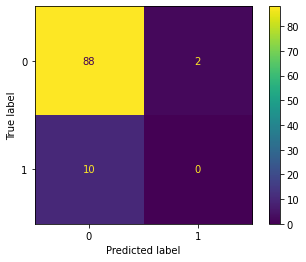

In [68]:
y_pred = model_xgb.predict(x_valid)
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Bad result, maybe we should use more samples.

In [73]:
node_params = {'shape': 'box', 
               'style': 'filled, rounded', 
                'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
grapg_data = xgb.to_graphviz(model_xgb, num_trees=0, size='10,10',
                                condition_node_params=node_params,
                                leaf_node_params=leaf_params)

grapg_data.view(filename='XGBoost_tree')

'XGBoost_tree.pdf'

## LightGBD & LR

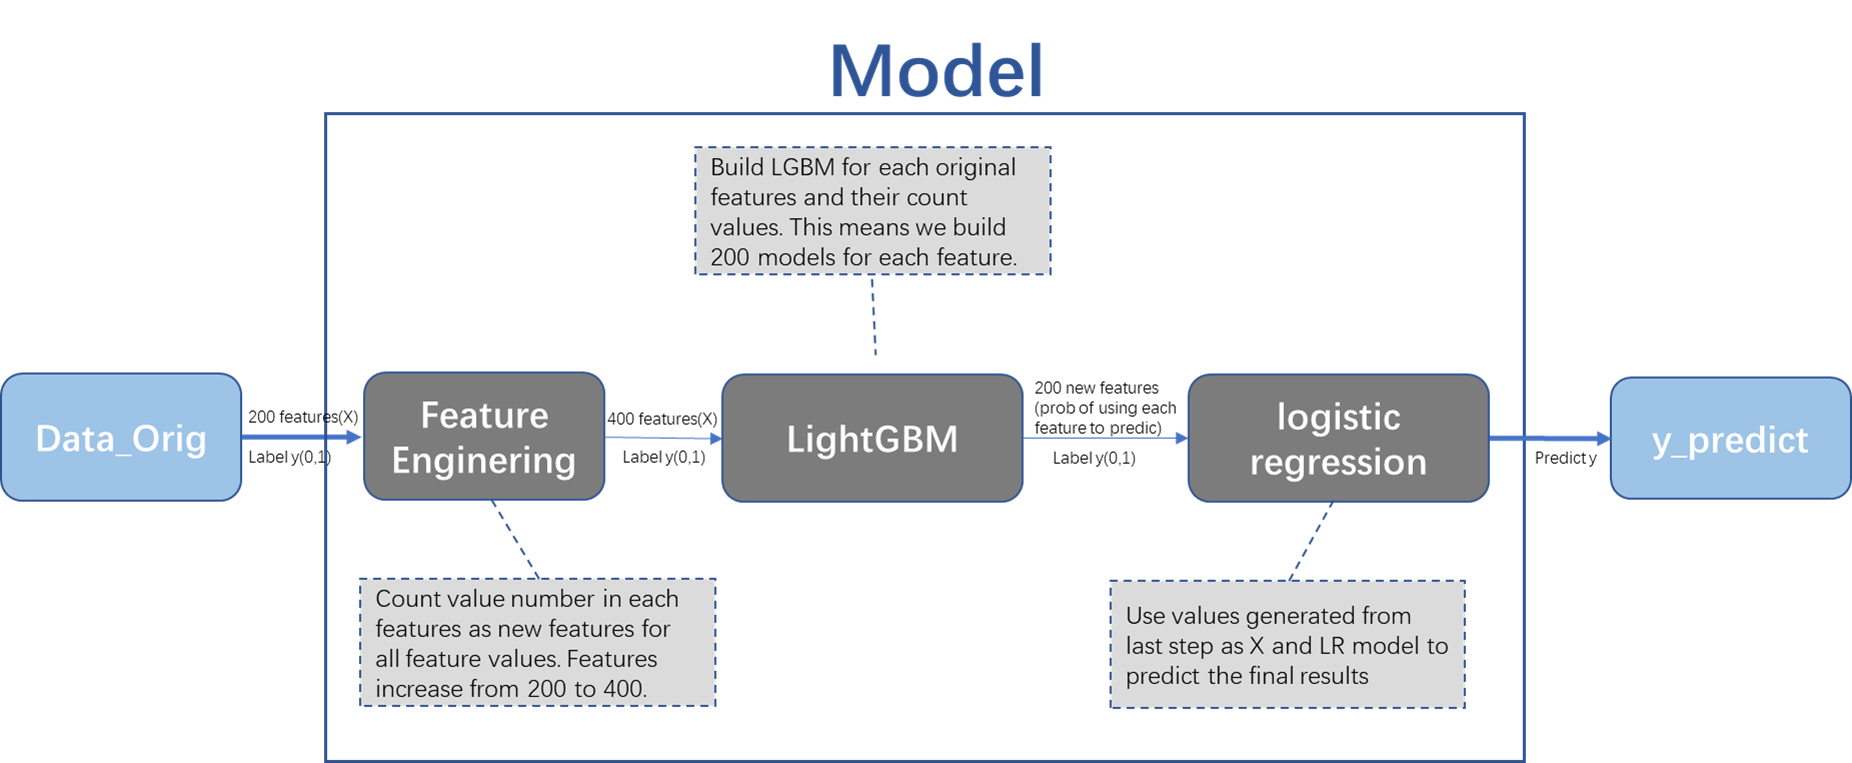

In [24]:
import warnings
warnings.filterwarnings("ignore")

### LGBD

In [93]:
feature_num = np.random.randint(0, 200, 10)

for i in feature_num:
    # extract feature from dataset
    features = ["var_"+str(i), 'var_'+str(i)+'_FE']
    x_train_LGBD = x_train[features]
    y_train_LGBD = y_train
    #print(x_train_LGBD)
    #print(y_train_LGBD)
    
    #set hyperparametes
    param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'num_leaves': [2, 3, 4],
    'n_estimators': [50, 100, 150]
    #'metric':'auc',
    #'boost_from_average':'false',
    #'verbosity': -10
    }
    
    #use GridSearchCV to find the best hyperparameters
    optimal_params = GridSearchCV(
    estimator = lgb.LGBMClassifier(
        objective='binary',
        metrics='auc' 
    ),
    param_grid = param_grid,
    scoring = 'roc_auc', 
    verbose = 0,
    cv = 5
    )
    
    #randomly choose samples from dataset as validation dataset
    x_valid_LGBD = x_train.sample(n=2000)
    y_valid_LGBD = y_train.loc[x_valid_LGBD.index]
    
    optimal_params.fit(
        x_train_samp, 
        y_train_samp,
        verbose=False, 
        early_stopping_rounds=10, 
        eval_metric='auc',
        eval_set=[(x_valid_LGBD, y_valid_LGBD)]
    )
    
    #print best hyperparameters
    print(features, "best patameters are:")
    print(optimal_params.best_params_)

['var_44', 'var_44_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 3}
['var_30', 'var_30_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 3}
['var_25', 'var_25_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 4}
['var_170', 'var_170_FE'] best patameters are:
{'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 3}
['var_176', 'var_176_FE'] best patameters are:
{'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 4}
['var_138', 'var_138_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 4}
['var_94', 'var_94_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 2}
['var_59', 'var_59_FE'] best patameters are:
{'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 3}
['var_95', 'var_95_FE'] best patameters are:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 4}
['var_46', 'var_46_FE'] best patamete

In [44]:

param = {
    'learning_rate': 0.1,
    'num_leaves': 4,
    'n_estimators': 125,
    'metric':'auc',
    'verbosity': -10
}
"""
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0,
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10
}
"""

"\nparam = {\n    'learning_rate': 0.04,\n    'num_leaves': 3,\n    'metric':'auc',\n    'boost_from_average':'false',\n    'feature_fraction': 1.0,\n    'max_depth': -1,\n    'objective': 'binary',\n    'verbosity': -10\n}\n"

In [48]:
y_lr_x = pd.DataFrame()

for i in range(200):
    features = ["var_"+str(i), 'var_'+str(i)+'_FE']
    x_train_LGBD = x_train[features]
    y_train_LGBD = y_train
    
    y_oof = pd.DataFrame(np.zeros((200000, 1)))
    evals_result ={}
    
    for k in range(5):
        valid_x = x_train_LGBD.iloc[k*40000:(k+1)*40000]
        valid_y = y_train_LGBD.iloc[k*40000:(k+1)*40000]
        train_x = x_train_LGBD[ ~x_train_LGBD.index.isin(valid_x.index)]
        train_y = y_train_LGBD[ ~y_train_LGBD.index.isin(valid_y.index)]  
        
        trn_data  = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(valid_x, label=valid_y)     
        model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
                    verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        #abc=model.predict(valid_x, num_iteration=best).reshape(-1,1)
        y_oof[k*40000:(k+1)*40000] = model.predict(valid_x, num_iteration=best).reshape(-1,1)
    
    y_lr_x["var_"+str(i)] = y_oof  

In [61]:
y_lr_x

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0       0.083940  0.087802  0.100322  0.099886  0.098720  0.093153  0.089143   
1       0.095111  0.088311  0.109058  0.099886  0.100866  0.108846  0.094858   
2       0.090003  0.102651  0.106192  0.100189  0.099551  0.093153  0.155656   
3       0.095111  0.100896  0.090144  0.100189  0.100747  0.099954  0.108866   
4       0.083940  0.099867  0.111474  0.101701  0.100747  0.101337  0.108866   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.090946  0.102953  0.086659  0.096679  0.099754  0.129819  0.095709   
199996  0.074166  0.101596  0.130153  0.098143  0.099754  0.097750  0.112775   
199997  0.090323  0.082891  0.088032  0.098143  0.099754  0.100682  0.082325   
199998  0.089928  0.090204  0.107256  0.098143  0.100113  0.099057  0.108456   
199999  0.090323  0.084746  0.110640  0.101279  0.099754  0.098531  0.085195   

           var_7     var_8     var_9  ...   var_190   var_191   var_192  \
0       0.103971  0.077888  0.111776  ...  0.097910  0.088182  0.087510   
1       0.101576  0.101124  0.089952  ...  0.112990  0.092224  0.087510   
2       0.101576  0.098002  0.099016  ...  0.093606  0.105084  0.104244   
3       0.101576  0.085913  0.087961  ...  0.097434  0.089848  0.108487   
4       0.099892  0.113661  0.111034  ...  0.087494  0.103661  0.107301   
...          ...       ...       ...  ...       ...       ...       ...   
199995  0.101182  0.105642  0.109816  ...  0.105265  0.126517  0.086950   
199996  0.098043  0.093801  0.100819  ...  0.098678  0.089470  0.108916   
199997  0.098043  0.099840  0.100888  ...  0.098678  0.085929  0.086950   
199998  0.102169  0.100966  0.090369  ...  0.091120  0.099288  0.084894   
199999  0.101182  0.099840  0.087123  ...  0.122216  0.081958  0.116731   

         var_193   var_194   var_195   var_196   var_197   var_198   var_199  
0       0.101631  0.100580  0.093608  0.101971  0.100134  0.105302  0.100387  
1       0.096951  0.102093  0.121651  0.101971  0.100134  0.089268  0.100387  
2       0.102692  0.098490  0.145579  0.095942  0.100134  0.094617  0.100387  
3       0.101631  0.098490  0.095388  0.095942  0.094013  0.091955  0.100188  
4       0.105659  0.103286  0.086141  0.100463  0.095253  0.091955  0.100188  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.101073  0.100590  0.096804  0.099452  0.099811  0.089822  0.083616  
199996  0.101803  0.096067  0.112055  0.092953  0.138342  0.087092  0.099316  
199997  0.096970  0.096067  0.089795  0.099452  0.099811  0.103371  0.100342  
199998  0.097573  0.096067  0.096188  0.100032  0.096418  0.095556  0.095768  
199999  0.101073  0.101248  0.093518  0.092953  0.099811  0.118651  0.100342  

[200000 rows x 200 columns]

In [73]:
y_lr_x.to_csv("LGBD_result")

### Logistic Regression

In [77]:
from statsmodels.discrete.discrete_model import Logit

In [79]:
log = Logit(y_train, y_lr_x)
log = log.fit(disp=0)
ensemble_preds = log.predict(y_lr_x)
ensemble_auc = roc_auc_score(y_train,ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))

##################
Combined Model with magic Val_AUC= 0.90237



In [95]:
y_preds = pd.DataFrame(np.zeros(200000))
y_preds[ensemble_preds > 0.5] =1

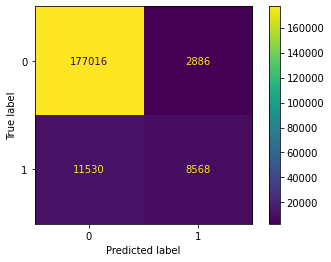

In [97]:
cm = confusion_matrix(y_train, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [76]:
logr.summary(y_preds)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               200000
Model:                          Logit   Df Residuals:                   199800
Method:                           MLE   Df Model:                          199
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                  0.3976
Time:                        18:34:44   Log-Likelihood:                -39293.
converged:                       True   LL-Null:                       -65232.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var_0          8.2021      0.345     23.780      0.000       7.526       8.878
var_1          7.6893      0.347     22.178      0.000       7.010       8.369
var_2          8.1014      0.327     24.767      0.000       7.460       8.743
var_3         -1.8378      2.090     -0.879      0.379      -5.934       2.258
var_4         -4.4627      2.045     -2.182      0.029      -8.472      -0.454
var_5          7.1100      0.384     18.517      0.000       6.357       7.863
var_6          8.8781      0.341     26.000      0.000       8.209       9.547
var_7        -29.6140      2.950    -10.039      0.000     -35.396     -23.832
var_8          4.4983      1.216      3.700      0.000       2.116       6.881
var_9          8.1726      0.435     18.788      0.000       7.320       9.025
var_10      -111.0961      5.336    -20.821      0.000    -121.554    -100.638
var_11         7.7529      0.944      8.212      0.000       5.903       9.603
var_12         8.5264      0.319     26.715      0.000       7.901       9.152
var_13         7.4642      0.309     24.141      0.000       6.858       8.070
var_14        -9.0480      2.234     -4.050      0.000     -13.427      -4.669
var_15         2.1411      1.533      1.397      0.162      -0.863       5.145
var_16        -6.9571      1.879     -3.703      0.000     -10.640      -3.274
var_17       -33.9676      3.068    -11.073      0.000     -39.980     -27.955
var_18         6.9321      0.345     20.122      0.000       6.257       7.607
var_19         1.1561      1.520      0.761      0.447      -1.823       4.135
var_20         7.2746      1.009      7.209      0.000       5.297       9.252
var_21         8.1523      0.321     25.417      0.000       7.524       8.781
var_22         7.7137      0.288     26.805      0.000       7.150       8.278
var_23         5.7762      1.149      5.027      0.000       3.524       8.028
var_24         7.9006      0.777     10.165      0.000       6.377       9.424
var_25       -11.4724      2.376     -4.829      0.000     -16.129      -6.816
var_26         7.5945      0.257     29.540      0.000       7.091       8.098
var_27       -29.6495      3.178     -9.328      0.000     -35.879     -23.420
var_28         5.2568      1.403      3.748      0.000       2.508       8.006
var_29       -65.6864      4.377    -15.006      0.000     -74.266     -57.107
var_30       -25.2563      2.681     -9.419      0.000     -30.512     -20.001
var_31         6.5684      1.176      5.585      0.000       4.264       8.873
var_32         8.0584      0.574     14.027      0.000       6.932       9.184
var_33         7.9551      0.354     22.449      0.000       7.261       8.650
var_34        10.5217      0.561     18.750      0.000       9.422      11.622
var_35         8.5114      0.613     13.879      0.000       7.309       9.713
var_36         8.9776      0.651     13.788      0.000       7.701      10.254
var_37        -3.0910      1.737     -1.780      0.075      -6.495       0.313
va